# Demo: Denoising of 2D simulated images

This notebook showcases the training of an SN2N 2DUnet model for a 2D denoising task using simulated MT data generated by ourselves.

In [1]:
import os
import sys
import numpy as np
from SN2N.datagen import generator2D
from SN2N.get_options import datagen2D

## Simulated data

We created microtubule-like structures by utilizing the insertShape function in MATLAB to draw multiple lines with random orientations. The simulation included the effects of incomplete labeling observed in practical experiments through the application of a small Gaussian mask and elastic deformation, mimicking the curviness of the cytoskeleton. The synthetic structures were convolved with a 150 nm size PSF and downsampled by 2-fold, resulting in 2048 x 2048 pixels with a 32.5 nm pixel size (simulated blurred ground-truth). Finally, the images were contaminated by 40% Poisson-Gaussian noise levels.

<p>
<img src='./imgs/simulation-workflow.png' align="left" width=500>
</p>

## Generating training data for SN2N

We first need to use raw_data to generate SN2N data pairs.  
When generating data pairs, we need to first confirm and <font color="red">set important parameters</font> related to data generation.

-----Parameters------  
<font color="red">=====Important==========</font>  
- <span style="color:blue">img_path:</span>  
    Path of raw images to train.  
- <span style="color:blue">P2Pmode(0 ~ 3):</span>  
    Augmentation mode for Patch2Patch.  
    0: NONE;  
    1: Direct interchange in t;  
    2: Interchange in single frame;  
    3: Interchange in multiple frame but in different regions;  
    {default: 0}  
- <span style="color:blue">P2Pup:</span>  
    Increase the dataset to its (1 + P2Pup) times size.  
    {default: 0}  
- <span style="color:blue">BAmode(0 ~ 2)</span>  
    Basic augmentation mode.  
    0: NONE;  
    1: double the dataset with random rotate&flip;  
    2: eightfold the dataset with random rotate&flip;  
    {default: 0}  
- <span style="color:blue">SWsize</span>  
    Interval pixel of sliding window for generating image pathes.  
    {default: 64}  
    
<font color="red">======Other parameters do not require modification; for details, refer to SN2N.get_options.datagen2D.========</font>  


#### Step 1: Define custom parameters.
We use one raw image and apply both P2P augmentation and basic augmentation to demonstrate SN2N's ability to denoise using only one original noisy image. 

In [2]:
img_path = 'data/raw_data'
P2Pmode = '2'
P2Pup = '6'
BAmode = '2'
SWsize = '64' 


datagen2D_args = [
    '--img_path', img_path,
    '--P2Pmode', P2Pmode,
    '--P2Pup', P2Pup,
    '--BAmode', BAmode,
    '--SWsize', SWsize        
]

args = datagen2D(datagen2D_args)
print("Arguments received:", args)

Arguments received: Namespace(BAmode=2, P2P_patch='64', P2Pmode=2, P2Pup=6, SWfilter=1, SWmode=1, SWsize=64, ifx2=True, img_patch='128', img_path='data/raw_data', inter_mode='Fourier')


#### Step 2: Execute data generation.

The <font color="red">raw data</font> used for generating training data is stored in the <font color="red">'Path:/raw_data'</font> directory, and the generated <font color="red">training data pairs</font> are by default stored in the <font color="red">'Path:/datasets'</font>

In [3]:
d = generator2D(img_path=args.img_path, P2Pmode = args.P2Pmode, P2Pup = args.P2Pup, BAmode = args.BAmode, SWsize = args.SWsize)
d.execute()
print("Data generation completed.")

The path for the raw images used for training is located under:
data/raw_data
The training dataset is being saved under:
data\datasets
For number 1 frame
Saving training images: 100
Saving training images: 200
Saving training images: 300
Saving training images: 400
Saving training images: 500
Saving training images: 600
Saving training images: 700
Saving training images: 800
Saving training images: 900
Saving training images: 1000
Saving training images: 1100
Saving training images: 1200
Saving training images: 1300
Saving training images: 1400
Saving training images: 1500
Saving training images: 1600
Saving training images: 1700
Saving training images: 1800
Saving training images: 1900
Saving training images: 2000
Saving training images: 2100
Saving training images: 2200
Saving training images: 2300
Saving training images: 2400
Saving training images: 2500
Saving training images: 2600
Saving training images: 2700
Saving training images: 2800
Saving training images: 2900
Saving trainin

## Show some generated patches

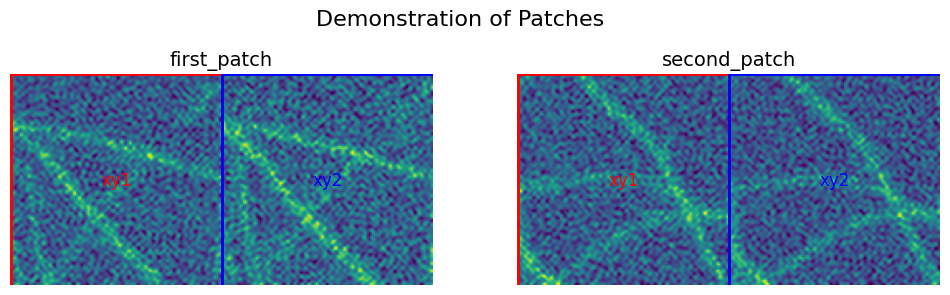

In [4]:
import tifffile
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

dataset_path = d.dataset_path
tif_files = [f for f in os.listdir(dataset_path) if f.endswith('.tif')]
first_patch = tifffile.imread(os.path.join(dataset_path, tif_files[0]))
second_patch = tifffile.imread(os.path.join(dataset_path, tif_files[1]))

fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))


im1 = axs[0].imshow(first_patch)
axs[0].set_title('first_patch', fontsize=14)
axs[0].axis('off') 
axs[0].add_patch(Rectangle((0, 0), first_patch.shape[1] // 2, first_patch.shape[0], linewidth=2, edgecolor='r', facecolor='none'))
axs[0].add_patch(Rectangle((first_patch.shape[1] // 2, 0), first_patch.shape[1] // 2, first_patch.shape[0], linewidth=2, edgecolor='b', facecolor='none'))


axs[0].text(first_patch.shape[1] // 4, first_patch.shape[0] // 2, 'xy1', fontsize=12, color='r', ha='center', va='center')
axs[0].text(3 * first_patch.shape[1] // 4, first_patch.shape[0] // 2, 'xy2', fontsize=12, color='b', ha='center', va='center')


im2 = axs[1].imshow(second_patch)
axs[1].set_title('second_patch', fontsize=14)
axs[1].axis('off') 
axs[1].add_patch(Rectangle((0, 0), second_patch.shape[1] // 2, second_patch.shape[0], linewidth=2, edgecolor='r', facecolor='none'))
axs[1].add_patch(Rectangle((second_patch.shape[1] // 2, 0), second_patch.shape[1] // 2, second_patch.shape[0], linewidth=2, edgecolor='b', facecolor='none'))


axs[1].text(second_patch.shape[1] // 4, second_patch.shape[0] // 2, 'xy1', fontsize=12, color='r', ha='center', va='center')
axs[1].text(3 * second_patch.shape[1] // 4, second_patch.shape[0] // 2, 'xy2', fontsize=12, color='b', ha='center', va='center')


fig.suptitle('Demonstration of Patches', fontsize=16)


plt.show()

## Training data

We need to use training data pairs to train SN2N model.  
When training, we need to first confirm and <font color="red">set important parameters</font> related to trainers.

-----Parameters------  
<font color="red">=====Important==========</font>  
- <span style="color:blue">img_path:</span>  
    Path of raw images to train.  
- <span style="color:blue">sn2n_loss:</span>  
    Weight of self-constrained loss.  
    <span style="color:red">One of the most crucial parameters that needs adjustment， generally set to 0~2.</span>  
    A higher sn2n_loss weight implies relatively better denoising and more pronounced smoothing effects.  
    {default: 1}  
- <span style="color:blue">bs:</span>  
    Training batch size.  
    {default: 32}  
- <span style="color:blue">lr</span>  
    Learning rate.       
    {default: 2e-4}  
- <span style="color:blue">epochs</span>  
    Total number of training epochs.  
    {default: 100}  
    
<font color="red">======Other parameters do not require modification; for details, refer to SN2N.get_options.trainer2D.========</font>  

#### Step 1: Define custom parameters.

In [5]:
from SN2N.trainer import net2D
from SN2N.get_options import trainer2D

img_path = 'data/raw_data'
sn2n_loss = '1'
bs = '32'
lr = '2e-4'
epochs = '100'

trainer2D_args = [
    '--img_path', img_path,
    '--sn2n_loss', sn2n_loss,
    '--bs', bs,
    '--lr', lr,
    '--epochs', epochs
]

args = trainer2D(trainer2D_args)
print("Arguments received:", args)

Arguments received: Namespace(bs=32, epochs=100, if_alr=True, img_patch='128', img_path='data/raw_data', lr=0.0002, sn2n_loss=1.0)


#### Step 2: Execute training.

The <font color="red">raw data</font> used for generating training data is stored in the <font color="red">'Path:/raw_data'</font> directory  
the <font color="red">models</font> are by default stored in the <font color="red">'Path:/models'</font>  
During the training process, we also performed real-time predictions for the first image in the raw_data for each epoch as predicted images. The <font color="red">images</font> results are by default stored in the <font color="red">'Path:/images'</font> directory.

In [6]:
sn2nunet = net2D(img_path = args.img_path, sn2n_loss = args.sn2n_loss, bs = args.bs, lr = args.lr, epochs = args.epochs)
sn2nunet.train()
print("Training completed.")

The path for the raw images used for training is located under:
data/raw_data
The training dataset is being saved under:
data\datasets
Models is being saved under:
data\models
Training temporary prediction images is being saved under:
data\images
[Epoch 0/100] [Batch 0/693] [loss:17.829305] time:0:00:00.280069
[Epoch 0/100] [Batch 1/693] [loss:16.351892] time:0:00:00.774439
[Epoch 0/100] [Batch 2/693] [loss:16.424088] time:0:00:01.212129
[Epoch 0/100] [Batch 3/693] [loss:15.157799] time:0:00:01.653284
[Epoch 0/100] [Batch 4/693] [loss:15.897195] time:0:00:02.086041
[Epoch 0/100] [Batch 5/693] [loss:14.092459] time:0:00:02.527965
[Epoch 0/100] [Batch 6/693] [loss:11.981712] time:0:00:02.973938
[Epoch 0/100] [Batch 7/693] [loss:10.635809] time:0:00:03.411442
[Epoch 0/100] [Batch 8/693] [loss:10.689507] time:0:00:03.837114
[Epoch 0/100] [Batch 9/693] [loss:9.993550] time:0:00:04.283385
[Epoch 0/100] [Batch 10/693] [loss:10.180843] time:0:00:04.717178
[Epoch 0/100] [Batch 11/693] [loss:10.

[Epoch 0/100] [Batch 122/693] [loss:7.036762] time:0:00:52.651230
[Epoch 0/100] [Batch 123/693] [loss:7.590965] time:0:00:53.074020
[Epoch 0/100] [Batch 124/693] [loss:6.943951] time:0:00:53.487545
[Epoch 0/100] [Batch 125/693] [loss:6.317728] time:0:00:53.906160
[Epoch 0/100] [Batch 126/693] [loss:6.880052] time:0:00:54.323388
[Epoch 0/100] [Batch 127/693] [loss:7.576337] time:0:00:54.745006
[Epoch 0/100] [Batch 128/693] [loss:6.895830] time:0:00:55.158348
[Epoch 0/100] [Batch 129/693] [loss:6.868971] time:0:00:55.582087
[Epoch 0/100] [Batch 130/693] [loss:6.113492] time:0:00:55.997757
[Epoch 0/100] [Batch 131/693] [loss:7.075108] time:0:00:56.418356
[Epoch 0/100] [Batch 132/693] [loss:6.105586] time:0:00:56.843937
[Epoch 0/100] [Batch 133/693] [loss:7.188153] time:0:00:57.281688
[Epoch 0/100] [Batch 134/693] [loss:7.445472] time:0:00:57.740301
[Epoch 0/100] [Batch 135/693] [loss:6.455251] time:0:00:58.160031
[Epoch 0/100] [Batch 136/693] [loss:6.464646] time:0:00:58.578271
[Epoch 0/1

[Epoch 0/100] [Batch 247/693] [loss:6.200960] time:0:01:45.089172
[Epoch 0/100] [Batch 248/693] [loss:5.954029] time:0:01:45.522904
[Epoch 0/100] [Batch 249/693] [loss:7.087266] time:0:01:45.955941
[Epoch 0/100] [Batch 250/693] [loss:7.378761] time:0:01:46.356604
[Epoch 0/100] [Batch 251/693] [loss:6.889499] time:0:01:46.762305
[Epoch 0/100] [Batch 252/693] [loss:6.979073] time:0:01:47.178930
[Epoch 0/100] [Batch 253/693] [loss:6.672340] time:0:01:47.590012
[Epoch 0/100] [Batch 254/693] [loss:7.089064] time:0:01:47.991911
[Epoch 0/100] [Batch 255/693] [loss:6.740241] time:0:01:48.395789
[Epoch 0/100] [Batch 256/693] [loss:6.762960] time:0:01:48.818246
[Epoch 0/100] [Batch 257/693] [loss:7.705414] time:0:01:49.226286
[Epoch 0/100] [Batch 258/693] [loss:7.271802] time:0:01:49.636061
[Epoch 0/100] [Batch 259/693] [loss:6.808619] time:0:01:50.044698
[Epoch 0/100] [Batch 260/693] [loss:6.327645] time:0:01:50.462678
[Epoch 0/100] [Batch 261/693] [loss:6.123701] time:0:01:50.877297
[Epoch 0/1

[Epoch 0/100] [Batch 372/693] [loss:6.664218] time:0:02:36.703997
[Epoch 0/100] [Batch 373/693] [loss:7.407720] time:0:02:37.089101
[Epoch 0/100] [Batch 374/693] [loss:6.295151] time:0:02:37.503000
[Epoch 0/100] [Batch 375/693] [loss:5.958042] time:0:02:37.910654
[Epoch 0/100] [Batch 376/693] [loss:6.875039] time:0:02:38.325329
[Epoch 0/100] [Batch 377/693] [loss:6.513929] time:0:02:38.727228
[Epoch 0/100] [Batch 378/693] [loss:6.243378] time:0:02:39.133875
[Epoch 0/100] [Batch 379/693] [loss:6.418934] time:0:02:39.542508
[Epoch 0/100] [Batch 380/693] [loss:6.921691] time:0:02:39.943470
[Epoch 0/100] [Batch 381/693] [loss:6.391390] time:0:02:40.352336
[Epoch 0/100] [Batch 382/693] [loss:6.733770] time:0:02:40.751999
[Epoch 0/100] [Batch 383/693] [loss:7.419281] time:0:02:41.163910
[Epoch 0/100] [Batch 384/693] [loss:6.404694] time:0:02:41.573010
[Epoch 0/100] [Batch 385/693] [loss:7.267656] time:0:02:41.974666
[Epoch 0/100] [Batch 386/693] [loss:6.449980] time:0:02:42.388920
[Epoch 0/1

[Epoch 0/100] [Batch 497/693] [loss:6.057529] time:0:03:27.450371
[Epoch 0/100] [Batch 498/693] [loss:6.492615] time:0:03:27.848767
[Epoch 0/100] [Batch 499/693] [loss:6.193596] time:0:03:28.257404
[Epoch 0/100] [Batch 500/693] [loss:6.082366] time:0:03:28.664956
[Epoch 0/100] [Batch 501/693] [loss:6.371402] time:0:03:29.065058
[Epoch 0/100] [Batch 502/693] [loss:6.288549] time:0:03:29.464287
[Epoch 0/100] [Batch 503/693] [loss:6.365380] time:0:03:29.871172
[Epoch 0/100] [Batch 504/693] [loss:6.270080] time:0:03:30.274597
[Epoch 0/100] [Batch 505/693] [loss:6.916329] time:0:03:30.681744
[Epoch 0/100] [Batch 506/693] [loss:6.065150] time:0:03:31.075427
[Epoch 0/100] [Batch 507/693] [loss:7.367267] time:0:03:31.487590
[Epoch 0/100] [Batch 508/693] [loss:6.844636] time:0:03:31.883273
[Epoch 0/100] [Batch 509/693] [loss:6.241597] time:0:03:32.281348
[Epoch 0/100] [Batch 510/693] [loss:5.877272] time:0:03:32.684224
[Epoch 0/100] [Batch 511/693] [loss:6.812198] time:0:03:33.084681
[Epoch 0/1

[Epoch 0/100] [Batch 622/693] [loss:6.229872] time:0:04:17.712579
[Epoch 0/100] [Batch 623/693] [loss:6.420527] time:0:04:18.111245
[Epoch 0/100] [Batch 624/693] [loss:6.792229] time:0:04:18.502050
[Epoch 0/100] [Batch 625/693] [loss:6.405687] time:0:04:18.900047
[Epoch 0/100] [Batch 626/693] [loss:7.106661] time:0:04:19.305704
[Epoch 0/100] [Batch 627/693] [loss:6.489380] time:0:04:19.693812
[Epoch 0/100] [Batch 628/693] [loss:6.802020] time:0:04:20.085449
[Epoch 0/100] [Batch 629/693] [loss:6.669638] time:0:04:20.490500
[Epoch 0/100] [Batch 630/693] [loss:6.543656] time:0:04:20.878393
[Epoch 0/100] [Batch 631/693] [loss:6.467847] time:0:04:21.279560
[Epoch 0/100] [Batch 632/693] [loss:5.836808] time:0:04:21.675124
[Epoch 0/100] [Batch 633/693] [loss:7.364754] time:0:04:22.063138
[Epoch 0/100] [Batch 634/693] [loss:6.409542] time:0:04:22.458685
[Epoch 0/100] [Batch 635/693] [loss:6.153046] time:0:04:22.856402
[Epoch 0/100] [Batch 636/693] [loss:6.019145] time:0:04:23.240148
[Epoch 0/1

[Epoch 1/100] [Batch 55/693] [loss:6.258634] time:0:05:16.192421
[Epoch 1/100] [Batch 56/693] [loss:6.277841] time:0:05:16.590615
[Epoch 1/100] [Batch 57/693] [loss:5.916813] time:0:05:16.999146
[Epoch 1/100] [Batch 58/693] [loss:6.700235] time:0:05:17.399965
[Epoch 1/100] [Batch 59/693] [loss:5.906141] time:0:05:17.808293
[Epoch 1/100] [Batch 60/693] [loss:6.019172] time:0:05:18.205005
[Epoch 1/100] [Batch 61/693] [loss:6.545604] time:0:05:18.594544
[Epoch 1/100] [Batch 62/693] [loss:5.985843] time:0:05:19.015675
[Epoch 1/100] [Batch 63/693] [loss:6.126998] time:0:05:19.420331
[Epoch 1/100] [Batch 64/693] [loss:6.981795] time:0:05:19.836652
[Epoch 1/100] [Batch 65/693] [loss:6.864214] time:0:05:20.215927
[Epoch 1/100] [Batch 66/693] [loss:6.316534] time:0:05:20.619576
[Epoch 1/100] [Batch 67/693] [loss:6.316852] time:0:05:21.040169
[Epoch 1/100] [Batch 68/693] [loss:6.225404] time:0:05:21.417905
[Epoch 1/100] [Batch 69/693] [loss:5.873638] time:0:05:21.837025
[Epoch 1/100] [Batch 70/6

[Epoch 1/100] [Batch 180/693] [loss:6.878001] time:0:06:06.712115
[Epoch 1/100] [Batch 181/693] [loss:6.147760] time:0:06:07.124771
[Epoch 1/100] [Batch 182/693] [loss:6.413081] time:0:06:07.515711
[Epoch 1/100] [Batch 183/693] [loss:5.728412] time:0:06:07.939937
[Epoch 1/100] [Batch 184/693] [loss:6.894029] time:0:06:08.313534
[Epoch 1/100] [Batch 185/693] [loss:7.198094] time:0:06:08.735884
[Epoch 1/100] [Batch 186/693] [loss:7.251429] time:0:06:09.127353
[Epoch 1/100] [Batch 187/693] [loss:6.504484] time:0:06:09.520323
[Epoch 1/100] [Batch 188/693] [loss:6.522098] time:0:06:09.932055
[Epoch 1/100] [Batch 189/693] [loss:6.258108] time:0:06:10.320790
[Epoch 1/100] [Batch 190/693] [loss:6.460362] time:0:06:10.738392
[Epoch 1/100] [Batch 191/693] [loss:5.953908] time:0:06:11.132190
[Epoch 1/100] [Batch 192/693] [loss:6.119518] time:0:06:11.545812
[Epoch 1/100] [Batch 193/693] [loss:6.554078] time:0:06:11.958980
[Epoch 1/100] [Batch 194/693] [loss:5.903422] time:0:06:12.357946
[Epoch 1/1

[Epoch 1/100] [Batch 305/693] [loss:5.930311] time:0:06:56.845214
[Epoch 1/100] [Batch 306/693] [loss:6.621713] time:0:06:57.222951
[Epoch 1/100] [Batch 307/693] [loss:6.621862] time:0:06:57.626999
[Epoch 1/100] [Batch 308/693] [loss:6.228481] time:0:06:58.054630
[Epoch 1/100] [Batch 309/693] [loss:6.746215] time:0:06:58.429704
[Epoch 1/100] [Batch 310/693] [loss:6.340463] time:0:06:58.842323
[Epoch 1/100] [Batch 311/693] [loss:6.779926] time:0:06:59.222034
[Epoch 1/100] [Batch 312/693] [loss:6.903280] time:0:06:59.619682
[Epoch 1/100] [Batch 313/693] [loss:5.887495] time:0:07:00.034890
[Epoch 1/100] [Batch 314/693] [loss:5.691487] time:0:07:00.408115
[Epoch 1/100] [Batch 315/693] [loss:5.848121] time:0:07:00.814756
[Epoch 1/100] [Batch 316/693] [loss:6.914427] time:0:07:01.210820
[Epoch 1/100] [Batch 317/693] [loss:6.749973] time:0:07:01.610646
[Epoch 1/100] [Batch 318/693] [loss:6.358948] time:0:07:02.023267
[Epoch 1/100] [Batch 319/693] [loss:6.094367] time:0:07:02.391067
[Epoch 1/1

[Epoch 1/100] [Batch 430/693] [loss:7.618911] time:0:07:46.647780
[Epoch 1/100] [Batch 431/693] [loss:6.443926] time:0:07:47.038447
[Epoch 1/100] [Batch 432/693] [loss:6.395826] time:0:07:47.416669
[Epoch 1/100] [Batch 433/693] [loss:6.144072] time:0:07:47.811349
[Epoch 1/100] [Batch 434/693] [loss:6.221551] time:0:07:48.195593
[Epoch 1/100] [Batch 435/693] [loss:6.592235] time:0:07:48.588012
[Epoch 1/100] [Batch 436/693] [loss:6.550681] time:0:07:49.008851
[Epoch 1/100] [Batch 437/693] [loss:6.387972] time:0:07:49.383597
[Epoch 1/100] [Batch 438/693] [loss:5.695930] time:0:07:49.797716
[Epoch 1/100] [Batch 439/693] [loss:6.137660] time:0:07:50.183430
[Epoch 1/100] [Batch 440/693] [loss:6.372066] time:0:07:50.569263
[Epoch 1/100] [Batch 441/693] [loss:5.836551] time:0:07:50.969121
[Epoch 1/100] [Batch 442/693] [loss:6.177421] time:0:07:51.354836
[Epoch 1/100] [Batch 443/693] [loss:5.980235] time:0:07:51.769559
[Epoch 1/100] [Batch 444/693] [loss:6.388480] time:0:07:52.157268
[Epoch 1/1

[Epoch 1/100] [Batch 555/693] [loss:6.370787] time:0:08:35.847532
[Epoch 1/100] [Batch 556/693] [loss:5.783236] time:0:08:36.229399
[Epoch 1/100] [Batch 557/693] [loss:5.750914] time:0:08:36.625179
[Epoch 1/100] [Batch 558/693] [loss:6.163405] time:0:08:37.022594
[Epoch 1/100] [Batch 559/693] [loss:6.407825] time:0:08:37.390404
[Epoch 1/100] [Batch 560/693] [loss:6.252378] time:0:08:37.791069
[Epoch 1/100] [Batch 561/693] [loss:5.862080] time:0:08:38.166085
[Epoch 1/100] [Batch 562/693] [loss:6.677801] time:0:08:38.577341
[Epoch 1/100] [Batch 563/693] [loss:6.416795] time:0:08:38.990105
[Epoch 1/100] [Batch 564/693] [loss:6.221654] time:0:08:39.366905
[Epoch 1/100] [Batch 565/693] [loss:6.402641] time:0:08:39.759571
[Epoch 1/100] [Batch 566/693] [loss:5.794750] time:0:08:40.154250
[Epoch 1/100] [Batch 567/693] [loss:6.579486] time:0:08:40.542046
[Epoch 1/100] [Batch 568/693] [loss:6.251140] time:0:08:40.960649
[Epoch 1/100] [Batch 569/693] [loss:7.123470] time:0:08:41.343055
[Epoch 1/1

[Epoch 1/100] [Batch 680/693] [loss:6.522185] time:0:09:25.074212
[Epoch 1/100] [Batch 681/693] [loss:6.070333] time:0:09:25.439265
[Epoch 1/100] [Batch 682/693] [loss:7.115635] time:0:09:25.839779
[Epoch 1/100] [Batch 683/693] [loss:6.267803] time:0:09:26.212632
[Epoch 1/100] [Batch 684/693] [loss:5.979571] time:0:09:26.616280
[Epoch 1/100] [Batch 685/693] [loss:5.876232] time:0:09:27.028236
[Epoch 1/100] [Batch 686/693] [loss:6.482343] time:0:09:27.395795
[Epoch 1/100] [Batch 687/693] [loss:7.116226] time:0:09:27.825782
[Epoch 1/100] [Batch 688/693] [loss:6.220313] time:0:09:28.198196
[Epoch 1/100] [Batch 689/693] [loss:6.383743] time:0:09:28.580367
[Epoch 1/100] [Batch 690/693] [loss:6.136902] time:0:09:28.986296
[Epoch 1/100] [Batch 691/693] [loss:6.092210] time:0:09:29.372567
[Epoch 1/100] [Batch 692/693] [loss:7.544086] time:0:09:29.802724
[Epoch 2/100] [Batch 0/693] [loss:6.208742] time:0:09:38.143671
[Epoch 2/100] [Batch 1/693] [loss:6.359566] time:0:09:38.552434
[Epoch 2/100] 

[Epoch 2/100] [Batch 113/693] [loss:5.850339] time:0:10:22.063837
[Epoch 2/100] [Batch 114/693] [loss:7.199226] time:0:10:22.440325
[Epoch 2/100] [Batch 115/693] [loss:5.867210] time:0:10:22.845968
[Epoch 2/100] [Batch 116/693] [loss:6.066799] time:0:10:23.209824
[Epoch 2/100] [Batch 117/693] [loss:5.976079] time:0:10:23.600068
[Epoch 2/100] [Batch 118/693] [loss:6.322192] time:0:10:24.016674
[Epoch 2/100] [Batch 119/693] [loss:7.548781] time:0:10:24.385501
[Epoch 2/100] [Batch 120/693] [loss:5.750762] time:0:10:24.778367
[Epoch 2/100] [Batch 121/693] [loss:6.375976] time:0:10:25.162083
[Epoch 2/100] [Batch 122/693] [loss:5.674559] time:0:10:25.541342
[Epoch 2/100] [Batch 123/693] [loss:6.343428] time:0:10:25.951220
[Epoch 2/100] [Batch 124/693] [loss:5.692628] time:0:10:26.323590
[Epoch 2/100] [Batch 125/693] [loss:6.410173] time:0:10:26.710630
[Epoch 2/100] [Batch 126/693] [loss:5.671434] time:0:10:27.094926
[Epoch 2/100] [Batch 127/693] [loss:5.727888] time:0:10:27.460983
[Epoch 2/1

[Epoch 2/100] [Batch 238/693] [loss:7.175042] time:0:11:10.388750
[Epoch 2/100] [Batch 239/693] [loss:5.787216] time:0:11:10.780431
[Epoch 2/100] [Batch 240/693] [loss:5.751618] time:0:11:11.151224
[Epoch 2/100] [Batch 241/693] [loss:7.446451] time:0:11:11.527963
[Epoch 2/100] [Batch 242/693] [loss:6.504824] time:0:11:11.941579
[Epoch 2/100] [Batch 243/693] [loss:5.863987] time:0:11:12.317424
[Epoch 2/100] [Batch 244/693] [loss:6.732222] time:0:11:12.716396
[Epoch 2/100] [Batch 245/693] [loss:5.671139] time:0:11:13.105095
[Epoch 2/100] [Batch 246/693] [loss:6.767349] time:0:11:13.473196
[Epoch 2/100] [Batch 247/693] [loss:6.384880] time:0:11:13.857908
[Epoch 2/100] [Batch 248/693] [loss:6.656065] time:0:11:14.240628
[Epoch 2/100] [Batch 249/693] [loss:6.477921] time:0:11:14.614377
[Epoch 2/100] [Batch 250/693] [loss:6.661845] time:0:11:15.007063
[Epoch 2/100] [Batch 251/693] [loss:6.899156] time:0:11:15.368854
[Epoch 2/100] [Batch 252/693] [loss:6.833575] time:0:11:15.789446
[Epoch 2/1

[Epoch 2/100] [Batch 363/693] [loss:6.428035] time:0:11:58.575482
[Epoch 2/100] [Batch 364/693] [loss:6.469104] time:0:11:58.948403
[Epoch 2/100] [Batch 365/693] [loss:6.060192] time:0:11:59.308200
[Epoch 2/100] [Batch 366/693] [loss:5.993037] time:0:11:59.696899
[Epoch 2/100] [Batch 367/693] [loss:5.992787] time:0:12:00.107986
[Epoch 2/100] [Batch 368/693] [loss:6.279872] time:0:12:00.487716
[Epoch 2/100] [Batch 369/693] [loss:6.991767] time:0:12:00.880402
[Epoch 2/100] [Batch 370/693] [loss:5.971645] time:0:12:01.258123
[Epoch 2/100] [Batch 371/693] [loss:6.428870] time:0:12:01.640849
[Epoch 2/100] [Batch 372/693] [loss:5.974300] time:0:12:02.022572
[Epoch 2/100] [Batch 373/693] [loss:5.696785] time:0:12:02.388348
[Epoch 2/100] [Batch 374/693] [loss:5.797017] time:0:12:02.785266
[Epoch 2/100] [Batch 375/693] [loss:6.489643] time:0:12:03.153035
[Epoch 2/100] [Batch 376/693] [loss:6.632059] time:0:12:03.527786
[Epoch 2/100] [Batch 377/693] [loss:6.918424] time:0:12:03.908512
[Epoch 2/1

[Epoch 2/100] [Batch 488/693] [loss:6.246268] time:0:12:46.720488
[Epoch 2/100] [Batch 489/693] [loss:6.496552] time:0:12:47.107193
[Epoch 2/100] [Batch 490/693] [loss:6.134681] time:0:12:47.499880
[Epoch 2/100] [Batch 491/693] [loss:6.411404] time:0:12:47.901535
[Epoch 2/100] [Batch 492/693] [loss:6.132402] time:0:12:48.267314
[Epoch 2/100] [Batch 493/693] [loss:5.822985] time:0:12:48.650319
[Epoch 2/100] [Batch 494/693] [loss:6.515330] time:0:12:49.061945
[Epoch 2/100] [Batch 495/693] [loss:6.231042] time:0:12:49.425728
[Epoch 2/100] [Batch 496/693] [loss:6.684396] time:0:12:49.818414
[Epoch 2/100] [Batch 497/693] [loss:6.015487] time:0:12:50.185187
[Epoch 2/100] [Batch 498/693] [loss:6.097084] time:0:12:50.559933
[Epoch 2/100] [Batch 499/693] [loss:6.321017] time:0:12:50.968566
[Epoch 2/100] [Batch 500/693] [loss:6.329772] time:0:12:51.341319
[Epoch 2/100] [Batch 501/693] [loss:6.324413] time:0:12:51.743479
[Epoch 2/100] [Batch 502/693] [loss:6.013296] time:0:12:52.111249
[Epoch 2/1

[Epoch 2/100] [Batch 613/693] [loss:7.169635] time:0:13:35.086353
[Epoch 2/100] [Batch 614/693] [loss:6.302920] time:0:13:35.453234
[Epoch 2/100] [Batch 615/693] [loss:6.369784] time:0:13:35.861896
[Epoch 2/100] [Batch 616/693] [loss:6.884006] time:0:13:36.231707
[Epoch 2/100] [Batch 617/693] [loss:6.370326] time:0:13:36.617416
[Epoch 2/100] [Batch 618/693] [loss:6.558220] time:0:13:37.006270
[Epoch 2/100] [Batch 619/693] [loss:6.121793] time:0:13:37.370053
[Epoch 2/100] [Batch 620/693] [loss:5.829549] time:0:13:37.763381
[Epoch 2/100] [Batch 621/693] [loss:6.600558] time:0:13:38.142376
[Epoch 2/100] [Batch 622/693] [loss:6.007685] time:0:13:38.513533
[Epoch 2/100] [Batch 623/693] [loss:6.022254] time:0:13:38.919175
[Epoch 2/100] [Batch 624/693] [loss:6.409881] time:0:13:39.286945
[Epoch 2/100] [Batch 625/693] [loss:6.105933] time:0:13:39.688604
[Epoch 2/100] [Batch 626/693] [loss:6.562697] time:0:13:40.070326
[Epoch 2/100] [Batch 627/693] [loss:6.262233] time:0:13:40.458029
[Epoch 2/1

[Epoch 3/100] [Batch 45/693] [loss:5.996690] time:0:14:31.063049
[Epoch 3/100] [Batch 46/693] [loss:5.910627] time:0:14:31.449303
[Epoch 3/100] [Batch 47/693] [loss:6.020617] time:0:14:31.844980
[Epoch 3/100] [Batch 48/693] [loss:5.545716] time:0:14:32.207765
[Epoch 3/100] [Batch 49/693] [loss:6.239064] time:0:14:32.585502
[Epoch 3/100] [Batch 50/693] [loss:6.643050] time:0:14:32.992141
[Epoch 3/100] [Batch 51/693] [loss:5.890804] time:0:14:33.361904
[Epoch 3/100] [Batch 52/693] [loss:5.691035] time:0:14:33.771533
[Epoch 3/100] [Batch 53/693] [loss:5.577429] time:0:14:34.149343
[Epoch 3/100] [Batch 54/693] [loss:6.174102] time:0:14:34.520647
[Epoch 3/100] [Batch 55/693] [loss:7.188533] time:0:14:34.927287
[Epoch 3/100] [Batch 56/693] [loss:6.066576] time:0:14:35.293063
[Epoch 3/100] [Batch 57/693] [loss:5.734541] time:0:14:35.681763
[Epoch 3/100] [Batch 58/693] [loss:5.985266] time:0:14:36.068469
[Epoch 3/100] [Batch 59/693] [loss:7.052214] time:0:14:36.435403
[Epoch 3/100] [Batch 60/6

[Epoch 3/100] [Batch 170/693] [loss:5.963176] time:0:15:19.142505
[Epoch 3/100] [Batch 171/693] [loss:6.433500] time:0:15:19.510275
[Epoch 3/100] [Batch 172/693] [loss:5.879213] time:0:15:19.906483
[Epoch 3/100] [Batch 173/693] [loss:6.048841] time:0:15:20.270266
[Epoch 3/100] [Batch 174/693] [loss:5.703896] time:0:15:20.657714
[Epoch 3/100] [Batch 175/693] [loss:6.061193] time:0:15:21.063358
[Epoch 3/100] [Batch 176/693] [loss:5.816802] time:0:15:21.437112
[Epoch 3/100] [Batch 177/693] [loss:7.065275] time:0:15:21.846740
[Epoch 3/100] [Batch 178/693] [loss:5.733271] time:0:15:22.207533
[Epoch 3/100] [Batch 179/693] [loss:7.340286] time:0:15:22.591250
[Epoch 3/100] [Batch 180/693] [loss:5.889916] time:0:15:22.986912
[Epoch 3/100] [Batch 181/693] [loss:6.639878] time:0:15:23.354681
[Epoch 3/100] [Batch 182/693] [loss:6.701608] time:0:15:23.754345
[Epoch 3/100] [Batch 183/693] [loss:6.682573] time:0:15:24.133077
[Epoch 3/100] [Batch 184/693] [loss:6.312192] time:0:15:24.515747
[Epoch 3/1

[Epoch 3/100] [Batch 295/693] [loss:6.622738] time:0:16:07.099911
[Epoch 3/100] [Batch 296/693] [loss:6.719719] time:0:16:07.475654
[Epoch 3/100] [Batch 297/693] [loss:6.138803] time:0:16:07.886370
[Epoch 3/100] [Batch 298/693] [loss:5.737554] time:0:16:08.261116
[Epoch 3/100] [Batch 299/693] [loss:5.928995] time:0:16:08.646505
[Epoch 3/100] [Batch 300/693] [loss:6.311668] time:0:16:09.032214
[Epoch 3/100] [Batch 301/693] [loss:6.009270] time:0:16:09.406967
[Epoch 3/100] [Batch 302/693] [loss:6.339771] time:0:16:09.829553
[Epoch 3/100] [Batch 303/693] [loss:6.185499] time:0:16:10.208287
[Epoch 3/100] [Batch 304/693] [loss:6.135370] time:0:16:10.586216
[Epoch 3/100] [Batch 305/693] [loss:5.887583] time:0:16:10.977709
[Epoch 3/100] [Batch 306/693] [loss:6.980956] time:0:16:11.346475
[Epoch 3/100] [Batch 307/693] [loss:6.253096] time:0:16:11.730295
[Epoch 3/100] [Batch 308/693] [loss:6.519648] time:0:16:12.117124
[Epoch 3/100] [Batch 309/693] [loss:6.110204] time:0:16:12.493863
[Epoch 3/1

[Epoch 3/100] [Batch 420/693] [loss:6.317590] time:0:16:55.044839
[Epoch 3/100] [Batch 421/693] [loss:5.850324] time:0:16:55.410618
[Epoch 3/100] [Batch 422/693] [loss:6.014003] time:0:16:55.807291
[Epoch 3/100] [Batch 423/693] [loss:6.931420] time:0:16:56.172401
[Epoch 3/100] [Batch 424/693] [loss:5.739892] time:0:16:56.543162
[Epoch 3/100] [Batch 425/693] [loss:6.767764] time:0:16:56.941827
[Epoch 3/100] [Batch 426/693] [loss:6.401824] time:0:16:57.320721
[Epoch 3/100] [Batch 427/693] [loss:6.540432] time:0:16:57.738323
[Epoch 3/100] [Batch 428/693] [loss:6.090292] time:0:16:58.124032
[Epoch 3/100] [Batch 429/693] [loss:6.005748] time:0:16:58.490091
[Epoch 3/100] [Batch 430/693] [loss:7.166860] time:0:16:58.890749
[Epoch 3/100] [Batch 431/693] [loss:5.682439] time:0:16:59.256526
[Epoch 3/100] [Batch 432/693] [loss:6.126970] time:0:16:59.652202
[Epoch 3/100] [Batch 433/693] [loss:6.498789] time:0:17:00.069310
[Epoch 3/100] [Batch 434/693] [loss:6.022194] time:0:17:00.432540
[Epoch 3/1

[Epoch 3/100] [Batch 545/693] [loss:5.701109] time:0:17:42.852670
[Epoch 3/100] [Batch 546/693] [loss:6.133848] time:0:17:43.212467
[Epoch 3/100] [Batch 547/693] [loss:5.936094] time:0:17:43.592737
[Epoch 3/100] [Batch 548/693] [loss:6.334518] time:0:17:43.997384
[Epoch 3/100] [Batch 549/693] [loss:7.154954] time:0:17:44.392064
[Epoch 3/100] [Batch 550/693] [loss:6.731728] time:0:17:44.764424
[Epoch 3/100] [Batch 551/693] [loss:7.495030] time:0:17:45.137176
[Epoch 3/100] [Batch 552/693] [loss:6.497759] time:0:17:45.514915
[Epoch 3/100] [Batch 553/693] [loss:6.540313] time:0:17:45.918270
[Epoch 3/100] [Batch 554/693] [loss:6.349733] time:0:17:46.303742
[Epoch 3/100] [Batch 555/693] [loss:6.359712] time:0:17:46.679484
[Epoch 3/100] [Batch 556/693] [loss:6.054089] time:0:17:47.045261
[Epoch 3/100] [Batch 557/693] [loss:6.941561] time:0:17:47.408602
[Epoch 3/100] [Batch 558/693] [loss:6.222006] time:0:17:47.804332
[Epoch 3/100] [Batch 559/693] [loss:6.022974] time:0:17:48.210980
[Epoch 3/1

[Epoch 3/100] [Batch 670/693] [loss:5.966505] time:0:18:30.482891
[Epoch 3/100] [Batch 671/693] [loss:5.890131] time:0:18:30.882554
[Epoch 3/100] [Batch 672/693] [loss:5.356394] time:0:18:31.260439
[Epoch 3/100] [Batch 673/693] [loss:5.547673] time:0:18:31.639713
[Epoch 3/100] [Batch 674/693] [loss:7.155254] time:0:18:32.037808
[Epoch 3/100] [Batch 675/693] [loss:6.927510] time:0:18:32.404581
[Epoch 3/100] [Batch 676/693] [loss:6.019674] time:0:18:32.809781
[Epoch 3/100] [Batch 677/693] [loss:6.879015] time:0:18:33.181537
[Epoch 3/100] [Batch 678/693] [loss:5.897139] time:0:18:33.568242
[Epoch 3/100] [Batch 679/693] [loss:5.841038] time:0:18:33.987344
[Epoch 3/100] [Batch 680/693] [loss:6.255739] time:0:18:34.352460
[Epoch 3/100] [Batch 681/693] [loss:6.284589] time:0:18:34.749132
[Epoch 3/100] [Batch 682/693] [loss:6.386148] time:0:18:35.120888
[Epoch 3/100] [Batch 683/693] [loss:5.956807] time:0:18:35.487661
[Epoch 3/100] [Batch 684/693] [loss:6.179166] time:0:18:35.880347
[Epoch 3/1

[Epoch 4/100] [Batch 103/693] [loss:6.180388] time:0:19:26.479385
[Epoch 4/100] [Batch 104/693] [loss:5.789657] time:0:19:26.861107
[Epoch 4/100] [Batch 105/693] [loss:6.136634] time:0:19:27.227880
[Epoch 4/100] [Batch 106/693] [loss:6.074184] time:0:19:27.602627
[Epoch 4/100] [Batch 107/693] [loss:5.604055] time:0:19:28.003286
[Epoch 4/100] [Batch 108/693] [loss:5.780713] time:0:19:28.365975
[Epoch 4/100] [Batch 109/693] [loss:6.156569] time:0:19:28.767915
[Epoch 4/100] [Batch 110/693] [loss:6.346633] time:0:19:29.132039
[Epoch 4/100] [Batch 111/693] [loss:6.375184] time:0:19:29.510363
[Epoch 4/100] [Batch 112/693] [loss:6.302888] time:0:19:29.913519
[Epoch 4/100] [Batch 113/693] [loss:5.826806] time:0:19:30.280829
[Epoch 4/100] [Batch 114/693] [loss:6.375521] time:0:19:30.667536
[Epoch 4/100] [Batch 115/693] [loss:6.895297] time:0:19:31.054245
[Epoch 4/100] [Batch 116/693] [loss:7.012825] time:0:19:31.418027
[Epoch 4/100] [Batch 117/693] [loss:5.812105] time:0:19:31.809261
[Epoch 4/1

[Epoch 4/100] [Batch 228/693] [loss:5.723399] time:0:20:13.974218
[Epoch 4/100] [Batch 229/693] [loss:6.583443] time:0:20:14.338001
[Epoch 4/100] [Batch 230/693] [loss:6.673853] time:0:20:14.727697
[Epoch 4/100] [Batch 231/693] [loss:5.935804] time:0:20:15.104437
[Epoch 4/100] [Batch 232/693] [loss:7.265957] time:0:20:15.475415
[Epoch 4/100] [Batch 233/693] [loss:5.929697] time:0:20:15.884047
[Epoch 4/100] [Batch 234/693] [loss:6.215937] time:0:20:16.263780
[Epoch 4/100] [Batch 235/693] [loss:5.623631] time:0:20:16.645503
[Epoch 4/100] [Batch 236/693] [loss:5.636079] time:0:20:17.022243
[Epoch 4/100] [Batch 237/693] [loss:6.648472] time:0:20:17.385028
[Epoch 4/100] [Batch 238/693] [loss:6.831771] time:0:20:17.775683
[Epoch 4/100] [Batch 239/693] [loss:6.135424] time:0:20:18.158403
[Epoch 4/100] [Batch 240/693] [loss:6.203720] time:0:20:18.542283
[Epoch 4/100] [Batch 241/693] [loss:5.503223] time:0:20:18.927099
[Epoch 4/100] [Batch 242/693] [loss:5.864304] time:0:20:19.293871
[Epoch 4/1

[Epoch 4/100] [Batch 353/693] [loss:6.505383] time:0:21:01.393981
[Epoch 4/100] [Batch 354/693] [loss:7.549409] time:0:21:01.785061
[Epoch 4/100] [Batch 355/693] [loss:6.544795] time:0:21:02.147484
[Epoch 4/100] [Batch 356/693] [loss:6.213972] time:0:21:02.517648
[Epoch 4/100] [Batch 357/693] [loss:6.503953] time:0:21:02.921284
[Epoch 4/100] [Batch 358/693] [loss:6.304974] time:0:21:03.289678
[Epoch 4/100] [Batch 359/693] [loss:5.748741] time:0:21:03.661006
[Epoch 4/100] [Batch 360/693] [loss:5.694662] time:0:21:04.039134
[Epoch 4/100] [Batch 361/693] [loss:6.680755] time:0:21:04.400923
[Epoch 4/100] [Batch 362/693] [loss:5.771447] time:0:21:04.809556
[Epoch 4/100] [Batch 363/693] [loss:6.798547] time:0:21:05.173857
[Epoch 4/100] [Batch 364/693] [loss:6.369232] time:0:21:05.542832
[Epoch 4/100] [Batch 365/693] [loss:6.856272] time:0:21:05.931580
[Epoch 4/100] [Batch 366/693] [loss:6.139626] time:0:21:06.297507
[Epoch 4/100] [Batch 367/693] [loss:5.917374] time:0:21:06.679493
[Epoch 4/1

[Epoch 4/100] [Batch 478/693] [loss:6.121373] time:0:21:48.882854
[Epoch 4/100] [Batch 479/693] [loss:6.462349] time:0:21:49.242651
[Epoch 4/100] [Batch 480/693] [loss:6.364903] time:0:21:49.619390
[Epoch 4/100] [Batch 481/693] [loss:6.395906] time:0:21:50.010083
[Epoch 4/100] [Batch 482/693] [loss:5.968800] time:0:21:50.375875
[Epoch 4/100] [Batch 483/693] [loss:6.304108] time:0:21:50.777531
[Epoch 4/100] [Batch 484/693] [loss:6.831355] time:0:21:51.142311
[Epoch 4/100] [Batch 485/693] [loss:6.806877] time:0:21:51.513573
[Epoch 4/100] [Batch 486/693] [loss:6.336162] time:0:21:51.922585
[Epoch 4/100] [Batch 487/693] [loss:6.218116] time:0:21:52.288362
[Epoch 4/100] [Batch 488/693] [loss:6.335723] time:0:21:52.673074
[Epoch 4/100] [Batch 489/693] [loss:6.178835] time:0:21:53.059781
[Epoch 4/100] [Batch 490/693] [loss:6.678066] time:0:21:53.423111
[Epoch 4/100] [Batch 491/693] [loss:6.503565] time:0:21:53.821783
[Epoch 4/100] [Batch 492/693] [loss:6.176903] time:0:21:54.184293
[Epoch 4/1

[Epoch 4/100] [Batch 603/693] [loss:6.475258] time:0:22:36.469280
[Epoch 4/100] [Batch 604/693] [loss:7.374419] time:0:22:36.864506
[Epoch 4/100] [Batch 605/693] [loss:6.158357] time:0:22:37.226377
[Epoch 4/100] [Batch 606/693] [loss:6.498554] time:0:22:37.596140
[Epoch 4/100] [Batch 607/693] [loss:7.119972] time:0:22:37.984726
[Epoch 4/100] [Batch 608/693] [loss:5.671014] time:0:22:38.351498
[Epoch 4/100] [Batch 609/693] [loss:6.509441] time:0:22:38.741380
[Epoch 4/100] [Batch 610/693] [loss:5.885353] time:0:22:39.104166
[Epoch 4/100] [Batch 611/693] [loss:6.102816] time:0:22:39.467197
[Epoch 4/100] [Batch 612/693] [loss:6.379976] time:0:22:39.859974
[Epoch 4/100] [Batch 613/693] [loss:6.518761] time:0:22:40.246681
[Epoch 4/100] [Batch 614/693] [loss:6.107193] time:0:22:40.613517
[Epoch 4/100] [Batch 615/693] [loss:6.369773] time:0:22:40.975307
[Epoch 4/100] [Batch 616/693] [loss:6.141067] time:0:22:41.336100
[Epoch 4/100] [Batch 617/693] [loss:6.087976] time:0:22:41.713836
[Epoch 4/1

[Epoch 5/100] [Batch 35/693] [loss:6.700043] time:0:23:31.649723
[Epoch 5/100] [Batch 36/693] [loss:6.303793] time:0:23:32.032442
[Epoch 5/100] [Batch 37/693] [loss:6.223641] time:0:23:32.397392
[Epoch 5/100] [Batch 38/693] [loss:6.105069] time:0:23:32.784098
[Epoch 5/100] [Batch 39/693] [loss:6.041400] time:0:23:33.165820
[Epoch 5/100] [Batch 40/693] [loss:5.715090] time:0:23:33.535584
[Epoch 5/100] [Batch 41/693] [loss:6.624537] time:0:23:33.912071
[Epoch 5/100] [Batch 42/693] [loss:7.025179] time:0:23:34.271429
[Epoch 5/100] [Batch 43/693] [loss:6.309827] time:0:23:34.657139
[Epoch 5/100] [Batch 44/693] [loss:6.831240] time:0:23:35.057801
[Epoch 5/100] [Batch 45/693] [loss:6.045922] time:0:23:35.428561
[Epoch 5/100] [Batch 46/693] [loss:6.101346] time:0:23:35.824236
[Epoch 5/100] [Batch 47/693] [loss:6.587511] time:0:23:36.196990
[Epoch 5/100] [Batch 48/693] [loss:5.746191] time:0:23:36.567020
[Epoch 5/100] [Batch 49/693] [loss:5.792013] time:0:23:37.004555
[Epoch 5/100] [Batch 50/6

[Epoch 5/100] [Batch 161/693] [loss:6.909424] time:0:24:19.570321
[Epoch 5/100] [Batch 162/693] [loss:7.023235] time:0:24:19.952044
[Epoch 5/100] [Batch 163/693] [loss:6.131486] time:0:24:20.316923
[Epoch 5/100] [Batch 164/693] [loss:6.197702] time:0:24:20.702636
[Epoch 5/100] [Batch 165/693] [loss:5.970780] time:0:24:21.068413
[Epoch 5/100] [Batch 166/693] [loss:5.711735] time:0:24:21.429223
[Epoch 5/100] [Batch 167/693] [loss:5.900039] time:0:24:21.842839
[Epoch 5/100] [Batch 168/693] [loss:6.019071] time:0:24:22.233532
[Epoch 5/100] [Batch 169/693] [loss:5.728265] time:0:24:22.610271
[Epoch 5/100] [Batch 170/693] [loss:5.734834] time:0:24:22.977134
[Epoch 5/100] [Batch 171/693] [loss:5.903248] time:0:24:23.338924
[Epoch 5/100] [Batch 172/693] [loss:6.623346] time:0:24:23.741576
[Epoch 5/100] [Batch 173/693] [loss:5.505203] time:0:24:24.141239
[Epoch 5/100] [Batch 174/693] [loss:5.631926] time:0:24:24.518981
[Epoch 5/100] [Batch 175/693] [loss:6.149714] time:0:24:24.903695
[Epoch 5/1

[Epoch 5/100] [Batch 286/693] [loss:5.893095] time:0:25:06.824146
[Epoch 5/100] [Batch 287/693] [loss:6.498096] time:0:25:07.201882
[Epoch 5/100] [Batch 288/693] [loss:5.515968] time:0:25:07.568655
[Epoch 5/100] [Batch 289/693] [loss:5.815808] time:0:25:07.947388
[Epoch 5/100] [Batch 290/693] [loss:6.256852] time:0:25:08.312167
[Epoch 5/100] [Batch 291/693] [loss:5.844763] time:0:25:08.716125
[Epoch 5/100] [Batch 292/693] [loss:5.870705] time:0:25:09.095405
[Epoch 5/100] [Batch 293/693] [loss:7.026516] time:0:25:09.462233
[Epoch 5/100] [Batch 294/693] [loss:5.729668] time:0:25:09.847943
[Epoch 5/100] [Batch 295/693] [loss:5.762814] time:0:25:10.206742
[Epoch 5/100] [Batch 296/693] [loss:6.231230] time:0:25:10.577009
[Epoch 5/100] [Batch 297/693] [loss:6.313299] time:0:25:10.958732
[Epoch 5/100] [Batch 298/693] [loss:5.930796] time:0:25:11.318528
[Epoch 5/100] [Batch 299/693] [loss:5.782491] time:0:25:11.708229
[Epoch 5/100] [Batch 300/693] [loss:6.320426] time:0:25:12.089952
[Epoch 5/1

[Epoch 5/100] [Batch 411/693] [loss:5.967975] time:0:25:54.263204
[Epoch 5/100] [Batch 412/693] [loss:6.250394] time:0:25:54.639943
[Epoch 5/100] [Batch 413/693] [loss:5.953232] time:0:25:55.007713
[Epoch 5/100] [Batch 414/693] [loss:6.445514] time:0:25:55.367509
[Epoch 5/100] [Batch 415/693] [loss:6.269983] time:0:25:55.746427
[Epoch 5/100] [Batch 416/693] [loss:5.486428] time:0:25:56.129679
[Epoch 5/100] [Batch 417/693] [loss:5.898954] time:0:25:56.496600
[Epoch 5/100] [Batch 418/693] [loss:5.973386] time:0:25:56.889352
[Epoch 5/100] [Batch 419/693] [loss:6.444270] time:0:25:57.249148
[Epoch 5/100] [Batch 420/693] [loss:5.752974] time:0:25:57.619907
[Epoch 5/100] [Batch 421/693] [loss:6.423471] time:0:25:58.018132
[Epoch 5/100] [Batch 422/693] [loss:7.066695] time:0:25:58.377919
[Epoch 5/100] [Batch 423/693] [loss:6.349026] time:0:25:58.771873
[Epoch 5/100] [Batch 424/693] [loss:6.333908] time:0:25:59.137193
[Epoch 5/100] [Batch 425/693] [loss:6.373841] time:0:25:59.504962
[Epoch 5/1

[Epoch 5/100] [Batch 536/693] [loss:5.976804] time:0:26:41.605987
[Epoch 5/100] [Batch 537/693] [loss:6.976058] time:0:26:42.010399
[Epoch 5/100] [Batch 538/693] [loss:5.860627] time:0:26:42.372188
[Epoch 5/100] [Batch 539/693] [loss:6.391247] time:0:26:42.765871
[Epoch 5/100] [Batch 540/693] [loss:6.003738] time:0:26:43.128892
[Epoch 5/100] [Batch 541/693] [loss:5.835481] time:0:26:43.509618
[Epoch 5/100] [Batch 542/693] [loss:6.112586] time:0:26:43.908284
[Epoch 5/100] [Batch 543/693] [loss:6.489756] time:0:26:44.279047
[Epoch 5/100] [Batch 544/693] [loss:6.415428] time:0:26:44.662271
[Epoch 5/100] [Batch 545/693] [loss:6.381818] time:0:26:45.046984
[Epoch 5/100] [Batch 546/693] [loss:5.960472] time:0:26:45.406780
[Epoch 5/100] [Batch 547/693] [loss:6.389538] time:0:26:45.804449
[Epoch 5/100] [Batch 548/693] [loss:6.395973] time:0:26:46.184637
[Epoch 5/100] [Batch 549/693] [loss:7.028102] time:0:26:46.555692
[Epoch 5/100] [Batch 550/693] [loss:6.780463] time:0:26:46.948378
[Epoch 5/1

[Epoch 5/100] [Batch 661/693] [loss:6.299108] time:0:27:28.972126
[Epoch 5/100] [Batch 662/693] [loss:5.988041] time:0:27:29.332457
[Epoch 5/100] [Batch 663/693] [loss:5.833146] time:0:27:29.711827
[Epoch 5/100] [Batch 664/693] [loss:6.560376] time:0:27:30.085577
[Epoch 5/100] [Batch 665/693] [loss:6.471971] time:0:27:30.453876
[Epoch 5/100] [Batch 666/693] [loss:5.930127] time:0:27:30.839586
[Epoch 5/100] [Batch 667/693] [loss:6.171547] time:0:27:31.201697
[Epoch 5/100] [Batch 668/693] [loss:5.962115] time:0:27:31.569014
[Epoch 5/100] [Batch 669/693] [loss:6.469852] time:0:27:31.954723
[Epoch 5/100] [Batch 670/693] [loss:7.037486] time:0:27:32.315560
[Epoch 5/100] [Batch 671/693] [loss:5.876431] time:0:27:32.700484
[Epoch 5/100] [Batch 672/693] [loss:5.897735] time:0:27:33.081210
[Epoch 5/100] [Batch 673/693] [loss:6.473599] time:0:27:33.447983
[Epoch 5/100] [Batch 674/693] [loss:5.744407] time:0:27:33.851922
[Epoch 5/100] [Batch 675/693] [loss:5.580682] time:0:27:34.217698
[Epoch 5/1

[Epoch 6/100] [Batch 94/693] [loss:6.450609] time:0:28:24.561301
[Epoch 6/100] [Batch 95/693] [loss:6.330303] time:0:28:24.945018
[Epoch 6/100] [Batch 96/693] [loss:6.187102] time:0:28:25.313784
[Epoch 6/100] [Batch 97/693] [loss:6.420451] time:0:28:25.710652
[Epoch 6/100] [Batch 98/693] [loss:6.144588] time:0:28:26.093003
[Epoch 6/100] [Batch 99/693] [loss:6.193554] time:0:28:26.457314
[Epoch 6/100] [Batch 100/693] [loss:6.081187] time:0:28:26.852990
[Epoch 6/100] [Batch 101/693] [loss:7.372995] time:0:28:27.214779
[Epoch 6/100] [Batch 102/693] [loss:5.607404] time:0:28:27.595505
[Epoch 6/100] [Batch 103/693] [loss:6.495257] time:0:28:27.980218
[Epoch 6/100] [Batch 104/693] [loss:6.138052] time:0:28:28.348985
[Epoch 6/100] [Batch 105/693] [loss:5.823070] time:0:28:28.724396
[Epoch 6/100] [Batch 106/693] [loss:6.177904] time:0:28:29.086185
[Epoch 6/100] [Batch 107/693] [loss:6.836177] time:0:28:29.449804
[Epoch 6/100] [Batch 108/693] [loss:5.940444] time:0:28:29.872391
[Epoch 6/100] [B

[Epoch 6/100] [Batch 219/693] [loss:6.026974] time:0:29:11.797666
[Epoch 6/100] [Batch 220/693] [loss:5.648448] time:0:29:12.165436
[Epoch 6/100] [Batch 221/693] [loss:6.243369] time:0:29:12.547158
[Epoch 6/100] [Batch 222/693] [loss:6.749166] time:0:29:12.967751
[Epoch 6/100] [Batch 223/693] [loss:6.342547] time:0:29:13.360812
[Epoch 6/100] [Batch 224/693] [loss:6.115711] time:0:29:13.769445
[Epoch 6/100] [Batch 225/693] [loss:6.413358] time:0:29:14.142198
[Epoch 6/100] [Batch 226/693] [loss:6.183371] time:0:29:14.506976
[Epoch 6/100] [Batch 227/693] [loss:5.734387] time:0:29:14.898666
[Epoch 6/100] [Batch 228/693] [loss:5.499926] time:0:29:15.263446
[Epoch 6/100] [Batch 229/693] [loss:6.093543] time:0:29:15.646165
[Epoch 6/100] [Batch 230/693] [loss:6.629317] time:0:29:16.023902
[Epoch 6/100] [Batch 231/693] [loss:6.540213] time:0:29:16.385692
[Epoch 6/100] [Batch 232/693] [loss:6.317496] time:0:29:16.785354
[Epoch 6/100] [Batch 233/693] [loss:6.509151] time:0:29:17.157110
[Epoch 6/1

[Epoch 6/100] [Batch 344/693] [loss:7.203966] time:0:29:59.194129
[Epoch 6/100] [Batch 345/693] [loss:7.259680] time:0:29:59.576060
[Epoch 6/100] [Batch 346/693] [loss:5.870241] time:0:29:59.957783
[Epoch 6/100] [Batch 347/693] [loss:6.243887] time:0:30:00.320569
[Epoch 6/100] [Batch 348/693] [loss:6.240715] time:0:30:00.713259
[Epoch 6/100] [Batch 349/693] [loss:5.885471] time:0:30:01.108303
[Epoch 6/100] [Batch 350/693] [loss:6.828656] time:0:30:01.483049
[Epoch 6/100] [Batch 351/693] [loss:5.674044] time:0:30:01.899655
[Epoch 6/100] [Batch 352/693] [loss:5.993246] time:0:30:02.267424
[Epoch 6/100] [Batch 353/693] [loss:6.859878] time:0:30:02.647154
[Epoch 6/100] [Batch 354/693] [loss:6.319765] time:0:30:03.039368
[Epoch 6/100] [Batch 355/693] [loss:6.366287] time:0:30:03.399165
[Epoch 6/100] [Batch 356/693] [loss:6.306739] time:0:30:03.809790
[Epoch 6/100] [Batch 357/693] [loss:5.830345] time:0:30:04.172576
[Epoch 6/100] [Batch 358/693] [loss:6.260392] time:0:30:04.539349
[Epoch 6/1

[Epoch 6/100] [Batch 469/693] [loss:6.492411] time:0:30:46.577355
[Epoch 6/100] [Batch 470/693] [loss:6.350382] time:0:30:46.975025
[Epoch 6/100] [Batch 471/693] [loss:5.801056] time:0:30:47.334529
[Epoch 6/100] [Batch 472/693] [loss:6.377998] time:0:30:47.730205
[Epoch 6/100] [Batch 473/693] [loss:6.489068] time:0:30:48.103954
[Epoch 6/100] [Batch 474/693] [loss:5.914285] time:0:30:48.471340
[Epoch 6/100] [Batch 475/693] [loss:6.546801] time:0:30:48.885187
[Epoch 6/100] [Batch 476/693] [loss:6.165688] time:0:30:49.263920
[Epoch 6/100] [Batch 477/693] [loss:5.879590] time:0:30:49.658599
[Epoch 6/100] [Batch 478/693] [loss:5.992188] time:0:30:50.057783
[Epoch 6/100] [Batch 479/693] [loss:6.136208] time:0:30:50.420071
[Epoch 6/100] [Batch 480/693] [loss:6.834523] time:0:30:50.812757
[Epoch 6/100] [Batch 481/693] [loss:6.116049] time:0:30:51.174550
[Epoch 6/100] [Batch 482/693] [loss:6.450663] time:0:30:51.546309
[Epoch 6/100] [Batch 483/693] [loss:6.052707] time:0:30:51.940989
[Epoch 6/1

[Epoch 6/100] [Batch 594/693] [loss:6.585114] time:0:31:34.005661
[Epoch 6/100] [Batch 595/693] [loss:5.704446] time:0:31:34.366981
[Epoch 6/100] [Batch 596/693] [loss:5.490557] time:0:31:34.751694
[Epoch 6/100] [Batch 597/693] [loss:6.086595] time:0:31:35.122627
[Epoch 6/100] [Batch 598/693] [loss:6.421755] time:0:31:35.488403
[Epoch 6/100] [Batch 599/693] [loss:6.429616] time:0:31:35.886613
[Epoch 6/100] [Batch 600/693] [loss:6.178774] time:0:31:36.253394
[Epoch 6/100] [Batch 601/693] [loss:5.921923] time:0:31:36.632127
[Epoch 6/100] [Batch 602/693] [loss:6.025272] time:0:31:37.022823
[Epoch 6/100] [Batch 603/693] [loss:6.188977] time:0:31:37.394051
[Epoch 6/100] [Batch 604/693] [loss:5.938808] time:0:31:37.806673
[Epoch 6/100] [Batch 605/693] [loss:5.634481] time:0:31:38.174443
[Epoch 6/100] [Batch 606/693] [loss:6.164557] time:0:31:38.548305
[Epoch 6/100] [Batch 607/693] [loss:5.699278] time:0:31:38.940992
[Epoch 6/100] [Batch 608/693] [loss:5.494714] time:0:31:39.302330
[Epoch 6/1

[Epoch 7/100] [Batch 26/693] [loss:7.230689] time:0:32:29.329089
[Epoch 7/100] [Batch 27/693] [loss:6.075305] time:0:32:29.703341
[Epoch 7/100] [Batch 28/693] [loss:6.545942] time:0:32:30.064681
[Epoch 7/100] [Batch 29/693] [loss:6.320044] time:0:32:30.426009
[Epoch 7/100] [Batch 30/693] [loss:6.726595] time:0:32:30.814708
[Epoch 7/100] [Batch 31/693] [loss:6.101191] time:0:32:31.200418
[Epoch 7/100] [Batch 32/693] [loss:5.849592] time:0:32:31.583691
[Epoch 7/100] [Batch 33/693] [loss:5.659625] time:0:32:31.949468
[Epoch 7/100] [Batch 34/693] [loss:5.689483] time:0:32:32.310261
[Epoch 7/100] [Batch 35/693] [loss:5.404066] time:0:32:32.704662
[Epoch 7/100] [Batch 36/693] [loss:6.353340] time:0:32:33.107315
[Epoch 7/100] [Batch 37/693] [loss:6.564633] time:0:32:33.477077
[Epoch 7/100] [Batch 38/693] [loss:5.814849] time:0:32:33.867778
[Epoch 7/100] [Batch 39/693] [loss:5.593999] time:0:32:34.228571
[Epoch 7/100] [Batch 40/693] [loss:5.649786] time:0:32:34.600865
[Epoch 7/100] [Batch 41/6

[Epoch 7/100] [Batch 152/693] [loss:5.671242] time:0:33:16.995927
[Epoch 7/100] [Batch 153/693] [loss:6.922346] time:0:33:17.356698
[Epoch 7/100] [Batch 154/693] [loss:5.713468] time:0:33:17.748388
[Epoch 7/100] [Batch 155/693] [loss:5.957364] time:0:33:18.119147
[Epoch 7/100] [Batch 156/693] [loss:7.368805] time:0:33:18.498429
[Epoch 7/100] [Batch 157/693] [loss:5.648093] time:0:33:18.890320
[Epoch 7/100] [Batch 158/693] [loss:5.653935] time:0:33:19.255099
[Epoch 7/100] [Batch 159/693] [loss:6.088266] time:0:33:19.631839
[Epoch 7/100] [Batch 160/693] [loss:5.932036] time:0:33:20.017549
[Epoch 7/100] [Batch 161/693] [loss:6.419504] time:0:33:20.380334
[Epoch 7/100] [Batch 162/693] [loss:6.195872] time:0:33:20.775014
[Epoch 7/100] [Batch 163/693] [loss:5.955278] time:0:33:21.141786
[Epoch 7/100] [Batch 164/693] [loss:6.542412] time:0:33:21.511613
[Epoch 7/100] [Batch 165/693] [loss:5.926564] time:0:33:21.920246
[Epoch 7/100] [Batch 166/693] [loss:6.843760] time:0:33:22.286022
[Epoch 7/1

[Epoch 7/100] [Batch 277/693] [loss:6.544399] time:0:34:04.324090
[Epoch 7/100] [Batch 278/693] [loss:6.258828] time:0:34:04.715789
[Epoch 7/100] [Batch 279/693] [loss:5.744463] time:0:34:05.091577
[Epoch 7/100] [Batch 280/693] [loss:6.906382] time:0:34:05.456357
[Epoch 7/100] [Batch 281/693] [loss:5.669712] time:0:34:05.854027
[Epoch 7/100] [Batch 282/693] [loss:5.922854] time:0:34:06.220855
[Epoch 7/100] [Batch 283/693] [loss:6.414161] time:0:34:06.598591
[Epoch 7/100] [Batch 284/693] [loss:6.440121] time:0:34:07.001950
[Epoch 7/100] [Batch 285/693] [loss:6.321696] time:0:34:07.362957
[Epoch 7/100] [Batch 286/693] [loss:6.165813] time:0:34:07.761623
[Epoch 7/100] [Batch 287/693] [loss:6.939278] time:0:34:08.134376
[Epoch 7/100] [Batch 288/693] [loss:5.794708] time:0:34:08.502538
[Epoch 7/100] [Batch 289/693] [loss:5.925144] time:0:34:08.900312
[Epoch 7/100] [Batch 290/693] [loss:5.808279] time:0:34:09.267699
[Epoch 7/100] [Batch 291/693] [loss:5.539110] time:0:34:09.657394
[Epoch 7/1

[Epoch 7/100] [Batch 402/693] [loss:5.791597] time:0:34:51.568815
[Epoch 7/100] [Batch 403/693] [loss:7.160273] time:0:34:51.964492
[Epoch 7/100] [Batch 404/693] [loss:6.150943] time:0:34:52.333258
[Epoch 7/100] [Batch 405/693] [loss:6.321933] time:0:34:52.737904
[Epoch 7/100] [Batch 406/693] [loss:6.136550] time:0:34:53.108663
[Epoch 7/100] [Batch 407/693] [loss:6.347082] time:0:34:53.471985
[Epoch 7/100] [Batch 408/693] [loss:5.762936] time:0:34:53.859231
[Epoch 7/100] [Batch 409/693] [loss:6.195111] time:0:34:54.231157
[Epoch 7/100] [Batch 410/693] [loss:6.208402] time:0:34:54.605904
[Epoch 7/100] [Batch 411/693] [loss:6.021742] time:0:34:54.980875
[Epoch 7/100] [Batch 412/693] [loss:5.877979] time:0:34:55.344661
[Epoch 7/100] [Batch 413/693] [loss:6.477458] time:0:34:55.729373
[Epoch 7/100] [Batch 414/693] [loss:6.461207] time:0:34:56.118073
[Epoch 7/100] [Batch 415/693] [loss:6.001967] time:0:34:56.489829
[Epoch 7/100] [Batch 416/693] [loss:6.534927] time:0:34:56.878902
[Epoch 7/1

[Epoch 7/100] [Batch 527/693] [loss:6.411510] time:0:35:38.917526
[Epoch 7/100] [Batch 528/693] [loss:5.558706] time:0:35:39.285296
[Epoch 7/100] [Batch 529/693] [loss:6.844100] time:0:35:39.666022
[Epoch 7/100] [Batch 530/693] [loss:5.871852] time:0:35:40.057712
[Epoch 7/100] [Batch 531/693] [loss:5.933154] time:0:35:40.427477
[Epoch 7/100] [Batch 532/693] [loss:6.833483] time:0:35:40.816176
[Epoch 7/100] [Batch 533/693] [loss:6.300628] time:0:35:41.174976
[Epoch 7/100] [Batch 534/693] [loss:5.853600] time:0:35:41.543742
[Epoch 7/100] [Batch 535/693] [loss:5.575222] time:0:35:41.926892
[Epoch 7/100] [Batch 536/693] [loss:6.430555] time:0:35:42.288682
[Epoch 7/100] [Batch 537/693] [loss:6.753139] time:0:35:42.666418
[Epoch 7/100] [Batch 538/693] [loss:6.444278] time:0:35:43.051130
[Epoch 7/100] [Batch 539/693] [loss:6.125790] time:0:35:43.410927
[Epoch 7/100] [Batch 540/693] [loss:6.180866] time:0:35:43.804609
[Epoch 7/100] [Batch 541/693] [loss:6.675012] time:0:35:44.170386
[Epoch 7/1

[Epoch 7/100] [Batch 652/693] [loss:5.819287] time:0:36:26.319483
[Epoch 7/100] [Batch 653/693] [loss:5.953093] time:0:36:26.708183
[Epoch 7/100] [Batch 654/693] [loss:6.069897] time:0:36:27.079485
[Epoch 7/100] [Batch 655/693] [loss:6.387272] time:0:36:27.442271
[Epoch 7/100] [Batch 656/693] [loss:6.263948] time:0:36:27.827981
[Epoch 7/100] [Batch 657/693] [loss:5.775115] time:0:36:28.191098
[Epoch 7/100] [Batch 658/693] [loss:6.157760] time:0:36:28.564029
[Epoch 7/100] [Batch 659/693] [loss:6.440403] time:0:36:28.972662
[Epoch 7/100] [Batch 660/693] [loss:6.593840] time:0:36:29.334708
[Epoch 7/100] [Batch 661/693] [loss:6.325755] time:0:36:29.715516
[Epoch 7/100] [Batch 662/693] [loss:6.559740] time:0:36:30.084354
[Epoch 7/100] [Batch 663/693] [loss:6.098947] time:0:36:30.455639
[Epoch 7/100] [Batch 664/693] [loss:6.364100] time:0:36:30.852827
[Epoch 7/100] [Batch 665/693] [loss:6.064497] time:0:36:31.215613
[Epoch 7/100] [Batch 666/693] [loss:7.316323] time:0:36:31.594895
[Epoch 7/1

[Epoch 8/100] [Batch 85/693] [loss:7.116345] time:0:37:21.943529
[Epoch 8/100] [Batch 86/693] [loss:6.335317] time:0:37:22.303325
[Epoch 8/100] [Batch 87/693] [loss:6.533206] time:0:37:22.682503
[Epoch 8/100] [Batch 88/693] [loss:6.247072] time:0:37:23.071203
[Epoch 8/100] [Batch 89/693] [loss:6.899711] time:0:37:23.436979
[Epoch 8/100] [Batch 90/693] [loss:6.480625] time:0:37:23.838946
[Epoch 8/100] [Batch 91/693] [loss:6.084694] time:0:37:24.201818
[Epoch 8/100] [Batch 92/693] [loss:6.277581] time:0:37:24.576383
[Epoch 8/100] [Batch 93/693] [loss:5.840769] time:0:37:24.971063
[Epoch 8/100] [Batch 94/693] [loss:6.308684] time:0:37:25.341822
[Epoch 8/100] [Batch 95/693] [loss:6.247529] time:0:37:25.725538
[Epoch 8/100] [Batch 96/693] [loss:5.921666] time:0:37:26.088348
[Epoch 8/100] [Batch 97/693] [loss:6.435180] time:0:37:26.453128
[Epoch 8/100] [Batch 98/693] [loss:5.593464] time:0:37:26.850047
[Epoch 8/100] [Batch 99/693] [loss:5.653704] time:0:37:27.236754
[Epoch 8/100] [Batch 100/

[Epoch 8/100] [Batch 210/693] [loss:5.777561] time:0:38:09.185523
[Epoch 8/100] [Batch 211/693] [loss:5.637784] time:0:38:09.555286
[Epoch 8/100] [Batch 212/693] [loss:6.208397] time:0:38:09.940996
[Epoch 8/100] [Batch 213/693] [loss:6.086946] time:0:38:10.302785
[Epoch 8/100] [Batch 214/693] [loss:5.788299] time:0:38:10.686501
[Epoch 8/100] [Batch 215/693] [loss:6.386945] time:0:38:11.072211
[Epoch 8/100] [Batch 216/693] [loss:6.382482] time:0:38:11.442969
[Epoch 8/100] [Batch 217/693] [loss:6.862768] time:0:38:11.849813
[Epoch 8/100] [Batch 218/693] [loss:5.851467] time:0:38:12.213595
[Epoch 8/100] [Batch 219/693] [loss:6.132154] time:0:38:12.598308
[Epoch 8/100] [Batch 220/693] [loss:5.971558] time:0:38:13.013982
[Epoch 8/100] [Batch 221/693] [loss:5.842277] time:0:38:13.387731
[Epoch 8/100] [Batch 222/693] [loss:6.335304] time:0:38:13.791381
[Epoch 8/100] [Batch 223/693] [loss:5.849661] time:0:38:14.158153
[Epoch 8/100] [Batch 224/693] [loss:6.264942] time:0:38:14.525923
[Epoch 8/1

[Epoch 8/100] [Batch 335/693] [loss:5.946669] time:0:38:56.648312
[Epoch 8/100] [Batch 336/693] [loss:6.267856] time:0:38:57.049583
[Epoch 8/100] [Batch 337/693] [loss:6.381436] time:0:38:57.412044
[Epoch 8/100] [Batch 338/693] [loss:6.251165] time:0:38:57.811706
[Epoch 8/100] [Batch 339/693] [loss:5.771483] time:0:38:58.176485
[Epoch 8/100] [Batch 340/693] [loss:6.895830] time:0:38:58.569865
[Epoch 8/100] [Batch 341/693] [loss:6.307467] time:0:38:58.967534
[Epoch 8/100] [Batch 342/693] [loss:5.717413] time:0:38:59.329312
[Epoch 8/100] [Batch 343/693] [loss:6.052041] time:0:38:59.714024
[Epoch 8/100] [Batch 344/693] [loss:5.865462] time:0:39:00.087927
[Epoch 8/100] [Batch 345/693] [loss:5.761945] time:0:39:00.465664
[Epoch 8/100] [Batch 346/693] [loss:6.482088] time:0:39:00.877365
[Epoch 8/100] [Batch 347/693] [loss:6.108497] time:0:39:01.248124
[Epoch 8/100] [Batch 348/693] [loss:6.316728] time:0:39:01.630844
[Epoch 8/100] [Batch 349/693] [loss:5.853128] time:0:39:02.013956
[Epoch 8/1

[Epoch 8/100] [Batch 460/693] [loss:5.795053] time:0:39:44.095971
[Epoch 8/100] [Batch 461/693] [loss:6.986438] time:0:39:44.458934
[Epoch 8/100] [Batch 462/693] [loss:6.478601] time:0:39:44.843647
[Epoch 8/100] [Batch 463/693] [loss:5.780047] time:0:39:45.212414
[Epoch 8/100] [Batch 464/693] [loss:6.694611] time:0:39:45.581180
[Epoch 8/100] [Batch 465/693] [loss:6.951357] time:0:39:45.960946
[Epoch 8/100] [Batch 466/693] [loss:7.012890] time:0:39:46.322736
[Epoch 8/100] [Batch 467/693] [loss:6.069084] time:0:39:46.711435
[Epoch 8/100] [Batch 468/693] [loss:5.666343] time:0:39:47.100472
[Epoch 8/100] [Batch 469/693] [loss:5.473875] time:0:39:47.463259
[Epoch 8/100] [Batch 470/693] [loss:6.178788] time:0:39:47.854953
[Epoch 8/100] [Batch 471/693] [loss:5.754726] time:0:39:48.220292
[Epoch 8/100] [Batch 472/693] [loss:6.654609] time:0:39:48.594860
[Epoch 8/100] [Batch 473/693] [loss:5.959436] time:0:39:48.990536
[Epoch 8/100] [Batch 474/693] [loss:7.012382] time:0:39:49.357027
[Epoch 8/1

[Epoch 8/100] [Batch 585/693] [loss:6.127985] time:0:40:32.196089
[Epoch 8/100] [Batch 586/693] [loss:5.883543] time:0:40:32.612695
[Epoch 8/100] [Batch 587/693] [loss:6.543281] time:0:40:33.008065
[Epoch 8/100] [Batch 588/693] [loss:5.699742] time:0:40:33.372841
[Epoch 8/100] [Batch 589/693] [loss:5.822476] time:0:40:33.773500
[Epoch 8/100] [Batch 590/693] [loss:5.567192] time:0:40:34.138357
[Epoch 8/100] [Batch 591/693] [loss:6.313709] time:0:40:34.499705
[Epoch 8/100] [Batch 592/693] [loss:5.848378] time:0:40:34.949404
[Epoch 8/100] [Batch 593/693] [loss:5.937027] time:0:40:35.341841
[Epoch 8/100] [Batch 594/693] [loss:5.907972] time:0:40:35.747487
[Epoch 8/100] [Batch 595/693] [loss:5.666435] time:0:40:36.114696
[Epoch 8/100] [Batch 596/693] [loss:7.310339] time:0:40:36.485455
[Epoch 8/100] [Batch 597/693] [loss:5.904045] time:0:40:36.904429
[Epoch 8/100] [Batch 598/693] [loss:6.763005] time:0:40:37.297116
[Epoch 8/100] [Batch 599/693] [loss:5.979175] time:0:40:37.705024
[Epoch 8/1

[Epoch 9/100] [Batch 17/693] [loss:5.975284] time:0:41:29.493608
[Epoch 9/100] [Batch 18/693] [loss:5.563885] time:0:41:29.908012
[Epoch 9/100] [Batch 19/693] [loss:6.351227] time:0:41:30.275848
[Epoch 9/100] [Batch 20/693] [loss:6.312031] time:0:41:30.661701
[Epoch 9/100] [Batch 21/693] [loss:6.388733] time:0:41:31.055384
[Epoch 9/100] [Batch 22/693] [loss:6.954932] time:0:41:31.464279
[Epoch 9/100] [Batch 23/693] [loss:6.109965] time:0:41:31.854018
[Epoch 9/100] [Batch 24/693] [loss:6.474090] time:0:41:32.219505
[Epoch 9/100] [Batch 25/693] [loss:6.197309] time:0:41:32.601228
[Epoch 9/100] [Batch 26/693] [loss:5.622518] time:0:41:33.002731
[Epoch 9/100] [Batch 27/693] [loss:5.675260] time:0:41:33.389976
[Epoch 9/100] [Batch 28/693] [loss:5.808469] time:0:41:33.810320
[Epoch 9/100] [Batch 29/693] [loss:6.574016] time:0:41:34.180083
[Epoch 9/100] [Batch 30/693] [loss:6.423195] time:0:41:34.549613
[Epoch 9/100] [Batch 31/693] [loss:6.250162] time:0:41:34.949252
[Epoch 9/100] [Batch 32/6

[Epoch 9/100] [Batch 143/693] [loss:6.052387] time:0:42:18.341097
[Epoch 9/100] [Batch 144/693] [loss:5.718753] time:0:42:18.739714
[Epoch 9/100] [Batch 145/693] [loss:5.641821] time:0:42:19.170899
[Epoch 9/100] [Batch 146/693] [loss:6.599289] time:0:42:19.535679
[Epoch 9/100] [Batch 147/693] [loss:6.137400] time:0:42:19.926738
[Epoch 9/100] [Batch 148/693] [loss:6.217558] time:0:42:20.283545
[Epoch 9/100] [Batch 149/693] [loss:5.782108] time:0:42:20.659540
[Epoch 9/100] [Batch 150/693] [loss:5.679116] time:0:42:21.075484
[Epoch 9/100] [Batch 151/693] [loss:6.026189] time:0:42:21.439267
[Epoch 9/100] [Batch 152/693] [loss:5.618330] time:0:42:21.828963
[Epoch 9/100] [Batch 153/693] [loss:5.687143] time:0:42:22.185770
[Epoch 9/100] [Batch 154/693] [loss:6.731033] time:0:42:22.563602
[Epoch 9/100] [Batch 155/693] [loss:5.556970] time:0:42:23.002526
[Epoch 9/100] [Batch 156/693] [loss:6.485984] time:0:42:23.364147
[Epoch 9/100] [Batch 157/693] [loss:5.611880] time:0:42:23.747875
[Epoch 9/1

[Epoch 9/100] [Batch 268/693] [loss:5.621732] time:0:43:07.072274
[Epoch 9/100] [Batch 269/693] [loss:6.241478] time:0:43:07.460105
[Epoch 9/100] [Batch 270/693] [loss:5.751579] time:0:43:07.869770
[Epoch 9/100] [Batch 271/693] [loss:5.616884] time:0:43:08.238359
[Epoch 9/100] [Batch 272/693] [loss:5.700581] time:0:43:08.615531
[Epoch 9/100] [Batch 273/693] [loss:6.070352] time:0:43:09.089245
[Epoch 9/100] [Batch 274/693] [loss:5.949577] time:0:43:09.449126
[Epoch 9/100] [Batch 275/693] [loss:7.485672] time:0:43:09.836097
[Epoch 9/100] [Batch 276/693] [loss:5.709955] time:0:43:10.191902
[Epoch 9/100] [Batch 277/693] [loss:5.815295] time:0:43:10.562662
[Epoch 9/100] [Batch 278/693] [loss:5.417423] time:0:43:10.982258
[Epoch 9/100] [Batch 279/693] [loss:7.436612] time:0:43:11.341057
[Epoch 9/100] [Batch 280/693] [loss:6.773596] time:0:43:11.730753
[Epoch 9/100] [Batch 281/693] [loss:6.066716] time:0:43:12.108490
[Epoch 9/100] [Batch 282/693] [loss:5.943486] time:0:43:12.481242
[Epoch 9/1

[Epoch 9/100] [Batch 393/693] [loss:5.656591] time:0:43:55.760557
[Epoch 9/100] [Batch 394/693] [loss:5.671222] time:0:43:56.123343
[Epoch 9/100] [Batch 395/693] [loss:5.940076] time:0:43:56.486130
[Epoch 9/100] [Batch 396/693] [loss:6.090751] time:0:43:56.884796
[Epoch 9/100] [Batch 397/693] [loss:6.355033] time:0:43:57.267757
[Epoch 9/100] [Batch 398/693] [loss:6.317285] time:0:43:57.657453
[Epoch 9/100] [Batch 399/693] [loss:6.320634] time:0:43:58.035314
[Epoch 9/100] [Batch 400/693] [loss:6.835388] time:0:43:58.391124
[Epoch 9/100] [Batch 401/693] [loss:5.582809] time:0:43:58.842798
[Epoch 9/100] [Batch 402/693] [loss:6.297486] time:0:43:59.209622
[Epoch 9/100] [Batch 403/693] [loss:6.665123] time:0:43:59.585364
[Epoch 9/100] [Batch 404/693] [loss:6.303863] time:0:43:59.984400
[Epoch 9/100] [Batch 405/693] [loss:5.645990] time:0:44:00.361140
[Epoch 9/100] [Batch 406/693] [loss:6.018200] time:0:44:00.763801
[Epoch 9/100] [Batch 407/693] [loss:6.829844] time:0:44:01.149511
[Epoch 9/1

[Epoch 9/100] [Batch 518/693] [loss:6.391410] time:0:44:44.180375
[Epoch 9/100] [Batch 519/693] [loss:6.021662] time:0:44:44.545155
[Epoch 9/100] [Batch 520/693] [loss:5.702555] time:0:44:44.923887
[Epoch 9/100] [Batch 521/693] [loss:6.203003] time:0:44:45.280698
[Epoch 9/100] [Batch 522/693] [loss:6.032917] time:0:44:45.678529
[Epoch 9/100] [Batch 523/693] [loss:5.677768] time:0:44:46.082630
[Epoch 9/100] [Batch 524/693] [loss:5.711094] time:0:44:46.456806
[Epoch 9/100] [Batch 525/693] [loss:5.614458] time:0:44:46.865440
[Epoch 9/100] [Batch 526/693] [loss:6.021866] time:0:44:47.249155
[Epoch 9/100] [Batch 527/693] [loss:6.321278] time:0:44:47.630879
[Epoch 9/100] [Batch 528/693] [loss:6.001143] time:0:44:48.049600
[Epoch 9/100] [Batch 529/693] [loss:5.737841] time:0:44:48.420030
[Epoch 9/100] [Batch 530/693] [loss:5.680904] time:0:44:48.833016
[Epoch 9/100] [Batch 531/693] [loss:5.978707] time:0:44:49.258596
[Epoch 9/100] [Batch 532/693] [loss:6.132862] time:0:44:49.636347
[Epoch 9/1

[Epoch 9/100] [Batch 643/693] [loss:6.897059] time:0:45:32.819336
[Epoch 9/100] [Batch 644/693] [loss:5.814908] time:0:45:33.226123
[Epoch 9/100] [Batch 645/693] [loss:5.757822] time:0:45:33.602863
[Epoch 9/100] [Batch 646/693] [loss:5.586122] time:0:45:34.000532
[Epoch 9/100] [Batch 647/693] [loss:6.149921] time:0:45:34.358335
[Epoch 9/100] [Batch 648/693] [loss:6.264182] time:0:45:34.763605
[Epoch 9/100] [Batch 649/693] [loss:5.901485] time:0:45:35.194165
[Epoch 9/100] [Batch 650/693] [loss:6.368672] time:0:45:35.570904
[Epoch 9/100] [Batch 651/693] [loss:5.464036] time:0:45:35.962594
[Epoch 9/100] [Batch 652/693] [loss:5.789086] time:0:45:36.319400
[Epoch 9/100] [Batch 653/693] [loss:6.956888] time:0:45:36.697136
[Epoch 9/100] [Batch 654/693] [loss:5.353114] time:0:45:37.144395
[Epoch 9/100] [Batch 655/693] [loss:7.080475] time:0:45:37.516049
[Epoch 9/100] [Batch 656/693] [loss:5.869082] time:0:45:37.906742
[Epoch 9/100] [Batch 657/693] [loss:5.923013] time:0:45:38.262551
[Epoch 9/1

[Epoch 10/100] [Batch 75/693] [loss:5.840410] time:0:46:29.299638
[Epoch 10/100] [Batch 76/693] [loss:6.015442] time:0:46:29.687911
[Epoch 10/100] [Batch 77/693] [loss:6.864677] time:0:46:30.076151
[Epoch 10/100] [Batch 78/693] [loss:5.947427] time:0:46:30.438014
[Epoch 10/100] [Batch 79/693] [loss:6.018398] time:0:46:30.833693
[Epoch 10/100] [Batch 80/693] [loss:6.171063] time:0:46:31.208855
[Epoch 10/100] [Batch 81/693] [loss:6.618921] time:0:46:31.574724
[Epoch 10/100] [Batch 82/693] [loss:5.810972] time:0:46:31.961448
[Epoch 10/100] [Batch 83/693] [loss:5.742171] time:0:46:32.345164
[Epoch 10/100] [Batch 84/693] [loss:6.448162] time:0:46:32.752400
[Epoch 10/100] [Batch 85/693] [loss:6.989472] time:0:46:33.180280
[Epoch 10/100] [Batch 86/693] [loss:5.680005] time:0:46:33.555575
[Epoch 10/100] [Batch 87/693] [loss:6.403756] time:0:46:33.978609
[Epoch 10/100] [Batch 88/693] [loss:5.916074] time:0:46:34.334835
[Epoch 10/100] [Batch 89/693] [loss:5.503383] time:0:46:34.719508
[Epoch 10/

[Epoch 10/100] [Batch 198/693] [loss:6.589059] time:0:47:17.724194
[Epoch 10/100] [Batch 199/693] [loss:5.824762] time:0:47:18.149441
[Epoch 10/100] [Batch 200/693] [loss:6.096785] time:0:47:18.540439
[Epoch 10/100] [Batch 201/693] [loss:5.959511] time:0:47:18.955323
[Epoch 10/100] [Batch 202/693] [loss:5.492100] time:0:47:19.330073
[Epoch 10/100] [Batch 203/693] [loss:5.647783] time:0:47:19.748672
[Epoch 10/100] [Batch 204/693] [loss:6.360864] time:0:47:20.151225
[Epoch 10/100] [Batch 205/693] [loss:5.791198] time:0:47:20.543280
[Epoch 10/100] [Batch 206/693] [loss:6.374826] time:0:47:20.963594
[Epoch 10/100] [Batch 207/693] [loss:6.533027] time:0:47:21.364254
[Epoch 10/100] [Batch 208/693] [loss:6.340031] time:0:47:21.793817
[Epoch 10/100] [Batch 209/693] [loss:5.876641] time:0:47:22.184510
[Epoch 10/100] [Batch 210/693] [loss:6.090293] time:0:47:22.582179
[Epoch 10/100] [Batch 211/693] [loss:6.076198] time:0:47:23.037521
[Epoch 10/100] [Batch 212/693] [loss:6.181175] time:0:47:23.39

[Epoch 10/100] [Batch 321/693] [loss:6.488273] time:0:48:07.301349
[Epoch 10/100] [Batch 322/693] [loss:5.939664] time:0:48:07.681079
[Epoch 10/100] [Batch 323/693] [loss:5.891456] time:0:48:08.134127
[Epoch 10/100] [Batch 324/693] [loss:6.539416] time:0:48:08.504521
[Epoch 10/100] [Batch 325/693] [loss:6.836896] time:0:48:08.907174
[Epoch 10/100] [Batch 326/693] [loss:5.915820] time:0:48:09.278930
[Epoch 10/100] [Batch 327/693] [loss:6.093226] time:0:48:09.678592
[Epoch 10/100] [Batch 328/693] [loss:5.814793] time:0:48:10.083123
[Epoch 10/100] [Batch 329/693] [loss:6.134124] time:0:48:10.440926
[Epoch 10/100] [Batch 330/693] [loss:5.863667] time:0:48:10.874720
[Epoch 10/100] [Batch 331/693] [loss:5.799571] time:0:48:11.244008
[Epoch 10/100] [Batch 332/693] [loss:5.782616] time:0:48:11.620806
[Epoch 10/100] [Batch 333/693] [loss:5.564506] time:0:48:12.012280
[Epoch 10/100] [Batch 334/693] [loss:6.070665] time:0:48:12.382573
[Epoch 10/100] [Batch 335/693] [loss:5.780305] time:0:48:12.79

[Epoch 10/100] [Batch 444/693] [loss:5.681675] time:0:48:56.732014
[Epoch 10/100] [Batch 445/693] [loss:6.213164] time:0:48:57.148015
[Epoch 10/100] [Batch 446/693] [loss:6.876004] time:0:48:57.530737
[Epoch 10/100] [Batch 447/693] [loss:6.820071] time:0:48:57.928428
[Epoch 10/100] [Batch 448/693] [loss:6.516540] time:0:48:58.287383
[Epoch 10/100] [Batch 449/693] [loss:6.739542] time:0:48:58.667852
[Epoch 10/100] [Batch 450/693] [loss:6.031351] time:0:48:59.090438
[Epoch 10/100] [Batch 451/693] [loss:6.483615] time:0:48:59.463191
[Epoch 10/100] [Batch 452/693] [loss:5.604941] time:0:48:59.902835
[Epoch 10/100] [Batch 453/693] [loss:6.038618] time:0:49:00.284259
[Epoch 10/100] [Batch 454/693] [loss:5.903445] time:0:49:00.711632
[Epoch 10/100] [Batch 455/693] [loss:5.411824] time:0:49:01.130141
[Epoch 10/100] [Batch 456/693] [loss:5.954487] time:0:49:01.497492
[Epoch 10/100] [Batch 457/693] [loss:5.744532] time:0:49:01.896944
[Epoch 10/100] [Batch 458/693] [loss:6.581316] time:0:49:02.26

[Epoch 10/100] [Batch 567/693] [loss:5.776636] time:0:49:45.522642
[Epoch 10/100] [Batch 568/693] [loss:5.619617] time:0:49:45.931275
[Epoch 10/100] [Batch 569/693] [loss:6.294995] time:0:49:46.291071
[Epoch 10/100] [Batch 570/693] [loss:5.858018] time:0:49:46.670801
[Epoch 10/100] [Batch 571/693] [loss:6.432553] time:0:49:47.054819
[Epoch 10/100] [Batch 572/693] [loss:5.902727] time:0:49:47.411708
[Epoch 10/100] [Batch 573/693] [loss:6.551892] time:0:49:47.809926
[Epoch 10/100] [Batch 574/693] [loss:5.847567] time:0:49:48.169723
[Epoch 10/100] [Batch 575/693] [loss:5.414429] time:0:49:48.552048
[Epoch 10/100] [Batch 576/693] [loss:6.193544] time:0:49:48.961677
[Epoch 10/100] [Batch 577/693] [loss:6.148125] time:0:49:49.331440
[Epoch 10/100] [Batch 578/693] [loss:6.421644] time:0:49:49.759529
[Epoch 10/100] [Batch 579/693] [loss:6.355789] time:0:49:50.148227
[Epoch 10/100] [Batch 580/693] [loss:5.847776] time:0:49:50.538920
[Epoch 10/100] [Batch 581/693] [loss:6.400303] time:0:49:50.99

[Epoch 10/100] [Batch 690/693] [loss:5.767890] time:0:50:34.383364
[Epoch 10/100] [Batch 691/693] [loss:6.390881] time:0:50:34.798645
[Epoch 10/100] [Batch 692/693] [loss:6.193419] time:0:50:35.156447
[Epoch 11/100] [Batch 0/693] [loss:6.021105] time:0:50:43.441448
[Epoch 11/100] [Batch 1/693] [loss:5.590715] time:0:50:43.830148
[Epoch 11/100] [Batch 2/693] [loss:5.599804] time:0:50:44.202914
[Epoch 11/100] [Batch 3/693] [loss:5.349116] time:0:50:44.595876
[Epoch 11/100] [Batch 4/693] [loss:5.686955] time:0:50:45.027433
[Epoch 11/100] [Batch 5/693] [loss:5.542294] time:0:50:45.425522
[Epoch 11/100] [Batch 6/693] [loss:5.375320] time:0:50:45.827711
[Epoch 11/100] [Batch 7/693] [loss:5.518015] time:0:50:46.230296
[Epoch 11/100] [Batch 8/693] [loss:5.540375] time:0:50:46.633945
[Epoch 11/100] [Batch 9/693] [loss:5.919893] time:0:50:47.100835
[Epoch 11/100] [Batch 10/693] [loss:5.502864] time:0:50:47.471782
[Epoch 11/100] [Batch 11/693] [loss:5.658165] time:0:50:47.874020
[Epoch 11/100] [B

[Epoch 11/100] [Batch 121/693] [loss:5.758946] time:0:51:31.341057
[Epoch 11/100] [Batch 122/693] [loss:5.964899] time:0:51:31.733759
[Epoch 11/100] [Batch 123/693] [loss:5.641612] time:0:51:32.119469
[Epoch 11/100] [Batch 124/693] [loss:6.483341] time:0:51:32.495212
[Epoch 11/100] [Batch 125/693] [loss:5.446941] time:0:51:32.935740
[Epoch 11/100] [Batch 126/693] [loss:6.109037] time:0:51:33.349356
[Epoch 11/100] [Batch 127/693] [loss:6.751878] time:0:51:33.737609
[Epoch 11/100] [Batch 128/693] [loss:5.576070] time:0:51:34.104924
[Epoch 11/100] [Batch 129/693] [loss:6.161465] time:0:51:34.481664
[Epoch 11/100] [Batch 130/693] [loss:6.091331] time:0:51:34.886715
[Epoch 11/100] [Batch 131/693] [loss:6.958555] time:0:51:35.283337
[Epoch 11/100] [Batch 132/693] [loss:6.131659] time:0:51:35.666184
[Epoch 11/100] [Batch 133/693] [loss:5.993665] time:0:51:36.054494
[Epoch 11/100] [Batch 134/693] [loss:6.133398] time:0:51:36.411300
[Epoch 11/100] [Batch 135/693] [loss:6.748825] time:0:51:36.82

[Epoch 11/100] [Batch 244/693] [loss:6.579568] time:0:52:19.242572
[Epoch 11/100] [Batch 245/693] [loss:6.301145] time:0:52:19.623724
[Epoch 11/100] [Batch 246/693] [loss:6.917898] time:0:52:20.004450
[Epoch 11/100] [Batch 247/693] [loss:6.104849] time:0:52:20.365243
[Epoch 11/100] [Batch 248/693] [loss:6.311506] time:0:52:20.754942
[Epoch 11/100] [Batch 249/693] [loss:5.763261] time:0:52:21.225372
[Epoch 11/100] [Batch 250/693] [loss:6.097117] time:0:52:21.599121
[Epoch 11/100] [Batch 251/693] [loss:5.654972] time:0:52:21.967491
[Epoch 11/100] [Batch 252/693] [loss:6.121568] time:0:52:22.340217
[Epoch 11/100] [Batch 253/693] [loss:6.563302] time:0:52:22.719414
[Epoch 11/100] [Batch 254/693] [loss:5.979181] time:0:52:23.091500
[Epoch 11/100] [Batch 255/693] [loss:6.731454] time:0:52:23.477850
[Epoch 11/100] [Batch 256/693] [loss:5.848317] time:0:52:23.854835
[Epoch 11/100] [Batch 257/693] [loss:6.293067] time:0:52:24.233568
[Epoch 11/100] [Batch 258/693] [loss:5.890751] time:0:52:24.62

[Epoch 11/100] [Batch 367/693] [loss:6.006196] time:0:53:07.243297
[Epoch 11/100] [Batch 368/693] [loss:6.563324] time:0:53:07.619041
[Epoch 11/100] [Batch 369/693] [loss:5.558957] time:0:53:08.009734
[Epoch 11/100] [Batch 370/693] [loss:5.890985] time:0:53:08.368533
[Epoch 11/100] [Batch 371/693] [loss:5.892714] time:0:53:08.761964
[Epoch 11/100] [Batch 372/693] [loss:5.343120] time:0:53:09.176724
[Epoch 11/100] [Batch 373/693] [loss:5.770728] time:0:53:09.553568
[Epoch 11/100] [Batch 374/693] [loss:5.814235] time:0:53:09.955494
[Epoch 11/100] [Batch 375/693] [loss:5.397728] time:0:53:10.319278
[Epoch 11/100] [Batch 376/693] [loss:6.126934] time:0:53:10.703990
[Epoch 11/100] [Batch 377/693] [loss:6.473541] time:0:53:11.139533
[Epoch 11/100] [Batch 378/693] [loss:5.678392] time:0:53:11.514279
[Epoch 11/100] [Batch 379/693] [loss:7.317358] time:0:53:11.907714
[Epoch 11/100] [Batch 380/693] [loss:5.837592] time:0:53:12.285451
[Epoch 11/100] [Batch 381/693] [loss:5.598321] time:0:53:12.69

[Epoch 11/100] [Batch 490/693] [loss:6.556052] time:0:53:55.304511
[Epoch 11/100] [Batch 491/693] [loss:5.768757] time:0:53:55.685002
[Epoch 11/100] [Batch 492/693] [loss:6.128228] time:0:53:56.062563
[Epoch 11/100] [Batch 493/693] [loss:7.025524] time:0:53:56.421953
[Epoch 11/100] [Batch 494/693] [loss:5.582599] time:0:53:56.831132
[Epoch 11/100] [Batch 495/693] [loss:5.369597] time:0:53:57.220967
[Epoch 11/100] [Batch 496/693] [loss:5.694073] time:0:53:57.609438
[Epoch 11/100] [Batch 497/693] [loss:5.710584] time:0:53:58.001128
[Epoch 11/100] [Batch 498/693] [loss:5.945483] time:0:53:58.377867
[Epoch 11/100] [Batch 499/693] [loss:6.072230] time:0:53:58.785298
[Epoch 11/100] [Batch 500/693] [loss:5.594001] time:0:53:59.216770
[Epoch 11/100] [Batch 501/693] [loss:5.826693] time:0:53:59.591869
[Epoch 11/100] [Batch 502/693] [loss:6.212795] time:0:53:59.986549
[Epoch 11/100] [Batch 503/693] [loss:6.397169] time:0:54:00.350325
[Epoch 11/100] [Batch 504/693] [loss:5.948470] time:0:54:00.74

[Epoch 11/100] [Batch 613/693] [loss:6.229908] time:0:54:43.334268
[Epoch 11/100] [Batch 614/693] [loss:5.646452] time:0:54:43.702037
[Epoch 11/100] [Batch 615/693] [loss:6.465047] time:0:54:44.074884
[Epoch 11/100] [Batch 616/693] [loss:6.304840] time:0:54:44.445644
[Epoch 11/100] [Batch 617/693] [loss:6.382597] time:0:54:44.816403
[Epoch 11/100] [Batch 618/693] [loss:6.724048] time:0:54:45.242658
[Epoch 11/100] [Batch 619/693] [loss:5.803983] time:0:54:45.611429
[Epoch 11/100] [Batch 620/693] [loss:6.362446] time:0:54:45.982207
[Epoch 11/100] [Batch 621/693] [loss:6.157418] time:0:54:46.353963
[Epoch 11/100] [Batch 622/693] [loss:6.797492] time:0:54:46.720736
[Epoch 11/100] [Batch 623/693] [loss:5.716325] time:0:54:47.164467
[Epoch 11/100] [Batch 624/693] [loss:5.959904] time:0:54:47.540062
[Epoch 11/100] [Batch 625/693] [loss:5.521149] time:0:54:47.913812
[Epoch 11/100] [Batch 626/693] [loss:5.402665] time:0:54:48.280887
[Epoch 11/100] [Batch 627/693] [loss:5.927199] time:0:54:48.66

[Epoch 12/100] [Batch 44/693] [loss:5.472188] time:0:55:38.811812
[Epoch 12/100] [Batch 45/693] [loss:6.195609] time:0:55:39.234853
[Epoch 12/100] [Batch 46/693] [loss:5.583857] time:0:55:39.600628
[Epoch 12/100] [Batch 47/693] [loss:6.381325] time:0:55:39.966518
[Epoch 12/100] [Batch 48/693] [loss:5.574276] time:0:55:40.372203
[Epoch 12/100] [Batch 49/693] [loss:6.615617] time:0:55:40.821700
[Epoch 12/100] [Batch 50/693] [loss:5.650677] time:0:55:41.188473
[Epoch 12/100] [Batch 51/693] [loss:5.589062] time:0:55:41.580162
[Epoch 12/100] [Batch 52/693] [loss:6.741309] time:0:55:41.949925
[Epoch 12/100] [Batch 53/693] [loss:5.947083] time:0:55:42.332644
[Epoch 12/100] [Batch 54/693] [loss:5.947594] time:0:55:42.706397
[Epoch 12/100] [Batch 55/693] [loss:7.257170] time:0:55:43.127059
[Epoch 12/100] [Batch 56/693] [loss:6.214109] time:0:55:43.497819
[Epoch 12/100] [Batch 57/693] [loss:6.030020] time:0:55:43.885893
[Epoch 12/100] [Batch 58/693] [loss:6.118427] time:0:55:44.256645
[Epoch 12/

[Epoch 12/100] [Batch 168/693] [loss:6.435201] time:0:56:26.612443
[Epoch 12/100] [Batch 169/693] [loss:6.770866] time:0:56:27.037332
[Epoch 12/100] [Batch 170/693] [loss:5.887011] time:0:56:27.431014
[Epoch 12/100] [Batch 171/693] [loss:5.615980] time:0:56:27.835943
[Epoch 12/100] [Batch 172/693] [loss:7.247550] time:0:56:28.228629
[Epoch 12/100] [Batch 173/693] [loss:5.841264] time:0:56:28.612834
[Epoch 12/100] [Batch 174/693] [loss:6.000699] time:0:56:28.976617
[Epoch 12/100] [Batch 175/693] [loss:5.578026] time:0:56:29.385087
[Epoch 12/100] [Batch 176/693] [loss:6.342035] time:0:56:29.794441
[Epoch 12/100] [Batch 177/693] [loss:6.000598] time:0:56:30.198091
[Epoch 12/100] [Batch 178/693] [loss:6.069018] time:0:56:30.590477
[Epoch 12/100] [Batch 179/693] [loss:5.994919] time:0:56:31.052181
[Epoch 12/100] [Batch 180/693] [loss:6.129152] time:0:56:31.429443
[Epoch 12/100] [Batch 181/693] [loss:6.209147] time:0:56:31.796768
[Epoch 12/100] [Batch 182/693] [loss:5.733227] time:0:56:32.16

[Epoch 12/100] [Batch 291/693] [loss:5.800844] time:0:57:14.556945
[Epoch 12/100] [Batch 292/693] [loss:5.672910] time:0:57:15.000013
[Epoch 12/100] [Batch 293/693] [loss:6.227306] time:0:57:15.402747
[Epoch 12/100] [Batch 294/693] [loss:6.846053] time:0:57:15.789993
[Epoch 12/100] [Batch 295/693] [loss:6.687992] time:0:57:16.171371
[Epoch 12/100] [Batch 296/693] [loss:5.470751] time:0:57:16.538144
[Epoch 12/100] [Batch 297/693] [loss:5.494181] time:0:57:16.931193
[Epoch 12/100] [Batch 298/693] [loss:6.462103] time:0:57:17.308476
[Epoch 12/100] [Batch 299/693] [loss:5.427758] time:0:57:17.702305
[Epoch 12/100] [Batch 300/693] [loss:7.085858] time:0:57:18.072071
[Epoch 12/100] [Batch 301/693] [loss:5.670001] time:0:57:18.468463
[Epoch 12/100] [Batch 302/693] [loss:5.984987] time:0:57:18.851182
[Epoch 12/100] [Batch 303/693] [loss:5.436682] time:0:57:19.309648
[Epoch 12/100] [Batch 304/693] [loss:5.689738] time:0:57:19.676113
[Epoch 12/100] [Batch 305/693] [loss:6.132808] time:0:57:20.05

[Epoch 12/100] [Batch 414/693] [loss:5.799142] time:0:58:02.569842
[Epoch 12/100] [Batch 415/693] [loss:6.191867] time:0:58:03.013859
[Epoch 12/100] [Batch 416/693] [loss:6.940807] time:0:58:03.396578
[Epoch 12/100] [Batch 417/693] [loss:6.155567] time:0:58:03.775478
[Epoch 12/100] [Batch 418/693] [loss:5.812244] time:0:58:04.148450
[Epoch 12/100] [Batch 419/693] [loss:6.741226] time:0:58:04.523980
[Epoch 12/100] [Batch 420/693] [loss:6.806955] time:0:58:04.893743
[Epoch 12/100] [Batch 421/693] [loss:6.312303] time:0:58:05.267493
[Epoch 12/100] [Batch 422/693] [loss:5.502987] time:0:58:05.647223
[Epoch 12/100] [Batch 423/693] [loss:6.340752] time:0:58:06.016298
[Epoch 12/100] [Batch 424/693] [loss:5.771054] time:0:58:06.390047
[Epoch 12/100] [Batch 425/693] [loss:5.721613] time:0:58:06.795692
[Epoch 12/100] [Batch 426/693] [loss:6.607329] time:0:58:07.269807
[Epoch 12/100] [Batch 427/693] [loss:5.579266] time:0:58:07.645550
[Epoch 12/100] [Batch 428/693] [loss:5.831946] time:0:58:08.02

[Epoch 12/100] [Batch 537/693] [loss:5.528285] time:0:58:50.414238
[Epoch 12/100] [Batch 538/693] [loss:5.991232] time:0:58:50.786498
[Epoch 12/100] [Batch 539/693] [loss:5.653660] time:0:58:51.262907
[Epoch 12/100] [Batch 540/693] [loss:6.458265] time:0:58:51.632670
[Epoch 12/100] [Batch 541/693] [loss:6.465007] time:0:58:52.001436
[Epoch 12/100] [Batch 542/693] [loss:6.134869] time:0:58:52.376729
[Epoch 12/100] [Batch 543/693] [loss:6.791898] time:0:58:52.744995
[Epoch 12/100] [Batch 544/693] [loss:6.321088] time:0:58:53.128711
[Epoch 12/100] [Batch 545/693] [loss:6.691148] time:0:58:53.500474
[Epoch 12/100] [Batch 546/693] [loss:6.766739] time:0:58:53.883281
[Epoch 12/100] [Batch 547/693] [loss:5.635482] time:0:58:54.266037
[Epoch 12/100] [Batch 548/693] [loss:6.742749] time:0:58:54.687626
[Epoch 12/100] [Batch 549/693] [loss:6.054892] time:0:58:55.057368
[Epoch 12/100] [Batch 550/693] [loss:6.777149] time:0:58:55.452048
[Epoch 12/100] [Batch 551/693] [loss:5.648426] time:0:58:55.82

[Epoch 12/100] [Batch 660/693] [loss:6.457517] time:0:59:38.204064
[Epoch 12/100] [Batch 661/693] [loss:6.459566] time:0:59:38.584923
[Epoch 12/100] [Batch 662/693] [loss:6.313933] time:0:59:39.021463
[Epoch 12/100] [Batch 663/693] [loss:5.466428] time:0:59:39.393808
[Epoch 12/100] [Batch 664/693] [loss:5.651451] time:0:59:39.772156
[Epoch 12/100] [Batch 665/693] [loss:6.472482] time:0:59:40.145072
[Epoch 12/100] [Batch 666/693] [loss:5.924586] time:0:59:40.516830
[Epoch 12/100] [Batch 667/693] [loss:5.240531] time:0:59:40.892574
[Epoch 12/100] [Batch 668/693] [loss:5.731463] time:0:59:41.267319
[Epoch 12/100] [Batch 669/693] [loss:6.486095] time:0:59:41.637082
[Epoch 12/100] [Batch 670/693] [loss:6.091720] time:0:59:42.016812
[Epoch 12/100] [Batch 671/693] [loss:6.859189] time:0:59:42.420462
[Epoch 12/100] [Batch 672/693] [loss:5.759965] time:0:59:42.806171
[Epoch 12/100] [Batch 673/693] [loss:6.582501] time:0:59:43.216797
[Epoch 12/100] [Batch 674/693] [loss:7.682729] time:0:59:43.59

[Epoch 13/100] [Batch 91/693] [loss:6.487110] time:1:00:34.245847
[Epoch 13/100] [Batch 92/693] [loss:6.071747] time:1:00:34.642510
[Epoch 13/100] [Batch 93/693] [loss:6.472959] time:1:00:35.023236
[Epoch 13/100] [Batch 94/693] [loss:6.335927] time:1:00:35.421229
[Epoch 13/100] [Batch 95/693] [loss:6.000257] time:1:00:35.811922
[Epoch 13/100] [Batch 96/693] [loss:5.905530] time:1:00:36.198342
[Epoch 13/100] [Batch 97/693] [loss:5.647828] time:1:00:36.569109
[Epoch 13/100] [Batch 98/693] [loss:6.057258] time:1:00:36.970764
[Epoch 13/100] [Batch 99/693] [loss:5.407843] time:1:00:37.347505
[Epoch 13/100] [Batch 100/693] [loss:6.525851] time:1:00:37.715274
[Epoch 13/100] [Batch 101/693] [loss:6.162296] time:1:00:38.084040
[Epoch 13/100] [Batch 102/693] [loss:6.790695] time:1:00:38.463971
[Epoch 13/100] [Batch 103/693] [loss:6.094315] time:1:00:38.868781
[Epoch 13/100] [Batch 104/693] [loss:5.754251] time:1:00:39.251286
[Epoch 13/100] [Batch 105/693] [loss:5.934649] time:1:00:39.621172
[Epo

[Epoch 13/100] [Batch 214/693] [loss:5.507512] time:1:01:21.978586
[Epoch 13/100] [Batch 215/693] [loss:5.809751] time:1:01:22.395192
[Epoch 13/100] [Batch 216/693] [loss:6.266549] time:1:01:22.767945
[Epoch 13/100] [Batch 217/693] [loss:5.922754] time:1:01:23.153655
[Epoch 13/100] [Batch 218/693] [loss:6.267942] time:1:01:23.523415
[Epoch 13/100] [Batch 219/693] [loss:6.292366] time:1:01:23.936097
[Epoch 13/100] [Batch 220/693] [loss:6.123658] time:1:01:24.317820
[Epoch 13/100] [Batch 221/693] [loss:6.171527] time:1:01:24.691569
[Epoch 13/100] [Batch 222/693] [loss:5.905397] time:1:01:25.065319
[Epoch 13/100] [Batch 223/693] [loss:5.525377] time:1:01:25.438072
[Epoch 13/100] [Batch 224/693] [loss:5.693333] time:1:01:25.850221
[Epoch 13/100] [Batch 225/693] [loss:5.706676] time:1:01:26.239537
[Epoch 13/100] [Batch 226/693] [loss:5.624311] time:1:01:26.612290
[Epoch 13/100] [Batch 227/693] [loss:5.691168] time:1:01:26.982805
[Epoch 13/100] [Batch 228/693] [loss:6.589431] time:1:01:27.37

[Epoch 13/100] [Batch 337/693] [loss:5.936713] time:1:02:09.633373
[Epoch 13/100] [Batch 338/693] [loss:6.268575] time:1:02:10.006323
[Epoch 13/100] [Batch 339/693] [loss:5.720537] time:1:02:10.392033
[Epoch 13/100] [Batch 340/693] [loss:6.211146] time:1:02:10.769438
[Epoch 13/100] [Batch 341/693] [loss:6.085232] time:1:02:11.194526
[Epoch 13/100] [Batch 342/693] [loss:6.053491] time:1:02:11.567279
[Epoch 13/100] [Batch 343/693] [loss:6.093413] time:1:02:11.937874
[Epoch 13/100] [Batch 344/693] [loss:6.132097] time:1:02:12.329768
[Epoch 13/100] [Batch 345/693] [loss:6.064126] time:1:02:12.711491
[Epoch 13/100] [Batch 346/693] [loss:6.452348] time:1:02:13.079260
[Epoch 13/100] [Batch 347/693] [loss:5.689281] time:1:02:13.455779
[Epoch 13/100] [Batch 348/693] [loss:6.122700] time:1:02:13.852020
[Epoch 13/100] [Batch 349/693] [loss:5.964566] time:1:02:14.235737
[Epoch 13/100] [Batch 350/693] [loss:6.063670] time:1:02:14.603587
[Epoch 13/100] [Batch 351/693] [loss:6.158672] time:1:02:15.02

[Epoch 13/100] [Batch 460/693] [loss:5.589508] time:1:02:57.155857
[Epoch 13/100] [Batch 461/693] [loss:6.661824] time:1:02:57.538836
[Epoch 13/100] [Batch 462/693] [loss:5.897560] time:1:02:57.914617
[Epoch 13/100] [Batch 463/693] [loss:5.940736] time:1:02:58.312287
[Epoch 13/100] [Batch 464/693] [loss:6.127715] time:1:02:58.692651
[Epoch 13/100] [Batch 465/693] [loss:6.604135] time:1:02:59.139357
[Epoch 13/100] [Batch 466/693] [loss:6.220713] time:1:02:59.511454
[Epoch 13/100] [Batch 467/693] [loss:5.575473] time:1:02:59.893168
[Epoch 13/100] [Batch 468/693] [loss:6.138030] time:1:03:00.272872
[Epoch 13/100] [Batch 469/693] [loss:6.459765] time:1:03:00.643632
[Epoch 13/100] [Batch 470/693] [loss:6.087488] time:1:03:01.111291
[Epoch 13/100] [Batch 471/693] [loss:7.770690] time:1:03:01.488701
[Epoch 13/100] [Batch 472/693] [loss:5.907446] time:1:03:01.863447
[Epoch 13/100] [Batch 473/693] [loss:5.338902] time:1:03:02.245170
[Epoch 13/100] [Batch 474/693] [loss:6.495301] time:1:03:02.62

[Epoch 13/100] [Batch 583/693] [loss:5.994539] time:1:03:45.130178
[Epoch 13/100] [Batch 584/693] [loss:6.650838] time:1:03:45.506431
[Epoch 13/100] [Batch 585/693] [loss:5.839694] time:1:03:45.878186
[Epoch 13/100] [Batch 586/693] [loss:5.412803] time:1:03:46.253929
[Epoch 13/100] [Batch 587/693] [loss:5.624811] time:1:03:46.623870
[Epoch 13/100] [Batch 588/693] [loss:5.944692] time:1:03:47.057419
[Epoch 13/100] [Batch 589/693] [loss:6.524964] time:1:03:47.433163
[Epoch 13/100] [Batch 590/693] [loss:5.477201] time:1:03:47.809527
[Epoch 13/100] [Batch 591/693] [loss:5.914871] time:1:03:48.180286
[Epoch 13/100] [Batch 592/693] [loss:6.610347] time:1:03:48.564005
[Epoch 13/100] [Batch 593/693] [loss:6.698761] time:1:03:48.942739
[Epoch 13/100] [Batch 594/693] [loss:6.359547] time:1:03:49.334649
[Epoch 13/100] [Batch 595/693] [loss:5.927098] time:1:03:49.724346
[Epoch 13/100] [Batch 596/693] [loss:6.612778] time:1:03:50.095790
[Epoch 13/100] [Batch 597/693] [loss:5.916610] time:1:03:50.49

[Epoch 14/100] [Batch 13/693] [loss:6.049902] time:1:04:40.583932
[Epoch 14/100] [Batch 14/693] [loss:6.236274] time:1:04:41.025454
[Epoch 14/100] [Batch 15/693] [loss:5.773993] time:1:04:41.401310
[Epoch 14/100] [Batch 16/693] [loss:5.665630] time:1:04:41.782036
[Epoch 14/100] [Batch 17/693] [loss:6.268039] time:1:04:42.164755
[Epoch 14/100] [Batch 18/693] [loss:5.720707] time:1:04:42.543488
[Epoch 14/100] [Batch 19/693] [loss:6.144589] time:1:04:42.913251
[Epoch 14/100] [Batch 20/693] [loss:6.857114] time:1:04:43.294974
[Epoch 14/100] [Batch 21/693] [loss:6.497083] time:1:04:43.666730
[Epoch 14/100] [Batch 22/693] [loss:6.133327] time:1:04:44.057694
[Epoch 14/100] [Batch 23/693] [loss:5.908192] time:1:04:44.428454
[Epoch 14/100] [Batch 24/693] [loss:5.907789] time:1:04:44.817697
[Epoch 14/100] [Batch 25/693] [loss:5.982849] time:1:04:45.201413
[Epoch 14/100] [Batch 26/693] [loss:6.361494] time:1:04:45.602073
[Epoch 14/100] [Batch 27/693] [loss:5.800949] time:1:04:45.971835
[Epoch 14/

[Epoch 14/100] [Batch 137/693] [loss:5.195922] time:1:05:28.569212
[Epoch 14/100] [Batch 138/693] [loss:5.694230] time:1:05:29.001815
[Epoch 14/100] [Batch 139/693] [loss:5.967274] time:1:05:29.387716
[Epoch 14/100] [Batch 140/693] [loss:6.406415] time:1:05:29.810858
[Epoch 14/100] [Batch 141/693] [loss:6.471673] time:1:05:30.215525
[Epoch 14/100] [Batch 142/693] [loss:6.624480] time:1:05:30.587817
[Epoch 14/100] [Batch 143/693] [loss:5.912561] time:1:05:31.015387
[Epoch 14/100] [Batch 144/693] [loss:6.239012] time:1:05:31.395203
[Epoch 14/100] [Batch 145/693] [loss:5.886668] time:1:05:31.770946
[Epoch 14/100] [Batch 146/693] [loss:5.742079] time:1:05:32.144239
[Epoch 14/100] [Batch 147/693] [loss:6.384354] time:1:05:32.522972
[Epoch 14/100] [Batch 148/693] [loss:6.551607] time:1:05:32.896234
[Epoch 14/100] [Batch 149/693] [loss:6.362256] time:1:05:33.281432
[Epoch 14/100] [Batch 150/693] [loss:5.970495] time:1:05:33.654721
[Epoch 14/100] [Batch 151/693] [loss:5.691156] time:1:05:34.02

[Epoch 14/100] [Batch 260/693] [loss:6.782929] time:1:06:16.149489
[Epoch 14/100] [Batch 261/693] [loss:6.239797] time:1:06:16.526229
[Epoch 14/100] [Batch 262/693] [loss:5.615919] time:1:06:16.898982
[Epoch 14/100] [Batch 263/693] [loss:6.283280] time:1:06:17.274493
[Epoch 14/100] [Batch 264/693] [loss:5.946954] time:1:06:17.677146
[Epoch 14/100] [Batch 265/693] [loss:5.901112] time:1:06:18.068157
[Epoch 14/100] [Batch 266/693] [loss:5.839263] time:1:06:18.440096
[Epoch 14/100] [Batch 267/693] [loss:6.437910] time:1:06:18.887244
[Epoch 14/100] [Batch 268/693] [loss:6.538492] time:1:06:19.281956
[Epoch 14/100] [Batch 269/693] [loss:6.658549] time:1:06:19.665103
[Epoch 14/100] [Batch 270/693] [loss:6.809988] time:1:06:20.038443
[Epoch 14/100] [Batch 271/693] [loss:5.872584] time:1:06:20.450576
[Epoch 14/100] [Batch 272/693] [loss:6.050433] time:1:06:20.834989
[Epoch 14/100] [Batch 273/693] [loss:5.801025] time:1:06:21.213090
[Epoch 14/100] [Batch 274/693] [loss:6.699490] time:1:06:21.58

[Epoch 14/100] [Batch 383/693] [loss:6.491879] time:1:07:03.850411
[Epoch 14/100] [Batch 384/693] [loss:6.000224] time:1:07:04.227151
[Epoch 14/100] [Batch 385/693] [loss:5.934121] time:1:07:04.600366
[Epoch 14/100] [Batch 386/693] [loss:8.096774] time:1:07:05.029929
[Epoch 14/100] [Batch 387/693] [loss:5.747057] time:1:07:05.415639
[Epoch 14/100] [Batch 388/693] [loss:6.428596] time:1:07:05.831831
[Epoch 14/100] [Batch 389/693] [loss:6.169215] time:1:07:06.208731
[Epoch 14/100] [Batch 390/693] [loss:6.019033] time:1:07:06.588459
[Epoch 14/100] [Batch 391/693] [loss:6.521384] time:1:07:06.969885
[Epoch 14/100] [Batch 392/693] [loss:6.614152] time:1:07:07.358584
[Epoch 14/100] [Batch 393/693] [loss:5.619080] time:1:07:07.727350
[Epoch 14/100] [Batch 394/693] [loss:6.149236] time:1:07:08.115052
[Epoch 14/100] [Batch 395/693] [loss:6.089009] time:1:07:08.493910
[Epoch 14/100] [Batch 396/693] [loss:5.483576] time:1:07:08.878262
[Epoch 14/100] [Batch 397/693] [loss:5.680430] time:1:07:09.26

[Epoch 14/100] [Batch 506/693] [loss:6.081985] time:1:07:51.492751
[Epoch 14/100] [Batch 507/693] [loss:6.439090] time:1:07:51.873477
[Epoch 14/100] [Batch 508/693] [loss:5.655661] time:1:07:52.258190
[Epoch 14/100] [Batch 509/693] [loss:6.156868] time:1:07:52.648883
[Epoch 14/100] [Batch 510/693] [loss:6.206445] time:1:07:53.131521
[Epoch 14/100] [Batch 511/693] [loss:5.690993] time:1:07:53.505462
[Epoch 14/100] [Batch 512/693] [loss:6.393939] time:1:07:53.890736
[Epoch 14/100] [Batch 513/693] [loss:6.123137] time:1:07:54.263019
[Epoch 14/100] [Batch 514/693] [loss:5.768387] time:1:07:54.638306
[Epoch 14/100] [Batch 515/693] [loss:6.311155] time:1:07:55.009068
[Epoch 14/100] [Batch 516/693] [loss:5.358435] time:1:07:55.379828
[Epoch 14/100] [Batch 517/693] [loss:5.495190] time:1:07:55.763544
[Epoch 14/100] [Batch 518/693] [loss:6.621397] time:1:07:56.142281
[Epoch 14/100] [Batch 519/693] [loss:6.742594] time:1:07:56.522011
[Epoch 14/100] [Batch 520/693] [loss:5.581307] time:1:07:56.92

[Epoch 14/100] [Batch 629/693] [loss:5.970985] time:1:08:39.354741
[Epoch 14/100] [Batch 630/693] [loss:6.562396] time:1:08:39.728695
[Epoch 14/100] [Batch 631/693] [loss:5.648271] time:1:08:40.109964
[Epoch 14/100] [Batch 632/693] [loss:6.502186] time:1:08:40.493437
[Epoch 14/100] [Batch 633/693] [loss:6.450505] time:1:08:40.897086
[Epoch 14/100] [Batch 634/693] [loss:6.805528] time:1:08:41.326978
[Epoch 14/100] [Batch 635/693] [loss:6.301683] time:1:08:41.715678
[Epoch 14/100] [Batch 636/693] [loss:6.307735] time:1:08:42.084734
[Epoch 14/100] [Batch 637/693] [loss:6.354935] time:1:08:42.471439
[Epoch 14/100] [Batch 638/693] [loss:5.716944] time:1:08:42.855156
[Epoch 14/100] [Batch 639/693] [loss:6.239405] time:1:08:43.228182
[Epoch 14/100] [Batch 640/693] [loss:6.247361] time:1:08:43.631635
[Epoch 14/100] [Batch 641/693] [loss:6.709715] time:1:08:44.002394
[Epoch 14/100] [Batch 642/693] [loss:6.508719] time:1:08:44.408547
[Epoch 14/100] [Batch 643/693] [loss:6.139589] time:1:08:44.77

[Epoch 15/100] [Batch 60/693] [loss:7.156924] time:1:09:35.467524
[Epoch 15/100] [Batch 61/693] [loss:5.757007] time:1:09:35.859755
[Epoch 15/100] [Batch 62/693] [loss:6.396505] time:1:09:36.278883
[Epoch 15/100] [Batch 63/693] [loss:6.296597] time:1:09:36.683834
[Epoch 15/100] [Batch 64/693] [loss:5.538768] time:1:09:37.124359
[Epoch 15/100] [Batch 65/693] [loss:5.747610] time:1:09:37.499907
[Epoch 15/100] [Batch 66/693] [loss:6.342972] time:1:09:37.869670
[Epoch 15/100] [Batch 67/693] [loss:7.271127] time:1:09:38.252116
[Epoch 15/100] [Batch 68/693] [loss:6.031807] time:1:09:38.629322
[Epoch 15/100] [Batch 69/693] [loss:6.292208] time:1:09:39.086791
[Epoch 15/100] [Batch 70/693] [loss:6.575573] time:1:09:39.466521
[Epoch 15/100] [Batch 71/693] [loss:6.733909] time:1:09:39.844543
[Epoch 15/100] [Batch 72/693] [loss:6.463789] time:1:09:40.225268
[Epoch 15/100] [Batch 73/693] [loss:6.078363] time:1:09:40.599018
[Epoch 15/100] [Batch 74/693] [loss:5.652042] time:1:09:41.036387
[Epoch 15/

[Epoch 15/100] [Batch 183/693] [loss:5.834347] time:1:10:23.647777
[Epoch 15/100] [Batch 184/693] [loss:6.293928] time:1:10:24.022523
[Epoch 15/100] [Batch 185/693] [loss:5.924954] time:1:10:24.418200
[Epoch 15/100] [Batch 186/693] [loss:5.815381] time:1:10:24.793943
[Epoch 15/100] [Batch 187/693] [loss:6.775328] time:1:10:25.257372
[Epoch 15/100] [Batch 188/693] [loss:5.746239] time:1:10:25.630125
[Epoch 15/100] [Batch 189/693] [loss:5.496921] time:1:10:25.998891
[Epoch 15/100] [Batch 190/693] [loss:5.266328] time:1:10:26.373638
[Epoch 15/100] [Batch 191/693] [loss:5.749925] time:1:10:26.749381
[Epoch 15/100] [Batch 192/693] [loss:6.679890] time:1:10:27.130107
[Epoch 15/100] [Batch 193/693] [loss:5.768897] time:1:10:27.509864
[Epoch 15/100] [Batch 194/693] [loss:6.451572] time:1:10:27.897778
[Epoch 15/100] [Batch 195/693] [loss:6.029929] time:1:10:28.273792
[Epoch 15/100] [Batch 196/693] [loss:6.401240] time:1:10:28.667163
[Epoch 15/100] [Batch 197/693] [loss:6.754605] time:1:10:29.10

[Epoch 15/100] [Batch 306/693] [loss:5.740491] time:1:11:11.496507
[Epoch 15/100] [Batch 307/693] [loss:6.384196] time:1:11:11.867266
[Epoch 15/100] [Batch 308/693] [loss:6.523345] time:1:11:12.276396
[Epoch 15/100] [Batch 309/693] [loss:6.430257] time:1:11:12.667089
[Epoch 15/100] [Batch 310/693] [loss:7.012181] time:1:11:13.069741
[Epoch 15/100] [Batch 311/693] [loss:5.668918] time:1:11:13.456447
[Epoch 15/100] [Batch 312/693] [loss:5.943778] time:1:11:13.851130
[Epoch 15/100] [Batch 313/693] [loss:5.723147] time:1:11:14.232955
[Epoch 15/100] [Batch 314/693] [loss:6.718019] time:1:11:14.610690
[Epoch 15/100] [Batch 315/693] [loss:5.811138] time:1:11:15.025306
[Epoch 15/100] [Batch 316/693] [loss:5.558617] time:1:11:15.423973
[Epoch 15/100] [Batch 317/693] [loss:6.072612] time:1:11:15.811675
[Epoch 15/100] [Batch 318/693] [loss:5.592668] time:1:11:16.184202
[Epoch 15/100] [Batch 319/693] [loss:5.791153] time:1:11:16.555072
[Epoch 15/100] [Batch 320/693] [loss:6.309369] time:1:11:17.00

[Epoch 15/100] [Batch 429/693] [loss:6.167370] time:1:11:59.420775
[Epoch 15/100] [Batch 430/693] [loss:6.398641] time:1:11:59.812058
[Epoch 15/100] [Batch 431/693] [loss:5.708364] time:1:12:00.251724
[Epoch 15/100] [Batch 432/693] [loss:5.459960] time:1:12:00.646348
[Epoch 15/100] [Batch 433/693] [loss:5.670643] time:1:12:01.082921
[Epoch 15/100] [Batch 434/693] [loss:5.603033] time:1:12:01.454085
[Epoch 15/100] [Batch 435/693] [loss:6.117488] time:1:12:01.835808
[Epoch 15/100] [Batch 436/693] [loss:6.794866] time:1:12:02.206568
[Epoch 15/100] [Batch 437/693] [loss:5.880937] time:1:12:02.579321
[Epoch 15/100] [Batch 438/693] [loss:6.351294] time:1:12:02.973266
[Epoch 15/100] [Batch 439/693] [loss:5.709324] time:1:12:03.356018
[Epoch 15/100] [Batch 440/693] [loss:6.096708] time:1:12:03.734751
[Epoch 15/100] [Batch 441/693] [loss:6.507169] time:1:12:04.122784
[Epoch 15/100] [Batch 442/693] [loss:6.071917] time:1:12:04.514473
[Epoch 15/100] [Batch 443/693] [loss:6.201710] time:1:12:04.90

[Epoch 15/100] [Batch 552/693] [loss:5.801493] time:1:12:47.276300
[Epoch 15/100] [Batch 553/693] [loss:6.515601] time:1:12:47.652441
[Epoch 15/100] [Batch 554/693] [loss:6.934737] time:1:12:48.023201
[Epoch 15/100] [Batch 555/693] [loss:5.882171] time:1:12:48.397008
[Epoch 15/100] [Batch 556/693] [loss:5.671036] time:1:12:48.764240
[Epoch 15/100] [Batch 557/693] [loss:6.222590] time:1:12:49.142973
[Epoch 15/100] [Batch 558/693] [loss:5.999963] time:1:12:49.522703
[Epoch 15/100] [Batch 559/693] [loss:5.723947] time:1:12:49.914392
[Epoch 15/100] [Batch 560/693] [loss:5.482144] time:1:12:50.293125
[Epoch 15/100] [Batch 561/693] [loss:5.842550] time:1:12:50.707096
[Epoch 15/100] [Batch 562/693] [loss:5.668916] time:1:12:51.077855
[Epoch 15/100] [Batch 563/693] [loss:6.001547] time:1:12:51.464659
[Epoch 15/100] [Batch 564/693] [loss:5.098231] time:1:12:51.840514
[Epoch 15/100] [Batch 565/693] [loss:5.654906] time:1:12:52.227220
[Epoch 15/100] [Batch 566/693] [loss:5.694500] time:1:12:52.59

[Epoch 15/100] [Batch 675/693] [loss:6.078403] time:1:13:34.873639
[Epoch 15/100] [Batch 676/693] [loss:6.352790] time:1:13:35.247388
[Epoch 15/100] [Batch 677/693] [loss:5.989772] time:1:13:35.646682
[Epoch 15/100] [Batch 678/693] [loss:5.579060] time:1:13:36.016983
[Epoch 15/100] [Batch 679/693] [loss:6.513714] time:1:13:36.391730
[Epoch 15/100] [Batch 680/693] [loss:5.776869] time:1:13:36.760496
[Epoch 15/100] [Batch 681/693] [loss:6.151603] time:1:13:37.142387
[Epoch 15/100] [Batch 682/693] [loss:5.981371] time:1:13:37.530844
[Epoch 15/100] [Batch 683/693] [loss:6.772576] time:1:13:37.919286
[Epoch 15/100] [Batch 684/693] [loss:5.981633] time:1:13:38.303111
[Epoch 15/100] [Batch 685/693] [loss:6.307099] time:1:13:38.699232
[Epoch 15/100] [Batch 686/693] [loss:5.608760] time:1:13:39.069994
[Epoch 15/100] [Batch 687/693] [loss:5.804768] time:1:13:39.484683
[Epoch 15/100] [Batch 688/693] [loss:6.318363] time:1:13:39.856438
[Epoch 15/100] [Batch 689/693] [loss:6.184438] time:1:13:40.26

[Epoch 16/100] [Batch 106/693] [loss:6.850849] time:1:14:31.007086
[Epoch 16/100] [Batch 107/693] [loss:5.704900] time:1:14:31.396078
[Epoch 16/100] [Batch 108/693] [loss:6.284507] time:1:14:31.789761
[Epoch 16/100] [Batch 109/693] [loss:5.699492] time:1:14:32.200240
[Epoch 16/100] [Batch 110/693] [loss:6.655429] time:1:14:32.599905
[Epoch 16/100] [Batch 111/693] [loss:5.633782] time:1:14:33.031603
[Epoch 16/100] [Batch 112/693] [loss:5.768954] time:1:14:33.398187
[Epoch 16/100] [Batch 113/693] [loss:5.403299] time:1:14:33.793864
[Epoch 16/100] [Batch 114/693] [loss:5.651641] time:1:14:34.164664
[Epoch 16/100] [Batch 115/693] [loss:6.629341] time:1:14:34.536421
[Epoch 16/100] [Batch 116/693] [loss:6.495649] time:1:14:34.924670
[Epoch 16/100] [Batch 117/693] [loss:6.132371] time:1:14:35.301409
[Epoch 16/100] [Batch 118/693] [loss:5.611815] time:1:14:35.674832
[Epoch 16/100] [Batch 119/693] [loss:5.664564] time:1:14:36.051331
[Epoch 16/100] [Batch 120/693] [loss:6.406882] time:1:14:36.45

[Epoch 16/100] [Batch 229/693] [loss:6.163609] time:1:15:19.323831
[Epoch 16/100] [Batch 230/693] [loss:5.527181] time:1:15:19.711534
[Epoch 16/100] [Batch 231/693] [loss:5.517146] time:1:15:20.101781
[Epoch 16/100] [Batch 232/693] [loss:6.129536] time:1:15:20.469277
[Epoch 16/100] [Batch 233/693] [loss:5.542388] time:1:15:20.893856
[Epoch 16/100] [Batch 234/693] [loss:6.485522] time:1:15:21.282043
[Epoch 16/100] [Batch 235/693] [loss:6.969499] time:1:15:21.684749
[Epoch 16/100] [Batch 236/693] [loss:5.958639] time:1:15:22.062624
[Epoch 16/100] [Batch 237/693] [loss:5.974113] time:1:15:22.422795
[Epoch 16/100] [Batch 238/693] [loss:5.993569] time:1:15:22.845692
[Epoch 16/100] [Batch 239/693] [loss:6.423446] time:1:15:23.204969
[Epoch 16/100] [Batch 240/693] [loss:6.767663] time:1:15:23.628923
[Epoch 16/100] [Batch 241/693] [loss:6.367953] time:1:15:24.033141
[Epoch 16/100] [Batch 242/693] [loss:6.085663] time:1:15:24.455729
[Epoch 16/100] [Batch 243/693] [loss:5.782524] time:1:15:24.85

[Epoch 16/100] [Batch 352/693] [loss:6.784900] time:1:16:07.329267
[Epoch 16/100] [Batch 353/693] [loss:5.854456] time:1:16:07.745097
[Epoch 16/100] [Batch 354/693] [loss:6.237127] time:1:16:08.127850
[Epoch 16/100] [Batch 355/693] [loss:5.984057] time:1:16:08.556043
[Epoch 16/100] [Batch 356/693] [loss:5.414428] time:1:16:08.983471
[Epoch 16/100] [Batch 357/693] [loss:5.757407] time:1:16:09.368369
[Epoch 16/100] [Batch 358/693] [loss:5.953986] time:1:16:09.786969
[Epoch 16/100] [Batch 359/693] [loss:6.247702] time:1:16:10.198491
[Epoch 16/100] [Batch 360/693] [loss:5.933562] time:1:16:10.583204
[Epoch 16/100] [Batch 361/693] [loss:6.136020] time:1:16:11.063415
[Epoch 16/100] [Batch 362/693] [loss:6.714521] time:1:16:11.433063
[Epoch 16/100] [Batch 363/693] [loss:6.517579] time:1:16:11.830732
[Epoch 16/100] [Batch 364/693] [loss:7.788720] time:1:16:12.194663
[Epoch 16/100] [Batch 365/693] [loss:6.047889] time:1:16:12.573396
[Epoch 16/100] [Batch 366/693] [loss:6.205519] time:1:16:13.03

[Epoch 16/100] [Batch 475/693] [loss:6.722123] time:1:16:55.454054
[Epoch 16/100] [Batch 476/693] [loss:5.542532] time:1:16:55.830116
[Epoch 16/100] [Batch 477/693] [loss:5.963897] time:1:16:56.214551
[Epoch 16/100] [Batch 478/693] [loss:5.970232] time:1:16:56.592287
[Epoch 16/100] [Batch 479/693] [loss:6.367188] time:1:16:56.977996
[Epoch 16/100] [Batch 480/693] [loss:6.166413] time:1:16:57.381815
[Epoch 16/100] [Batch 481/693] [loss:6.107923] time:1:16:57.845265
[Epoch 16/100] [Batch 482/693] [loss:5.835908] time:1:16:58.230974
[Epoch 16/100] [Batch 483/693] [loss:6.189464] time:1:16:58.653824
[Epoch 16/100] [Batch 484/693] [loss:5.759572] time:1:16:59.044516
[Epoch 16/100] [Batch 485/693] [loss:6.766170] time:1:16:59.438740
[Epoch 16/100] [Batch 486/693] [loss:6.441064] time:1:16:59.814774
[Epoch 16/100] [Batch 487/693] [loss:5.937309] time:1:17:00.193508
[Epoch 16/100] [Batch 488/693] [loss:5.844430] time:1:17:00.572241
[Epoch 16/100] [Batch 489/693] [loss:5.846059] time:1:17:00.99

[Epoch 16/100] [Batch 598/693] [loss:6.339931] time:1:17:43.558097
[Epoch 16/100] [Batch 599/693] [loss:5.920655] time:1:17:43.937826
[Epoch 16/100] [Batch 600/693] [loss:6.125002] time:1:17:44.315562
[Epoch 16/100] [Batch 601/693] [loss:6.173863] time:1:17:44.691305
[Epoch 16/100] [Batch 602/693] [loss:6.942194] time:1:17:45.081998
[Epoch 16/100] [Batch 603/693] [loss:5.932261] time:1:17:45.458737
[Epoch 16/100] [Batch 604/693] [loss:5.893202] time:1:17:45.866374
[Epoch 16/100] [Batch 605/693] [loss:6.631923] time:1:17:46.253584
[Epoch 16/100] [Batch 606/693] [loss:5.809225] time:1:17:46.635306
[Epoch 16/100] [Batch 607/693] [loss:5.552078] time:1:17:47.103760
[Epoch 16/100] [Batch 608/693] [loss:6.609804] time:1:17:47.477871
[Epoch 16/100] [Batch 609/693] [loss:6.374694] time:1:17:47.859594
[Epoch 16/100] [Batch 610/693] [loss:5.711197] time:1:17:48.230354
[Epoch 16/100] [Batch 611/693] [loss:5.792801] time:1:17:48.605483
[Epoch 16/100] [Batch 612/693] [loss:6.208570] time:1:17:48.97

[Epoch 17/100] [Batch 28/693] [loss:5.656439] time:1:18:39.574906
[Epoch 17/100] [Batch 29/693] [loss:5.992737] time:1:18:39.962608
[Epoch 17/100] [Batch 30/693] [loss:6.161546] time:1:18:40.343334
[Epoch 17/100] [Batch 31/693] [loss:6.297139] time:1:18:40.743160
[Epoch 17/100] [Batch 32/693] [loss:6.016709] time:1:18:41.124882
[Epoch 17/100] [Batch 33/693] [loss:6.339652] time:1:18:41.495642
[Epoch 17/100] [Batch 34/693] [loss:6.269690] time:1:18:41.871388
[Epoch 17/100] [Batch 35/693] [loss:6.049860] time:1:18:42.253111
[Epoch 17/100] [Batch 36/693] [loss:5.463326] time:1:18:42.622873
[Epoch 17/100] [Batch 37/693] [loss:5.575533] time:1:18:43.057419
[Epoch 17/100] [Batch 38/693] [loss:6.814782] time:1:18:43.436152
[Epoch 17/100] [Batch 39/693] [loss:5.714462] time:1:18:43.808491
[Epoch 17/100] [Batch 40/693] [loss:5.635751] time:1:18:44.180312
[Epoch 17/100] [Batch 41/693] [loss:6.019549] time:1:18:44.552878
[Epoch 17/100] [Batch 42/693] [loss:5.879416] time:1:18:44.926002
[Epoch 17/

[Epoch 17/100] [Batch 152/693] [loss:6.378061] time:1:19:27.523404
[Epoch 17/100] [Batch 153/693] [loss:6.123847] time:1:19:27.899146
[Epoch 17/100] [Batch 154/693] [loss:6.321935] time:1:19:28.269906
[Epoch 17/100] [Batch 155/693] [loss:6.187085] time:1:19:28.639432
[Epoch 17/100] [Batch 156/693] [loss:6.534237] time:1:19:29.013182
[Epoch 17/100] [Batch 157/693] [loss:5.915505] time:1:19:29.382945
[Epoch 17/100] [Batch 158/693] [loss:5.726591] time:1:19:29.757242
[Epoch 17/100] [Batch 159/693] [loss:5.691814] time:1:19:30.140958
[Epoch 17/100] [Batch 160/693] [loss:6.440007] time:1:19:30.508275
[Epoch 17/100] [Batch 161/693] [loss:6.674043] time:1:19:30.980694
[Epoch 17/100] [Batch 162/693] [loss:5.552694] time:1:19:31.357440
[Epoch 17/100] [Batch 163/693] [loss:5.386305] time:1:19:31.723216
[Epoch 17/100] [Batch 164/693] [loss:5.771008] time:1:19:32.106471
[Epoch 17/100] [Batch 165/693] [loss:6.110743] time:1:19:32.482214
[Epoch 17/100] [Batch 166/693] [loss:5.581847] time:1:19:32.86

[Epoch 17/100] [Batch 275/693] [loss:6.136476] time:1:20:14.825356
[Epoch 17/100] [Batch 276/693] [loss:6.154277] time:1:20:15.220036
[Epoch 17/100] [Batch 277/693] [loss:6.655756] time:1:20:15.601281
[Epoch 17/100] [Batch 278/693] [loss:5.732123] time:1:20:15.968788
[Epoch 17/100] [Batch 279/693] [loss:6.143117] time:1:20:16.385555
[Epoch 17/100] [Batch 280/693] [loss:5.275407] time:1:20:16.770146
[Epoch 17/100] [Batch 281/693] [loss:5.723101] time:1:20:17.235085
[Epoch 17/100] [Batch 282/693] [loss:6.719532] time:1:20:17.603426
[Epoch 17/100] [Batch 283/693] [loss:7.828280] time:1:20:17.976179
[Epoch 17/100] [Batch 284/693] [loss:6.415705] time:1:20:18.346938
[Epoch 17/100] [Batch 285/693] [loss:5.834748] time:1:20:18.717849
[Epoch 17/100] [Batch 286/693] [loss:6.619485] time:1:20:19.111737
[Epoch 17/100] [Batch 287/693] [loss:5.567420] time:1:20:19.492464
[Epoch 17/100] [Batch 288/693] [loss:5.632065] time:1:20:19.870417
[Epoch 17/100] [Batch 289/693] [loss:5.288477] time:1:20:20.25

[Epoch 17/100] [Batch 398/693] [loss:5.880323] time:1:21:02.325363
[Epoch 17/100] [Batch 399/693] [loss:5.671503] time:1:21:02.692135
[Epoch 17/100] [Batch 400/693] [loss:5.889133] time:1:21:03.066881
[Epoch 17/100] [Batch 401/693] [loss:6.043634] time:1:21:03.440631
[Epoch 17/100] [Batch 402/693] [loss:5.962740] time:1:21:03.812387
[Epoch 17/100] [Batch 403/693] [loss:6.673954] time:1:21:04.194130
[Epoch 17/100] [Batch 404/693] [loss:6.556141] time:1:21:04.597779
[Epoch 17/100] [Batch 405/693] [loss:5.650595] time:1:21:05.041653
[Epoch 17/100] [Batch 406/693] [loss:5.817447] time:1:21:05.414406
[Epoch 17/100] [Batch 407/693] [loss:5.556980] time:1:21:05.787158
[Epoch 17/100] [Batch 408/693] [loss:5.762085] time:1:21:06.157918
[Epoch 17/100] [Batch 409/693] [loss:5.286519] time:1:21:06.534782
[Epoch 17/100] [Batch 410/693] [loss:6.428824] time:1:21:06.907535
[Epoch 17/100] [Batch 411/693] [loss:5.648961] time:1:21:07.292248
[Epoch 17/100] [Batch 412/693] [loss:5.821069] time:1:21:07.66

[Epoch 17/100] [Batch 521/693] [loss:5.307558] time:1:21:49.980835
[Epoch 17/100] [Batch 522/693] [loss:6.332775] time:1:21:50.354310
[Epoch 17/100] [Batch 523/693] [loss:6.862568] time:1:21:50.725069
[Epoch 17/100] [Batch 524/693] [loss:5.985536] time:1:21:51.106792
[Epoch 17/100] [Batch 525/693] [loss:6.054274] time:1:21:51.488516
[Epoch 17/100] [Batch 526/693] [loss:7.270686] time:1:21:51.867780
[Epoch 17/100] [Batch 527/693] [loss:6.154181] time:1:21:52.241530
[Epoch 17/100] [Batch 528/693] [loss:5.698592] time:1:21:52.618269
[Epoch 17/100] [Batch 529/693] [loss:6.104811] time:1:21:53.078796
[Epoch 17/100] [Batch 530/693] [loss:5.970610] time:1:21:53.452511
[Epoch 17/100] [Batch 531/693] [loss:6.131786] time:1:21:53.826830
[Epoch 17/100] [Batch 532/693] [loss:6.184429] time:1:21:54.215231
[Epoch 17/100] [Batch 533/693] [loss:5.836083] time:1:21:54.587528
[Epoch 17/100] [Batch 534/693] [loss:5.429745] time:1:21:54.979216
[Epoch 17/100] [Batch 535/693] [loss:6.281502] time:1:21:55.35

[Epoch 17/100] [Batch 644/693] [loss:7.026538] time:1:22:37.684850
[Epoch 17/100] [Batch 645/693] [loss:6.048887] time:1:22:38.066572
[Epoch 17/100] [Batch 646/693] [loss:6.203764] time:1:22:38.444459
[Epoch 17/100] [Batch 647/693] [loss:5.964889] time:1:22:38.829700
[Epoch 17/100] [Batch 648/693] [loss:6.091433] time:1:22:39.287831
[Epoch 17/100] [Batch 649/693] [loss:5.878276] time:1:22:39.660890
[Epoch 17/100] [Batch 650/693] [loss:5.438451] time:1:22:40.031650
[Epoch 17/100] [Batch 651/693] [loss:5.645302] time:1:22:40.407393
[Epoch 17/100] [Batch 652/693] [loss:5.769621] time:1:22:40.782214
[Epoch 17/100] [Batch 653/693] [loss:5.771969] time:1:22:41.176928
[Epoch 17/100] [Batch 654/693] [loss:6.198503] time:1:22:41.558651
[Epoch 17/100] [Batch 655/693] [loss:5.580162] time:1:22:41.942367
[Epoch 17/100] [Batch 656/693] [loss:6.239125] time:1:22:42.311135
[Epoch 17/100] [Batch 657/693] [loss:6.797305] time:1:22:42.699093
[Epoch 17/100] [Batch 658/693] [loss:5.869028] time:1:22:43.14

[Epoch 18/100] [Batch 75/693] [loss:6.046117] time:1:23:33.660573
[Epoch 18/100] [Batch 76/693] [loss:5.839187] time:1:23:34.032334
[Epoch 18/100] [Batch 77/693] [loss:6.336426] time:1:23:34.445949
[Epoch 18/100] [Batch 78/693] [loss:5.977592] time:1:23:34.826215
[Epoch 18/100] [Batch 79/693] [loss:6.016308] time:1:23:35.212926
[Epoch 18/100] [Batch 80/693] [loss:6.055510] time:1:23:35.599633
[Epoch 18/100] [Batch 81/693] [loss:5.632989] time:1:23:35.984924
[Epoch 18/100] [Batch 82/693] [loss:5.575595] time:1:23:36.389119
[Epoch 18/100] [Batch 83/693] [loss:5.993002] time:1:23:36.786792
[Epoch 18/100] [Batch 84/693] [loss:6.059170] time:1:23:37.240664
[Epoch 18/100] [Batch 85/693] [loss:6.739517] time:1:23:37.636256
[Epoch 18/100] [Batch 86/693] [loss:5.478063] time:1:23:38.040890
[Epoch 18/100] [Batch 87/693] [loss:6.364933] time:1:23:38.423610
[Epoch 18/100] [Batch 88/693] [loss:5.733705] time:1:23:38.808122
[Epoch 18/100] [Batch 89/693] [loss:6.351320] time:1:23:39.249576
[Epoch 18/

[Epoch 18/100] [Batch 198/693] [loss:6.161651] time:1:24:21.818432
[Epoch 18/100] [Batch 199/693] [loss:7.008353] time:1:24:22.196169
[Epoch 18/100] [Batch 200/693] [loss:5.734798] time:1:24:22.568091
[Epoch 18/100] [Batch 201/693] [loss:5.815078] time:1:24:22.972215
[Epoch 18/100] [Batch 202/693] [loss:6.355046] time:1:24:23.389818
[Epoch 18/100] [Batch 203/693] [loss:5.793481] time:1:24:23.778522
[Epoch 18/100] [Batch 204/693] [loss:6.066960] time:1:24:24.164973
[Epoch 18/100] [Batch 205/693] [loss:6.256051] time:1:24:24.564532
[Epoch 18/100] [Batch 206/693] [loss:6.097506] time:1:24:24.971384
[Epoch 18/100] [Batch 207/693] [loss:5.942264] time:1:24:25.382388
[Epoch 18/100] [Batch 208/693] [loss:6.270305] time:1:24:25.783503
[Epoch 18/100] [Batch 209/693] [loss:6.656034] time:1:24:26.153266
[Epoch 18/100] [Batch 210/693] [loss:7.604665] time:1:24:26.534990
[Epoch 18/100] [Batch 211/693] [loss:6.040978] time:1:24:26.910732
[Epoch 18/100] [Batch 212/693] [loss:6.501497] time:1:24:27.31

[Epoch 18/100] [Batch 321/693] [loss:6.217751] time:1:25:09.902871
[Epoch 18/100] [Batch 322/693] [loss:5.675337] time:1:25:10.293564
[Epoch 18/100] [Batch 323/693] [loss:6.302821] time:1:25:10.666483
[Epoch 18/100] [Batch 324/693] [loss:6.375452] time:1:25:11.039236
[Epoch 18/100] [Batch 325/693] [loss:5.218577] time:1:25:11.428932
[Epoch 18/100] [Batch 326/693] [loss:6.343452] time:1:25:11.803678
[Epoch 18/100] [Batch 327/693] [loss:6.067881] time:1:25:12.187395
[Epoch 18/100] [Batch 328/693] [loss:5.592797] time:1:25:12.570585
[Epoch 18/100] [Batch 329/693] [loss:5.596976] time:1:25:12.965265
[Epoch 18/100] [Batch 330/693] [loss:6.222070] time:1:25:13.357325
[Epoch 18/100] [Batch 331/693] [loss:5.867843] time:1:25:13.802835
[Epoch 18/100] [Batch 332/693] [loss:5.365190] time:1:25:14.215455
[Epoch 18/100] [Batch 333/693] [loss:6.199789] time:1:25:14.621097
[Epoch 18/100] [Batch 334/693] [loss:6.932375] time:1:25:15.031723
[Epoch 18/100] [Batch 335/693] [loss:5.871862] time:1:25:15.40

[Epoch 18/100] [Batch 444/693] [loss:5.860933] time:1:25:58.031993
[Epoch 18/100] [Batch 445/693] [loss:6.035151] time:1:25:58.444276
[Epoch 18/100] [Batch 446/693] [loss:6.436496] time:1:25:58.851912
[Epoch 18/100] [Batch 447/693] [loss:5.370547] time:1:25:59.284309
[Epoch 18/100] [Batch 448/693] [loss:6.291471] time:1:25:59.656334
[Epoch 18/100] [Batch 449/693] [loss:6.323516] time:1:26:00.030084
[Epoch 18/100] [Batch 450/693] [loss:6.493642] time:1:26:00.421774
[Epoch 18/100] [Batch 451/693] [loss:5.398572] time:1:26:00.794527
[Epoch 18/100] [Batch 452/693] [loss:6.166675] time:1:26:01.263702
[Epoch 18/100] [Batch 453/693] [loss:5.584263] time:1:26:01.676322
[Epoch 18/100] [Batch 454/693] [loss:5.666878] time:1:26:02.108634
[Epoch 18/100] [Batch 455/693] [loss:5.715949] time:1:26:02.487177
[Epoch 18/100] [Batch 456/693] [loss:6.431615] time:1:26:02.932631
[Epoch 18/100] [Batch 457/693] [loss:6.507630] time:1:26:03.338273
[Epoch 18/100] [Batch 458/693] [loss:5.976128] time:1:26:03.71

[Epoch 18/100] [Batch 567/693] [loss:6.823771] time:1:26:46.300220
[Epoch 18/100] [Batch 568/693] [loss:6.278334] time:1:26:46.680950
[Epoch 18/100] [Batch 569/693] [loss:6.363793] time:1:26:47.105070
[Epoch 18/100] [Batch 570/693] [loss:5.968880] time:1:26:47.483867
[Epoch 18/100] [Batch 571/693] [loss:5.609224] time:1:26:47.864593
[Epoch 18/100] [Batch 572/693] [loss:5.747410] time:1:26:48.248309
[Epoch 18/100] [Batch 573/693] [loss:6.090454] time:1:26:48.625753
[Epoch 18/100] [Batch 574/693] [loss:6.405748] time:1:26:49.088482
[Epoch 18/100] [Batch 575/693] [loss:7.085949] time:1:26:49.461180
[Epoch 18/100] [Batch 576/693] [loss:5.965695] time:1:26:49.845875
[Epoch 18/100] [Batch 577/693] [loss:6.381728] time:1:26:50.221618
[Epoch 18/100] [Batch 578/693] [loss:6.286467] time:1:26:50.596533
[Epoch 18/100] [Batch 579/693] [loss:6.575532] time:1:26:50.974270
[Epoch 18/100] [Batch 580/693] [loss:6.042990] time:1:26:51.362969
[Epoch 18/100] [Batch 581/693] [loss:6.367778] time:1:26:51.74

[Epoch 18/100] [Batch 690/693] [loss:6.416617] time:1:27:34.335539
[Epoch 18/100] [Batch 691/693] [loss:5.537961] time:1:27:34.742870
[Epoch 18/100] [Batch 692/693] [loss:6.256736] time:1:27:35.128141
[Epoch 19/100] [Batch 0/693] [loss:7.787859] time:1:27:43.372499
[Epoch 19/100] [Batch 1/693] [loss:5.871129] time:1:27:43.758210
[Epoch 19/100] [Batch 2/693] [loss:5.794597] time:1:27:44.174816
[Epoch 19/100] [Batch 3/693] [loss:6.359217] time:1:27:44.592176
[Epoch 19/100] [Batch 4/693] [loss:5.662974] time:1:27:45.014937
[Epoch 19/100] [Batch 5/693] [loss:5.691475] time:1:27:45.420610
[Epoch 19/100] [Batch 6/693] [loss:6.478285] time:1:27:45.787834
[Epoch 19/100] [Batch 7/693] [loss:6.244284] time:1:27:46.157977
[Epoch 19/100] [Batch 8/693] [loss:6.205426] time:1:27:46.526743
[Epoch 19/100] [Batch 9/693] [loss:5.433391] time:1:27:46.898500
[Epoch 19/100] [Batch 10/693] [loss:5.727788] time:1:27:47.268568
[Epoch 19/100] [Batch 11/693] [loss:6.085376] time:1:27:47.643411
[Epoch 19/100] [B

[Epoch 19/100] [Batch 121/693] [loss:5.646357] time:1:28:29.955680
[Epoch 19/100] [Batch 122/693] [loss:5.815474] time:1:28:30.330557
[Epoch 19/100] [Batch 123/693] [loss:7.562950] time:1:28:30.716152
[Epoch 19/100] [Batch 124/693] [loss:6.369645] time:1:28:31.136229
[Epoch 19/100] [Batch 125/693] [loss:6.099361] time:1:28:31.515526
[Epoch 19/100] [Batch 126/693] [loss:5.500496] time:1:28:31.886325
[Epoch 19/100] [Batch 127/693] [loss:5.668349] time:1:28:32.256629
[Epoch 19/100] [Batch 128/693] [loss:5.684717] time:1:28:32.623404
[Epoch 19/100] [Batch 129/693] [loss:7.970217] time:1:28:33.052933
[Epoch 19/100] [Batch 130/693] [loss:6.550860] time:1:28:33.426211
[Epoch 19/100] [Batch 131/693] [loss:5.305614] time:1:28:33.801994
[Epoch 19/100] [Batch 132/693] [loss:5.980216] time:1:28:34.168767
[Epoch 19/100] [Batch 133/693] [loss:7.345881] time:1:28:34.541998
[Epoch 19/100] [Batch 134/693] [loss:6.683856] time:1:28:34.943199
[Epoch 19/100] [Batch 135/693] [loss:5.207092] time:1:28:35.34

[Epoch 19/100] [Batch 244/693] [loss:5.486783] time:1:29:17.678181
[Epoch 19/100] [Batch 245/693] [loss:5.666868] time:1:29:18.060901
[Epoch 19/100] [Batch 246/693] [loss:5.627607] time:1:29:18.433789
[Epoch 19/100] [Batch 247/693] [loss:5.999266] time:1:29:18.816719
[Epoch 19/100] [Batch 248/693] [loss:5.786487] time:1:29:19.193011
[Epoch 19/100] [Batch 249/693] [loss:5.833137] time:1:29:19.571294
[Epoch 19/100] [Batch 250/693] [loss:6.598375] time:1:29:19.940060
[Epoch 19/100] [Batch 251/693] [loss:5.298381] time:1:29:20.333745
[Epoch 19/100] [Batch 252/693] [loss:6.136135] time:1:29:20.752344
[Epoch 19/100] [Batch 253/693] [loss:6.611247] time:1:29:21.162658
[Epoch 19/100] [Batch 254/693] [loss:6.624382] time:1:29:21.536861
[Epoch 19/100] [Batch 255/693] [loss:6.024174] time:1:29:21.914602
[Epoch 19/100] [Batch 256/693] [loss:6.830100] time:1:29:22.303502
[Epoch 19/100] [Batch 257/693] [loss:6.512854] time:1:29:22.673265
[Epoch 19/100] [Batch 258/693] [loss:6.309968] time:1:29:23.11

[Epoch 19/100] [Batch 367/693] [loss:6.676500] time:1:30:04.901739
[Epoch 19/100] [Batch 368/693] [loss:6.121558] time:1:30:05.271574
[Epoch 19/100] [Batch 369/693] [loss:5.522427] time:1:30:05.643331
[Epoch 19/100] [Batch 370/693] [loss:5.706726] time:1:30:06.038252
[Epoch 19/100] [Batch 371/693] [loss:6.164987] time:1:30:06.426751
[Epoch 19/100] [Batch 372/693] [loss:5.967055] time:1:30:06.809471
[Epoch 19/100] [Batch 373/693] [loss:6.130552] time:1:30:07.228263
[Epoch 19/100] [Batch 374/693] [loss:5.918062] time:1:30:07.621946
[Epoch 19/100] [Batch 375/693] [loss:6.367521] time:1:30:08.010702
[Epoch 19/100] [Batch 376/693] [loss:6.389635] time:1:30:08.422325
[Epoch 19/100] [Batch 377/693] [loss:6.660093] time:1:30:08.806964
[Epoch 19/100] [Batch 378/693] [loss:6.192577] time:1:30:09.217597
[Epoch 19/100] [Batch 379/693] [loss:6.131284] time:1:30:09.590350
[Epoch 19/100] [Batch 380/693] [loss:5.531855] time:1:30:09.973923
[Epoch 19/100] [Batch 381/693] [loss:5.636774] time:1:30:10.36

[Epoch 19/100] [Batch 490/693] [loss:6.214294] time:1:30:52.525912
[Epoch 19/100] [Batch 491/693] [loss:6.413818] time:1:30:52.896266
[Epoch 19/100] [Batch 492/693] [loss:5.644906] time:1:30:53.298598
[Epoch 19/100] [Batch 493/693] [loss:5.739768] time:1:30:53.670359
[Epoch 19/100] [Batch 494/693] [loss:5.504158] time:1:30:54.056836
[Epoch 19/100] [Batch 495/693] [loss:6.181310] time:1:30:54.454586
[Epoch 19/100] [Batch 496/693] [loss:6.385075] time:1:30:54.836310
[Epoch 19/100] [Batch 497/693] [loss:6.385300] time:1:30:55.241952
[Epoch 19/100] [Batch 498/693] [loss:6.064652] time:1:30:55.626814
[Epoch 19/100] [Batch 499/693] [loss:5.451195] time:1:30:56.020497
[Epoch 19/100] [Batch 500/693] [loss:6.510548] time:1:30:56.404213
[Epoch 19/100] [Batch 501/693] [loss:6.336392] time:1:30:56.784639
[Epoch 19/100] [Batch 502/693] [loss:5.862040] time:1:30:57.170600
[Epoch 19/100] [Batch 503/693] [loss:5.304599] time:1:30:57.539936
[Epoch 19/100] [Batch 504/693] [loss:6.466580] time:1:30:57.94

[Epoch 19/100] [Batch 613/693] [loss:5.987093] time:1:31:39.840314
[Epoch 19/100] [Batch 614/693] [loss:5.347933] time:1:31:40.210077
[Epoch 19/100] [Batch 615/693] [loss:5.178244] time:1:31:40.577038
[Epoch 19/100] [Batch 616/693] [loss:6.488784] time:1:31:40.950787
[Epoch 19/100] [Batch 617/693] [loss:6.313558] time:1:31:41.326530
[Epoch 19/100] [Batch 618/693] [loss:6.688402] time:1:31:41.700280
[Epoch 19/100] [Batch 619/693] [loss:6.452632] time:1:31:42.074074
[Epoch 19/100] [Batch 620/693] [loss:5.073397] time:1:31:42.464767
[Epoch 19/100] [Batch 621/693] [loss:6.101133] time:1:31:42.887683
[Epoch 19/100] [Batch 622/693] [loss:5.763997] time:1:31:43.312265
[Epoch 19/100] [Batch 623/693] [loss:5.580115] time:1:31:43.686014
[Epoch 19/100] [Batch 624/693] [loss:6.387717] time:1:31:44.055777
[Epoch 19/100] [Batch 625/693] [loss:6.366841] time:1:31:44.428530
[Epoch 19/100] [Batch 626/693] [loss:5.946478] time:1:31:44.796300
[Epoch 19/100] [Batch 627/693] [loss:5.816010] time:1:31:45.20

[Epoch 20/100] [Batch 44/693] [loss:5.953523] time:1:32:35.414451
[Epoch 20/100] [Batch 45/693] [loss:6.156045] time:1:32:35.784381
[Epoch 20/100] [Batch 46/693] [loss:5.686735] time:1:32:36.152150
[Epoch 20/100] [Batch 47/693] [loss:5.659555] time:1:32:36.519922
[Epoch 20/100] [Batch 48/693] [loss:6.100262] time:1:32:36.889690
[Epoch 20/100] [Batch 49/693] [loss:5.966762] time:1:32:37.261446
[Epoch 20/100] [Batch 50/693] [loss:5.575049] time:1:32:37.643710
[Epoch 20/100] [Batch 51/693] [loss:6.170305] time:1:32:38.017459
[Epoch 20/100] [Batch 52/693] [loss:5.786540] time:1:32:38.412185
[Epoch 20/100] [Batch 53/693] [loss:6.636250] time:1:32:38.827273
[Epoch 20/100] [Batch 54/693] [loss:6.311161] time:1:32:39.220390
[Epoch 20/100] [Batch 55/693] [loss:5.567358] time:1:32:39.594139
[Epoch 20/100] [Batch 56/693] [loss:6.087043] time:1:32:39.972872
[Epoch 20/100] [Batch 57/693] [loss:6.090865] time:1:32:40.343632
[Epoch 20/100] [Batch 58/693] [loss:6.320941] time:1:32:40.793490
[Epoch 20/

[Epoch 20/100] [Batch 168/693] [loss:5.632636] time:1:33:22.802264
[Epoch 20/100] [Batch 169/693] [loss:5.378783] time:1:33:23.190964
[Epoch 20/100] [Batch 170/693] [loss:5.947188] time:1:33:23.562720
[Epoch 20/100] [Batch 171/693] [loss:5.972376] time:1:33:23.935473
[Epoch 20/100] [Batch 172/693] [loss:5.996187] time:1:33:24.321182
[Epoch 20/100] [Batch 173/693] [loss:6.004716] time:1:33:24.710096
[Epoch 20/100] [Batch 174/693] [loss:5.675455] time:1:33:25.095366
[Epoch 20/100] [Batch 175/693] [loss:6.779183] time:1:33:25.503006
[Epoch 20/100] [Batch 176/693] [loss:5.704900] time:1:33:25.885486
[Epoch 20/100] [Batch 177/693] [loss:6.070056] time:1:33:26.292012
[Epoch 20/100] [Batch 178/693] [loss:5.916388] time:1:33:26.659328
[Epoch 20/100] [Batch 179/693] [loss:7.256068] time:1:33:27.113807
[Epoch 20/100] [Batch 180/693] [loss:6.398792] time:1:33:27.482574
[Epoch 20/100] [Batch 181/693] [loss:6.704026] time:1:33:27.851340
[Epoch 20/100] [Batch 182/693] [loss:5.856211] time:1:33:28.21

[Epoch 20/100] [Batch 291/693] [loss:6.023224] time:1:34:10.180538
[Epoch 20/100] [Batch 292/693] [loss:6.419448] time:1:34:10.565251
[Epoch 20/100] [Batch 293/693] [loss:6.282476] time:1:34:10.968900
[Epoch 20/100] [Batch 294/693] [loss:5.301138] time:1:34:11.351620
[Epoch 20/100] [Batch 295/693] [loss:5.775627] time:1:34:11.744425
[Epoch 20/100] [Batch 296/693] [loss:6.212528] time:1:34:12.147078
[Epoch 20/100] [Batch 297/693] [loss:5.528420] time:1:34:12.535209
[Epoch 20/100] [Batch 298/693] [loss:5.731256] time:1:34:12.956861
[Epoch 20/100] [Batch 299/693] [loss:6.211985] time:1:34:13.338002
[Epoch 20/100] [Batch 300/693] [loss:6.261721] time:1:34:13.733656
[Epoch 20/100] [Batch 301/693] [loss:5.606315] time:1:34:14.113341
[Epoch 20/100] [Batch 302/693] [loss:6.359196] time:1:34:14.486106
[Epoch 20/100] [Batch 303/693] [loss:5.947806] time:1:34:14.912679
[Epoch 20/100] [Batch 304/693] [loss:5.656640] time:1:34:15.309352
[Epoch 20/100] [Batch 305/693] [loss:6.029415] time:1:34:15.67

[Epoch 20/100] [Batch 414/693] [loss:5.815294] time:1:34:57.546224
[Epoch 20/100] [Batch 415/693] [loss:5.377464] time:1:34:57.914991
[Epoch 20/100] [Batch 416/693] [loss:5.422469] time:1:34:58.288116
[Epoch 20/100] [Batch 417/693] [loss:6.119227] time:1:34:58.656565
[Epoch 20/100] [Batch 418/693] [loss:5.504919] time:1:34:59.046262
[Epoch 20/100] [Batch 419/693] [loss:6.368612] time:1:34:59.423998
[Epoch 20/100] [Batch 420/693] [loss:5.947118] time:1:34:59.806503
[Epoch 20/100] [Batch 421/693] [loss:6.499293] time:1:35:00.180252
[Epoch 20/100] [Batch 422/693] [loss:6.623096] time:1:35:00.561975
[Epoch 20/100] [Batch 423/693] [loss:5.792273] time:1:35:00.944694
[Epoch 20/100] [Batch 424/693] [loss:6.246612] time:1:35:01.327414
[Epoch 20/100] [Batch 425/693] [loss:6.742293] time:1:35:01.710133
[Epoch 20/100] [Batch 426/693] [loss:5.704426] time:1:35:02.090862
[Epoch 20/100] [Batch 427/693] [loss:6.393842] time:1:35:02.460792
[Epoch 20/100] [Batch 428/693] [loss:5.691801] time:1:35:02.85

[Epoch 20/100] [Batch 537/693] [loss:6.121401] time:1:35:45.085993
[Epoch 20/100] [Batch 538/693] [loss:5.451202] time:1:35:45.462733
[Epoch 20/100] [Batch 539/693] [loss:7.144726] time:1:35:45.831499
[Epoch 20/100] [Batch 540/693] [loss:5.825913] time:1:35:46.217583
[Epoch 20/100] [Batch 541/693] [loss:7.092389] time:1:35:46.594322
[Epoch 20/100] [Batch 542/693] [loss:6.154510] time:1:35:46.981059
[Epoch 20/100] [Batch 543/693] [loss:6.044194] time:1:35:47.393271
[Epoch 20/100] [Batch 544/693] [loss:5.800761] time:1:35:47.771007
[Epoch 20/100] [Batch 545/693] [loss:6.095140] time:1:35:48.185619
[Epoch 20/100] [Batch 546/693] [loss:6.003876] time:1:35:48.566598
[Epoch 20/100] [Batch 547/693] [loss:6.804242] time:1:35:49.006770
[Epoch 20/100] [Batch 548/693] [loss:5.674557] time:1:35:49.375536
[Epoch 20/100] [Batch 549/693] [loss:5.462078] time:1:35:49.745299
[Epoch 20/100] [Batch 550/693] [loss:6.040363] time:1:35:50.113375
[Epoch 20/100] [Batch 551/693] [loss:5.629069] time:1:35:50.49

[Epoch 20/100] [Batch 660/693] [loss:6.360860] time:1:36:32.523721
[Epoch 20/100] [Batch 661/693] [loss:6.371059] time:1:36:32.971225
[Epoch 20/100] [Batch 662/693] [loss:5.374001] time:1:36:33.352123
[Epoch 20/100] [Batch 663/693] [loss:6.381439] time:1:36:33.722886
[Epoch 20/100] [Batch 664/693] [loss:5.740467] time:1:36:34.094185
[Epoch 20/100] [Batch 665/693] [loss:6.518447] time:1:36:34.470467
[Epoch 20/100] [Batch 666/693] [loss:5.605403] time:1:36:34.866826
[Epoch 20/100] [Batch 667/693] [loss:6.649274] time:1:36:35.315816
[Epoch 20/100] [Batch 668/693] [loss:5.488430] time:1:36:35.686575
[Epoch 20/100] [Batch 669/693] [loss:6.503378] time:1:36:36.074597
[Epoch 20/100] [Batch 670/693] [loss:5.491214] time:1:36:36.443820
[Epoch 20/100] [Batch 671/693] [loss:6.476372] time:1:36:36.845979
[Epoch 20/100] [Batch 672/693] [loss:5.801009] time:1:36:37.288007
[Epoch 20/100] [Batch 673/693] [loss:6.730690] time:1:36:37.668738
[Epoch 20/100] [Batch 674/693] [loss:5.725216] time:1:36:38.03

[Epoch 21/100] [Batch 91/693] [loss:6.123430] time:1:37:28.468471
[Epoch 21/100] [Batch 92/693] [loss:5.753611] time:1:37:28.854179
[Epoch 21/100] [Batch 93/693] [loss:6.247637] time:1:37:29.290718
[Epoch 21/100] [Batch 94/693] [loss:6.063529] time:1:37:29.708812
[Epoch 21/100] [Batch 95/693] [loss:5.783812] time:1:37:30.110039
[Epoch 21/100] [Batch 96/693] [loss:6.278373] time:1:37:30.504717
[Epoch 21/100] [Batch 97/693] [loss:6.710407] time:1:37:30.893551
[Epoch 21/100] [Batch 98/693] [loss:6.264829] time:1:37:31.283713
[Epoch 21/100] [Batch 99/693] [loss:5.902081] time:1:37:31.653476
[Epoch 21/100] [Batch 100/693] [loss:5.946578] time:1:37:32.072700
[Epoch 21/100] [Batch 101/693] [loss:6.158825] time:1:37:32.440908
[Epoch 21/100] [Batch 102/693] [loss:5.742453] time:1:37:32.829580
[Epoch 21/100] [Batch 103/693] [loss:5.478324] time:1:37:33.196620
[Epoch 21/100] [Batch 104/693] [loss:5.427863] time:1:37:33.594993
[Epoch 21/100] [Batch 105/693] [loss:6.216545] time:1:37:33.976259
[Epo

[Epoch 21/100] [Batch 214/693] [loss:6.804461] time:1:38:15.903305
[Epoch 21/100] [Batch 215/693] [loss:5.733524] time:1:38:16.280276
[Epoch 21/100] [Batch 216/693] [loss:5.515138] time:1:38:16.668382
[Epoch 21/100] [Batch 217/693] [loss:6.033142] time:1:38:17.083433
[Epoch 21/100] [Batch 218/693] [loss:5.588802] time:1:38:17.464670
[Epoch 21/100] [Batch 219/693] [loss:5.870431] time:1:38:17.857348
[Epoch 21/100] [Batch 220/693] [loss:6.035319] time:1:38:18.224121
[Epoch 21/100] [Batch 221/693] [loss:5.705107] time:1:38:18.590048
[Epoch 21/100] [Batch 222/693] [loss:7.162530] time:1:38:18.969777
[Epoch 21/100] [Batch 223/693] [loss:6.051960] time:1:38:19.344524
[Epoch 21/100] [Batch 224/693] [loss:6.267136] time:1:38:19.712324
[Epoch 21/100] [Batch 225/693] [loss:5.976129] time:1:38:20.105175
[Epoch 21/100] [Batch 226/693] [loss:6.392005] time:1:38:20.481914
[Epoch 21/100] [Batch 227/693] [loss:5.372377] time:1:38:20.897524
[Epoch 21/100] [Batch 228/693] [loss:5.823927] time:1:38:21.29

[Epoch 21/100] [Batch 337/693] [loss:5.821628] time:1:39:03.212472
[Epoch 21/100] [Batch 338/693] [loss:6.387382] time:1:39:03.576405
[Epoch 21/100] [Batch 339/693] [loss:6.222457] time:1:39:03.945171
[Epoch 21/100] [Batch 340/693] [loss:5.785733] time:1:39:04.312941
[Epoch 21/100] [Batch 341/693] [loss:5.453664] time:1:39:04.684697
[Epoch 21/100] [Batch 342/693] [loss:5.855565] time:1:39:05.063430
[Epoch 21/100] [Batch 343/693] [loss:6.639485] time:1:39:05.446149
[Epoch 21/100] [Batch 344/693] [loss:5.885837] time:1:39:05.847187
[Epoch 21/100] [Batch 345/693] [loss:6.277222] time:1:39:06.242863
[Epoch 21/100] [Batch 346/693] [loss:6.054593] time:1:39:06.622965
[Epoch 21/100] [Batch 347/693] [loss:5.485369] time:1:39:07.016648
[Epoch 21/100] [Batch 348/693] [loss:5.790593] time:1:39:07.382424
[Epoch 21/100] [Batch 349/693] [loss:6.520514] time:1:39:07.747235
[Epoch 21/100] [Batch 350/693] [loss:5.771441] time:1:39:08.149342
[Epoch 21/100] [Batch 351/693] [loss:5.699728] time:1:39:08.53

[Epoch 21/100] [Batch 460/693] [loss:5.669012] time:1:39:50.444681
[Epoch 21/100] [Batch 461/693] [loss:6.316455] time:1:39:50.862762
[Epoch 21/100] [Batch 462/693] [loss:6.000623] time:1:39:51.300448
[Epoch 21/100] [Batch 463/693] [loss:6.666840] time:1:39:51.669786
[Epoch 21/100] [Batch 464/693] [loss:5.635630] time:1:39:52.036559
[Epoch 21/100] [Batch 465/693] [loss:5.663788] time:1:39:52.402016
[Epoch 21/100] [Batch 466/693] [loss:6.121244] time:1:39:52.775155
[Epoch 21/100] [Batch 467/693] [loss:5.536926] time:1:39:53.147926
[Epoch 21/100] [Batch 468/693] [loss:6.743933] time:1:39:53.527656
[Epoch 21/100] [Batch 469/693] [loss:5.285386] time:1:39:53.931810
[Epoch 21/100] [Batch 470/693] [loss:5.596193] time:1:39:54.317048
[Epoch 21/100] [Batch 471/693] [loss:6.065113] time:1:39:54.723408
[Epoch 21/100] [Batch 472/693] [loss:5.487602] time:1:39:55.165614
[Epoch 21/100] [Batch 473/693] [loss:6.033540] time:1:39:55.533575
[Epoch 21/100] [Batch 474/693] [loss:5.708136] time:1:39:55.90

[Epoch 21/100] [Batch 583/693] [loss:5.835274] time:1:40:37.537165
[Epoch 21/100] [Batch 584/693] [loss:5.578327] time:1:40:37.903937
[Epoch 21/100] [Batch 585/693] [loss:6.162190] time:1:40:38.282671
[Epoch 21/100] [Batch 586/693] [loss:6.707818] time:1:40:38.673386
[Epoch 21/100] [Batch 587/693] [loss:6.640289] time:1:40:39.057612
[Epoch 21/100] [Batch 588/693] [loss:7.271129] time:1:40:39.424385
[Epoch 21/100] [Batch 589/693] [loss:5.868933] time:1:40:39.789165
[Epoch 21/100] [Batch 590/693] [loss:6.092558] time:1:40:40.202781
[Epoch 21/100] [Batch 591/693] [loss:6.253289] time:1:40:40.612315
[Epoch 21/100] [Batch 592/693] [loss:5.439556] time:1:40:41.050625
[Epoch 21/100] [Batch 593/693] [loss:5.695250] time:1:40:41.429357
[Epoch 21/100] [Batch 594/693] [loss:5.837454] time:1:40:41.818518
[Epoch 21/100] [Batch 595/693] [loss:5.742491] time:1:40:42.190275
[Epoch 21/100] [Batch 596/693] [loss:5.624136] time:1:40:42.566017
[Epoch 21/100] [Batch 597/693] [loss:6.071163] time:1:40:42.93

[Epoch 22/100] [Batch 13/693] [loss:5.276867] time:1:41:32.636182
[Epoch 22/100] [Batch 14/693] [loss:6.657851] time:1:41:33.002726
[Epoch 22/100] [Batch 15/693] [loss:5.876939] time:1:41:33.376497
[Epoch 22/100] [Batch 16/693] [loss:6.067910] time:1:41:33.744457
[Epoch 22/100] [Batch 17/693] [loss:5.667494] time:1:41:34.116229
[Epoch 22/100] [Batch 18/693] [loss:6.121842] time:1:41:34.483540
[Epoch 22/100] [Batch 19/693] [loss:5.684292] time:1:41:34.856859
[Epoch 22/100] [Batch 20/693] [loss:6.289566] time:1:41:35.223214
[Epoch 22/100] [Batch 21/693] [loss:6.086104] time:1:41:35.592980
[Epoch 22/100] [Batch 22/693] [loss:5.947121] time:1:41:35.960305
[Epoch 22/100] [Batch 23/693] [loss:6.002407] time:1:41:36.345018
[Epoch 22/100] [Batch 24/693] [loss:5.541625] time:1:41:36.712032
[Epoch 22/100] [Batch 25/693] [loss:5.207838] time:1:41:37.077809
[Epoch 22/100] [Batch 26/693] [loss:5.193695] time:1:41:37.443587
[Epoch 22/100] [Batch 27/693] [loss:6.766800] time:1:41:37.810551
[Epoch 22/

[Epoch 22/100] [Batch 137/693] [loss:6.243202] time:1:42:18.315675
[Epoch 22/100] [Batch 138/693] [loss:6.066845] time:1:42:18.680378
[Epoch 22/100] [Batch 139/693] [loss:5.247812] time:1:42:19.043487
[Epoch 22/100] [Batch 140/693] [loss:5.994866] time:1:42:19.408269
[Epoch 22/100] [Batch 141/693] [loss:5.489975] time:1:42:19.770402
[Epoch 22/100] [Batch 142/693] [loss:6.224084] time:1:42:20.135182
[Epoch 22/100] [Batch 143/693] [loss:5.543734] time:1:42:20.500968
[Epoch 22/100] [Batch 144/693] [loss:5.412170] time:1:42:20.864751
[Epoch 22/100] [Batch 145/693] [loss:6.054698] time:1:42:21.230587
[Epoch 22/100] [Batch 146/693] [loss:5.943879] time:1:42:21.593374
[Epoch 22/100] [Batch 147/693] [loss:6.304079] time:1:42:21.958316
[Epoch 22/100] [Batch 148/693] [loss:5.787838] time:1:42:22.322099
[Epoch 22/100] [Batch 149/693] [loss:6.674530] time:1:42:22.683039
[Epoch 22/100] [Batch 150/693] [loss:6.521199] time:1:42:23.046822
[Epoch 22/100] [Batch 151/693] [loss:6.217640] time:1:42:23.41

[Epoch 22/100] [Batch 260/693] [loss:6.560285] time:1:43:03.491382
[Epoch 22/100] [Batch 261/693] [loss:6.045033] time:1:43:03.857158
[Epoch 22/100] [Batch 262/693] [loss:5.554133] time:1:43:04.221938
[Epoch 22/100] [Batch 263/693] [loss:6.263436] time:1:43:04.587714
[Epoch 22/100] [Batch 264/693] [loss:5.615855] time:1:43:04.969532
[Epoch 22/100] [Batch 265/693] [loss:5.761407] time:1:43:05.354244
[Epoch 22/100] [Batch 266/693] [loss:5.237587] time:1:43:05.737249
[Epoch 22/100] [Batch 267/693] [loss:5.833396] time:1:43:06.104324
[Epoch 22/100] [Batch 268/693] [loss:6.585590] time:1:43:06.480066
[Epoch 22/100] [Batch 269/693] [loss:5.495982] time:1:43:06.842853
[Epoch 22/100] [Batch 270/693] [loss:5.929926] time:1:43:07.208179
[Epoch 22/100] [Batch 271/693] [loss:6.481522] time:1:43:07.575040
[Epoch 22/100] [Batch 272/693] [loss:5.803255] time:1:43:07.952273
[Epoch 22/100] [Batch 273/693] [loss:6.170271] time:1:43:08.320326
[Epoch 22/100] [Batch 274/693] [loss:5.814334] time:1:43:08.68

[Epoch 22/100] [Batch 383/693] [loss:6.204184] time:1:43:48.901153
[Epoch 22/100] [Batch 384/693] [loss:5.730702] time:1:43:49.267926
[Epoch 22/100] [Batch 385/693] [loss:6.826285] time:1:43:49.632705
[Epoch 22/100] [Batch 386/693] [loss:5.703303] time:1:43:49.997682
[Epoch 22/100] [Batch 387/693] [loss:6.090809] time:1:43:50.364460
[Epoch 22/100] [Batch 388/693] [loss:6.563961] time:1:43:50.729959
[Epoch 22/100] [Batch 389/693] [loss:5.837045] time:1:43:51.095790
[Epoch 22/100] [Batch 390/693] [loss:5.961520] time:1:43:51.460570
[Epoch 22/100] [Batch 391/693] [loss:5.990757] time:1:43:51.826345
[Epoch 22/100] [Batch 392/693] [loss:6.183374] time:1:43:52.192121
[Epoch 22/100] [Batch 393/693] [loss:6.044170] time:1:43:52.557898
[Epoch 22/100] [Batch 394/693] [loss:6.223319] time:1:43:52.936631
[Epoch 22/100] [Batch 395/693] [loss:5.736609] time:1:43:53.319350
[Epoch 22/100] [Batch 396/693] [loss:5.504815] time:1:43:53.706059
[Epoch 22/100] [Batch 397/693] [loss:6.363445] time:1:43:54.08

[Epoch 22/100] [Batch 506/693] [loss:6.205094] time:1:44:34.242318
[Epoch 22/100] [Batch 507/693] [loss:6.432887] time:1:44:34.609631
[Epoch 22/100] [Batch 508/693] [loss:5.954005] time:1:44:34.979163
[Epoch 22/100] [Batch 509/693] [loss:6.411019] time:1:44:35.344939
[Epoch 22/100] [Batch 510/693] [loss:6.525569] time:1:44:35.709719
[Epoch 22/100] [Batch 511/693] [loss:5.803375] time:1:44:36.080519
[Epoch 22/100] [Batch 512/693] [loss:6.089308] time:1:44:36.451279
[Epoch 22/100] [Batch 513/693] [loss:5.643317] time:1:44:36.816080
[Epoch 22/100] [Batch 514/693] [loss:6.108986] time:1:44:37.184079
[Epoch 22/100] [Batch 515/693] [loss:6.914885] time:1:44:37.552555
[Epoch 22/100] [Batch 516/693] [loss:6.161924] time:1:44:37.919328
[Epoch 22/100] [Batch 517/693] [loss:6.110418] time:1:44:38.287097
[Epoch 22/100] [Batch 518/693] [loss:5.739786] time:1:44:38.655794
[Epoch 22/100] [Batch 519/693] [loss:5.964911] time:1:44:39.021570
[Epoch 22/100] [Batch 520/693] [loss:5.947658] time:1:44:39.38

[Epoch 22/100] [Batch 629/693] [loss:6.099511] time:1:45:19.686472
[Epoch 22/100] [Batch 630/693] [loss:5.962644] time:1:45:20.051251
[Epoch 22/100] [Batch 631/693] [loss:6.094900] time:1:45:20.434968
[Epoch 22/100] [Batch 632/693] [loss:6.043072] time:1:45:20.799747
[Epoch 22/100] [Batch 633/693] [loss:5.745833] time:1:45:21.168228
[Epoch 22/100] [Batch 634/693] [loss:6.384658] time:1:45:21.536995
[Epoch 22/100] [Batch 635/693] [loss:5.640900] time:1:45:21.902316
[Epoch 22/100] [Batch 636/693] [loss:5.751092] time:1:45:22.267096
[Epoch 22/100] [Batch 637/693] [loss:5.510040] time:1:45:22.636133
[Epoch 22/100] [Batch 638/693] [loss:6.149607] time:1:45:23.003902
[Epoch 22/100] [Batch 639/693] [loss:7.204825] time:1:45:23.369678
[Epoch 22/100] [Batch 640/693] [loss:5.869598] time:1:45:23.736750
[Epoch 22/100] [Batch 641/693] [loss:6.022309] time:1:45:24.104520
[Epoch 22/100] [Batch 642/693] [loss:6.091487] time:1:45:24.472289
[Epoch 22/100] [Batch 643/693] [loss:5.902953] time:1:45:24.84

[Epoch 23/100] [Batch 60/693] [loss:6.364246] time:1:46:13.450546
[Epoch 23/100] [Batch 61/693] [loss:6.038736] time:1:46:13.847218
[Epoch 23/100] [Batch 62/693] [loss:6.446121] time:1:46:14.214534
[Epoch 23/100] [Batch 63/693] [loss:5.384715] time:1:46:14.580309
[Epoch 23/100] [Batch 64/693] [loss:6.102883] time:1:46:14.946468
[Epoch 23/100] [Batch 65/693] [loss:5.663399] time:1:46:15.330184
[Epoch 23/100] [Batch 66/693] [loss:5.765882] time:1:46:15.699947
[Epoch 23/100] [Batch 67/693] [loss:5.886476] time:1:46:16.070258
[Epoch 23/100] [Batch 68/693] [loss:5.649093] time:1:46:16.439529
[Epoch 23/100] [Batch 69/693] [loss:6.139317] time:1:46:16.810288
[Epoch 23/100] [Batch 70/693] [loss:5.404417] time:1:46:17.191576
[Epoch 23/100] [Batch 71/693] [loss:5.598467] time:1:46:17.579279
[Epoch 23/100] [Batch 72/693] [loss:6.552560] time:1:46:17.960020
[Epoch 23/100] [Batch 73/693] [loss:5.950218] time:1:46:18.328786
[Epoch 23/100] [Batch 74/693] [loss:5.132997] time:1:46:18.699342
[Epoch 23/

[Epoch 23/100] [Batch 183/693] [loss:6.549291] time:1:46:59.044025
[Epoch 23/100] [Batch 184/693] [loss:5.660178] time:1:46:59.414629
[Epoch 23/100] [Batch 185/693] [loss:5.478005] time:1:46:59.786385
[Epoch 23/100] [Batch 186/693] [loss:5.559060] time:1:47:00.154154
[Epoch 23/100] [Batch 187/693] [loss:5.723884] time:1:47:00.537055
[Epoch 23/100] [Batch 188/693] [loss:5.398976] time:1:47:00.901834
[Epoch 23/100] [Batch 189/693] [loss:5.765845] time:1:47:01.270600
[Epoch 23/100] [Batch 190/693] [loss:6.231724] time:1:47:01.634383
[Epoch 23/100] [Batch 191/693] [loss:6.003185] time:1:47:02.018071
[Epoch 23/100] [Batch 192/693] [loss:5.682677] time:1:47:02.390737
[Epoch 23/100] [Batch 193/693] [loss:5.761521] time:1:47:02.753545
[Epoch 23/100] [Batch 194/693] [loss:5.457983] time:1:47:03.119321
[Epoch 23/100] [Batch 195/693] [loss:5.607785] time:1:47:03.486642
[Epoch 23/100] [Batch 196/693] [loss:5.929465] time:1:47:03.851423
[Epoch 23/100] [Batch 197/693] [loss:5.782643] time:1:47:04.21

[Epoch 23/100] [Batch 306/693] [loss:6.415489] time:1:47:44.531903
[Epoch 23/100] [Batch 307/693] [loss:6.259542] time:1:47:44.896682
[Epoch 23/100] [Batch 308/693] [loss:6.130051] time:1:47:45.261462
[Epoch 23/100] [Batch 309/693] [loss:6.091167] time:1:47:45.629939
[Epoch 23/100] [Batch 310/693] [loss:6.236787] time:1:47:45.997319
[Epoch 23/100] [Batch 311/693] [loss:5.499974] time:1:47:46.365089
[Epoch 23/100] [Batch 312/693] [loss:6.020927] time:1:47:46.728872
[Epoch 23/100] [Batch 313/693] [loss:5.694312] time:1:47:47.095749
[Epoch 23/100] [Batch 314/693] [loss:6.218599] time:1:47:47.462146
[Epoch 23/100] [Batch 315/693] [loss:5.526090] time:1:47:47.828512
[Epoch 23/100] [Batch 316/693] [loss:5.854220] time:1:47:48.195033
[Epoch 23/100] [Batch 317/693] [loss:5.963862] time:1:47:48.561435
[Epoch 23/100] [Batch 318/693] [loss:6.246034] time:1:47:48.945152
[Epoch 23/100] [Batch 319/693] [loss:6.526443] time:1:47:49.313918
[Epoch 23/100] [Batch 320/693] [loss:5.538063] time:1:47:49.68

[Epoch 23/100] [Batch 429/693] [loss:6.033231] time:1:48:30.016535
[Epoch 23/100] [Batch 430/693] [loss:6.067540] time:1:48:30.382312
[Epoch 23/100] [Batch 431/693] [loss:5.957708] time:1:48:30.746561
[Epoch 23/100] [Batch 432/693] [loss:5.621194] time:1:48:31.112338
[Epoch 23/100] [Batch 433/693] [loss:6.694958] time:1:48:31.481197
[Epoch 23/100] [Batch 434/693] [loss:5.899971] time:1:48:31.845976
[Epoch 23/100] [Batch 435/693] [loss:6.203480] time:1:48:32.212083
[Epoch 23/100] [Batch 436/693] [loss:5.493502] time:1:48:32.578832
[Epoch 23/100] [Batch 437/693] [loss:7.572865] time:1:48:32.946602
[Epoch 23/100] [Batch 438/693] [loss:6.584484] time:1:48:33.322345
[Epoch 23/100] [Batch 439/693] [loss:6.494582] time:1:48:33.690114
[Epoch 23/100] [Batch 440/693] [loss:5.813469] time:1:48:34.057431
[Epoch 23/100] [Batch 441/693] [loss:6.017078] time:1:48:34.424750
[Epoch 23/100] [Batch 442/693] [loss:5.490681] time:1:48:34.792520
[Epoch 23/100] [Batch 443/693] [loss:5.513273] time:1:48:35.16

[Epoch 23/100] [Batch 552/693] [loss:5.297798] time:1:49:15.580545
[Epoch 23/100] [Batch 553/693] [loss:6.543716] time:1:49:15.951304
[Epoch 23/100] [Batch 554/693] [loss:5.959098] time:1:49:16.322064
[Epoch 23/100] [Batch 555/693] [loss:5.536127] time:1:49:16.686843
[Epoch 23/100] [Batch 556/693] [loss:6.390130] time:1:49:17.058599
[Epoch 23/100] [Batch 557/693] [loss:5.611778] time:1:49:17.426369
[Epoch 23/100] [Batch 558/693] [loss:5.242178] time:1:49:17.793152
[Epoch 23/100] [Batch 559/693] [loss:7.277010] time:1:49:18.163041
[Epoch 23/100] [Batch 560/693] [loss:5.950408] time:1:49:18.530158
[Epoch 23/100] [Batch 561/693] [loss:6.362865] time:1:49:18.895935
[Epoch 23/100] [Batch 562/693] [loss:7.042689] time:1:49:19.264701
[Epoch 23/100] [Batch 563/693] [loss:5.802971] time:1:49:19.631474
[Epoch 23/100] [Batch 564/693] [loss:6.083421] time:1:49:20.001237
[Epoch 23/100] [Batch 565/693] [loss:6.260718] time:1:49:20.367013
[Epoch 23/100] [Batch 566/693] [loss:5.583051] time:1:49:20.72

[Epoch 23/100] [Batch 675/693] [loss:6.408419] time:1:50:00.988859
[Epoch 23/100] [Batch 676/693] [loss:5.972957] time:1:50:01.358622
[Epoch 23/100] [Batch 677/693] [loss:6.108534] time:1:50:01.758284
[Epoch 23/100] [Batch 678/693] [loss:5.712356] time:1:50:02.120582
[Epoch 23/100] [Batch 679/693] [loss:6.568822] time:1:50:02.488887
[Epoch 23/100] [Batch 680/693] [loss:5.767675] time:1:50:02.853667
[Epoch 23/100] [Batch 681/693] [loss:6.060128] time:1:50:03.227432
[Epoch 23/100] [Batch 682/693] [loss:5.878773] time:1:50:03.593940
[Epoch 23/100] [Batch 683/693] [loss:5.719738] time:1:50:03.962707
[Epoch 23/100] [Batch 684/693] [loss:5.663595] time:1:50:04.330476
[Epoch 23/100] [Batch 685/693] [loss:6.426750] time:1:50:04.694259
[Epoch 23/100] [Batch 686/693] [loss:5.658732] time:1:50:05.064021
[Epoch 23/100] [Batch 687/693] [loss:5.542353] time:1:50:05.431791
[Epoch 23/100] [Batch 688/693] [loss:6.995810] time:1:50:05.797962
[Epoch 23/100] [Batch 689/693] [loss:6.096095] time:1:50:06.16

[Epoch 24/100] [Batch 106/693] [loss:5.955745] time:1:50:54.598359
[Epoch 24/100] [Batch 107/693] [loss:6.150578] time:1:50:54.966127
[Epoch 24/100] [Batch 108/693] [loss:5.974371] time:1:50:55.330908
[Epoch 24/100] [Batch 109/693] [loss:5.174875] time:1:50:55.697680
[Epoch 24/100] [Batch 110/693] [loss:5.782195] time:1:50:56.062460
[Epoch 24/100] [Batch 111/693] [loss:6.920720] time:1:50:56.431630
[Epoch 24/100] [Batch 112/693] [loss:6.306264] time:1:50:56.796409
[Epoch 24/100] [Batch 113/693] [loss:6.380427] time:1:50:57.162438
[Epoch 24/100] [Batch 114/693] [loss:5.457042] time:1:50:57.530969
[Epoch 24/100] [Batch 115/693] [loss:5.432342] time:1:50:57.898201
[Epoch 24/100] [Batch 116/693] [loss:6.298662] time:1:50:58.262980
[Epoch 24/100] [Batch 117/693] [loss:6.559501] time:1:50:58.630585
[Epoch 24/100] [Batch 118/693] [loss:6.391798] time:1:50:58.996598
[Epoch 24/100] [Batch 119/693] [loss:5.891986] time:1:50:59.361377
[Epoch 24/100] [Batch 120/693] [loss:5.436209] time:1:50:59.72

[Epoch 24/100] [Batch 229/693] [loss:6.202787] time:1:51:39.985735
[Epoch 24/100] [Batch 230/693] [loss:6.604043] time:1:51:40.351511
[Epoch 24/100] [Batch 231/693] [loss:5.079708] time:1:51:40.719270
[Epoch 24/100] [Batch 232/693] [loss:6.148666] time:1:51:41.086042
[Epoch 24/100] [Batch 233/693] [loss:6.752469] time:1:51:41.454524
[Epoch 24/100] [Batch 234/693] [loss:5.821487] time:1:51:41.819423
[Epoch 24/100] [Batch 235/693] [loss:6.239480] time:1:51:42.187730
[Epoch 24/100] [Batch 236/693] [loss:5.642296] time:1:51:42.555499
[Epoch 24/100] [Batch 237/693] [loss:6.341513] time:1:51:42.923557
[Epoch 24/100] [Batch 238/693] [loss:6.174739] time:1:51:43.292322
[Epoch 24/100] [Batch 239/693] [loss:6.507267] time:1:51:43.658099
[Epoch 24/100] [Batch 240/693] [loss:5.863465] time:1:51:44.025440
[Epoch 24/100] [Batch 241/693] [loss:5.349481] time:1:51:44.399193
[Epoch 24/100] [Batch 242/693] [loss:5.360479] time:1:51:44.758989
[Epoch 24/100] [Batch 243/693] [loss:6.340350] time:1:51:45.12

[Epoch 24/100] [Batch 352/693] [loss:5.495386] time:1:52:25.369618
[Epoch 24/100] [Batch 353/693] [loss:7.666391] time:1:52:25.754331
[Epoch 24/100] [Batch 354/693] [loss:6.146304] time:1:52:26.126089
[Epoch 24/100] [Batch 355/693] [loss:5.804854] time:1:52:26.493857
[Epoch 24/100] [Batch 356/693] [loss:5.694793] time:1:52:26.864151
[Epoch 24/100] [Batch 357/693] [loss:5.927963] time:1:52:27.237900
[Epoch 24/100] [Batch 358/693] [loss:5.879853] time:1:52:27.604226
[Epoch 24/100] [Batch 359/693] [loss:6.114094] time:1:52:27.973989
[Epoch 24/100] [Batch 360/693] [loss:6.149910] time:1:52:28.341759
[Epoch 24/100] [Batch 361/693] [loss:5.336626] time:1:52:28.713149
[Epoch 24/100] [Batch 362/693] [loss:6.299005] time:1:52:29.082912
[Epoch 24/100] [Batch 363/693] [loss:5.742893] time:1:52:29.452675
[Epoch 24/100] [Batch 364/693] [loss:6.892843] time:1:52:29.818998
[Epoch 24/100] [Batch 365/693] [loss:6.214514] time:1:52:30.184585
[Epoch 24/100] [Batch 366/693] [loss:5.692707] time:1:52:30.55

[Epoch 24/100] [Batch 475/693] [loss:5.684729] time:1:53:10.748552
[Epoch 24/100] [Batch 476/693] [loss:5.969343] time:1:53:11.113331
[Epoch 24/100] [Batch 477/693] [loss:5.476831] time:1:53:11.482638
[Epoch 24/100] [Batch 478/693] [loss:6.190519] time:1:53:11.864799
[Epoch 24/100] [Batch 479/693] [loss:6.027630] time:1:53:12.246034
[Epoch 24/100] [Batch 480/693] [loss:6.486425] time:1:53:12.632725
[Epoch 24/100] [Batch 481/693] [loss:5.583631] time:1:53:13.006292
[Epoch 24/100] [Batch 482/693] [loss:6.334830] time:1:53:13.400971
[Epoch 24/100] [Batch 483/693] [loss:5.682721] time:1:53:13.784277
[Epoch 24/100] [Batch 484/693] [loss:6.419883] time:1:53:14.156469
[Epoch 24/100] [Batch 485/693] [loss:5.666844] time:1:53:14.522791
[Epoch 24/100] [Batch 486/693] [loss:5.996828] time:1:53:14.890046
[Epoch 24/100] [Batch 487/693] [loss:6.693260] time:1:53:15.253336
[Epoch 24/100] [Batch 488/693] [loss:6.136392] time:1:53:15.620663
[Epoch 24/100] [Batch 489/693] [loss:6.560127] time:1:53:15.98

[Epoch 24/100] [Batch 598/693] [loss:5.352568] time:1:53:56.160444
[Epoch 24/100] [Batch 599/693] [loss:6.293906] time:1:53:56.543164
[Epoch 24/100] [Batch 600/693] [loss:6.276960] time:1:53:56.912927
[Epoch 24/100] [Batch 601/693] [loss:5.655854] time:1:53:57.282690
[Epoch 24/100] [Batch 602/693] [loss:6.480507] time:1:53:57.653634
[Epoch 24/100] [Batch 603/693] [loss:5.670796] time:1:53:58.022400
[Epoch 24/100] [Batch 604/693] [loss:5.251281] time:1:53:58.392022
[Epoch 24/100] [Batch 605/693] [loss:5.668542] time:1:53:58.758063
[Epoch 24/100] [Batch 606/693] [loss:5.485073] time:1:53:59.132399
[Epoch 24/100] [Batch 607/693] [loss:6.252649] time:1:53:59.503158
[Epoch 24/100] [Batch 608/693] [loss:6.001656] time:1:53:59.874914
[Epoch 24/100] [Batch 609/693] [loss:6.174849] time:1:54:00.280557
[Epoch 24/100] [Batch 610/693] [loss:5.791501] time:1:54:00.693176
[Epoch 24/100] [Batch 611/693] [loss:5.873488] time:1:54:01.105487
[Epoch 24/100] [Batch 612/693] [loss:6.739322] time:1:54:01.49

[Epoch 25/100] [Batch 28/693] [loss:6.313200] time:1:54:50.080034
[Epoch 25/100] [Batch 29/693] [loss:6.028597] time:1:54:50.449462
[Epoch 25/100] [Batch 30/693] [loss:5.853861] time:1:54:50.821218
[Epoch 25/100] [Batch 31/693] [loss:6.137681] time:1:54:51.191978
[Epoch 25/100] [Batch 32/693] [loss:6.320729] time:1:54:51.567270
[Epoch 25/100] [Batch 33/693] [loss:5.876051] time:1:54:51.936036
[Epoch 25/100] [Batch 34/693] [loss:6.147016] time:1:54:52.317777
[Epoch 25/100] [Batch 35/693] [loss:6.060751] time:1:54:52.686543
[Epoch 25/100] [Batch 36/693] [loss:5.401261] time:1:54:53.057303
[Epoch 25/100] [Batch 37/693] [loss:5.760189] time:1:54:53.432049
[Epoch 25/100] [Batch 38/693] [loss:5.908487] time:1:54:53.804680
[Epoch 25/100] [Batch 39/693] [loss:5.803614] time:1:54:54.174443
[Epoch 25/100] [Batch 40/693] [loss:5.455943] time:1:54:54.544205
[Epoch 25/100] [Batch 41/693] [loss:6.095880] time:1:54:54.917284
[Epoch 25/100] [Batch 42/693] [loss:6.649042] time:1:54:55.286051
[Epoch 25/

[Epoch 25/100] [Batch 152/693] [loss:6.425059] time:1:55:36.537643
[Epoch 25/100] [Batch 153/693] [loss:5.769274] time:1:55:36.916130
[Epoch 25/100] [Batch 154/693] [loss:6.587612] time:1:55:37.285976
[Epoch 25/100] [Batch 155/693] [loss:6.164688] time:1:55:37.684180
[Epoch 25/100] [Batch 156/693] [loss:5.972748] time:1:55:38.066392
[Epoch 25/100] [Batch 157/693] [loss:5.811806] time:1:55:38.436086
[Epoch 25/100] [Batch 158/693] [loss:5.545071] time:1:55:38.807843
[Epoch 25/100] [Batch 159/693] [loss:5.701056] time:1:55:39.176639
[Epoch 25/100] [Batch 160/693] [loss:6.169658] time:1:55:39.553379
[Epoch 25/100] [Batch 161/693] [loss:6.179776] time:1:55:39.922531
[Epoch 25/100] [Batch 162/693] [loss:6.182714] time:1:55:40.301264
[Epoch 25/100] [Batch 163/693] [loss:6.482670] time:1:55:40.674047
[Epoch 25/100] [Batch 164/693] [loss:6.381333] time:1:55:41.041367
[Epoch 25/100] [Batch 165/693] [loss:7.513051] time:1:55:41.413123
[Epoch 25/100] [Batch 166/693] [loss:6.268997] time:1:55:41.78

[Epoch 25/100] [Batch 275/693] [loss:5.551426] time:1:56:22.626632
[Epoch 25/100] [Batch 276/693] [loss:5.919399] time:1:56:22.996175
[Epoch 25/100] [Batch 277/693] [loss:5.782578] time:1:56:23.368931
[Epoch 25/100] [Batch 278/693] [loss:6.056988] time:1:56:23.741684
[Epoch 25/100] [Batch 279/693] [loss:6.264674] time:1:56:24.109453
[Epoch 25/100] [Batch 280/693] [loss:6.415644] time:1:56:24.483203
[Epoch 25/100] [Batch 281/693] [loss:5.697910] time:1:56:24.860939
[Epoch 25/100] [Batch 282/693] [loss:6.571067] time:1:56:25.234231
[Epoch 25/100] [Batch 283/693] [loss:5.755595] time:1:56:25.612190
[Epoch 25/100] [Batch 284/693] [loss:6.439347] time:1:56:26.012850
[Epoch 25/100] [Batch 285/693] [loss:6.545930] time:1:56:26.381616
[Epoch 25/100] [Batch 286/693] [loss:6.603839] time:1:56:26.753372
[Epoch 25/100] [Batch 287/693] [loss:6.255498] time:1:56:27.118688
[Epoch 25/100] [Batch 288/693] [loss:5.628182] time:1:56:27.489064
[Epoch 25/100] [Batch 289/693] [loss:5.940782] time:1:56:27.85

[Epoch 25/100] [Batch 398/693] [loss:5.729528] time:1:57:08.390962
[Epoch 25/100] [Batch 399/693] [loss:6.140841] time:1:57:08.758744
[Epoch 25/100] [Batch 400/693] [loss:5.959380] time:1:57:09.129509
[Epoch 25/100] [Batch 401/693] [loss:6.118277] time:1:57:09.503258
[Epoch 25/100] [Batch 402/693] [loss:6.004636] time:1:57:09.870036
[Epoch 25/100] [Batch 403/693] [loss:5.283177] time:1:57:10.237271
[Epoch 25/100] [Batch 404/693] [loss:5.650812] time:1:57:10.621536
[Epoch 25/100] [Batch 405/693] [loss:5.913119] time:1:57:10.988309
[Epoch 25/100] [Batch 406/693] [loss:7.646440] time:1:57:11.357075
[Epoch 25/100] [Batch 407/693] [loss:6.082313] time:1:57:11.728831
[Epoch 25/100] [Batch 408/693] [loss:5.760298] time:1:57:12.103577
[Epoch 25/100] [Batch 409/693] [loss:6.283581] time:1:57:12.479556
[Epoch 25/100] [Batch 410/693] [loss:6.081196] time:1:57:12.864460
[Epoch 25/100] [Batch 411/693] [loss:5.716068] time:1:57:13.258143
[Epoch 25/100] [Batch 412/693] [loss:6.294229] time:1:57:13.66

[Epoch 25/100] [Batch 521/693] [loss:5.539095] time:1:57:54.941505
[Epoch 25/100] [Batch 522/693] [loss:6.202517] time:1:57:55.318243
[Epoch 25/100] [Batch 523/693] [loss:5.653323] time:1:57:55.703128
[Epoch 25/100] [Batch 524/693] [loss:5.838341] time:1:57:56.080235
[Epoch 25/100] [Batch 525/693] [loss:4.947918] time:1:57:56.458553
[Epoch 25/100] [Batch 526/693] [loss:5.034395] time:1:57:56.836932
[Epoch 25/100] [Batch 527/693] [loss:6.294508] time:1:57:57.210682
[Epoch 25/100] [Batch 528/693] [loss:5.911928] time:1:57:57.579722
[Epoch 25/100] [Batch 529/693] [loss:5.809044] time:1:57:57.949484
[Epoch 25/100] [Batch 530/693] [loss:5.679345] time:1:57:58.327220
[Epoch 25/100] [Batch 531/693] [loss:6.543893] time:1:57:58.698139
[Epoch 25/100] [Batch 532/693] [loss:5.873832] time:1:57:59.068451
[Epoch 25/100] [Batch 533/693] [loss:6.383058] time:1:57:59.448726
[Epoch 25/100] [Batch 534/693] [loss:6.240233] time:1:57:59.819485
[Epoch 25/100] [Batch 535/693] [loss:6.506990] time:1:58:00.19

[Epoch 25/100] [Batch 644/693] [loss:6.214562] time:1:58:40.970793
[Epoch 25/100] [Batch 645/693] [loss:6.636711] time:1:58:41.340528
[Epoch 25/100] [Batch 646/693] [loss:5.824076] time:1:58:41.713024
[Epoch 25/100] [Batch 647/693] [loss:5.964357] time:1:58:42.083784
[Epoch 25/100] [Batch 648/693] [loss:6.128985] time:1:58:42.455540
[Epoch 25/100] [Batch 649/693] [loss:5.895473] time:1:58:42.833679
[Epoch 25/100] [Batch 650/693] [loss:6.090063] time:1:58:43.200000
[Epoch 25/100] [Batch 651/693] [loss:5.678355] time:1:58:43.571295
[Epoch 25/100] [Batch 652/693] [loss:5.865492] time:1:58:43.943025
[Epoch 25/100] [Batch 653/693] [loss:5.598098] time:1:58:44.313784
[Epoch 25/100] [Batch 654/693] [loss:6.059485] time:1:58:44.681584
[Epoch 25/100] [Batch 655/693] [loss:6.399546] time:1:58:45.052344
[Epoch 25/100] [Batch 656/693] [loss:6.279708] time:1:58:45.428266
[Epoch 25/100] [Batch 657/693] [loss:6.119516] time:1:58:45.801019
[Epoch 25/100] [Batch 658/693] [loss:6.003745] time:1:58:46.16

[Epoch 26/100] [Batch 75/693] [loss:6.300264] time:1:59:35.416353
[Epoch 26/100] [Batch 76/693] [loss:6.086573] time:1:59:35.791938
[Epoch 26/100] [Batch 77/693] [loss:5.624452] time:1:59:36.165189
[Epoch 26/100] [Batch 78/693] [loss:5.906589] time:1:59:36.539935
[Epoch 26/100] [Batch 79/693] [loss:6.802750] time:1:59:36.904869
[Epoch 26/100] [Batch 80/693] [loss:5.200985] time:1:59:37.282010
[Epoch 26/100] [Batch 81/693] [loss:6.293864] time:1:59:37.684663
[Epoch 26/100] [Batch 82/693] [loss:6.519557] time:1:59:38.086320
[Epoch 26/100] [Batch 83/693] [loss:6.368712] time:1:59:38.465219
[Epoch 26/100] [Batch 84/693] [loss:7.053916] time:1:59:38.836974
[Epoch 26/100] [Batch 85/693] [loss:5.840297] time:1:59:39.220690
[Epoch 26/100] [Batch 86/693] [loss:6.406717] time:1:59:39.595436
[Epoch 26/100] [Batch 87/693] [loss:6.988220] time:1:59:39.968286
[Epoch 26/100] [Batch 88/693] [loss:6.439013] time:1:59:40.339046
[Epoch 26/100] [Batch 89/693] [loss:5.977926] time:1:59:40.711798
[Epoch 26/

[Epoch 26/100] [Batch 198/693] [loss:6.159124] time:2:00:21.799933
[Epoch 26/100] [Batch 199/693] [loss:6.419214] time:2:00:22.177920
[Epoch 26/100] [Batch 200/693] [loss:6.561992] time:2:00:22.547683
[Epoch 26/100] [Batch 201/693] [loss:5.537311] time:2:00:22.925419
[Epoch 26/100] [Batch 202/693] [loss:5.028812] time:2:00:23.297175
[Epoch 26/100] [Batch 203/693] [loss:6.451997] time:2:00:23.679991
[Epoch 26/100] [Batch 204/693] [loss:5.618072] time:2:00:24.051747
[Epoch 26/100] [Batch 205/693] [loss:6.101216] time:2:00:24.431477
[Epoch 26/100] [Batch 206/693] [loss:5.915821] time:2:00:24.810209
[Epoch 26/100] [Batch 207/693] [loss:5.585674] time:2:00:25.182962
[Epoch 26/100] [Batch 208/693] [loss:5.335647] time:2:00:25.562692
[Epoch 26/100] [Batch 209/693] [loss:5.690831] time:2:00:25.965345
[Epoch 26/100] [Batch 210/693] [loss:6.098123] time:2:00:26.335353
[Epoch 26/100] [Batch 211/693] [loss:5.267261] time:2:00:26.713089
[Epoch 26/100] [Batch 212/693] [loss:6.216392] time:2:00:27.10

[Epoch 26/100] [Batch 321/693] [loss:5.067232] time:2:01:08.107981
[Epoch 26/100] [Batch 322/693] [loss:5.428810] time:2:01:08.487182
[Epoch 26/100] [Batch 323/693] [loss:5.362540] time:2:01:08.858954
[Epoch 26/100] [Batch 324/693] [loss:6.763879] time:2:01:09.235693
[Epoch 26/100] [Batch 325/693] [loss:5.685676] time:2:01:09.603463
[Epoch 26/100] [Batch 326/693] [loss:6.374281] time:2:01:09.980424
[Epoch 26/100] [Batch 327/693] [loss:5.288835] time:2:01:10.360153
[Epoch 26/100] [Batch 328/693] [loss:5.754846] time:2:01:10.749850
[Epoch 26/100] [Batch 329/693] [loss:5.823191] time:2:01:11.121606
[Epoch 26/100] [Batch 330/693] [loss:5.843086] time:2:01:11.497116
[Epoch 26/100] [Batch 331/693] [loss:6.621759] time:2:01:11.869869
[Epoch 26/100] [Batch 332/693] [loss:5.717775] time:2:01:12.256575
[Epoch 26/100] [Batch 333/693] [loss:6.930846] time:2:01:12.651666
[Epoch 26/100] [Batch 334/693] [loss:5.591860] time:2:01:13.033388
[Epoch 26/100] [Batch 335/693] [loss:5.846220] time:2:01:13.40

[Epoch 26/100] [Batch 444/693] [loss:6.644834] time:2:01:54.581607
[Epoch 26/100] [Batch 445/693] [loss:5.678014] time:2:01:54.957205
[Epoch 26/100] [Batch 446/693] [loss:5.476263] time:2:01:55.328961
[Epoch 26/100] [Batch 447/693] [loss:5.892259] time:2:01:55.698724
[Epoch 26/100] [Batch 448/693] [loss:5.649142] time:2:01:56.069484
[Epoch 26/100] [Batch 449/693] [loss:5.953416] time:2:01:56.448217
[Epoch 26/100] [Batch 450/693] [loss:6.109681] time:2:01:56.820969
[Epoch 26/100] [Batch 451/693] [loss:6.411804] time:2:01:57.196712
[Epoch 26/100] [Batch 452/693] [loss:5.983670] time:2:01:57.567878
[Epoch 26/100] [Batch 453/693] [loss:5.098202] time:2:01:57.941636
[Epoch 26/100] [Batch 454/693] [loss:6.364242] time:2:01:58.317378
[Epoch 26/100] [Batch 455/693] [loss:6.135270] time:2:01:58.698747
[Epoch 26/100] [Batch 456/693] [loss:6.191887] time:2:01:59.071579
[Epoch 26/100] [Batch 457/693] [loss:5.531759] time:2:01:59.449315
[Epoch 26/100] [Batch 458/693] [loss:6.831282] time:2:01:59.82

[Epoch 26/100] [Batch 567/693] [loss:6.542742] time:2:02:40.951010
[Epoch 26/100] [Batch 568/693] [loss:6.083971] time:2:02:41.321205
[Epoch 26/100] [Batch 569/693] [loss:6.291447] time:2:02:41.695951
[Epoch 26/100] [Batch 570/693] [loss:5.809861] time:2:02:42.067706
[Epoch 26/100] [Batch 571/693] [loss:5.983398] time:2:02:42.445443
[Epoch 26/100] [Batch 572/693] [loss:6.387209] time:2:02:42.817200
[Epoch 26/100] [Batch 573/693] [loss:5.432307] time:2:02:43.193339
[Epoch 26/100] [Batch 574/693] [loss:5.585982] time:2:02:43.565683
[Epoch 26/100] [Batch 575/693] [loss:6.357079] time:2:02:43.951393
[Epoch 26/100] [Batch 576/693] [loss:5.558604] time:2:02:44.323661
[Epoch 26/100] [Batch 577/693] [loss:5.866330] time:2:02:44.702394
[Epoch 26/100] [Batch 578/693] [loss:5.449970] time:2:02:45.074150
[Epoch 26/100] [Batch 579/693] [loss:5.461450] time:2:02:45.453327
[Epoch 26/100] [Batch 580/693] [loss:5.212677] time:2:02:45.827077
[Epoch 26/100] [Batch 581/693] [loss:6.701417] time:2:02:46.20

[Epoch 26/100] [Batch 690/693] [loss:6.299020] time:2:03:27.386452
[Epoch 26/100] [Batch 691/693] [loss:6.288628] time:2:03:27.760205
[Epoch 26/100] [Batch 692/693] [loss:5.670885] time:2:03:28.134950
[Epoch 27/100] [Batch 0/693] [loss:5.984912] time:2:03:36.350688
[Epoch 27/100] [Batch 1/693] [loss:5.565836] time:2:03:36.742464
[Epoch 27/100] [Batch 2/693] [loss:6.557215] time:2:03:37.111230
[Epoch 27/100] [Batch 3/693] [loss:5.502683] time:2:03:37.486973
[Epoch 27/100] [Batch 4/693] [loss:6.193933] time:2:03:37.920526
[Epoch 27/100] [Batch 5/693] [loss:5.682381] time:2:03:38.304247
[Epoch 27/100] [Batch 6/693] [loss:5.539199] time:2:03:38.675666
[Epoch 27/100] [Batch 7/693] [loss:6.174883] time:2:03:39.056395
[Epoch 27/100] [Batch 8/693] [loss:6.204511] time:2:03:39.432138
[Epoch 27/100] [Batch 9/693] [loss:6.246705] time:2:03:39.802901
[Epoch 27/100] [Batch 10/693] [loss:5.319051] time:2:03:40.178644
[Epoch 27/100] [Batch 11/693] [loss:6.557009] time:2:03:40.548406
[Epoch 27/100] [B

[Epoch 27/100] [Batch 121/693] [loss:6.083095] time:2:04:21.884475
[Epoch 27/100] [Batch 122/693] [loss:6.424408] time:2:04:22.258742
[Epoch 27/100] [Batch 123/693] [loss:5.525784] time:2:04:22.628054
[Epoch 27/100] [Batch 124/693] [loss:5.947621] time:2:04:23.001798
[Epoch 27/100] [Batch 125/693] [loss:6.247809] time:2:04:23.377094
[Epoch 27/100] [Batch 126/693] [loss:5.643443] time:2:04:23.750436
[Epoch 27/100] [Batch 127/693] [loss:6.099958] time:2:04:24.121195
[Epoch 27/100] [Batch 128/693] [loss:6.400997] time:2:04:24.498932
[Epoch 27/100] [Batch 129/693] [loss:5.849524] time:2:04:24.862912
[Epoch 27/100] [Batch 130/693] [loss:5.448715] time:2:04:25.233671
[Epoch 27/100] [Batch 131/693] [loss:5.482556] time:2:04:25.635327
[Epoch 27/100] [Batch 132/693] [loss:6.242615] time:2:04:26.045953
[Epoch 27/100] [Batch 133/693] [loss:6.491747] time:2:04:26.433619
[Epoch 27/100] [Batch 134/693] [loss:5.636279] time:2:04:26.809898
[Epoch 27/100] [Batch 135/693] [loss:7.573771] time:2:04:27.18

[Epoch 27/100] [Batch 244/693] [loss:5.541696] time:2:05:08.304999
[Epoch 27/100] [Batch 245/693] [loss:5.393685] time:2:05:08.678057
[Epoch 27/100] [Batch 246/693] [loss:5.849794] time:2:05:09.050810
[Epoch 27/100] [Batch 247/693] [loss:5.548162] time:2:05:09.426553
[Epoch 27/100] [Batch 248/693] [loss:5.805847] time:2:05:09.797586
[Epoch 27/100] [Batch 249/693] [loss:5.797549] time:2:05:10.168346
[Epoch 27/100] [Batch 250/693] [loss:5.579247] time:2:05:10.542225
[Epoch 27/100] [Batch 251/693] [loss:5.961837] time:2:05:10.915974
[Epoch 27/100] [Batch 252/693] [loss:6.401532] time:2:05:11.287775
[Epoch 27/100] [Batch 253/693] [loss:6.577534] time:2:05:11.658535
[Epoch 27/100] [Batch 254/693] [loss:5.983657] time:2:05:12.034277
[Epoch 27/100] [Batch 255/693] [loss:6.476177] time:2:05:12.412108
[Epoch 27/100] [Batch 256/693] [loss:5.684887] time:2:05:12.814761
[Epoch 27/100] [Batch 257/693] [loss:6.369716] time:2:05:13.189507
[Epoch 27/100] [Batch 258/693] [loss:5.447886] time:2:05:13.57

[Epoch 27/100] [Batch 367/693] [loss:6.044562] time:2:05:54.521357
[Epoch 27/100] [Batch 368/693] [loss:5.228627] time:2:05:54.894111
[Epoch 27/100] [Batch 369/693] [loss:5.734938] time:2:05:55.265867
[Epoch 27/100] [Batch 370/693] [loss:5.541931] time:2:05:55.638139
[Epoch 27/100] [Batch 371/693] [loss:6.061405] time:2:05:56.008898
[Epoch 27/100] [Batch 372/693] [loss:5.871695] time:2:05:56.384284
[Epoch 27/100] [Batch 373/693] [loss:6.871102] time:2:05:56.756040
[Epoch 27/100] [Batch 374/693] [loss:5.629561] time:2:05:57.124806
[Epoch 27/100] [Batch 375/693] [loss:6.248545] time:2:05:57.498288
[Epoch 27/100] [Batch 376/693] [loss:6.219240] time:2:05:57.868054
[Epoch 27/100] [Batch 377/693] [loss:5.176054] time:2:05:58.243797
[Epoch 27/100] [Batch 378/693] [loss:4.919456] time:2:05:58.616224
[Epoch 27/100] [Batch 379/693] [loss:5.981170] time:2:05:58.987982
[Epoch 27/100] [Batch 380/693] [loss:6.660734] time:2:05:59.366222
[Epoch 27/100] [Batch 381/693] [loss:5.913094] time:2:05:59.75

[Epoch 27/100] [Batch 490/693] [loss:6.643332] time:2:06:40.744951
[Epoch 27/100] [Batch 491/693] [loss:6.032319] time:2:06:41.116905
[Epoch 27/100] [Batch 492/693] [loss:5.909580] time:2:06:41.492199
[Epoch 27/100] [Batch 493/693] [loss:5.698730] time:2:06:41.862958
[Epoch 27/100] [Batch 494/693] [loss:6.472444] time:2:06:42.242688
[Epoch 27/100] [Batch 495/693] [loss:5.838951] time:2:06:42.614823
[Epoch 27/100] [Batch 496/693] [loss:5.767931] time:2:06:42.988572
[Epoch 27/100] [Batch 497/693] [loss:5.636847] time:2:06:43.363472
[Epoch 27/100] [Batch 498/693] [loss:5.777908] time:2:06:43.735761
[Epoch 27/100] [Batch 499/693] [loss:5.421555] time:2:06:44.109510
[Epoch 27/100] [Batch 500/693] [loss:6.148133] time:2:06:44.483259
[Epoch 27/100] [Batch 501/693] [loss:5.914303] time:2:06:44.859002
[Epoch 27/100] [Batch 502/693] [loss:5.531431] time:2:06:45.235886
[Epoch 27/100] [Batch 503/693] [loss:5.269788] time:2:06:45.607642
[Epoch 27/100] [Batch 504/693] [loss:5.861880] time:2:06:45.98

[Epoch 27/100] [Batch 613/693] [loss:5.648386] time:2:07:27.034738
[Epoch 27/100] [Batch 614/693] [loss:6.341722] time:2:07:27.411477
[Epoch 27/100] [Batch 615/693] [loss:6.270912] time:2:07:27.785227
[Epoch 27/100] [Batch 616/693] [loss:6.085365] time:2:07:28.156983
[Epoch 27/100] [Batch 617/693] [loss:5.862424] time:2:07:28.528994
[Epoch 27/100] [Batch 618/693] [loss:5.806099] time:2:07:28.898757
[Epoch 27/100] [Batch 619/693] [loss:5.447692] time:2:07:29.274500
[Epoch 27/100] [Batch 620/693] [loss:5.650628] time:2:07:29.678149
[Epoch 27/100] [Batch 621/693] [loss:6.737692] time:2:07:30.047912
[Epoch 27/100] [Batch 622/693] [loss:6.174530] time:2:07:30.424499
[Epoch 27/100] [Batch 623/693] [loss:6.063997] time:2:07:30.797252
[Epoch 27/100] [Batch 624/693] [loss:5.820846] time:2:07:31.180969
[Epoch 27/100] [Batch 625/693] [loss:5.321828] time:2:07:31.554718
[Epoch 27/100] [Batch 626/693] [loss:5.665950] time:2:07:31.929464
[Epoch 27/100] [Batch 627/693] [loss:6.195110] time:2:07:32.30

[Epoch 28/100] [Batch 44/693] [loss:5.719187] time:2:08:21.588580
[Epoch 28/100] [Batch 45/693] [loss:5.930549] time:2:08:21.961836
[Epoch 28/100] [Batch 46/693] [loss:6.042851] time:2:08:22.336582
[Epoch 28/100] [Batch 47/693] [loss:6.175837] time:2:08:22.721825
[Epoch 28/100] [Batch 48/693] [loss:6.700609] time:2:08:23.093581
[Epoch 28/100] [Batch 49/693] [loss:6.065187] time:2:08:23.470324
[Epoch 28/100] [Batch 50/693] [loss:7.176887] time:2:08:23.843077
[Epoch 28/100] [Batch 51/693] [loss:6.104034] time:2:08:24.230780
[Epoch 28/100] [Batch 52/693] [loss:5.093038] time:2:08:24.607519
[Epoch 28/100] [Batch 53/693] [loss:5.906832] time:2:08:24.977282
[Epoch 28/100] [Batch 54/693] [loss:6.419020] time:2:08:25.348042
[Epoch 28/100] [Batch 55/693] [loss:5.926140] time:2:08:25.768637
[Epoch 28/100] [Batch 56/693] [loss:6.040487] time:2:08:26.157830
[Epoch 28/100] [Batch 57/693] [loss:5.870608] time:2:08:26.536563
[Epoch 28/100] [Batch 58/693] [loss:5.766088] time:2:08:26.924265
[Epoch 28/

[Epoch 28/100] [Batch 168/693] [loss:5.546561] time:2:09:08.439186
[Epoch 28/100] [Batch 169/693] [loss:5.963929] time:2:09:08.810945
[Epoch 28/100] [Batch 170/693] [loss:5.598445] time:2:09:09.188682
[Epoch 28/100] [Batch 171/693] [loss:5.881616] time:2:09:09.562153
[Epoch 28/100] [Batch 172/693] [loss:6.280385] time:2:09:09.936380
[Epoch 28/100] [Batch 173/693] [loss:5.939458] time:2:09:10.309132
[Epoch 28/100] [Batch 174/693] [loss:5.909980] time:2:09:10.692849
[Epoch 28/100] [Batch 175/693] [loss:6.792697] time:2:09:11.066105
[Epoch 28/100] [Batch 176/693] [loss:5.559048] time:2:09:11.442844
[Epoch 28/100] [Batch 177/693] [loss:5.936551] time:2:09:11.816594
[Epoch 28/100] [Batch 178/693] [loss:5.669571] time:2:09:12.191340
[Epoch 28/100] [Batch 179/693] [loss:6.438754] time:2:09:12.575595
[Epoch 28/100] [Batch 180/693] [loss:5.853057] time:2:09:12.987218
[Epoch 28/100] [Batch 181/693] [loss:6.009734] time:2:09:13.362961
[Epoch 28/100] [Batch 182/693] [loss:6.494574] time:2:09:13.77

[Epoch 28/100] [Batch 291/693] [loss:5.996054] time:2:09:54.806593
[Epoch 28/100] [Batch 292/693] [loss:7.596066] time:2:09:55.178350
[Epoch 28/100] [Batch 293/693] [loss:5.729957] time:2:09:55.555089
[Epoch 28/100] [Batch 294/693] [loss:5.629892] time:2:09:55.926844
[Epoch 28/100] [Batch 295/693] [loss:5.865536] time:2:09:56.303577
[Epoch 28/100] [Batch 296/693] [loss:5.104130] time:2:09:56.679321
[Epoch 28/100] [Batch 297/693] [loss:6.538650] time:2:09:57.039179
[Epoch 28/100] [Batch 298/693] [loss:5.996506] time:2:09:57.399975
[Epoch 28/100] [Batch 299/693] [loss:6.315258] time:2:09:57.788674
[Epoch 28/100] [Batch 300/693] [loss:6.038062] time:2:09:58.183354
[Epoch 28/100] [Batch 301/693] [loss:6.114342] time:2:09:58.554244
[Epoch 28/100] [Batch 302/693] [loss:6.476841] time:2:09:58.923372
[Epoch 28/100] [Batch 303/693] [loss:5.201541] time:2:09:59.285162
[Epoch 28/100] [Batch 304/693] [loss:5.767496] time:2:09:59.671876
[Epoch 28/100] [Batch 305/693] [loss:5.445850] time:2:10:00.07

[Epoch 28/100] [Batch 414/693] [loss:6.063178] time:2:10:41.105278
[Epoch 28/100] [Batch 415/693] [loss:6.325468] time:2:10:41.479028
[Epoch 28/100] [Batch 416/693] [loss:6.009625] time:2:10:41.839821
[Epoch 28/100] [Batch 417/693] [loss:5.603677] time:2:10:42.199617
[Epoch 28/100] [Batch 418/693] [loss:5.788668] time:2:10:42.570825
[Epoch 28/100] [Batch 419/693] [loss:6.528207] time:2:10:42.971485
[Epoch 28/100] [Batch 420/693] [loss:5.627215] time:2:10:43.366707
[Epoch 28/100] [Batch 421/693] [loss:6.262293] time:2:10:43.735076
[Epoch 28/100] [Batch 422/693] [loss:6.272907] time:2:10:44.095133
[Epoch 28/100] [Batch 423/693] [loss:5.049798] time:2:10:44.456923
[Epoch 28/100] [Batch 424/693] [loss:6.273110] time:2:10:44.856071
[Epoch 28/100] [Batch 425/693] [loss:6.336420] time:2:10:45.244770
[Epoch 28/100] [Batch 426/693] [loss:6.110163] time:2:10:45.618520
[Epoch 28/100] [Batch 427/693] [loss:6.168106] time:2:10:45.978546
[Epoch 28/100] [Batch 428/693] [loss:6.248644] time:2:10:46.33

[Epoch 28/100] [Batch 537/693] [loss:5.848271] time:2:11:27.521142
[Epoch 28/100] [Batch 538/693] [loss:6.372575] time:2:11:27.903861
[Epoch 28/100] [Batch 539/693] [loss:5.620779] time:2:11:28.267644
[Epoch 28/100] [Batch 540/693] [loss:6.666204] time:2:11:28.647386
[Epoch 28/100] [Batch 541/693] [loss:5.604313] time:2:11:29.028113
[Epoch 28/100] [Batch 542/693] [loss:6.429935] time:2:11:29.389020
[Epoch 28/100] [Batch 543/693] [loss:5.732001] time:2:11:29.787689
[Epoch 28/100] [Batch 544/693] [loss:6.183504] time:2:11:30.169742
[Epoch 28/100] [Batch 545/693] [loss:5.594216] time:2:11:30.535519
[Epoch 28/100] [Batch 546/693] [loss:5.211642] time:2:11:30.906278
[Epoch 28/100] [Batch 547/693] [loss:5.763188] time:2:11:31.267071
[Epoch 28/100] [Batch 548/693] [loss:6.622899] time:2:11:31.645237
[Epoch 28/100] [Batch 549/693] [loss:5.389147] time:2:11:32.058854
[Epoch 28/100] [Batch 550/693] [loss:5.495395] time:2:11:32.416656
[Epoch 28/100] [Batch 551/693] [loss:5.084294] time:2:11:32.79

[Epoch 28/100] [Batch 660/693] [loss:6.451147] time:2:12:13.945913
[Epoch 28/100] [Batch 661/693] [loss:6.359952] time:2:12:14.332619
[Epoch 28/100] [Batch 662/693] [loss:5.895815] time:2:12:14.719325
[Epoch 28/100] [Batch 663/693] [loss:5.966492] time:2:12:15.104045
[Epoch 28/100] [Batch 664/693] [loss:5.782151] time:2:12:15.482777
[Epoch 28/100] [Batch 665/693] [loss:6.015238] time:2:12:15.853537
[Epoch 28/100] [Batch 666/693] [loss:5.325970] time:2:12:16.236256
[Epoch 28/100] [Batch 667/693] [loss:6.146396] time:2:12:16.607349
[Epoch 28/100] [Batch 668/693] [loss:6.721209] time:2:12:16.979105
[Epoch 28/100] [Batch 669/693] [loss:6.028141] time:2:12:17.355845
[Epoch 28/100] [Batch 670/693] [loss:6.129650] time:2:12:17.735257
[Epoch 28/100] [Batch 671/693] [loss:5.586464] time:2:12:18.107013
[Epoch 28/100] [Batch 672/693] [loss:5.154257] time:2:12:18.483439
[Epoch 28/100] [Batch 673/693] [loss:6.278620] time:2:12:18.855195
[Epoch 28/100] [Batch 674/693] [loss:5.754175] time:2:12:19.23

[Epoch 29/100] [Batch 91/693] [loss:5.792275] time:2:13:08.590968
[Epoch 29/100] [Batch 92/693] [loss:5.287129] time:2:13:08.960731
[Epoch 29/100] [Batch 93/693] [loss:5.960106] time:2:13:09.332487
[Epoch 29/100] [Batch 94/693] [loss:5.895810] time:2:13:09.710224
[Epoch 29/100] [Batch 95/693] [loss:5.542554] time:2:13:10.089934
[Epoch 29/100] [Batch 96/693] [loss:7.075064] time:2:13:10.466681
[Epoch 29/100] [Batch 97/693] [loss:5.666221] time:2:13:10.838438
[Epoch 29/100] [Batch 98/693] [loss:5.422371] time:2:13:11.214620
[Epoch 29/100] [Batch 99/693] [loss:6.820757] time:2:13:11.587906
[Epoch 29/100] [Batch 100/693] [loss:6.083335] time:2:13:11.962654
[Epoch 29/100] [Batch 101/693] [loss:5.791966] time:2:13:12.355614
[Epoch 29/100] [Batch 102/693] [loss:7.042713] time:2:13:12.733351
[Epoch 29/100] [Batch 103/693] [loss:6.233127] time:2:13:13.123218
[Epoch 29/100] [Batch 104/693] [loss:5.989637] time:2:13:13.506226
[Epoch 29/100] [Batch 105/693] [loss:5.356524] time:2:13:13.924332
[Epo

[Epoch 29/100] [Batch 214/693] [loss:5.716680] time:2:13:54.883041
[Epoch 29/100] [Batch 215/693] [loss:4.959337] time:2:13:55.256790
[Epoch 29/100] [Batch 216/693] [loss:6.386027] time:2:13:55.630541
[Epoch 29/100] [Batch 217/693] [loss:5.958984] time:2:13:56.016238
[Epoch 29/100] [Batch 218/693] [loss:6.176014] time:2:13:56.389988
[Epoch 29/100] [Batch 219/693] [loss:5.223777] time:2:13:56.761827
[Epoch 29/100] [Batch 220/693] [loss:5.633305] time:2:13:57.142553
[Epoch 29/100] [Batch 221/693] [loss:5.868055] time:2:13:57.515305
[Epoch 29/100] [Batch 222/693] [loss:5.648567] time:2:13:57.885076
[Epoch 29/100] [Batch 223/693] [loss:5.524683] time:2:13:58.259822
[Epoch 29/100] [Batch 224/693] [loss:5.201600] time:2:13:58.630404
[Epoch 29/100] [Batch 225/693] [loss:6.230478] time:2:13:59.001164
[Epoch 29/100] [Batch 226/693] [loss:5.792473] time:2:13:59.377904
[Epoch 29/100] [Batch 227/693] [loss:6.456714] time:2:13:59.748663
[Epoch 29/100] [Batch 228/693] [loss:6.023635] time:2:14:00.12

[Epoch 29/100] [Batch 337/693] [loss:7.040347] time:2:14:41.191617
[Epoch 29/100] [Batch 338/693] [loss:5.843442] time:2:14:41.564466
[Epoch 29/100] [Batch 339/693] [loss:5.663554] time:2:14:41.939212
[Epoch 29/100] [Batch 340/693] [loss:6.292290] time:2:14:42.310911
[Epoch 29/100] [Batch 341/693] [loss:6.037961] time:2:14:42.684660
[Epoch 29/100] [Batch 342/693] [loss:6.331594] time:2:14:43.058410
[Epoch 29/100] [Batch 343/693] [loss:5.867578] time:2:14:43.435695
[Epoch 29/100] [Batch 344/693] [loss:6.297340] time:2:14:43.807240
[Epoch 29/100] [Batch 345/693] [loss:6.073052] time:2:14:44.181986
[Epoch 29/100] [Batch 346/693] [loss:5.847940] time:2:14:44.553742
[Epoch 29/100] [Batch 347/693] [loss:5.986154] time:2:14:44.927492
[Epoch 29/100] [Batch 348/693] [loss:5.471396] time:2:14:45.302515
[Epoch 29/100] [Batch 349/693] [loss:6.357527] time:2:14:45.673275
[Epoch 29/100] [Batch 350/693] [loss:5.732239] time:2:14:46.047377
[Epoch 29/100] [Batch 351/693] [loss:5.962252] time:2:14:46.42

[Epoch 29/100] [Batch 460/693] [loss:5.559378] time:2:15:27.300264
[Epoch 29/100] [Batch 461/693] [loss:5.034953] time:2:15:27.671124
[Epoch 29/100] [Batch 462/693] [loss:6.284578] time:2:15:28.041884
[Epoch 29/100] [Batch 463/693] [loss:6.018134] time:2:15:28.416630
[Epoch 29/100] [Batch 464/693] [loss:6.368020] time:2:15:28.794776
[Epoch 29/100] [Batch 465/693] [loss:6.263720] time:2:15:29.166532
[Epoch 29/100] [Batch 466/693] [loss:5.704072] time:2:15:29.553055
[Epoch 29/100] [Batch 467/693] [loss:6.895293] time:2:15:29.929107
[Epoch 29/100] [Batch 468/693] [loss:5.941872] time:2:15:30.314414
[Epoch 29/100] [Batch 469/693] [loss:5.350779] time:2:15:30.686496
[Epoch 29/100] [Batch 470/693] [loss:5.522974] time:2:15:31.058540
[Epoch 29/100] [Batch 471/693] [loss:5.054447] time:2:15:31.434144
[Epoch 29/100] [Batch 472/693] [loss:5.876386] time:2:15:31.806978
[Epoch 29/100] [Batch 473/693] [loss:5.755329] time:2:15:32.180780
[Epoch 29/100] [Batch 474/693] [loss:5.890023] time:2:15:32.55

[Epoch 29/100] [Batch 583/693] [loss:5.282202] time:2:16:13.330206
[Epoch 29/100] [Batch 584/693] [loss:5.244741] time:2:16:13.722639
[Epoch 29/100] [Batch 585/693] [loss:5.623744] time:2:16:14.114329
[Epoch 29/100] [Batch 586/693] [loss:6.001793] time:2:16:14.502032
[Epoch 29/100] [Batch 587/693] [loss:5.063672] time:2:16:14.872765
[Epoch 29/100] [Batch 588/693] [loss:6.254473] time:2:16:15.244173
[Epoch 29/100] [Batch 589/693] [loss:5.757813] time:2:16:15.618920
[Epoch 29/100] [Batch 590/693] [loss:5.325754] time:2:16:15.991673
[Epoch 29/100] [Batch 591/693] [loss:5.221945] time:2:16:16.366111
[Epoch 29/100] [Batch 592/693] [loss:6.805131] time:2:16:16.737867
[Epoch 29/100] [Batch 593/693] [loss:6.739537] time:2:16:17.109298
[Epoch 29/100] [Batch 594/693] [loss:6.462572] time:2:16:17.485111
[Epoch 29/100] [Batch 595/693] [loss:6.064774] time:2:16:17.854874
[Epoch 29/100] [Batch 596/693] [loss:5.980879] time:2:16:18.227627
[Epoch 29/100] [Batch 597/693] [loss:5.623454] time:2:16:18.59

[Epoch 30/100] [Batch 13/693] [loss:5.840687] time:2:17:07.283767
[Epoch 30/100] [Batch 14/693] [loss:5.764209] time:2:17:07.668233
[Epoch 30/100] [Batch 15/693] [loss:5.888985] time:2:17:08.057342
[Epoch 30/100] [Batch 16/693] [loss:5.865519] time:2:17:08.420387
[Epoch 30/100] [Batch 17/693] [loss:5.358754] time:2:17:08.816063
[Epoch 30/100] [Batch 18/693] [loss:6.202345] time:2:17:09.175879
[Epoch 30/100] [Batch 19/693] [loss:6.362420] time:2:17:09.545644
[Epoch 30/100] [Batch 20/693] [loss:5.908203] time:2:17:09.954277
[Epoch 30/100] [Batch 21/693] [loss:5.542164] time:2:17:10.317063
[Epoch 30/100] [Batch 22/693] [loss:5.742281] time:2:17:10.700779
[Epoch 30/100] [Batch 23/693] [loss:5.797827] time:2:17:11.074529
[Epoch 30/100] [Batch 24/693] [loss:5.119957] time:2:17:11.434325
[Epoch 30/100] [Batch 25/693] [loss:6.226845] time:2:17:11.830001
[Epoch 30/100] [Batch 26/693] [loss:6.426784] time:2:17:12.221893
[Epoch 30/100] [Batch 27/693] [loss:5.225917] time:2:17:12.611188
[Epoch 30/

[Epoch 30/100] [Batch 137/693] [loss:6.641343] time:2:17:54.205147
[Epoch 30/100] [Batch 138/693] [loss:5.532883] time:2:17:54.576132
[Epoch 30/100] [Batch 139/693] [loss:6.445917] time:2:17:54.947889
[Epoch 30/100] [Batch 140/693] [loss:5.887273] time:2:17:55.321079
[Epoch 30/100] [Batch 141/693] [loss:5.645157] time:2:17:55.691839
[Epoch 30/100] [Batch 142/693] [loss:5.826828] time:2:17:56.063766
[Epoch 30/100] [Batch 143/693] [loss:5.550161] time:2:17:56.441502
[Epoch 30/100] [Batch 144/693] [loss:5.028422] time:2:17:56.813259
[Epoch 30/100] [Batch 145/693] [loss:6.240980] time:2:17:57.190996
[Epoch 30/100] [Batch 146/693] [loss:7.667207] time:2:17:57.564744
[Epoch 30/100] [Batch 147/693] [loss:5.056944] time:2:17:57.945471
[Epoch 30/100] [Batch 148/693] [loss:5.872868] time:2:17:58.319223
[Epoch 30/100] [Batch 149/693] [loss:6.385820] time:2:17:58.692056
[Epoch 30/100] [Batch 150/693] [loss:6.598172] time:2:17:59.064809
[Epoch 30/100] [Batch 151/693] [loss:5.544763] time:2:17:59.45

[Epoch 30/100] [Batch 260/693] [loss:5.451367] time:2:18:40.598071
[Epoch 30/100] [Batch 261/693] [loss:6.020090] time:2:18:40.969515
[Epoch 30/100] [Batch 262/693] [loss:5.548029] time:2:18:41.348021
[Epoch 30/100] [Batch 263/693] [loss:5.901328] time:2:18:41.719778
[Epoch 30/100] [Batch 264/693] [loss:5.348597] time:2:18:42.093527
[Epoch 30/100] [Batch 265/693] [loss:6.041449] time:2:18:42.471400
[Epoch 30/100] [Batch 266/693] [loss:5.658377] time:2:18:42.843156
[Epoch 30/100] [Batch 267/693] [loss:5.376755] time:2:18:43.219440
[Epoch 30/100] [Batch 268/693] [loss:5.453877] time:2:18:43.593738
[Epoch 30/100] [Batch 269/693] [loss:5.437914] time:2:18:43.969480
[Epoch 30/100] [Batch 270/693] [loss:6.686272] time:2:18:44.342773
[Epoch 30/100] [Batch 271/693] [loss:7.253085] time:2:18:44.716411
[Epoch 30/100] [Batch 272/693] [loss:5.369749] time:2:18:45.094152
[Epoch 30/100] [Batch 273/693] [loss:7.296675] time:2:18:45.481856
[Epoch 30/100] [Batch 274/693] [loss:6.343690] time:2:18:45.85

[Epoch 30/100] [Batch 383/693] [loss:6.127443] time:2:19:26.976819
[Epoch 30/100] [Batch 384/693] [loss:6.018526] time:2:19:27.355856
[Epoch 30/100] [Batch 385/693] [loss:5.860240] time:2:19:27.726615
[Epoch 30/100] [Batch 386/693] [loss:6.284739] time:2:19:28.099368
[Epoch 30/100] [Batch 387/693] [loss:5.694167] time:2:19:28.486250
[Epoch 30/100] [Batch 388/693] [loss:6.238190] time:2:19:28.857009
[Epoch 30/100] [Batch 389/693] [loss:5.861562] time:2:19:29.228765
[Epoch 30/100] [Batch 390/693] [loss:7.439449] time:2:19:29.602515
[Epoch 30/100] [Batch 391/693] [loss:6.644989] time:2:19:29.975859
[Epoch 30/100] [Batch 392/693] [loss:6.244055] time:2:19:30.366373
[Epoch 30/100] [Batch 393/693] [loss:6.391869] time:2:19:30.741119
[Epoch 30/100] [Batch 394/693] [loss:6.419811] time:2:19:31.113872
[Epoch 30/100] [Batch 395/693] [loss:6.600191] time:2:19:31.494811
[Epoch 30/100] [Batch 396/693] [loss:5.992084] time:2:19:31.869558
[Epoch 30/100] [Batch 397/693] [loss:5.856849] time:2:19:32.24

[Epoch 30/100] [Batch 506/693] [loss:6.251665] time:2:20:13.436395
[Epoch 30/100] [Batch 507/693] [loss:6.142874] time:2:20:13.834464
[Epoch 30/100] [Batch 508/693] [loss:5.652433] time:2:20:14.226154
[Epoch 30/100] [Batch 509/693] [loss:5.847301] time:2:20:14.594920
[Epoch 30/100] [Batch 510/693] [loss:6.203094] time:2:20:14.970790
[Epoch 30/100] [Batch 511/693] [loss:5.715738] time:2:20:15.344079
[Epoch 30/100] [Batch 512/693] [loss:5.905541] time:2:20:15.718825
[Epoch 30/100] [Batch 513/693] [loss:6.964972] time:2:20:16.090880
[Epoch 30/100] [Batch 514/693] [loss:6.126003] time:2:20:16.468616
[Epoch 30/100] [Batch 515/693] [loss:6.815685] time:2:20:16.839375
[Epoch 30/100] [Batch 516/693] [loss:5.932524] time:2:20:17.218109
[Epoch 30/100] [Batch 517/693] [loss:5.506688] time:2:20:17.585940
[Epoch 30/100] [Batch 518/693] [loss:5.342339] time:2:20:17.958693
[Epoch 30/100] [Batch 519/693] [loss:6.249501] time:2:20:18.369319
[Epoch 30/100] [Batch 520/693] [loss:5.440168] time:2:20:18.74

[Epoch 30/100] [Batch 629/693] [loss:5.150764] time:2:20:59.836393
[Epoch 30/100] [Batch 630/693] [loss:5.703587] time:2:21:00.218116
[Epoch 30/100] [Batch 631/693] [loss:4.949442] time:2:21:00.593419
[Epoch 30/100] [Batch 632/693] [loss:5.533082] time:2:21:00.966172
[Epoch 30/100] [Batch 633/693] [loss:6.717283] time:2:21:01.347894
[Epoch 30/100] [Batch 634/693] [loss:6.307652] time:2:21:01.717657
[Epoch 30/100] [Batch 635/693] [loss:5.457869] time:2:21:02.093936
[Epoch 30/100] [Batch 636/693] [loss:6.614611] time:2:21:02.475744
[Epoch 30/100] [Batch 637/693] [loss:6.001028] time:2:21:02.850960
[Epoch 30/100] [Batch 638/693] [loss:6.247909] time:2:21:03.228696
[Epoch 30/100] [Batch 639/693] [loss:5.967844] time:2:21:03.607653
[Epoch 30/100] [Batch 640/693] [loss:5.554362] time:2:21:03.982399
[Epoch 30/100] [Batch 641/693] [loss:6.437892] time:2:21:04.358142
[Epoch 30/100] [Batch 642/693] [loss:5.791892] time:2:21:04.731892
[Epoch 30/100] [Batch 643/693] [loss:6.547158] time:2:21:05.10

[Epoch 31/100] [Batch 60/693] [loss:5.592144] time:2:21:54.284508
[Epoch 31/100] [Batch 61/693] [loss:5.712195] time:2:21:54.653659
[Epoch 31/100] [Batch 62/693] [loss:6.403902] time:2:21:55.032391
[Epoch 31/100] [Batch 63/693] [loss:6.148751] time:2:21:55.406141
[Epoch 31/100] [Batch 64/693] [loss:6.071947] time:2:21:55.790068
[Epoch 31/100] [Batch 65/693] [loss:7.115250] time:2:21:56.159831
[Epoch 31/100] [Batch 66/693] [loss:5.720039] time:2:21:56.532584
[Epoch 31/100] [Batch 67/693] [loss:6.215567] time:2:21:56.905336
[Epoch 31/100] [Batch 68/693] [loss:6.199555] time:2:21:57.287306
[Epoch 31/100] [Batch 69/693] [loss:5.621173] time:2:21:57.658808
[Epoch 31/100] [Batch 70/693] [loss:5.472656] time:2:21:58.031561
[Epoch 31/100] [Batch 71/693] [loss:5.808882] time:2:21:58.404317
[Epoch 31/100] [Batch 72/693] [loss:6.320508] time:2:21:58.780696
[Epoch 31/100] [Batch 73/693] [loss:5.669484] time:2:21:59.150459
[Epoch 31/100] [Batch 74/693] [loss:7.200363] time:2:21:59.523211
[Epoch 31/

[Epoch 31/100] [Batch 183/693] [loss:5.690755] time:2:22:40.404453
[Epoch 31/100] [Batch 184/693] [loss:5.639760] time:2:22:40.778708
[Epoch 31/100] [Batch 185/693] [loss:5.762944] time:2:22:41.149939
[Epoch 31/100] [Batch 186/693] [loss:6.178170] time:2:22:41.524685
[Epoch 31/100] [Batch 187/693] [loss:5.758123] time:2:22:41.895444
[Epoch 31/100] [Batch 188/693] [loss:6.475959] time:2:22:42.267244
[Epoch 31/100] [Batch 189/693] [loss:5.623130] time:2:22:42.637006
[Epoch 31/100] [Batch 190/693] [loss:7.180937] time:2:22:43.010756
[Epoch 31/100] [Batch 191/693] [loss:5.867700] time:2:22:43.381515
[Epoch 31/100] [Batch 192/693] [loss:7.194055] time:2:22:43.753047
[Epoch 31/100] [Batch 193/693] [loss:5.392252] time:2:22:44.122812
[Epoch 31/100] [Batch 194/693] [loss:5.765644] time:2:22:44.494568
[Epoch 31/100] [Batch 195/693] [loss:5.667469] time:2:22:44.862337
[Epoch 31/100] [Batch 196/693] [loss:5.181452] time:2:22:45.230107
[Epoch 31/100] [Batch 197/693] [loss:6.589793] time:2:22:45.60

[Epoch 31/100] [Batch 306/693] [loss:5.952664] time:2:23:26.380248
[Epoch 31/100] [Batch 307/693] [loss:6.087625] time:2:23:26.751007
[Epoch 31/100] [Batch 308/693] [loss:5.973174] time:2:23:27.122071
[Epoch 31/100] [Batch 309/693] [loss:5.891950] time:2:23:27.498811
[Epoch 31/100] [Batch 310/693] [loss:5.869463] time:2:23:27.871564
[Epoch 31/100] [Batch 311/693] [loss:5.619031] time:2:23:28.239333
[Epoch 31/100] [Batch 312/693] [loss:5.168208] time:2:23:28.608866
[Epoch 31/100] [Batch 313/693] [loss:6.003303] time:2:23:28.978128
[Epoch 31/100] [Batch 314/693] [loss:5.494052] time:2:23:29.351878
[Epoch 31/100] [Batch 315/693] [loss:5.594743] time:2:23:29.718908
[Epoch 31/100] [Batch 316/693] [loss:6.140883] time:2:23:30.093661
[Epoch 31/100] [Batch 317/693] [loss:5.476804] time:2:23:30.464958
[Epoch 31/100] [Batch 318/693] [loss:5.843775] time:2:23:30.838708
[Epoch 31/100] [Batch 319/693] [loss:6.373952] time:2:23:31.209467
[Epoch 31/100] [Batch 320/693] [loss:6.531824] time:2:23:31.57

[Epoch 31/100] [Batch 429/693] [loss:6.161175] time:2:24:13.129954
[Epoch 31/100] [Batch 430/693] [loss:6.339124] time:2:24:13.516705
[Epoch 31/100] [Batch 431/693] [loss:5.403282] time:2:24:13.929895
[Epoch 31/100] [Batch 432/693] [loss:6.006133] time:2:24:14.329493
[Epoch 31/100] [Batch 433/693] [loss:5.834983] time:2:24:14.721899
[Epoch 31/100] [Batch 434/693] [loss:5.423751] time:2:24:15.092658
[Epoch 31/100] [Batch 435/693] [loss:6.658696] time:2:24:15.469398
[Epoch 31/100] [Batch 436/693] [loss:5.998491] time:2:24:15.836172
[Epoch 31/100] [Batch 437/693] [loss:5.890489] time:2:24:16.217895
[Epoch 31/100] [Batch 438/693] [loss:5.077756] time:2:24:16.585665
[Epoch 31/100] [Batch 439/693] [loss:5.910186] time:2:24:16.966456
[Epoch 31/100] [Batch 440/693] [loss:5.944505] time:2:24:17.334769
[Epoch 31/100] [Batch 441/693] [loss:6.021264] time:2:24:17.715495
[Epoch 31/100] [Batch 442/693] [loss:6.309181] time:2:24:18.086781
[Epoch 31/100] [Batch 443/693] [loss:6.005083] time:2:24:18.46

[Epoch 31/100] [Batch 552/693] [loss:6.288820] time:2:24:59.796295
[Epoch 31/100] [Batch 553/693] [loss:4.860805] time:2:25:00.184827
[Epoch 31/100] [Batch 554/693] [loss:6.298460] time:2:25:00.581006
[Epoch 31/100] [Batch 555/693] [loss:6.547146] time:2:25:00.985436
[Epoch 31/100] [Batch 556/693] [loss:5.967523] time:2:25:01.370730
[Epoch 31/100] [Batch 557/693] [loss:6.483797] time:2:25:01.807364
[Epoch 31/100] [Batch 558/693] [loss:5.926919] time:2:25:02.247200
[Epoch 31/100] [Batch 559/693] [loss:6.200291] time:2:25:02.632442
[Epoch 31/100] [Batch 560/693] [loss:5.723411] time:2:25:03.002702
[Epoch 31/100] [Batch 561/693] [loss:5.909747] time:2:25:03.375072
[Epoch 31/100] [Batch 562/693] [loss:6.033391] time:2:25:03.783080
[Epoch 31/100] [Batch 563/693] [loss:6.388975] time:2:25:04.184538
[Epoch 31/100] [Batch 564/693] [loss:5.087243] time:2:25:04.585711
[Epoch 31/100] [Batch 565/693] [loss:5.896547] time:2:25:04.968455
[Epoch 31/100] [Batch 566/693] [loss:5.670397] time:2:25:05.35

[Epoch 31/100] [Batch 675/693] [loss:6.023155] time:2:25:47.340829
[Epoch 31/100] [Batch 676/693] [loss:6.225418] time:2:25:47.755147
[Epoch 31/100] [Batch 677/693] [loss:5.828763] time:2:25:48.129717
[Epoch 31/100] [Batch 678/693] [loss:5.654996] time:2:25:48.520234
[Epoch 31/100] [Batch 679/693] [loss:6.209190] time:2:25:48.917809
[Epoch 31/100] [Batch 680/693] [loss:6.284519] time:2:25:49.282588
[Epoch 31/100] [Batch 681/693] [loss:5.845272] time:2:25:49.675274
[Epoch 31/100] [Batch 682/693] [loss:5.557075] time:2:25:50.070788
[Epoch 31/100] [Batch 683/693] [loss:6.161016] time:2:25:50.439250
[Epoch 31/100] [Batch 684/693] [loss:5.392733] time:2:25:50.844273
[Epoch 31/100] [Batch 685/693] [loss:5.577313] time:2:25:51.210050
[Epoch 31/100] [Batch 686/693] [loss:5.970560] time:2:25:51.585557
[Epoch 31/100] [Batch 687/693] [loss:5.638518] time:2:25:51.984219
[Epoch 31/100] [Batch 688/693] [loss:6.163431] time:2:25:52.355435
[Epoch 31/100] [Batch 689/693] [loss:5.406381] time:2:25:52.77

[Epoch 32/100] [Batch 106/693] [loss:5.491115] time:2:26:44.826108
[Epoch 32/100] [Batch 107/693] [loss:5.638067] time:2:26:45.223777
[Epoch 32/100] [Batch 108/693] [loss:6.444274] time:2:26:45.620638
[Epoch 32/100] [Batch 109/693] [loss:5.276426] time:2:26:46.018853
[Epoch 32/100] [Batch 110/693] [loss:5.818610] time:2:26:46.413668
[Epoch 32/100] [Batch 111/693] [loss:6.043097] time:2:26:46.806898
[Epoch 32/100] [Batch 112/693] [loss:5.194775] time:2:26:47.203761
[Epoch 32/100] [Batch 113/693] [loss:5.953805] time:2:26:47.602702
[Epoch 32/100] [Batch 114/693] [loss:6.572384] time:2:26:48.002037
[Epoch 32/100] [Batch 115/693] [loss:6.083923] time:2:26:48.401699
[Epoch 32/100] [Batch 116/693] [loss:5.512512] time:2:26:48.798473
[Epoch 32/100] [Batch 117/693] [loss:5.498928] time:2:26:49.204205
[Epoch 32/100] [Batch 118/693] [loss:5.283928] time:2:26:49.615020
[Epoch 32/100] [Batch 119/693] [loss:6.126947] time:2:26:50.020996
[Epoch 32/100] [Batch 120/693] [loss:5.814087] time:2:26:50.41

[Epoch 32/100] [Batch 229/693] [loss:6.017959] time:2:27:32.932301
[Epoch 32/100] [Batch 230/693] [loss:5.448516] time:2:27:33.313067
[Epoch 32/100] [Batch 231/693] [loss:5.513755] time:2:27:33.700770
[Epoch 32/100] [Batch 232/693] [loss:5.801128] time:2:27:34.084487
[Epoch 32/100] [Batch 233/693] [loss:6.199491] time:2:27:34.470478
[Epoch 32/100] [Batch 234/693] [loss:6.445459] time:2:27:34.855754
[Epoch 32/100] [Batch 235/693] [loss:5.556774] time:2:27:35.244328
[Epoch 32/100] [Batch 236/693] [loss:5.974961] time:2:27:35.630570
[Epoch 32/100] [Batch 237/693] [loss:5.900159] time:2:27:36.013289
[Epoch 32/100] [Batch 238/693] [loss:5.721369] time:2:27:36.400048
[Epoch 32/100] [Batch 239/693] [loss:6.012280] time:2:27:36.786131
[Epoch 32/100] [Batch 240/693] [loss:5.789678] time:2:27:37.181952
[Epoch 32/100] [Batch 241/693] [loss:4.908812] time:2:27:37.593575
[Epoch 32/100] [Batch 242/693] [loss:5.505104] time:2:27:37.992909
[Epoch 32/100] [Batch 243/693] [loss:6.425168] time:2:27:38.38

[Epoch 32/100] [Batch 352/693] [loss:6.313453] time:2:28:20.621589
[Epoch 32/100] [Batch 353/693] [loss:5.709311] time:2:28:21.016269
[Epoch 32/100] [Batch 354/693] [loss:6.389008] time:2:28:21.416053
[Epoch 32/100] [Batch 355/693] [loss:6.004630] time:2:28:21.811900
[Epoch 32/100] [Batch 356/693] [loss:5.716845] time:2:28:22.209206
[Epoch 32/100] [Batch 357/693] [loss:6.387333] time:2:28:22.604116
[Epoch 32/100] [Batch 358/693] [loss:6.076488] time:2:28:23.015100
[Epoch 32/100] [Batch 359/693] [loss:6.238302] time:2:28:23.415761
[Epoch 32/100] [Batch 360/693] [loss:5.924307] time:2:28:23.819937
[Epoch 32/100] [Batch 361/693] [loss:6.246946] time:2:28:24.219827
[Epoch 32/100] [Batch 362/693] [loss:6.364799] time:2:28:24.618001
[Epoch 32/100] [Batch 363/693] [loss:6.315046] time:2:28:25.026633
[Epoch 32/100] [Batch 364/693] [loss:6.244588] time:2:28:25.455050
[Epoch 32/100] [Batch 365/693] [loss:6.135369] time:2:28:25.857148
[Epoch 32/100] [Batch 366/693] [loss:5.965383] time:2:28:26.27

[Epoch 32/100] [Batch 475/693] [loss:6.173547] time:2:29:09.993814
[Epoch 32/100] [Batch 476/693] [loss:6.695447] time:2:29:10.399656
[Epoch 32/100] [Batch 477/693] [loss:5.392729] time:2:29:10.822054
[Epoch 32/100] [Batch 478/693] [loss:6.545562] time:2:29:11.211750
[Epoch 32/100] [Batch 479/693] [loss:6.789134] time:2:29:11.619187
[Epoch 32/100] [Batch 480/693] [loss:5.525796] time:2:29:12.049981
[Epoch 32/100] [Batch 481/693] [loss:6.475299] time:2:29:12.453083
[Epoch 32/100] [Batch 482/693] [loss:5.228952] time:2:29:12.879164
[Epoch 32/100] [Batch 483/693] [loss:5.750939] time:2:29:13.284807
[Epoch 32/100] [Batch 484/693] [loss:5.400458] time:2:29:13.707896
[Epoch 32/100] [Batch 485/693] [loss:6.277234] time:2:29:14.128284
[Epoch 32/100] [Batch 486/693] [loss:6.247785] time:2:29:14.530503
[Epoch 32/100] [Batch 487/693] [loss:5.015915] time:2:29:14.950438
[Epoch 32/100] [Batch 488/693] [loss:6.245101] time:2:29:15.341133
[Epoch 32/100] [Batch 489/693] [loss:5.653691] time:2:29:15.77

[Epoch 32/100] [Batch 598/693] [loss:5.955259] time:2:29:59.371236
[Epoch 32/100] [Batch 599/693] [loss:5.634944] time:2:29:59.782001
[Epoch 32/100] [Batch 600/693] [loss:5.977637] time:2:30:00.217053
[Epoch 32/100] [Batch 601/693] [loss:5.660819] time:2:30:00.647182
[Epoch 32/100] [Batch 602/693] [loss:5.901532] time:2:30:01.113940
[Epoch 32/100] [Batch 603/693] [loss:6.238558] time:2:30:01.521293
[Epoch 32/100] [Batch 604/693] [loss:5.594021] time:2:30:01.919894
[Epoch 32/100] [Batch 605/693] [loss:5.211822] time:2:30:02.330950
[Epoch 32/100] [Batch 606/693] [loss:5.826479] time:2:30:02.744405
[Epoch 32/100] [Batch 607/693] [loss:6.375005] time:2:30:03.124135
[Epoch 32/100] [Batch 608/693] [loss:5.487157] time:2:30:03.512835
[Epoch 32/100] [Batch 609/693] [loss:6.577154] time:2:30:03.916094
[Epoch 32/100] [Batch 610/693] [loss:6.218075] time:2:30:04.308817
[Epoch 32/100] [Batch 611/693] [loss:5.705097] time:2:30:04.708471
[Epoch 32/100] [Batch 612/693] [loss:5.347530] time:2:30:05.08

[Epoch 33/100] [Batch 28/693] [loss:5.649627] time:2:30:56.683995
[Epoch 33/100] [Batch 29/693] [loss:5.399603] time:2:30:57.083347
[Epoch 33/100] [Batch 30/693] [loss:5.369439] time:2:30:57.477796
[Epoch 33/100] [Batch 31/693] [loss:5.539169] time:2:30:57.877182
[Epoch 33/100] [Batch 32/693] [loss:6.280307] time:2:30:58.278892
[Epoch 33/100] [Batch 33/693] [loss:5.518712] time:2:30:58.677039
[Epoch 33/100] [Batch 34/693] [loss:6.402770] time:2:30:59.062908
[Epoch 33/100] [Batch 35/693] [loss:6.231041] time:2:30:59.449362
[Epoch 33/100] [Batch 36/693] [loss:5.715854] time:2:30:59.863830
[Epoch 33/100] [Batch 37/693] [loss:5.370790] time:2:31:00.268657
[Epoch 33/100] [Batch 38/693] [loss:6.184423] time:2:31:00.658646
[Epoch 33/100] [Batch 39/693] [loss:5.362328] time:2:31:01.051934
[Epoch 33/100] [Batch 40/693] [loss:6.641378] time:2:31:01.486334
[Epoch 33/100] [Batch 41/693] [loss:6.131298] time:2:31:01.902729
[Epoch 33/100] [Batch 42/693] [loss:5.459656] time:2:31:02.310786
[Epoch 33/

[Epoch 33/100] [Batch 152/693] [loss:5.623938] time:2:31:46.213382
[Epoch 33/100] [Batch 153/693] [loss:5.226546] time:2:31:46.608486
[Epoch 33/100] [Batch 154/693] [loss:7.523105] time:2:31:46.997159
[Epoch 33/100] [Batch 155/693] [loss:5.124457] time:2:31:47.387302
[Epoch 33/100] [Batch 156/693] [loss:5.984185] time:2:31:47.776763
[Epoch 33/100] [Batch 157/693] [loss:6.013316] time:2:31:48.178307
[Epoch 33/100] [Batch 158/693] [loss:5.674117] time:2:31:48.590179
[Epoch 33/100] [Batch 159/693] [loss:5.446932] time:2:31:48.980369
[Epoch 33/100] [Batch 160/693] [loss:6.354406] time:2:31:49.373635
[Epoch 33/100] [Batch 161/693] [loss:6.360167] time:2:31:49.763331
[Epoch 33/100] [Batch 162/693] [loss:5.408026] time:2:31:50.154129
[Epoch 33/100] [Batch 163/693] [loss:5.876478] time:2:31:50.545958
[Epoch 33/100] [Batch 164/693] [loss:5.794720] time:2:31:50.937467
[Epoch 33/100] [Batch 165/693] [loss:6.498511] time:2:31:51.326167
[Epoch 33/100] [Batch 166/693] [loss:6.245646] time:2:31:51.70

[Epoch 33/100] [Batch 275/693] [loss:5.783656] time:2:32:34.856369
[Epoch 33/100] [Batch 276/693] [loss:6.105092] time:2:32:35.239326
[Epoch 33/100] [Batch 277/693] [loss:5.645635] time:2:32:35.618593
[Epoch 33/100] [Batch 278/693] [loss:6.476408] time:2:32:35.998737
[Epoch 33/100] [Batch 279/693] [loss:5.451265] time:2:32:36.376721
[Epoch 33/100] [Batch 280/693] [loss:6.117656] time:2:32:36.754528
[Epoch 33/100] [Batch 281/693] [loss:5.648351] time:2:32:37.135875
[Epoch 33/100] [Batch 282/693] [loss:5.604097] time:2:32:37.517602
[Epoch 33/100] [Batch 283/693] [loss:4.802221] time:2:32:37.953166
[Epoch 33/100] [Batch 284/693] [loss:5.917820] time:2:32:38.373485
[Epoch 33/100] [Batch 285/693] [loss:6.278682] time:2:32:38.806134
[Epoch 33/100] [Batch 286/693] [loss:6.671037] time:2:32:39.188951
[Epoch 33/100] [Batch 287/693] [loss:5.497655] time:2:32:39.586620
[Epoch 33/100] [Batch 288/693] [loss:6.032466] time:2:32:40.006886
[Epoch 33/100] [Batch 289/693] [loss:5.867422] time:2:32:40.38

[Epoch 33/100] [Batch 398/693] [loss:5.686413] time:2:33:24.045382
[Epoch 33/100] [Batch 399/693] [loss:6.280745] time:2:33:24.460867
[Epoch 33/100] [Batch 400/693] [loss:5.753500] time:2:33:24.893896
[Epoch 33/100] [Batch 401/693] [loss:5.950503] time:2:33:25.280640
[Epoch 33/100] [Batch 402/693] [loss:5.911817] time:2:33:25.691945
[Epoch 33/100] [Batch 403/693] [loss:6.206121] time:2:33:26.072671
[Epoch 33/100] [Batch 404/693] [loss:5.904709] time:2:33:26.452958
[Epoch 33/100] [Batch 405/693] [loss:6.597279] time:2:33:26.881649
[Epoch 33/100] [Batch 406/693] [loss:5.911240] time:2:33:27.274840
[Epoch 33/100] [Batch 407/693] [loss:5.949578] time:2:33:27.681479
[Epoch 33/100] [Batch 408/693] [loss:7.032269] time:2:33:28.072072
[Epoch 33/100] [Batch 409/693] [loss:5.394034] time:2:33:28.454125
[Epoch 33/100] [Batch 410/693] [loss:5.380036] time:2:33:28.890558
[Epoch 33/100] [Batch 411/693] [loss:5.785568] time:2:33:29.279258
[Epoch 33/100] [Batch 412/693] [loss:5.388427] time:2:33:29.68

[Epoch 33/100] [Batch 521/693] [loss:6.284726] time:2:34:13.167891
[Epoch 33/100] [Batch 522/693] [loss:6.211710] time:2:34:13.566557
[Epoch 33/100] [Batch 523/693] [loss:5.721094] time:2:34:13.944162
[Epoch 33/100] [Batch 524/693] [loss:5.756214] time:2:34:14.329474
[Epoch 33/100] [Batch 525/693] [loss:5.591759] time:2:34:14.765292
[Epoch 33/100] [Batch 526/693] [loss:5.103112] time:2:34:15.162961
[Epoch 33/100] [Batch 527/693] [loss:5.724027] time:2:34:15.552423
[Epoch 33/100] [Batch 528/693] [loss:6.216104] time:2:34:15.944864
[Epoch 33/100] [Batch 529/693] [loss:5.599244] time:2:34:16.339111
[Epoch 33/100] [Batch 530/693] [loss:5.637724] time:2:34:16.735784
[Epoch 33/100] [Batch 531/693] [loss:6.437584] time:2:34:17.135964
[Epoch 33/100] [Batch 532/693] [loss:5.680579] time:2:34:17.545041
[Epoch 33/100] [Batch 533/693] [loss:5.440337] time:2:34:17.940717
[Epoch 33/100] [Batch 534/693] [loss:6.184003] time:2:34:18.347357
[Epoch 33/100] [Batch 535/693] [loss:6.629126] time:2:34:18.73

[Epoch 33/100] [Batch 644/693] [loss:6.578715] time:2:35:02.476902
[Epoch 33/100] [Batch 645/693] [loss:6.435805] time:2:35:02.860530
[Epoch 33/100] [Batch 646/693] [loss:5.280281] time:2:35:03.242864
[Epoch 33/100] [Batch 647/693] [loss:5.742350] time:2:35:03.623764
[Epoch 33/100] [Batch 648/693] [loss:6.005944] time:2:35:04.005038
[Epoch 33/100] [Batch 649/693] [loss:5.648017] time:2:35:04.388754
[Epoch 33/100] [Batch 650/693] [loss:5.581209] time:2:35:04.777162
[Epoch 33/100] [Batch 651/693] [loss:5.344804] time:2:35:05.176390
[Epoch 33/100] [Batch 652/693] [loss:6.401641] time:2:35:05.577982
[Epoch 33/100] [Batch 653/693] [loss:5.112727] time:2:35:05.970668
[Epoch 33/100] [Batch 654/693] [loss:6.513528] time:2:35:06.377907
[Epoch 33/100] [Batch 655/693] [loss:5.879821] time:2:35:06.771013
[Epoch 33/100] [Batch 656/693] [loss:6.247423] time:2:35:07.165689
[Epoch 33/100] [Batch 657/693] [loss:5.790959] time:2:35:07.561364
[Epoch 33/100] [Batch 658/693] [loss:6.033222] time:2:35:07.95

[Epoch 34/100] [Batch 75/693] [loss:5.637464] time:2:35:59.605551
[Epoch 34/100] [Batch 76/693] [loss:6.027609] time:2:36:00.000052
[Epoch 34/100] [Batch 77/693] [loss:5.853580] time:2:36:00.393268
[Epoch 34/100] [Batch 78/693] [loss:5.539969] time:2:36:00.822231
[Epoch 34/100] [Batch 79/693] [loss:5.568305] time:2:36:01.230117
[Epoch 34/100] [Batch 80/693] [loss:5.777340] time:2:36:01.626790
[Epoch 34/100] [Batch 81/693] [loss:6.364984] time:2:36:02.032022
[Epoch 34/100] [Batch 82/693] [loss:6.088971] time:2:36:02.435597
[Epoch 34/100] [Batch 83/693] [loss:4.862472] time:2:36:02.842898
[Epoch 34/100] [Batch 84/693] [loss:5.962617] time:2:36:03.242152
[Epoch 34/100] [Batch 85/693] [loss:5.571626] time:2:36:03.636315
[Epoch 34/100] [Batch 86/693] [loss:5.692683] time:2:36:04.034807
[Epoch 34/100] [Batch 87/693] [loss:5.550081] time:2:36:04.434449
[Epoch 34/100] [Batch 88/693] [loss:5.941373] time:2:36:04.837101
[Epoch 34/100] [Batch 89/693] [loss:6.407517] time:2:36:05.237778
[Epoch 34/

[Epoch 34/100] [Batch 198/693] [loss:5.949337] time:2:36:48.288091
[Epoch 34/100] [Batch 199/693] [loss:5.854735] time:2:36:48.673911
[Epoch 34/100] [Batch 200/693] [loss:5.647096] time:2:36:49.066597
[Epoch 34/100] [Batch 201/693] [loss:5.767574] time:2:36:49.458545
[Epoch 34/100] [Batch 202/693] [loss:5.889598] time:2:36:49.838533
[Epoch 34/100] [Batch 203/693] [loss:6.380296] time:2:36:50.213606
[Epoch 34/100] [Batch 204/693] [loss:6.034096] time:2:36:50.586744
[Epoch 34/100] [Batch 205/693] [loss:5.406512] time:2:36:50.962487
[Epoch 34/100] [Batch 206/693] [loss:6.457409] time:2:36:51.337766
[Epoch 34/100] [Batch 207/693] [loss:6.133969] time:2:36:51.713708
[Epoch 34/100] [Batch 208/693] [loss:6.272659] time:2:36:52.086806
[Epoch 34/100] [Batch 209/693] [loss:5.684927] time:2:36:52.459559
[Epoch 34/100] [Batch 210/693] [loss:6.087125] time:2:36:52.837544
[Epoch 34/100] [Batch 211/693] [loss:5.702576] time:2:36:53.213440
[Epoch 34/100] [Batch 212/693] [loss:5.894205] time:2:36:53.59

[Epoch 34/100] [Batch 321/693] [loss:5.595606] time:2:37:36.586997
[Epoch 34/100] [Batch 322/693] [loss:6.173700] time:2:37:36.998160
[Epoch 34/100] [Batch 323/693] [loss:5.714950] time:2:37:37.377889
[Epoch 34/100] [Batch 324/693] [loss:5.990788] time:2:37:37.799322
[Epoch 34/100] [Batch 325/693] [loss:6.232949] time:2:37:38.185615
[Epoch 34/100] [Batch 326/693] [loss:5.847492] time:2:37:38.578626
[Epoch 34/100] [Batch 327/693] [loss:6.987175] time:2:37:38.982276
[Epoch 34/100] [Batch 328/693] [loss:5.541438] time:2:37:39.370128
[Epoch 34/100] [Batch 329/693] [loss:6.222707] time:2:37:39.799741
[Epoch 34/100] [Batch 330/693] [loss:6.060161] time:2:37:40.182461
[Epoch 34/100] [Batch 331/693] [loss:5.318028] time:2:37:40.583345
[Epoch 34/100] [Batch 332/693] [loss:5.536065] time:2:37:41.013412
[Epoch 34/100] [Batch 333/693] [loss:6.523245] time:2:37:41.397009
[Epoch 34/100] [Batch 334/693] [loss:5.867913] time:2:37:41.800692
[Epoch 34/100] [Batch 335/693] [loss:6.082155] time:2:37:42.18

[Epoch 34/100] [Batch 444/693] [loss:5.576509] time:2:38:25.642624
[Epoch 34/100] [Batch 445/693] [loss:6.946873] time:2:38:26.075665
[Epoch 34/100] [Batch 446/693] [loss:5.741924] time:2:38:26.476199
[Epoch 34/100] [Batch 447/693] [loss:5.259094] time:2:38:26.847396
[Epoch 34/100] [Batch 448/693] [loss:5.631243] time:2:38:27.224398
[Epoch 34/100] [Batch 449/693] [loss:5.913595] time:2:38:27.605125
[Epoch 34/100] [Batch 450/693] [loss:5.964844] time:2:38:27.986847
[Epoch 34/100] [Batch 451/693] [loss:5.947853] time:2:38:28.370416
[Epoch 34/100] [Batch 452/693] [loss:5.591434] time:2:38:28.747605
[Epoch 34/100] [Batch 453/693] [loss:5.296660] time:2:38:29.138298
[Epoch 34/100] [Batch 454/693] [loss:6.074478] time:2:38:29.533680
[Epoch 34/100] [Batch 455/693] [loss:5.936111] time:2:38:29.919390
[Epoch 34/100] [Batch 456/693] [loss:5.278578] time:2:38:30.302434
[Epoch 34/100] [Batch 457/693] [loss:4.790680] time:2:38:30.716364
[Epoch 34/100] [Batch 458/693] [loss:5.749407] time:2:38:31.13

[Epoch 34/100] [Batch 567/693] [loss:6.226471] time:2:39:15.169162
[Epoch 34/100] [Batch 568/693] [loss:5.670977] time:2:39:15.566832
[Epoch 34/100] [Batch 569/693] [loss:6.518252] time:2:39:15.973799
[Epoch 34/100] [Batch 570/693] [loss:6.763449] time:2:39:16.377320
[Epoch 34/100] [Batch 571/693] [loss:5.348177] time:2:39:16.775289
[Epoch 34/100] [Batch 572/693] [loss:5.501977] time:2:39:17.178143
[Epoch 34/100] [Batch 573/693] [loss:6.387481] time:2:39:17.575321
[Epoch 34/100] [Batch 574/693] [loss:6.042167] time:2:39:17.971993
[Epoch 34/100] [Batch 575/693] [loss:5.651553] time:2:39:18.373685
[Epoch 34/100] [Batch 576/693] [loss:5.848637] time:2:39:18.773593
[Epoch 34/100] [Batch 577/693] [loss:5.988291] time:2:39:19.174915
[Epoch 34/100] [Batch 578/693] [loss:6.343813] time:2:39:19.572869
[Epoch 34/100] [Batch 579/693] [loss:6.487555] time:2:39:19.979470
[Epoch 34/100] [Batch 580/693] [loss:5.657543] time:2:39:20.382123
[Epoch 34/100] [Batch 581/693] [loss:5.727440] time:2:39:20.78

[Epoch 34/100] [Batch 690/693] [loss:5.442503] time:2:40:04.721384
[Epoch 34/100] [Batch 691/693] [loss:5.962679] time:2:40:05.104185
[Epoch 34/100] [Batch 692/693] [loss:6.010613] time:2:40:05.500736
[Epoch 35/100] [Batch 0/693] [loss:6.653707] time:2:40:14.211741
[Epoch 35/100] [Batch 1/693] [loss:6.292371] time:2:40:14.593463
[Epoch 35/100] [Batch 2/693] [loss:5.908539] time:2:40:14.978569
[Epoch 35/100] [Batch 3/693] [loss:5.506700] time:2:40:15.360291
[Epoch 35/100] [Batch 4/693] [loss:5.449822] time:2:40:15.743888
[Epoch 35/100] [Batch 5/693] [loss:5.549760] time:2:40:16.125946
[Epoch 35/100] [Batch 6/693] [loss:6.004070] time:2:40:16.507175
[Epoch 35/100] [Batch 7/693] [loss:6.031358] time:2:40:16.892262
[Epoch 35/100] [Batch 8/693] [loss:6.126000] time:2:40:17.276218
[Epoch 35/100] [Batch 9/693] [loss:5.849386] time:2:40:17.658213
[Epoch 35/100] [Batch 10/693] [loss:5.235793] time:2:40:18.043922
[Epoch 35/100] [Batch 11/693] [loss:5.771298] time:2:40:18.430050
[Epoch 35/100] [B

[Epoch 35/100] [Batch 121/693] [loss:5.549478] time:2:41:00.921102
[Epoch 35/100] [Batch 122/693] [loss:6.174661] time:2:41:01.302331
[Epoch 35/100] [Batch 123/693] [loss:6.140489] time:2:41:01.690047
[Epoch 35/100] [Batch 124/693] [loss:5.546704] time:2:41:02.070528
[Epoch 35/100] [Batch 125/693] [loss:6.778695] time:2:41:02.461015
[Epoch 35/100] [Batch 126/693] [loss:6.251346] time:2:41:02.865371
[Epoch 35/100] [Batch 127/693] [loss:5.019473] time:2:41:03.264454
[Epoch 35/100] [Batch 128/693] [loss:5.990787] time:2:41:03.664370
[Epoch 35/100] [Batch 129/693] [loss:5.730543] time:2:41:04.050080
[Epoch 35/100] [Batch 130/693] [loss:5.540526] time:2:41:04.442487
[Epoch 35/100] [Batch 131/693] [loss:6.135454] time:2:41:04.877346
[Epoch 35/100] [Batch 132/693] [loss:5.639507] time:2:41:05.274020
[Epoch 35/100] [Batch 133/693] [loss:6.791624] time:2:41:05.689113
[Epoch 35/100] [Batch 134/693] [loss:6.228093] time:2:41:06.081372
[Epoch 35/100] [Batch 135/693] [loss:5.662706] time:2:41:06.47

[Epoch 35/100] [Batch 244/693] [loss:6.408539] time:2:41:49.754672
[Epoch 35/100] [Batch 245/693] [loss:5.752860] time:2:41:50.146564
[Epoch 35/100] [Batch 246/693] [loss:6.204687] time:2:41:50.538547
[Epoch 35/100] [Batch 247/693] [loss:6.331372] time:2:41:50.933962
[Epoch 35/100] [Batch 248/693] [loss:5.398820] time:2:41:51.327106
[Epoch 35/100] [Batch 249/693] [loss:6.658895] time:2:41:51.720826
[Epoch 35/100] [Batch 250/693] [loss:5.366103] time:2:41:52.111528
[Epoch 35/100] [Batch 251/693] [loss:4.893588] time:2:41:52.507234
[Epoch 35/100] [Batch 252/693] [loss:5.127804] time:2:41:52.899767
[Epoch 35/100] [Batch 253/693] [loss:5.505197] time:2:41:53.287470
[Epoch 35/100] [Batch 254/693] [loss:5.982510] time:2:41:53.680156
[Epoch 35/100] [Batch 255/693] [loss:5.334915] time:2:41:54.068593
[Epoch 35/100] [Batch 256/693] [loss:6.474312] time:2:41:54.462384
[Epoch 35/100] [Batch 257/693] [loss:5.922531] time:2:41:54.850086
[Epoch 35/100] [Batch 258/693] [loss:6.181448] time:2:41:55.24

[Epoch 35/100] [Batch 367/693] [loss:5.463493] time:2:42:39.489078
[Epoch 35/100] [Batch 368/693] [loss:6.527583] time:2:42:39.910893
[Epoch 35/100] [Batch 369/693] [loss:6.416985] time:2:42:40.299642
[Epoch 35/100] [Batch 370/693] [loss:6.164619] time:2:42:40.724221
[Epoch 35/100] [Batch 371/693] [loss:6.054432] time:2:42:41.127871
[Epoch 35/100] [Batch 372/693] [loss:5.620474] time:2:42:41.524350
[Epoch 35/100] [Batch 373/693] [loss:5.067394] time:2:42:41.944618
[Epoch 35/100] [Batch 374/693] [loss:5.897313] time:2:42:42.332323
[Epoch 35/100] [Batch 375/693] [loss:6.255181] time:2:42:42.750921
[Epoch 35/100] [Batch 376/693] [loss:5.788073] time:2:42:43.151023
[Epoch 35/100] [Batch 377/693] [loss:5.816906] time:2:42:43.549582
[Epoch 35/100] [Batch 378/693] [loss:5.602229] time:2:42:43.971675
[Epoch 35/100] [Batch 379/693] [loss:6.486051] time:2:42:44.360561
[Epoch 35/100] [Batch 380/693] [loss:6.305873] time:2:42:44.779160
[Epoch 35/100] [Batch 381/693] [loss:5.145631] time:2:42:45.18

[Epoch 35/100] [Batch 490/693] [loss:5.844292] time:2:43:29.367803
[Epoch 35/100] [Batch 491/693] [loss:5.263820] time:2:43:29.771761
[Epoch 35/100] [Batch 492/693] [loss:6.796499] time:2:43:30.173371
[Epoch 35/100] [Batch 493/693] [loss:6.562028] time:2:43:30.587068
[Epoch 35/100] [Batch 494/693] [loss:5.540642] time:2:43:30.985987
[Epoch 35/100] [Batch 495/693] [loss:6.274959] time:2:43:31.390634
[Epoch 35/100] [Batch 496/693] [loss:5.053288] time:2:43:31.793599
[Epoch 35/100] [Batch 497/693] [loss:5.174936] time:2:43:32.196317
[Epoch 35/100] [Batch 498/693] [loss:5.662062] time:2:43:32.601302
[Epoch 35/100] [Batch 499/693] [loss:5.168815] time:2:43:33.004952
[Epoch 35/100] [Batch 500/693] [loss:6.291770] time:2:43:33.405650
[Epoch 35/100] [Batch 501/693] [loss:5.594980] time:2:43:33.805396
[Epoch 35/100] [Batch 502/693] [loss:5.261546] time:2:43:34.204580
[Epoch 35/100] [Batch 503/693] [loss:5.453728] time:2:43:34.607233
[Epoch 35/100] [Batch 504/693] [loss:6.046276] time:2:43:35.00

[Epoch 35/100] [Batch 613/693] [loss:5.659611] time:2:44:18.991827
[Epoch 35/100] [Batch 614/693] [loss:6.277380] time:2:44:19.389401
[Epoch 35/100] [Batch 615/693] [loss:5.362912] time:2:44:19.781413
[Epoch 35/100] [Batch 616/693] [loss:5.946203] time:2:44:20.179083
[Epoch 35/100] [Batch 617/693] [loss:5.843760] time:2:44:20.573198
[Epoch 35/100] [Batch 618/693] [loss:5.938601] time:2:44:20.970176
[Epoch 35/100] [Batch 619/693] [loss:5.491081] time:2:44:21.362231
[Epoch 35/100] [Batch 620/693] [loss:5.722455] time:2:44:21.753919
[Epoch 35/100] [Batch 621/693] [loss:5.914075] time:2:44:22.151589
[Epoch 35/100] [Batch 622/693] [loss:5.490732] time:2:44:22.547276
[Epoch 35/100] [Batch 623/693] [loss:5.863872] time:2:44:22.945324
[Epoch 35/100] [Batch 624/693] [loss:5.566382] time:2:44:23.339157
[Epoch 35/100] [Batch 625/693] [loss:6.237003] time:2:44:23.735830
[Epoch 35/100] [Batch 626/693] [loss:6.083611] time:2:44:24.130807
[Epoch 35/100] [Batch 627/693] [loss:6.062360] time:2:44:24.52

[Epoch 36/100] [Batch 44/693] [loss:5.365898] time:2:45:16.797652
[Epoch 36/100] [Batch 45/693] [loss:4.813136] time:2:45:17.184222
[Epoch 36/100] [Batch 46/693] [loss:6.267758] time:2:45:17.572501
[Epoch 36/100] [Batch 47/693] [loss:5.257468] time:2:45:17.957171
[Epoch 36/100] [Batch 48/693] [loss:5.995761] time:2:45:18.347864
[Epoch 36/100] [Batch 49/693] [loss:5.617925] time:2:45:18.732075
[Epoch 36/100] [Batch 50/693] [loss:5.669830] time:2:45:19.117662
[Epoch 36/100] [Batch 51/693] [loss:6.195947] time:2:45:19.506646
[Epoch 36/100] [Batch 52/693] [loss:6.170546] time:2:45:19.903719
[Epoch 36/100] [Batch 53/693] [loss:5.117733] time:2:45:20.301389
[Epoch 36/100] [Batch 54/693] [loss:5.672077] time:2:45:20.703782
[Epoch 36/100] [Batch 55/693] [loss:6.135004] time:2:45:21.102802
[Epoch 36/100] [Batch 56/693] [loss:5.711776] time:2:45:21.501462
[Epoch 36/100] [Batch 57/693] [loss:6.064920] time:2:45:21.904115
[Epoch 36/100] [Batch 58/693] [loss:6.085464] time:2:45:22.305088
[Epoch 36/

[Epoch 36/100] [Batch 168/693] [loss:6.664126] time:2:46:06.840253
[Epoch 36/100] [Batch 169/693] [loss:5.800220] time:2:46:07.234159
[Epoch 36/100] [Batch 170/693] [loss:6.349231] time:2:46:07.629683
[Epoch 36/100] [Batch 171/693] [loss:6.885321] time:2:46:08.030285
[Epoch 36/100] [Batch 172/693] [loss:5.275276] time:2:46:08.435092
[Epoch 36/100] [Batch 173/693] [loss:5.847206] time:2:46:08.846473
[Epoch 36/100] [Batch 174/693] [loss:6.397875] time:2:46:09.246642
[Epoch 36/100] [Batch 175/693] [loss:5.583492] time:2:46:09.646306
[Epoch 36/100] [Batch 176/693] [loss:6.206070] time:2:46:10.042978
[Epoch 36/100] [Batch 177/693] [loss:5.573704] time:2:46:10.438725
[Epoch 36/100] [Batch 178/693] [loss:6.121526] time:2:46:10.845225
[Epoch 36/100] [Batch 179/693] [loss:6.324016] time:2:46:11.283699
[Epoch 36/100] [Batch 180/693] [loss:6.320221] time:2:46:11.717888
[Epoch 36/100] [Batch 181/693] [loss:5.729713] time:2:46:12.120541
[Epoch 36/100] [Batch 182/693] [loss:5.733845] time:2:46:12.52

[Epoch 36/100] [Batch 291/693] [loss:5.630070] time:2:46:56.707456
[Epoch 36/100] [Batch 292/693] [loss:6.037750] time:2:46:57.113098
[Epoch 36/100] [Batch 293/693] [loss:5.664212] time:2:46:57.516748
[Epoch 36/100] [Batch 294/693] [loss:5.806412] time:2:46:57.925891
[Epoch 36/100] [Batch 295/693] [loss:5.292479] time:2:46:58.329049
[Epoch 36/100] [Batch 296/693] [loss:5.900443] time:2:46:58.732855
[Epoch 36/100] [Batch 297/693] [loss:5.608669] time:2:46:59.126539
[Epoch 36/100] [Batch 298/693] [loss:6.010686] time:2:46:59.532425
[Epoch 36/100] [Batch 299/693] [loss:6.120321] time:2:46:59.983792
[Epoch 36/100] [Batch 300/693] [loss:6.204987] time:2:47:00.383016
[Epoch 36/100] [Batch 301/693] [loss:5.325095] time:2:47:00.810905
[Epoch 36/100] [Batch 302/693] [loss:6.333164] time:2:47:01.201598
[Epoch 36/100] [Batch 303/693] [loss:6.278811] time:2:47:01.604250
[Epoch 36/100] [Batch 304/693] [loss:6.298092] time:2:47:02.027868
[Epoch 36/100] [Batch 305/693] [loss:5.495787] time:2:47:02.42

[Epoch 36/100] [Batch 414/693] [loss:6.388126] time:2:47:46.855780
[Epoch 36/100] [Batch 415/693] [loss:6.348350] time:2:47:47.239570
[Epoch 36/100] [Batch 416/693] [loss:5.537844] time:2:47:47.648304
[Epoch 36/100] [Batch 417/693] [loss:6.292447] time:2:47:48.061430
[Epoch 36/100] [Batch 418/693] [loss:5.114880] time:2:47:48.451119
[Epoch 36/100] [Batch 419/693] [loss:6.094394] time:2:47:48.875312
[Epoch 36/100] [Batch 420/693] [loss:5.587956] time:2:47:49.260563
[Epoch 36/100] [Batch 421/693] [loss:5.632020] time:2:47:49.674707
[Epoch 36/100] [Batch 422/693] [loss:6.797959] time:2:47:50.091223
[Epoch 36/100] [Batch 423/693] [loss:5.094278] time:2:47:50.482499
[Epoch 36/100] [Batch 424/693] [loss:6.345488] time:2:47:50.917649
[Epoch 36/100] [Batch 425/693] [loss:5.427900] time:2:47:51.304897
[Epoch 36/100] [Batch 426/693] [loss:6.726827] time:2:47:51.720293
[Epoch 36/100] [Batch 427/693] [loss:6.288482] time:2:47:52.118362
[Epoch 36/100] [Batch 428/693] [loss:6.073606] time:2:47:52.52

[Epoch 36/100] [Batch 537/693] [loss:6.011224] time:2:48:35.018331
[Epoch 36/100] [Batch 538/693] [loss:5.940491] time:2:48:35.405038
[Epoch 36/100] [Batch 539/693] [loss:5.544293] time:2:48:35.787356
[Epoch 36/100] [Batch 540/693] [loss:6.072267] time:2:48:36.172272
[Epoch 36/100] [Batch 541/693] [loss:7.289547] time:2:48:36.554202
[Epoch 36/100] [Batch 542/693] [loss:5.681082] time:2:48:36.938373
[Epoch 36/100] [Batch 543/693] [loss:6.175419] time:2:48:37.323085
[Epoch 36/100] [Batch 544/693] [loss:6.079264] time:2:48:37.706795
[Epoch 36/100] [Batch 545/693] [loss:5.859864] time:2:48:38.089256
[Epoch 36/100] [Batch 546/693] [loss:6.021619] time:2:48:38.472627
[Epoch 36/100] [Batch 547/693] [loss:5.426566] time:2:48:38.861182
[Epoch 36/100] [Batch 548/693] [loss:5.885895] time:2:48:39.246120
[Epoch 36/100] [Batch 549/693] [loss:5.557072] time:2:48:39.629836
[Epoch 36/100] [Batch 550/693] [loss:5.494014] time:2:48:40.014043
[Epoch 36/100] [Batch 551/693] [loss:6.223168] time:2:48:40.39

[Epoch 36/100] [Batch 660/693] [loss:5.812060] time:2:49:23.805279
[Epoch 36/100] [Batch 661/693] [loss:6.893050] time:2:49:24.182018
[Epoch 36/100] [Batch 662/693] [loss:5.994390] time:2:49:24.584671
[Epoch 36/100] [Batch 663/693] [loss:6.268870] time:2:49:25.010105
[Epoch 36/100] [Batch 664/693] [loss:5.974889] time:2:49:25.400912
[Epoch 36/100] [Batch 665/693] [loss:5.957754] time:2:49:25.797585
[Epoch 36/100] [Batch 666/693] [loss:6.407098] time:2:49:26.195254
[Epoch 36/100] [Batch 667/693] [loss:5.884076] time:2:49:26.590369
[Epoch 36/100] [Batch 668/693] [loss:5.594289] time:2:49:26.989406
[Epoch 36/100] [Batch 669/693] [loss:6.056547] time:2:49:27.392152
[Epoch 36/100] [Batch 670/693] [loss:5.876660] time:2:49:27.782845
[Epoch 36/100] [Batch 671/693] [loss:6.458815] time:2:49:28.171072
[Epoch 36/100] [Batch 672/693] [loss:5.659057] time:2:49:28.565979
[Epoch 36/100] [Batch 673/693] [loss:6.359841] time:2:49:28.963503
[Epoch 36/100] [Batch 674/693] [loss:6.331453] time:2:49:29.35

[Epoch 37/100] [Batch 91/693] [loss:6.182913] time:2:50:20.279158
[Epoch 37/100] [Batch 92/693] [loss:6.326221] time:2:50:20.684375
[Epoch 37/100] [Batch 93/693] [loss:5.608578] time:2:50:21.072467
[Epoch 37/100] [Batch 94/693] [loss:6.433789] time:2:50:21.469140
[Epoch 37/100] [Batch 95/693] [loss:5.646766] time:2:50:21.873985
[Epoch 37/100] [Batch 96/693] [loss:6.328327] time:2:50:22.263528
[Epoch 37/100] [Batch 97/693] [loss:5.251616] time:2:50:22.656216
[Epoch 37/100] [Batch 98/693] [loss:6.874517] time:2:50:23.047905
[Epoch 37/100] [Batch 99/693] [loss:5.837118] time:2:50:23.441344
[Epoch 37/100] [Batch 100/693] [loss:5.863914] time:2:50:23.831204
[Epoch 37/100] [Batch 101/693] [loss:5.319920] time:2:50:24.225322
[Epoch 37/100] [Batch 102/693] [loss:6.275513] time:2:50:24.618674
[Epoch 37/100] [Batch 103/693] [loss:5.904459] time:2:50:25.000397
[Epoch 37/100] [Batch 104/693] [loss:6.025189] time:2:50:25.391088
[Epoch 37/100] [Batch 105/693] [loss:6.070043] time:2:50:25.784258
[Epo

[Epoch 37/100] [Batch 214/693] [loss:6.174525] time:2:51:09.042702
[Epoch 37/100] [Batch 215/693] [loss:6.423768] time:2:51:09.435584
[Epoch 37/100] [Batch 216/693] [loss:5.633126] time:2:51:09.838776
[Epoch 37/100] [Batch 217/693] [loss:6.566320] time:2:51:10.226481
[Epoch 37/100] [Batch 218/693] [loss:5.733284] time:2:51:10.613187
[Epoch 37/100] [Batch 219/693] [loss:6.347188] time:2:51:10.997794
[Epoch 37/100] [Batch 220/693] [loss:6.216414] time:2:51:11.382507
[Epoch 37/100] [Batch 221/693] [loss:5.781423] time:2:51:11.767615
[Epoch 37/100] [Batch 222/693] [loss:6.388588] time:2:51:12.163851
[Epoch 37/100] [Batch 223/693] [loss:6.003564] time:2:51:12.558531
[Epoch 37/100] [Batch 224/693] [loss:6.191425] time:2:51:12.948571
[Epoch 37/100] [Batch 225/693] [loss:5.378679] time:2:51:13.343514
[Epoch 37/100] [Batch 226/693] [loss:5.458105] time:2:51:13.739377
[Epoch 37/100] [Batch 227/693] [loss:5.925182] time:2:51:14.128429
[Epoch 37/100] [Batch 228/693] [loss:7.308318] time:2:51:14.51

[Epoch 37/100] [Batch 337/693] [loss:6.439895] time:2:51:57.636833
[Epoch 37/100] [Batch 338/693] [loss:5.717910] time:2:51:58.028445
[Epoch 37/100] [Batch 339/693] [loss:5.955487] time:2:51:58.409703
[Epoch 37/100] [Batch 340/693] [loss:5.869403] time:2:51:58.822568
[Epoch 37/100] [Batch 341/693] [loss:6.433471] time:2:51:59.216538
[Epoch 37/100] [Batch 342/693] [loss:6.074074] time:2:51:59.615204
[Epoch 37/100] [Batch 343/693] [loss:5.568691] time:2:52:00.006911
[Epoch 37/100] [Batch 344/693] [loss:5.814506] time:2:52:00.399514
[Epoch 37/100] [Batch 345/693] [loss:6.216462] time:2:52:00.812148
[Epoch 37/100] [Batch 346/693] [loss:5.664873] time:2:52:01.203838
[Epoch 37/100] [Batch 347/693] [loss:5.046679] time:2:52:01.597521
[Epoch 37/100] [Batch 348/693] [loss:5.856862] time:2:52:01.994932
[Epoch 37/100] [Batch 349/693] [loss:6.429077] time:2:52:02.395319
[Epoch 37/100] [Batch 350/693] [loss:5.419807] time:2:52:02.787779
[Epoch 37/100] [Batch 351/693] [loss:5.668964] time:2:52:03.17

[Epoch 37/100] [Batch 460/693] [loss:5.678812] time:2:52:46.368608
[Epoch 37/100] [Batch 461/693] [loss:6.553427] time:2:52:46.765281
[Epoch 37/100] [Batch 462/693] [loss:5.484169] time:2:52:47.156084
[Epoch 37/100] [Batch 463/693] [loss:6.060438] time:2:52:47.549031
[Epoch 37/100] [Batch 464/693] [loss:6.041227] time:2:52:47.943958
[Epoch 37/100] [Batch 465/693] [loss:5.873954] time:2:52:48.337686
[Epoch 37/100] [Batch 466/693] [loss:6.359762] time:2:52:48.734042
[Epoch 37/100] [Batch 467/693] [loss:5.449418] time:2:52:49.129234
[Epoch 37/100] [Batch 468/693] [loss:5.348803] time:2:52:49.527481
[Epoch 37/100] [Batch 469/693] [loss:5.905595] time:2:52:49.920533
[Epoch 37/100] [Batch 470/693] [loss:5.720672] time:2:52:50.315212
[Epoch 37/100] [Batch 471/693] [loss:6.330647] time:2:52:50.711424
[Epoch 37/100] [Batch 472/693] [loss:5.673619] time:2:52:51.115305
[Epoch 37/100] [Batch 473/693] [loss:5.881770] time:2:52:51.513068
[Epoch 37/100] [Batch 474/693] [loss:5.601836] time:2:52:51.90

[Epoch 37/100] [Batch 583/693] [loss:5.752466] time:2:53:35.236559
[Epoch 37/100] [Batch 584/693] [loss:5.859898] time:2:53:35.638113
[Epoch 37/100] [Batch 585/693] [loss:6.272377] time:2:53:36.044300
[Epoch 37/100] [Batch 586/693] [loss:5.925826] time:2:53:36.426720
[Epoch 37/100] [Batch 587/693] [loss:5.709049] time:2:53:36.856589
[Epoch 37/100] [Batch 588/693] [loss:5.705439] time:2:53:37.243296
[Epoch 37/100] [Batch 589/693] [loss:6.510435] time:2:53:37.644603
[Epoch 37/100] [Batch 590/693] [loss:5.466108] time:2:53:38.052459
[Epoch 37/100] [Batch 591/693] [loss:7.546754] time:2:53:38.435547
[Epoch 37/100] [Batch 592/693] [loss:5.857467] time:2:53:38.865863
[Epoch 37/100] [Batch 593/693] [loss:6.496732] time:2:53:39.246097
[Epoch 37/100] [Batch 594/693] [loss:5.748054] time:2:53:39.656726
[Epoch 37/100] [Batch 595/693] [loss:6.273610] time:2:53:40.075477
[Epoch 37/100] [Batch 596/693] [loss:6.076250] time:2:53:40.461835
[Epoch 37/100] [Batch 597/693] [loss:5.143665] time:2:53:40.86

[Epoch 38/100] [Batch 13/693] [loss:5.373082] time:2:54:32.647738
[Epoch 38/100] [Batch 14/693] [loss:5.606588] time:2:54:33.050391
[Epoch 38/100] [Batch 15/693] [loss:6.568033] time:2:54:33.452499
[Epoch 38/100] [Batch 16/693] [loss:7.480959] time:2:54:33.869206
[Epoch 38/100] [Batch 17/693] [loss:5.409603] time:2:54:34.272865
[Epoch 38/100] [Batch 18/693] [loss:6.062347] time:2:54:34.681764
[Epoch 38/100] [Batch 19/693] [loss:5.879278] time:2:54:35.081228
[Epoch 38/100] [Batch 20/693] [loss:5.864517] time:2:54:35.484878
[Epoch 38/100] [Batch 21/693] [loss:6.101822] time:2:54:35.881172
[Epoch 38/100] [Batch 22/693] [loss:5.609207] time:2:54:36.281839
[Epoch 38/100] [Batch 23/693] [loss:6.309683] time:2:54:36.689363
[Epoch 38/100] [Batch 24/693] [loss:5.783406] time:2:54:37.088821
[Epoch 38/100] [Batch 25/693] [loss:6.361821] time:2:54:37.494467
[Epoch 38/100] [Batch 26/693] [loss:5.756491] time:2:54:37.889393
[Epoch 38/100] [Batch 27/693] [loss:4.810028] time:2:54:38.285071
[Epoch 38/

[Epoch 38/100] [Batch 137/693] [loss:6.350579] time:2:55:22.447028
[Epoch 38/100] [Batch 138/693] [loss:5.450455] time:2:55:22.848438
[Epoch 38/100] [Batch 139/693] [loss:5.443513] time:2:55:23.244926
[Epoch 38/100] [Batch 140/693] [loss:5.692168] time:2:55:23.644076
[Epoch 38/100] [Batch 141/693] [loss:5.773832] time:2:55:24.041892
[Epoch 38/100] [Batch 142/693] [loss:6.235251] time:2:55:24.438263
[Epoch 38/100] [Batch 143/693] [loss:5.264254] time:2:55:24.839482
[Epoch 38/100] [Batch 144/693] [loss:6.924875] time:2:55:25.235453
[Epoch 38/100] [Batch 145/693] [loss:5.364038] time:2:55:25.634119
[Epoch 38/100] [Batch 146/693] [loss:5.760750] time:2:55:26.033946
[Epoch 38/100] [Batch 147/693] [loss:6.015337] time:2:55:26.434973
[Epoch 38/100] [Batch 148/693] [loss:5.231763] time:2:55:26.829205
[Epoch 38/100] [Batch 149/693] [loss:6.696125] time:2:55:27.222148
[Epoch 38/100] [Batch 150/693] [loss:5.354981] time:2:55:27.618037
[Epoch 38/100] [Batch 151/693] [loss:6.053058] time:2:55:28.01

[Epoch 38/100] [Batch 260/693] [loss:5.943458] time:2:56:11.761743
[Epoch 38/100] [Batch 261/693] [loss:5.601558] time:2:56:12.164395
[Epoch 38/100] [Batch 262/693] [loss:5.363455] time:2:56:12.585556
[Epoch 38/100] [Batch 263/693] [loss:5.405584] time:2:56:12.974449
[Epoch 38/100] [Batch 264/693] [loss:6.344952] time:2:56:13.360795
[Epoch 38/100] [Batch 265/693] [loss:5.282791] time:2:56:13.778397
[Epoch 38/100] [Batch 266/693] [loss:6.748224] time:2:56:14.184015
[Epoch 38/100] [Batch 267/693] [loss:6.226738] time:2:56:14.585898
[Epoch 38/100] [Batch 268/693] [loss:6.337658] time:2:56:14.983074
[Epoch 38/100] [Batch 269/693] [loss:5.510985] time:2:56:15.363769
[Epoch 38/100] [Batch 270/693] [loss:5.163236] time:2:56:15.774987
[Epoch 38/100] [Batch 271/693] [loss:6.596724] time:2:56:16.173859
[Epoch 38/100] [Batch 272/693] [loss:7.085340] time:2:56:16.566545
[Epoch 38/100] [Batch 273/693] [loss:6.560846] time:2:56:16.970272
[Epoch 38/100] [Batch 274/693] [loss:6.091097] time:2:56:17.35

[Epoch 38/100] [Batch 383/693] [loss:4.889062] time:2:57:00.891212
[Epoch 38/100] [Batch 384/693] [loss:4.962246] time:2:57:01.291872
[Epoch 38/100] [Batch 385/693] [loss:6.340563] time:2:57:01.693599
[Epoch 38/100] [Batch 386/693] [loss:5.359648] time:2:57:02.095249
[Epoch 38/100] [Batch 387/693] [loss:5.110425] time:2:57:02.497769
[Epoch 38/100] [Batch 388/693] [loss:6.215256] time:2:57:02.903626
[Epoch 38/100] [Batch 389/693] [loss:6.412678] time:2:57:03.302911
[Epoch 38/100] [Batch 390/693] [loss:5.327177] time:2:57:03.696594
[Epoch 38/100] [Batch 391/693] [loss:6.786728] time:2:57:04.092774
[Epoch 38/100] [Batch 392/693] [loss:6.127015] time:2:57:04.491922
[Epoch 38/100] [Batch 393/693] [loss:6.180077] time:2:57:04.888482
[Epoch 38/100] [Batch 394/693] [loss:6.082971] time:2:57:05.284158
[Epoch 38/100] [Batch 395/693] [loss:6.274929] time:2:57:05.677844
[Epoch 38/100] [Batch 396/693] [loss:6.154233] time:2:57:06.056081
[Epoch 38/100] [Batch 397/693] [loss:6.917521] time:2:57:06.43

[Epoch 38/100] [Batch 506/693] [loss:5.863273] time:2:57:50.068321
[Epoch 38/100] [Batch 507/693] [loss:5.404592] time:2:57:50.461691
[Epoch 38/100] [Batch 508/693] [loss:5.931343] time:2:57:50.893275
[Epoch 38/100] [Batch 509/693] [loss:5.209626] time:2:57:51.303902
[Epoch 38/100] [Batch 510/693] [loss:6.043102] time:2:57:51.707905
[Epoch 38/100] [Batch 511/693] [loss:5.199718] time:2:57:52.107568
[Epoch 38/100] [Batch 512/693] [loss:5.495841] time:2:57:52.505347
[Epoch 38/100] [Batch 513/693] [loss:5.615925] time:2:57:52.904324
[Epoch 38/100] [Batch 514/693] [loss:5.584952] time:2:57:53.307974
[Epoch 38/100] [Batch 515/693] [loss:6.504116] time:2:57:53.702255
[Epoch 38/100] [Batch 516/693] [loss:5.338000] time:2:57:54.103559
[Epoch 38/100] [Batch 517/693] [loss:5.413656] time:2:57:54.509201
[Epoch 38/100] [Batch 518/693] [loss:5.453926] time:2:57:54.906871
[Epoch 38/100] [Batch 519/693] [loss:6.476121] time:2:57:55.302912
[Epoch 38/100] [Batch 520/693] [loss:5.752720] time:2:57:55.70

[Epoch 38/100] [Batch 629/693] [loss:5.920010] time:2:58:39.338158
[Epoch 38/100] [Batch 630/693] [loss:5.889416] time:2:58:39.760340
[Epoch 38/100] [Batch 631/693] [loss:6.233092] time:2:58:40.148999
[Epoch 38/100] [Batch 632/693] [loss:5.610349] time:2:58:40.542682
[Epoch 38/100] [Batch 633/693] [loss:6.213826] time:2:58:40.965771
[Epoch 38/100] [Batch 634/693] [loss:5.451897] time:2:58:41.347899
[Epoch 38/100] [Batch 635/693] [loss:6.088129] time:2:58:41.770657
[Epoch 38/100] [Batch 636/693] [loss:5.306811] time:2:58:42.156367
[Epoch 38/100] [Batch 637/693] [loss:6.526568] time:2:58:42.546316
[Epoch 38/100] [Batch 638/693] [loss:5.455719] time:2:58:42.963966
[Epoch 38/100] [Batch 639/693] [loss:5.442365] time:2:58:43.349082
[Epoch 38/100] [Batch 640/693] [loss:5.495223] time:2:58:43.766330
[Epoch 38/100] [Batch 641/693] [loss:5.608758] time:2:58:44.164665
[Epoch 38/100] [Batch 642/693] [loss:6.183237] time:2:58:44.567317
[Epoch 38/100] [Batch 643/693] [loss:6.309646] time:2:58:44.99

[Epoch 39/100] [Batch 60/693] [loss:6.647575] time:2:59:36.643280
[Epoch 39/100] [Batch 61/693] [loss:6.579760] time:2:59:37.043728
[Epoch 39/100] [Batch 62/693] [loss:5.858001] time:2:59:37.440633
[Epoch 39/100] [Batch 63/693] [loss:5.833228] time:2:59:37.865213
[Epoch 39/100] [Batch 64/693] [loss:5.119175] time:2:59:38.271325
[Epoch 39/100] [Batch 65/693] [loss:6.115092] time:2:59:38.668463
[Epoch 39/100] [Batch 66/693] [loss:6.570524] time:2:59:39.068321
[Epoch 39/100] [Batch 67/693] [loss:6.059199] time:2:59:39.473320
[Epoch 39/100] [Batch 68/693] [loss:5.989470] time:2:59:39.875007
[Epoch 39/100] [Batch 69/693] [loss:5.888990] time:2:59:40.276408
[Epoch 39/100] [Batch 70/693] [loss:5.717614] time:2:59:40.674366
[Epoch 39/100] [Batch 71/693] [loss:6.384406] time:2:59:41.075512
[Epoch 39/100] [Batch 72/693] [loss:5.690321] time:2:59:41.471398
[Epoch 39/100] [Batch 73/693] [loss:5.538239] time:2:59:41.885014
[Epoch 39/100] [Batch 74/693] [loss:5.648780] time:2:59:42.279694
[Epoch 39/

[Epoch 39/100] [Batch 183/693] [loss:5.589579] time:3:00:25.329048
[Epoch 39/100] [Batch 184/693] [loss:6.664620] time:3:00:25.743244
[Epoch 39/100] [Batch 185/693] [loss:5.317235] time:3:00:26.157367
[Epoch 39/100] [Batch 186/693] [loss:5.945282] time:3:00:26.550750
[Epoch 39/100] [Batch 187/693] [loss:6.055990] time:3:00:26.945429
[Epoch 39/100] [Batch 188/693] [loss:5.434896] time:3:00:27.342716
[Epoch 39/100] [Batch 189/693] [loss:6.554361] time:3:00:27.738751
[Epoch 39/100] [Batch 190/693] [loss:5.949017] time:3:00:28.121763
[Epoch 39/100] [Batch 191/693] [loss:5.705938] time:3:00:28.524764
[Epoch 39/100] [Batch 192/693] [loss:6.388807] time:3:00:28.918447
[Epoch 39/100] [Batch 193/693] [loss:5.539064] time:3:00:29.306111
[Epoch 39/100] [Batch 194/693] [loss:4.977416] time:3:00:29.703085
[Epoch 39/100] [Batch 195/693] [loss:5.911538] time:3:00:30.096305
[Epoch 39/100] [Batch 196/693] [loss:5.722496] time:3:00:30.484606
[Epoch 39/100] [Batch 197/693] [loss:5.499578] time:3:00:30.87

[Epoch 39/100] [Batch 306/693] [loss:6.075497] time:3:01:14.106664
[Epoch 39/100] [Batch 307/693] [loss:6.341911] time:3:01:14.505337
[Epoch 39/100] [Batch 308/693] [loss:5.834870] time:3:01:14.896029
[Epoch 39/100] [Batch 309/693] [loss:5.012634] time:3:01:15.291705
[Epoch 39/100] [Batch 310/693] [loss:5.499154] time:3:01:15.684593
[Epoch 39/100] [Batch 311/693] [loss:6.063038] time:3:01:16.072462
[Epoch 39/100] [Batch 312/693] [loss:6.273334] time:3:01:16.467915
[Epoch 39/100] [Batch 313/693] [loss:5.798968] time:3:01:16.857788
[Epoch 39/100] [Batch 314/693] [loss:5.453321] time:3:01:17.254551
[Epoch 39/100] [Batch 315/693] [loss:6.774599] time:3:01:17.644909
[Epoch 39/100] [Batch 316/693] [loss:5.816687] time:3:01:18.036745
[Epoch 39/100] [Batch 317/693] [loss:5.518531] time:3:01:18.433356
[Epoch 39/100] [Batch 318/693] [loss:5.934505] time:3:01:18.826546
[Epoch 39/100] [Batch 319/693] [loss:5.864121] time:3:01:19.218754
[Epoch 39/100] [Batch 320/693] [loss:6.441078] time:3:01:19.60

[Epoch 39/100] [Batch 429/693] [loss:5.629265] time:3:02:03.244940
[Epoch 39/100] [Batch 430/693] [loss:5.464661] time:3:02:03.646596
[Epoch 39/100] [Batch 431/693] [loss:5.610588] time:3:02:04.049249
[Epoch 39/100] [Batch 432/693] [loss:6.234030] time:3:02:04.428518
[Epoch 39/100] [Batch 433/693] [loss:6.650525] time:3:02:04.853600
[Epoch 39/100] [Batch 434/693] [loss:6.295752] time:3:02:05.246285
[Epoch 39/100] [Batch 435/693] [loss:5.766899] time:3:02:05.645381
[Epoch 39/100] [Batch 436/693] [loss:6.304058] time:3:02:06.040007
[Epoch 39/100] [Batch 437/693] [loss:5.851112] time:3:02:06.433051
[Epoch 39/100] [Batch 438/693] [loss:6.181416] time:3:02:06.822764
[Epoch 39/100] [Batch 439/693] [loss:6.491248] time:3:02:07.219246
[Epoch 39/100] [Batch 440/693] [loss:5.906136] time:3:02:07.621206
[Epoch 39/100] [Batch 441/693] [loss:5.822295] time:3:02:08.010534
[Epoch 39/100] [Batch 442/693] [loss:6.233743] time:3:02:08.402722
[Epoch 39/100] [Batch 443/693] [loss:5.998176] time:3:02:08.79

[Epoch 39/100] [Batch 552/693] [loss:5.988232] time:3:02:53.232885
[Epoch 39/100] [Batch 553/693] [loss:5.485174] time:3:02:53.639019
[Epoch 39/100] [Batch 554/693] [loss:5.919934] time:3:02:54.053364
[Epoch 39/100] [Batch 555/693] [loss:5.279553] time:3:02:54.451827
[Epoch 39/100] [Batch 556/693] [loss:5.657446] time:3:02:54.876569
[Epoch 39/100] [Batch 557/693] [loss:5.623908] time:3:02:55.265269
[Epoch 39/100] [Batch 558/693] [loss:6.066230] time:3:02:55.695532
[Epoch 39/100] [Batch 559/693] [loss:6.942374] time:3:02:56.106791
[Epoch 39/100] [Batch 560/693] [loss:6.609005] time:3:02:56.501695
[Epoch 39/100] [Batch 561/693] [loss:5.943975] time:3:02:56.919299
[Epoch 39/100] [Batch 562/693] [loss:5.854793] time:3:02:57.311202
[Epoch 39/100] [Batch 563/693] [loss:6.845432] time:3:02:57.737396
[Epoch 39/100] [Batch 564/693] [loss:6.571364] time:3:02:58.140855
[Epoch 39/100] [Batch 565/693] [loss:5.926201] time:3:02:58.543614
[Epoch 39/100] [Batch 566/693] [loss:5.439965] time:3:02:58.98

[Epoch 39/100] [Batch 675/693] [loss:5.789362] time:3:03:43.553008
[Epoch 39/100] [Batch 676/693] [loss:6.142437] time:3:03:43.975594
[Epoch 39/100] [Batch 677/693] [loss:5.105112] time:3:03:44.381237
[Epoch 39/100] [Batch 678/693] [loss:5.656738] time:3:03:44.779904
[Epoch 39/100] [Batch 679/693] [loss:6.203274] time:3:03:45.183553
[Epoch 39/100] [Batch 680/693] [loss:5.391340] time:3:03:45.583687
[Epoch 39/100] [Batch 681/693] [loss:5.933732] time:3:03:45.989257
[Epoch 39/100] [Batch 682/693] [loss:6.306026] time:3:03:46.389292
[Epoch 39/100] [Batch 683/693] [loss:5.811938] time:3:03:46.792959
[Epoch 39/100] [Batch 684/693] [loss:5.713353] time:3:03:47.193618
[Epoch 39/100] [Batch 685/693] [loss:5.687940] time:3:03:47.596272
[Epoch 39/100] [Batch 686/693] [loss:5.981357] time:3:03:48.002626
[Epoch 39/100] [Batch 687/693] [loss:5.884235] time:3:03:48.404282
[Epoch 39/100] [Batch 688/693] [loss:5.198270] time:3:03:48.803689
[Epoch 39/100] [Batch 689/693] [loss:6.400363] time:3:03:49.21

[Epoch 40/100] [Batch 106/693] [loss:6.037225] time:3:04:37.582923
[Epoch 40/100] [Batch 107/693] [loss:5.843083] time:3:04:37.941722
[Epoch 40/100] [Batch 108/693] [loss:5.583769] time:3:04:38.303512
[Epoch 40/100] [Batch 109/693] [loss:6.289976] time:3:04:38.669205
[Epoch 40/100] [Batch 110/693] [loss:6.371693] time:3:04:39.029467
[Epoch 40/100] [Batch 111/693] [loss:6.596384] time:3:04:39.392334
[Epoch 40/100] [Batch 112/693] [loss:6.185167] time:3:04:39.750927
[Epoch 40/100] [Batch 113/693] [loss:6.407239] time:3:04:40.108320
[Epoch 40/100] [Batch 114/693] [loss:5.743145] time:3:04:40.468269
[Epoch 40/100] [Batch 115/693] [loss:5.630856] time:3:04:40.834589
[Epoch 40/100] [Batch 116/693] [loss:5.364770] time:3:04:41.203359
[Epoch 40/100] [Batch 117/693] [loss:5.582288] time:3:04:41.577540
[Epoch 40/100] [Batch 118/693] [loss:5.440952] time:3:04:41.965242
[Epoch 40/100] [Batch 119/693] [loss:5.629683] time:3:04:42.326739
[Epoch 40/100] [Batch 120/693] [loss:6.139749] time:3:04:42.68

[Epoch 40/100] [Batch 229/693] [loss:5.921635] time:3:05:22.136926
[Epoch 40/100] [Batch 230/693] [loss:5.356912] time:3:05:22.496700
[Epoch 40/100] [Batch 231/693] [loss:5.767279] time:3:05:22.859059
[Epoch 40/100] [Batch 232/693] [loss:6.243395] time:3:05:23.219643
[Epoch 40/100] [Batch 233/693] [loss:5.383471] time:3:05:23.578725
[Epoch 40/100] [Batch 234/693] [loss:5.762593] time:3:05:23.938037
[Epoch 40/100] [Batch 235/693] [loss:6.144837] time:3:05:24.299356
[Epoch 40/100] [Batch 236/693] [loss:5.701626] time:3:05:24.659984
[Epoch 40/100] [Batch 237/693] [loss:5.798638] time:3:05:25.018349
[Epoch 40/100] [Batch 238/693] [loss:6.209857] time:3:05:25.378511
[Epoch 40/100] [Batch 239/693] [loss:5.179745] time:3:05:25.737310
[Epoch 40/100] [Batch 240/693] [loss:5.586292] time:3:05:26.094335
[Epoch 40/100] [Batch 241/693] [loss:6.015718] time:3:05:26.455073
[Epoch 40/100] [Batch 242/693] [loss:6.412494] time:3:05:26.816369
[Epoch 40/100] [Batch 243/693] [loss:5.886203] time:3:05:27.17

[Epoch 40/100] [Batch 352/693] [loss:5.149826] time:3:06:06.661866
[Epoch 40/100] [Batch 353/693] [loss:5.940971] time:3:06:07.022581
[Epoch 40/100] [Batch 354/693] [loss:6.451440] time:3:06:07.382932
[Epoch 40/100] [Batch 355/693] [loss:5.404782] time:3:06:07.741403
[Epoch 40/100] [Batch 356/693] [loss:5.054249] time:3:06:08.098210
[Epoch 40/100] [Batch 357/693] [loss:6.259917] time:3:06:08.460333
[Epoch 40/100] [Batch 358/693] [loss:6.262676] time:3:06:08.825289
[Epoch 40/100] [Batch 359/693] [loss:5.711328] time:3:06:09.186081
[Epoch 40/100] [Batch 360/693] [loss:5.265326] time:3:06:09.546885
[Epoch 40/100] [Batch 361/693] [loss:5.917226] time:3:06:09.907678
[Epoch 40/100] [Batch 362/693] [loss:5.963169] time:3:06:10.271461
[Epoch 40/100] [Batch 363/693] [loss:5.382980] time:3:06:10.633754
[Epoch 40/100] [Batch 364/693] [loss:6.022621] time:3:06:10.991780
[Epoch 40/100] [Batch 365/693] [loss:5.879372] time:3:06:11.351055
[Epoch 40/100] [Batch 366/693] [loss:5.470553] time:3:06:11.71

[Epoch 40/100] [Batch 475/693] [loss:5.357959] time:3:06:51.231902
[Epoch 40/100] [Batch 476/693] [loss:5.405400] time:3:06:51.594116
[Epoch 40/100] [Batch 477/693] [loss:5.194484] time:3:06:51.954679
[Epoch 40/100] [Batch 478/693] [loss:5.169922] time:3:06:52.315189
[Epoch 40/100] [Batch 479/693] [loss:5.545974] time:3:06:52.676522
[Epoch 40/100] [Batch 480/693] [loss:5.938340] time:3:06:53.038912
[Epoch 40/100] [Batch 481/693] [loss:5.340208] time:3:06:53.398538
[Epoch 40/100] [Batch 482/693] [loss:6.161368] time:3:06:53.758508
[Epoch 40/100] [Batch 483/693] [loss:5.931629] time:3:06:54.120803
[Epoch 40/100] [Batch 484/693] [loss:5.094486] time:3:06:54.479602
[Epoch 40/100] [Batch 485/693] [loss:6.839772] time:3:06:54.844618
[Epoch 40/100] [Batch 486/693] [loss:5.913077] time:3:06:55.206133
[Epoch 40/100] [Batch 487/693] [loss:5.348983] time:3:06:55.565450
[Epoch 40/100] [Batch 488/693] [loss:6.404176] time:3:06:55.923850
[Epoch 40/100] [Batch 489/693] [loss:6.438193] time:3:06:56.28

[Epoch 40/100] [Batch 598/693] [loss:5.991313] time:3:07:35.731313
[Epoch 40/100] [Batch 599/693] [loss:5.969643] time:3:07:36.092106
[Epoch 40/100] [Batch 600/693] [loss:6.459982] time:3:07:36.454892
[Epoch 40/100] [Batch 601/693] [loss:6.386023] time:3:07:36.817957
[Epoch 40/100] [Batch 602/693] [loss:6.111199] time:3:07:37.188275
[Epoch 40/100] [Batch 603/693] [loss:6.045510] time:3:07:37.566011
[Epoch 40/100] [Batch 604/693] [loss:6.082237] time:3:07:37.951045
[Epoch 40/100] [Batch 605/693] [loss:5.590484] time:3:07:38.308363
[Epoch 40/100] [Batch 606/693] [loss:5.880913] time:3:07:38.668585
[Epoch 40/100] [Batch 607/693] [loss:5.021992] time:3:07:39.030786
[Epoch 40/100] [Batch 608/693] [loss:5.943266] time:3:07:39.392575
[Epoch 40/100] [Batch 609/693] [loss:4.779920] time:3:07:39.750427
[Epoch 40/100] [Batch 610/693] [loss:5.902642] time:3:07:40.111944
[Epoch 40/100] [Batch 611/693] [loss:6.349566] time:3:07:40.471005
[Epoch 40/100] [Batch 612/693] [loss:6.191210] time:3:07:40.83

[Epoch 41/100] [Batch 28/693] [loss:5.663626] time:3:08:28.528486
[Epoch 41/100] [Batch 29/693] [loss:5.027319] time:3:08:28.897252
[Epoch 41/100] [Batch 30/693] [loss:7.263172] time:3:08:29.264843
[Epoch 41/100] [Batch 31/693] [loss:5.601576] time:3:08:29.634581
[Epoch 41/100] [Batch 32/693] [loss:6.376367] time:3:08:30.009327
[Epoch 41/100] [Batch 33/693] [loss:6.606073] time:3:08:30.376100
[Epoch 41/100] [Batch 34/693] [loss:6.216222] time:3:08:30.741977
[Epoch 41/100] [Batch 35/693] [loss:6.346553] time:3:08:31.112239
[Epoch 41/100] [Batch 36/693] [loss:5.487868] time:3:08:31.487317
[Epoch 41/100] [Batch 37/693] [loss:5.065205] time:3:08:31.857079
[Epoch 41/100] [Batch 38/693] [loss:6.233754] time:3:08:32.224848
[Epoch 41/100] [Batch 39/693] [loss:5.733635] time:3:08:32.590111
[Epoch 41/100] [Batch 40/693] [loss:6.037298] time:3:08:32.957662
[Epoch 41/100] [Batch 41/693] [loss:5.177310] time:3:08:33.328422
[Epoch 41/100] [Batch 42/693] [loss:5.442437] time:3:08:33.697188
[Epoch 41/

[Epoch 41/100] [Batch 152/693] [loss:5.635081] time:3:09:14.552460
[Epoch 41/100] [Batch 153/693] [loss:5.361720] time:3:09:14.921226
[Epoch 41/100] [Batch 154/693] [loss:5.606695] time:3:09:15.289064
[Epoch 41/100] [Batch 155/693] [loss:5.014689] time:3:09:15.660019
[Epoch 41/100] [Batch 156/693] [loss:6.077022] time:3:09:16.033626
[Epoch 41/100] [Batch 157/693] [loss:7.581413] time:3:09:16.405382
[Epoch 41/100] [Batch 158/693] [loss:6.074693] time:3:09:16.782122
[Epoch 41/100] [Batch 159/693] [loss:5.375006] time:3:09:17.150022
[Epoch 41/100] [Batch 160/693] [loss:6.052199] time:3:09:17.524065
[Epoch 41/100] [Batch 161/693] [loss:5.933562] time:3:09:17.901801
[Epoch 41/100] [Batch 162/693] [loss:5.185606] time:3:09:18.280448
[Epoch 41/100] [Batch 163/693] [loss:5.852443] time:3:09:18.657955
[Epoch 41/100] [Batch 164/693] [loss:5.916962] time:3:09:19.035140
[Epoch 41/100] [Batch 165/693] [loss:6.109676] time:3:09:19.413490
[Epoch 41/100] [Batch 166/693] [loss:6.455303] time:3:09:19.79

[Epoch 41/100] [Batch 275/693] [loss:5.216438] time:3:10:00.197345
[Epoch 41/100] [Batch 276/693] [loss:5.697167] time:3:10:00.566111
[Epoch 41/100] [Batch 277/693] [loss:5.777574] time:3:10:00.942851
[Epoch 41/100] [Batch 278/693] [loss:5.649842] time:3:10:01.333329
[Epoch 41/100] [Batch 279/693] [loss:5.137079] time:3:10:01.727012
[Epoch 41/100] [Batch 280/693] [loss:6.203672] time:3:10:02.106778
[Epoch 41/100] [Batch 281/693] [loss:6.119343] time:3:10:02.477605
[Epoch 41/100] [Batch 282/693] [loss:5.539805] time:3:10:02.844711
[Epoch 41/100] [Batch 283/693] [loss:5.911764] time:3:10:03.215105
[Epoch 41/100] [Batch 284/693] [loss:6.103299] time:3:10:03.583889
[Epoch 41/100] [Batch 285/693] [loss:6.027243] time:3:10:03.953652
[Epoch 41/100] [Batch 286/693] [loss:5.335015] time:3:10:04.325408
[Epoch 41/100] [Batch 287/693] [loss:5.810227] time:3:10:04.693835
[Epoch 41/100] [Batch 288/693] [loss:6.700266] time:3:10:05.062191
[Epoch 41/100] [Batch 289/693] [loss:6.349931] time:3:10:05.43

[Epoch 41/100] [Batch 398/693] [loss:6.634008] time:3:10:45.991567
[Epoch 41/100] [Batch 399/693] [loss:5.361052] time:3:10:46.361330
[Epoch 41/100] [Batch 400/693] [loss:5.045320] time:3:10:46.731494
[Epoch 41/100] [Batch 401/693] [loss:5.935675] time:3:10:47.100405
[Epoch 41/100] [Batch 402/693] [loss:5.856953] time:3:10:47.468685
[Epoch 41/100] [Batch 403/693] [loss:5.878356] time:3:10:47.839682
[Epoch 41/100] [Batch 404/693] [loss:5.627947] time:3:10:48.208448
[Epoch 41/100] [Batch 405/693] [loss:5.700377] time:3:10:48.576833
[Epoch 41/100] [Batch 406/693] [loss:5.607719] time:3:10:48.953457
[Epoch 41/100] [Batch 407/693] [loss:5.427876] time:3:10:49.350100
[Epoch 41/100] [Batch 408/693] [loss:6.313505] time:3:10:49.740793
[Epoch 41/100] [Batch 409/693] [loss:5.212111] time:3:10:50.125192
[Epoch 41/100] [Batch 410/693] [loss:6.199979] time:3:10:50.491760
[Epoch 41/100] [Batch 411/693] [loss:5.858879] time:3:10:50.859748
[Epoch 41/100] [Batch 412/693] [loss:6.018471] time:3:10:51.22

[Epoch 41/100] [Batch 521/693] [loss:5.567601] time:3:11:31.725186
[Epoch 41/100] [Batch 522/693] [loss:5.443378] time:3:11:32.090961
[Epoch 41/100] [Batch 523/693] [loss:5.840958] time:3:11:32.457859
[Epoch 41/100] [Batch 524/693] [loss:5.352964] time:3:11:32.831128
[Epoch 41/100] [Batch 525/693] [loss:6.105988] time:3:11:33.200767
[Epoch 41/100] [Batch 526/693] [loss:5.944311] time:3:11:33.570530
[Epoch 41/100] [Batch 527/693] [loss:5.926739] time:3:11:33.942286
[Epoch 41/100] [Batch 528/693] [loss:5.887291] time:3:11:34.314572
[Epoch 41/100] [Batch 529/693] [loss:5.994950] time:3:11:34.686835
[Epoch 41/100] [Batch 530/693] [loss:5.964064] time:3:11:35.054605
[Epoch 41/100] [Batch 531/693] [loss:5.805286] time:3:11:35.424367
[Epoch 41/100] [Batch 532/693] [loss:6.396987] time:3:11:35.791922
[Epoch 41/100] [Batch 533/693] [loss:5.977048] time:3:11:36.159533
[Epoch 41/100] [Batch 534/693] [loss:6.285553] time:3:11:36.532841
[Epoch 41/100] [Batch 535/693] [loss:6.417165] time:3:11:36.90

[Epoch 41/100] [Batch 644/693] [loss:6.711127] time:3:12:17.425880
[Epoch 41/100] [Batch 645/693] [loss:5.870014] time:3:12:17.797942
[Epoch 41/100] [Batch 646/693] [loss:5.911617] time:3:12:18.164716
[Epoch 41/100] [Batch 647/693] [loss:6.287723] time:3:12:18.534351
[Epoch 41/100] [Batch 648/693] [loss:6.664300] time:3:12:18.911103
[Epoch 41/100] [Batch 649/693] [loss:5.991748] time:3:12:19.279205
[Epoch 41/100] [Batch 650/693] [loss:5.206913] time:3:12:19.650157
[Epoch 41/100] [Batch 651/693] [loss:6.222693] time:3:12:20.016255
[Epoch 41/100] [Batch 652/693] [loss:5.159262] time:3:12:20.388010
[Epoch 41/100] [Batch 653/693] [loss:6.281867] time:3:12:20.754293
[Epoch 41/100] [Batch 654/693] [loss:6.163771] time:3:12:21.120576
[Epoch 41/100] [Batch 655/693] [loss:5.524477] time:3:12:21.486566
[Epoch 41/100] [Batch 656/693] [loss:6.052947] time:3:12:21.862451
[Epoch 41/100] [Batch 657/693] [loss:6.184099] time:3:12:22.232101
[Epoch 41/100] [Batch 658/693] [loss:5.093012] time:3:12:22.60

[Epoch 42/100] [Batch 75/693] [loss:6.036606] time:3:13:12.015114
[Epoch 42/100] [Batch 76/693] [loss:5.911829] time:3:13:12.397968
[Epoch 42/100] [Batch 77/693] [loss:6.042187] time:3:13:12.786954
[Epoch 42/100] [Batch 78/693] [loss:5.481297] time:3:13:13.175124
[Epoch 42/100] [Batch 79/693] [loss:5.787562] time:3:13:13.582214
[Epoch 42/100] [Batch 80/693] [loss:6.899729] time:3:13:13.960777
[Epoch 42/100] [Batch 81/693] [loss:6.115727] time:3:13:14.350667
[Epoch 42/100] [Batch 82/693] [loss:6.158089] time:3:13:14.730964
[Epoch 42/100] [Batch 83/693] [loss:5.847366] time:3:13:15.113733
[Epoch 42/100] [Batch 84/693] [loss:6.066966] time:3:13:15.496523
[Epoch 42/100] [Batch 85/693] [loss:6.191353] time:3:13:15.877249
[Epoch 42/100] [Batch 86/693] [loss:6.101848] time:3:13:16.248785
[Epoch 42/100] [Batch 87/693] [loss:6.589163] time:3:13:16.625642
[Epoch 42/100] [Batch 88/693] [loss:6.073955] time:3:13:16.999540
[Epoch 42/100] [Batch 89/693] [loss:5.559847] time:3:13:17.374791
[Epoch 42/

[Epoch 42/100] [Batch 198/693] [loss:5.621270] time:3:13:58.608544
[Epoch 42/100] [Batch 199/693] [loss:5.782184] time:3:13:58.983509
[Epoch 42/100] [Batch 200/693] [loss:5.542402] time:3:13:59.362746
[Epoch 42/100] [Batch 201/693] [loss:6.553584] time:3:13:59.735499
[Epoch 42/100] [Batch 202/693] [loss:5.363617] time:3:14:00.113102
[Epoch 42/100] [Batch 203/693] [loss:7.243932] time:3:14:00.487576
[Epoch 42/100] [Batch 204/693] [loss:6.257118] time:3:14:00.870185
[Epoch 42/100] [Batch 205/693] [loss:5.326226] time:3:14:01.242938
[Epoch 42/100] [Batch 206/693] [loss:5.896722] time:3:14:01.663126
[Epoch 42/100] [Batch 207/693] [loss:5.467051] time:3:14:02.067538
[Epoch 42/100] [Batch 208/693] [loss:5.447601] time:3:14:02.445615
[Epoch 42/100] [Batch 209/693] [loss:6.093920] time:3:14:02.820155
[Epoch 42/100] [Batch 210/693] [loss:6.057974] time:3:14:03.194463
[Epoch 42/100] [Batch 211/693] [loss:5.335638] time:3:14:03.570059
[Epoch 42/100] [Batch 212/693] [loss:5.497333] time:3:14:03.94

[Epoch 42/100] [Batch 321/693] [loss:7.534929] time:3:14:45.788557
[Epoch 42/100] [Batch 322/693] [loss:6.428113] time:3:14:46.173783
[Epoch 42/100] [Batch 323/693] [loss:5.426146] time:3:14:46.552156
[Epoch 42/100] [Batch 324/693] [loss:6.202190] time:3:14:46.933899
[Epoch 42/100] [Batch 325/693] [loss:5.973099] time:3:14:47.296686
[Epoch 42/100] [Batch 326/693] [loss:5.098629] time:3:14:47.695798
[Epoch 42/100] [Batch 327/693] [loss:6.896215] time:3:14:48.101207
[Epoch 42/100] [Batch 328/693] [loss:5.853474] time:3:14:48.469650
[Epoch 42/100] [Batch 329/693] [loss:6.255790] time:3:14:48.869416
[Epoch 42/100] [Batch 330/693] [loss:5.309611] time:3:14:49.260219
[Epoch 42/100] [Batch 331/693] [loss:5.918689] time:3:14:49.653024
[Epoch 42/100] [Batch 332/693] [loss:5.834287] time:3:14:50.054931
[Epoch 42/100] [Batch 333/693] [loss:6.170417] time:3:14:50.418483
[Epoch 42/100] [Batch 334/693] [loss:5.828941] time:3:14:50.823369
[Epoch 42/100] [Batch 335/693] [loss:6.564187] time:3:14:51.19

[Epoch 42/100] [Batch 444/693] [loss:6.524098] time:3:15:33.062272
[Epoch 42/100] [Batch 445/693] [loss:5.530791] time:3:15:33.426474
[Epoch 42/100] [Batch 446/693] [loss:6.288504] time:3:15:33.840756
[Epoch 42/100] [Batch 447/693] [loss:5.173768] time:3:15:34.205880
[Epoch 42/100] [Batch 448/693] [loss:5.273034] time:3:15:34.582620
[Epoch 42/100] [Batch 449/693] [loss:5.645631] time:3:15:34.985272
[Epoch 42/100] [Batch 450/693] [loss:5.913794] time:3:15:35.350195
[Epoch 42/100] [Batch 451/693] [loss:6.405102] time:3:15:35.752264
[Epoch 42/100] [Batch 452/693] [loss:5.452597] time:3:15:36.123073
[Epoch 42/100] [Batch 453/693] [loss:6.245973] time:3:15:36.495341
[Epoch 42/100] [Batch 454/693] [loss:5.768323] time:3:15:36.931511
[Epoch 42/100] [Batch 455/693] [loss:6.335572] time:3:15:37.305642
[Epoch 42/100] [Batch 456/693] [loss:6.031105] time:3:15:37.707297
[Epoch 42/100] [Batch 457/693] [loss:5.914216] time:3:15:38.095001
[Epoch 42/100] [Batch 458/693] [loss:5.885303] time:3:15:38.46

[Epoch 42/100] [Batch 567/693] [loss:5.260866] time:3:16:20.383068
[Epoch 42/100] [Batch 568/693] [loss:5.730177] time:3:16:20.786076
[Epoch 42/100] [Batch 569/693] [loss:5.717347] time:3:16:21.157832
[Epoch 42/100] [Batch 570/693] [loss:5.532203] time:3:16:21.532422
[Epoch 42/100] [Batch 571/693] [loss:5.651772] time:3:16:21.950454
[Epoch 42/100] [Batch 572/693] [loss:5.477050] time:3:16:22.314238
[Epoch 42/100] [Batch 573/693] [loss:5.971145] time:3:16:22.705927
[Epoch 42/100] [Batch 574/693] [loss:6.110437] time:3:16:23.086662
[Epoch 42/100] [Batch 575/693] [loss:5.968155] time:3:16:23.454187
[Epoch 42/100] [Batch 576/693] [loss:6.302647] time:3:16:23.854959
[Epoch 42/100] [Batch 577/693] [loss:6.245090] time:3:16:24.221879
[Epoch 42/100] [Batch 578/693] [loss:6.088822] time:3:16:24.600612
[Epoch 42/100] [Batch 579/693] [loss:6.673489] time:3:16:25.006768
[Epoch 42/100] [Batch 580/693] [loss:6.680760] time:3:16:25.378524
[Epoch 42/100] [Batch 581/693] [loss:5.881006] time:3:16:25.79

[Epoch 42/100] [Batch 690/693] [loss:5.479310] time:3:17:07.661484
[Epoch 42/100] [Batch 691/693] [loss:6.161993] time:3:17:08.053041
[Epoch 42/100] [Batch 692/693] [loss:5.866083] time:3:17:08.429426
[Epoch 43/100] [Batch 0/693] [loss:6.247782] time:3:17:16.653409
[Epoch 43/100] [Batch 1/693] [loss:5.522880] time:3:17:17.058473
[Epoch 43/100] [Batch 2/693] [loss:6.291091] time:3:17:17.458946
[Epoch 43/100] [Batch 3/693] [loss:5.901292] time:3:17:17.853959
[Epoch 43/100] [Batch 4/693] [loss:6.113051] time:3:17:18.238187
[Epoch 43/100] [Batch 5/693] [loss:5.525555] time:3:17:18.610196
[Epoch 43/100] [Batch 6/693] [loss:6.420503] time:3:17:18.983945
[Epoch 43/100] [Batch 7/693] [loss:6.003925] time:3:17:19.374546
[Epoch 43/100] [Batch 8/693] [loss:5.615937] time:3:17:19.753146
[Epoch 43/100] [Batch 9/693] [loss:5.763771] time:3:17:20.131018
[Epoch 43/100] [Batch 10/693] [loss:5.271620] time:3:17:20.511251
[Epoch 43/100] [Batch 11/693] [loss:6.023862] time:3:17:20.887991
[Epoch 43/100] [B

[Epoch 43/100] [Batch 121/693] [loss:6.504960] time:3:18:02.676435
[Epoch 43/100] [Batch 122/693] [loss:6.117066] time:3:18:03.058790
[Epoch 43/100] [Batch 123/693] [loss:5.930811] time:3:18:03.442507
[Epoch 43/100] [Batch 124/693] [loss:6.069003] time:3:18:03.824361
[Epoch 43/100] [Batch 125/693] [loss:5.186437] time:3:18:04.199853
[Epoch 43/100] [Batch 126/693] [loss:6.350275] time:3:18:04.583741
[Epoch 43/100] [Batch 127/693] [loss:4.934248] time:3:18:04.960480
[Epoch 43/100] [Batch 128/693] [loss:5.597596] time:3:18:05.337651
[Epoch 43/100] [Batch 129/693] [loss:6.181882] time:3:18:05.712781
[Epoch 43/100] [Batch 130/693] [loss:6.257925] time:3:18:06.088346
[Epoch 43/100] [Batch 131/693] [loss:6.267925] time:3:18:06.469400
[Epoch 43/100] [Batch 132/693] [loss:5.026434] time:3:18:06.867069
[Epoch 43/100] [Batch 133/693] [loss:5.322947] time:3:18:07.247142
[Epoch 43/100] [Batch 134/693] [loss:6.145647] time:3:18:07.624249
[Epoch 43/100] [Batch 135/693] [loss:5.944972] time:3:18:08.00

[Epoch 43/100] [Batch 244/693] [loss:6.005055] time:3:18:49.516471
[Epoch 43/100] [Batch 245/693] [loss:6.216469] time:3:18:49.898194
[Epoch 43/100] [Batch 246/693] [loss:5.464350] time:3:18:50.288012
[Epoch 43/100] [Batch 247/693] [loss:5.748165] time:3:18:50.669989
[Epoch 43/100] [Batch 248/693] [loss:5.313652] time:3:18:51.046773
[Epoch 43/100] [Batch 249/693] [loss:6.893434] time:3:18:51.429934
[Epoch 43/100] [Batch 250/693] [loss:5.901124] time:3:18:51.808666
[Epoch 43/100] [Batch 251/693] [loss:5.550896] time:3:18:52.188465
[Epoch 43/100] [Batch 252/693] [loss:6.461369] time:3:18:52.576277
[Epoch 43/100] [Batch 253/693] [loss:5.295855] time:3:18:52.951254
[Epoch 43/100] [Batch 254/693] [loss:6.495235] time:3:18:53.330067
[Epoch 43/100] [Batch 255/693] [loss:5.508437] time:3:18:53.706998
[Epoch 43/100] [Batch 256/693] [loss:5.721409] time:3:18:54.090714
[Epoch 43/100] [Batch 257/693] [loss:6.217415] time:3:18:54.472210
[Epoch 43/100] [Batch 258/693] [loss:5.790133] time:3:18:54.84

[Epoch 43/100] [Batch 367/693] [loss:6.204577] time:3:19:36.286452
[Epoch 43/100] [Batch 368/693] [loss:5.866049] time:3:19:36.665145
[Epoch 43/100] [Batch 369/693] [loss:7.095595] time:3:19:37.037630
[Epoch 43/100] [Batch 370/693] [loss:7.021736] time:3:19:37.415286
[Epoch 43/100] [Batch 371/693] [loss:6.456599] time:3:19:37.825434
[Epoch 43/100] [Batch 372/693] [loss:5.131735] time:3:19:38.209341
[Epoch 43/100] [Batch 373/693] [loss:5.870045] time:3:19:38.588275
[Epoch 43/100] [Batch 374/693] [loss:5.757840] time:3:19:38.968780
[Epoch 43/100] [Batch 375/693] [loss:4.973805] time:3:19:39.345337
[Epoch 43/100] [Batch 376/693] [loss:5.993455] time:3:19:39.725570
[Epoch 43/100] [Batch 377/693] [loss:5.100365] time:3:19:40.100317
[Epoch 43/100] [Batch 378/693] [loss:6.287172] time:3:19:40.479049
[Epoch 43/100] [Batch 379/693] [loss:6.178610] time:3:19:40.856106
[Epoch 43/100] [Batch 380/693] [loss:5.600453] time:3:19:41.234108
[Epoch 43/100] [Batch 381/693] [loss:6.092956] time:3:19:41.61

[Epoch 43/100] [Batch 490/693] [loss:6.066494] time:3:20:23.118649
[Epoch 43/100] [Batch 491/693] [loss:6.044601] time:3:20:23.497381
[Epoch 43/100] [Batch 492/693] [loss:5.605021] time:3:20:23.883687
[Epoch 43/100] [Batch 493/693] [loss:5.607628] time:3:20:24.266406
[Epoch 43/100] [Batch 494/693] [loss:5.506062] time:3:20:24.648388
[Epoch 43/100] [Batch 495/693] [loss:6.111659] time:3:20:25.032156
[Epoch 43/100] [Batch 496/693] [loss:5.545425] time:3:20:25.413720
[Epoch 43/100] [Batch 497/693] [loss:5.619396] time:3:20:25.817748
[Epoch 43/100] [Batch 498/693] [loss:5.929973] time:3:20:26.215921
[Epoch 43/100] [Batch 499/693] [loss:5.350393] time:3:20:26.595245
[Epoch 43/100] [Batch 500/693] [loss:6.491428] time:3:20:26.991173
[Epoch 43/100] [Batch 501/693] [loss:6.006761] time:3:20:27.368045
[Epoch 43/100] [Batch 502/693] [loss:5.626331] time:3:20:27.748625
[Epoch 43/100] [Batch 503/693] [loss:5.833608] time:3:20:28.123434
[Epoch 43/100] [Batch 504/693] [loss:5.476375] time:3:20:28.50

[Epoch 43/100] [Batch 613/693] [loss:6.558428] time:3:21:10.110690
[Epoch 43/100] [Batch 614/693] [loss:5.916351] time:3:21:10.491920
[Epoch 43/100] [Batch 615/693] [loss:5.401099] time:3:21:10.869693
[Epoch 43/100] [Batch 616/693] [loss:5.788901] time:3:21:11.250572
[Epoch 43/100] [Batch 617/693] [loss:6.183160] time:3:21:11.630884
[Epoch 43/100] [Batch 618/693] [loss:5.948756] time:3:21:12.010614
[Epoch 43/100] [Batch 619/693] [loss:5.468850] time:3:21:12.402271
[Epoch 43/100] [Batch 620/693] [loss:5.673920] time:3:21:12.777463
[Epoch 43/100] [Batch 621/693] [loss:6.554174] time:3:21:13.163752
[Epoch 43/100] [Batch 622/693] [loss:6.002084] time:3:21:13.546574
[Epoch 43/100] [Batch 623/693] [loss:5.505404] time:3:21:13.959193
[Epoch 43/100] [Batch 624/693] [loss:5.750766] time:3:21:14.340917
[Epoch 43/100] [Batch 625/693] [loss:5.840324] time:3:21:14.723636
[Epoch 43/100] [Batch 626/693] [loss:5.945542] time:3:21:15.098759
[Epoch 43/100] [Batch 627/693] [loss:5.941099] time:3:21:15.49

[Epoch 44/100] [Batch 44/693] [loss:5.552895] time:3:22:05.576119
[Epoch 44/100] [Batch 45/693] [loss:6.081207] time:3:22:05.963822
[Epoch 44/100] [Batch 46/693] [loss:5.871986] time:3:22:06.326608
[Epoch 44/100] [Batch 47/693] [loss:6.407031] time:3:22:06.717804
[Epoch 44/100] [Batch 48/693] [loss:5.501310] time:3:22:07.102578
[Epoch 44/100] [Batch 49/693] [loss:5.322699] time:3:22:07.484458
[Epoch 44/100] [Batch 50/693] [loss:5.926929] time:3:22:07.876255
[Epoch 44/100] [Batch 51/693] [loss:6.732643] time:3:22:08.239406
[Epoch 44/100] [Batch 52/693] [loss:5.887629] time:3:22:08.625852
[Epoch 44/100] [Batch 53/693] [loss:6.383919] time:3:22:09.015549
[Epoch 44/100] [Batch 54/693] [loss:5.712360] time:3:22:09.380328
[Epoch 44/100] [Batch 55/693] [loss:6.182997] time:3:22:09.776763
[Epoch 44/100] [Batch 56/693] [loss:5.255477] time:3:22:10.142540
[Epoch 44/100] [Batch 57/693] [loss:5.560155] time:3:22:10.514584
[Epoch 44/100] [Batch 58/693] [loss:5.779791] time:3:22:10.920414
[Epoch 44/

[Epoch 44/100] [Batch 168/693] [loss:6.476309] time:3:22:53.168909
[Epoch 44/100] [Batch 169/693] [loss:5.103503] time:3:22:53.541844
[Epoch 44/100] [Batch 170/693] [loss:6.458568] time:3:22:53.944401
[Epoch 44/100] [Batch 171/693] [loss:6.674280] time:3:22:54.311711
[Epoch 44/100] [Batch 172/693] [loss:6.002711] time:3:22:54.703403
[Epoch 44/100] [Batch 173/693] [loss:5.372545] time:3:22:55.084129
[Epoch 44/100] [Batch 174/693] [loss:6.198471] time:3:22:55.454889
[Epoch 44/100] [Batch 175/693] [loss:5.912669] time:3:22:55.860949
[Epoch 44/100] [Batch 176/693] [loss:6.930224] time:3:22:56.229878
[Epoch 44/100] [Batch 177/693] [loss:6.314356] time:3:22:56.610605
[Epoch 44/100] [Batch 178/693] [loss:6.040862] time:3:22:57.005284
[Epoch 44/100] [Batch 179/693] [loss:5.404695] time:3:22:57.371063
[Epoch 44/100] [Batch 180/693] [loss:5.764574] time:3:22:57.770917
[Epoch 44/100] [Batch 181/693] [loss:6.274785] time:3:22:58.140859
[Epoch 44/100] [Batch 182/693] [loss:6.386090] time:3:22:58.51

[Epoch 44/100] [Batch 291/693] [loss:5.851901] time:3:23:40.567571
[Epoch 44/100] [Batch 292/693] [loss:5.388404] time:3:23:40.965325
[Epoch 44/100] [Batch 293/693] [loss:6.321783] time:3:23:41.331731
[Epoch 44/100] [Batch 294/693] [loss:5.763201] time:3:23:41.727882
[Epoch 44/100] [Batch 295/693] [loss:5.898684] time:3:23:42.103589
[Epoch 44/100] [Batch 296/693] [loss:5.503268] time:3:23:42.472355
[Epoch 44/100] [Batch 297/693] [loss:6.347306] time:3:23:42.899924
[Epoch 44/100] [Batch 298/693] [loss:5.735315] time:3:23:43.269687
[Epoch 44/100] [Batch 299/693] [loss:6.180482] time:3:23:43.657585
[Epoch 44/100] [Batch 300/693] [loss:5.932915] time:3:23:44.048078
[Epoch 44/100] [Batch 301/693] [loss:6.275325] time:3:23:44.409723
[Epoch 44/100] [Batch 302/693] [loss:6.286984] time:3:23:44.816126
[Epoch 44/100] [Batch 303/693] [loss:5.824170] time:3:23:45.182453
[Epoch 44/100] [Batch 304/693] [loss:6.392525] time:3:23:45.557200
[Epoch 44/100] [Batch 305/693] [loss:6.406730] time:3:23:45.95

[Epoch 44/100] [Batch 414/693] [loss:5.450910] time:3:24:28.016701
[Epoch 44/100] [Batch 415/693] [loss:5.560388] time:3:24:28.385935
[Epoch 44/100] [Batch 416/693] [loss:5.843368] time:3:24:28.785481
[Epoch 44/100] [Batch 417/693] [loss:6.183115] time:3:24:29.149631
[Epoch 44/100] [Batch 418/693] [loss:5.894930] time:3:24:29.519889
[Epoch 44/100] [Batch 419/693] [loss:5.763564] time:3:24:29.925435
[Epoch 44/100] [Batch 420/693] [loss:5.866583] time:3:24:30.295391
[Epoch 44/100] [Batch 421/693] [loss:5.055907] time:3:24:30.710003
[Epoch 44/100] [Batch 422/693] [loss:5.331825] time:3:24:31.089726
[Epoch 44/100] [Batch 423/693] [loss:6.063344] time:3:24:31.456633
[Epoch 44/100] [Batch 424/693] [loss:6.603201] time:3:24:31.862231
[Epoch 44/100] [Batch 425/693] [loss:5.534886] time:3:24:32.235772
[Epoch 44/100] [Batch 426/693] [loss:6.514052] time:3:24:32.623403
[Epoch 44/100] [Batch 427/693] [loss:5.358903] time:3:24:33.015400
[Epoch 44/100] [Batch 428/693] [loss:5.790432] time:3:24:33.38

[Epoch 44/100] [Batch 537/693] [loss:5.809179] time:3:25:15.453143
[Epoch 44/100] [Batch 538/693] [loss:6.207638] time:3:25:15.861776
[Epoch 44/100] [Batch 539/693] [loss:5.877217] time:3:25:16.227822
[Epoch 44/100] [Batch 540/693] [loss:5.890822] time:3:25:16.605064
[Epoch 44/100] [Batch 541/693] [loss:5.127596] time:3:25:16.999187
[Epoch 44/100] [Batch 542/693] [loss:6.428812] time:3:25:17.362484
[Epoch 44/100] [Batch 543/693] [loss:5.755031] time:3:25:17.762887
[Epoch 44/100] [Batch 544/693] [loss:5.387031] time:3:25:18.133154
[Epoch 44/100] [Batch 545/693] [loss:5.510925] time:3:25:18.505342
[Epoch 44/100] [Batch 546/693] [loss:6.380586] time:3:25:18.912537
[Epoch 44/100] [Batch 547/693] [loss:5.666865] time:3:25:19.279999
[Epoch 44/100] [Batch 548/693] [loss:6.436227] time:3:25:19.667405
[Epoch 44/100] [Batch 549/693] [loss:6.177038] time:3:25:20.048130
[Epoch 44/100] [Batch 550/693] [loss:5.901669] time:3:25:20.411885
[Epoch 44/100] [Batch 551/693] [loss:5.945504] time:3:25:20.82

[Epoch 44/100] [Batch 660/693] [loss:6.269554] time:3:26:02.653045
[Epoch 44/100] [Batch 661/693] [loss:5.892830] time:3:26:03.049736
[Epoch 44/100] [Batch 662/693] [loss:6.227146] time:3:26:03.412146
[Epoch 44/100] [Batch 663/693] [loss:6.264631] time:3:26:03.815947
[Epoch 44/100] [Batch 664/693] [loss:5.470974] time:3:26:04.179354
[Epoch 44/100] [Batch 665/693] [loss:6.246218] time:3:26:04.558087
[Epoch 44/100] [Batch 666/693] [loss:5.022492] time:3:26:04.962688
[Epoch 44/100] [Batch 667/693] [loss:5.586104] time:3:26:05.327777
[Epoch 44/100] [Batch 668/693] [loss:6.244649] time:3:26:05.721460
[Epoch 44/100] [Batch 669/693] [loss:5.455234] time:3:26:06.092025
[Epoch 44/100] [Batch 670/693] [loss:5.670318] time:3:26:06.461787
[Epoch 44/100] [Batch 671/693] [loss:5.013636] time:3:26:06.863451
[Epoch 44/100] [Batch 672/693] [loss:6.231591] time:3:26:07.227768
[Epoch 44/100] [Batch 673/693] [loss:6.461651] time:3:26:07.610487
[Epoch 44/100] [Batch 674/693] [loss:6.185346] time:3:26:08.00

[Epoch 45/100] [Batch 91/693] [loss:5.740178] time:3:26:58.050992
[Epoch 45/100] [Batch 92/693] [loss:5.137452] time:3:26:58.439960
[Epoch 45/100] [Batch 93/693] [loss:5.738270] time:3:26:58.819370
[Epoch 45/100] [Batch 94/693] [loss:5.372530] time:3:26:59.208069
[Epoch 45/100] [Batch 95/693] [loss:6.742824] time:3:26:59.583814
[Epoch 45/100] [Batch 96/693] [loss:5.898078] time:3:26:59.962104
[Epoch 45/100] [Batch 97/693] [loss:7.186817] time:3:27:00.341098
[Epoch 45/100] [Batch 98/693] [loss:6.007246] time:3:27:00.718834
[Epoch 45/100] [Batch 99/693] [loss:5.824867] time:3:27:01.096643
[Epoch 45/100] [Batch 100/693] [loss:5.900963] time:3:27:01.479335
[Epoch 45/100] [Batch 101/693] [loss:5.518058] time:3:27:01.857071
[Epoch 45/100] [Batch 102/693] [loss:5.804183] time:3:27:02.240161
[Epoch 45/100] [Batch 103/693] [loss:5.588537] time:3:27:02.614781
[Epoch 45/100] [Batch 104/693] [loss:6.444038] time:3:27:02.993625
[Epoch 45/100] [Batch 105/693] [loss:5.510132] time:3:27:03.376511
[Epo

[Epoch 45/100] [Batch 214/693] [loss:6.715960] time:3:27:45.239579
[Epoch 45/100] [Batch 215/693] [loss:6.617600] time:3:27:45.613923
[Epoch 45/100] [Batch 216/693] [loss:6.027181] time:3:27:46.007606
[Epoch 45/100] [Batch 217/693] [loss:5.762741] time:3:27:46.371389
[Epoch 45/100] [Batch 218/693] [loss:6.064813] time:3:27:46.776034
[Epoch 45/100] [Batch 219/693] [loss:5.797425] time:3:27:47.142841
[Epoch 45/100] [Batch 220/693] [loss:6.507946] time:3:27:47.513113
[Epoch 45/100] [Batch 221/693] [loss:5.685724] time:3:27:47.920816
[Epoch 45/100] [Batch 222/693] [loss:5.006343] time:3:27:48.301096
[Epoch 45/100] [Batch 223/693] [loss:6.261552] time:3:27:48.685347
[Epoch 45/100] [Batch 224/693] [loss:5.899117] time:3:27:49.062183
[Epoch 45/100] [Batch 225/693] [loss:5.969633] time:3:27:49.448889
[Epoch 45/100] [Batch 226/693] [loss:5.043351] time:3:27:49.826436
[Epoch 45/100] [Batch 227/693] [loss:6.077547] time:3:27:50.210725
[Epoch 45/100] [Batch 228/693] [loss:5.267099] time:3:27:50.59

[Epoch 45/100] [Batch 337/693] [loss:5.421804] time:3:28:32.277307
[Epoch 45/100] [Batch 338/693] [loss:6.581519] time:3:28:32.658138
[Epoch 45/100] [Batch 339/693] [loss:6.138865] time:3:28:33.047340
[Epoch 45/100] [Batch 340/693] [loss:5.535136] time:3:28:33.443017
[Epoch 45/100] [Batch 341/693] [loss:5.199431] time:3:28:33.843657
[Epoch 45/100] [Batch 342/693] [loss:6.462856] time:3:28:34.222185
[Epoch 45/100] [Batch 343/693] [loss:6.149308] time:3:28:34.601914
[Epoch 45/100] [Batch 344/693] [loss:5.852668] time:3:28:34.982151
[Epoch 45/100] [Batch 345/693] [loss:5.700999] time:3:28:35.358020
[Epoch 45/100] [Batch 346/693] [loss:5.282566] time:3:28:35.741269
[Epoch 45/100] [Batch 347/693] [loss:5.340464] time:3:28:36.128697
[Epoch 45/100] [Batch 348/693] [loss:6.293911] time:3:28:36.508426
[Epoch 45/100] [Batch 349/693] [loss:6.375887] time:3:28:36.894439
[Epoch 45/100] [Batch 350/693] [loss:6.021813] time:3:28:37.268189
[Epoch 45/100] [Batch 351/693] [loss:6.154316] time:3:28:37.64

[Epoch 45/100] [Batch 460/693] [loss:6.498834] time:3:29:19.347000
[Epoch 45/100] [Batch 461/693] [loss:5.630220] time:3:29:19.744323
[Epoch 45/100] [Batch 462/693] [loss:6.263163] time:3:29:20.142609
[Epoch 45/100] [Batch 463/693] [loss:6.534744] time:3:29:20.517669
[Epoch 45/100] [Batch 464/693] [loss:5.901756] time:3:29:20.904376
[Epoch 45/100] [Batch 465/693] [loss:6.102058] time:3:29:21.285281
[Epoch 45/100] [Batch 466/693] [loss:5.143107] time:3:29:21.703085
[Epoch 45/100] [Batch 467/693] [loss:6.168379] time:3:29:22.099758
[Epoch 45/100] [Batch 468/693] [loss:5.910217] time:3:29:22.470517
[Epoch 45/100] [Batch 469/693] [loss:6.396928] time:3:29:22.878125
[Epoch 45/100] [Batch 470/693] [loss:5.547281] time:3:29:23.243767
[Epoch 45/100] [Batch 471/693] [loss:6.079379] time:3:29:23.625020
[Epoch 45/100] [Batch 472/693] [loss:6.407098] time:3:29:24.020275
[Epoch 45/100] [Batch 473/693] [loss:6.180979] time:3:29:24.386398
[Epoch 45/100] [Batch 474/693] [loss:5.680287] time:3:29:24.78

[Epoch 45/100] [Batch 583/693] [loss:5.022679] time:3:30:05.466472
[Epoch 45/100] [Batch 584/693] [loss:5.733972] time:3:30:05.822125
[Epoch 45/100] [Batch 585/693] [loss:6.404227] time:3:30:06.177935
[Epoch 45/100] [Batch 586/693] [loss:5.604899] time:3:30:06.534240
[Epoch 45/100] [Batch 587/693] [loss:6.578580] time:3:30:06.889729
[Epoch 45/100] [Batch 588/693] [loss:6.418832] time:3:30:07.242590
[Epoch 45/100] [Batch 589/693] [loss:5.925095] time:3:30:07.604233
[Epoch 45/100] [Batch 590/693] [loss:5.380055] time:3:30:07.958056
[Epoch 45/100] [Batch 591/693] [loss:5.812714] time:3:30:08.315859
[Epoch 45/100] [Batch 592/693] [loss:5.901953] time:3:30:08.671331
[Epoch 45/100] [Batch 593/693] [loss:5.267410] time:3:30:09.031160
[Epoch 45/100] [Batch 594/693] [loss:6.210485] time:3:30:09.386969
[Epoch 45/100] [Batch 595/693] [loss:5.922294] time:3:30:09.742046
[Epoch 45/100] [Batch 596/693] [loss:6.447904] time:3:30:10.098852
[Epoch 45/100] [Batch 597/693] [loss:6.219570] time:3:30:10.45

[Epoch 46/100] [Batch 13/693] [loss:6.333696] time:3:30:57.495311
[Epoch 46/100] [Batch 14/693] [loss:5.927373] time:3:30:57.857101
[Epoch 46/100] [Batch 15/693] [loss:6.069423] time:3:30:58.212910
[Epoch 46/100] [Batch 16/693] [loss:6.011460] time:3:30:58.570679
[Epoch 46/100] [Batch 17/693] [loss:6.490321] time:3:30:58.926489
[Epoch 46/100] [Batch 18/693] [loss:6.160869] time:3:30:59.282298
[Epoch 46/100] [Batch 19/693] [loss:5.454992] time:3:30:59.641098
[Epoch 46/100] [Batch 20/693] [loss:5.905547] time:3:30:59.998369
[Epoch 46/100] [Batch 21/693] [loss:6.540743] time:3:31:00.355175
[Epoch 46/100] [Batch 22/693] [loss:5.932775] time:3:31:00.712977
[Epoch 46/100] [Batch 23/693] [loss:5.934507] time:3:31:01.076760
[Epoch 46/100] [Batch 24/693] [loss:6.198550] time:3:31:01.436556
[Epoch 46/100] [Batch 25/693] [loss:5.844093] time:3:31:01.792367
[Epoch 46/100] [Batch 26/693] [loss:6.188503] time:3:31:02.153159
[Epoch 46/100] [Batch 27/693] [loss:5.920647] time:3:31:02.507990
[Epoch 46/

[Epoch 46/100] [Batch 137/693] [loss:6.380164] time:3:31:42.304273
[Epoch 46/100] [Batch 138/693] [loss:6.094161] time:3:31:42.663073
[Epoch 46/100] [Batch 139/693] [loss:5.398466] time:3:31:43.016889
[Epoch 46/100] [Batch 140/693] [loss:5.422847] time:3:31:43.376686
[Epoch 46/100] [Batch 141/693] [loss:6.437967] time:3:31:43.733492
[Epoch 46/100] [Batch 142/693] [loss:6.307139] time:3:31:44.092294
[Epoch 46/100] [Batch 143/693] [loss:5.479058] time:3:31:44.451093
[Epoch 46/100] [Batch 144/693] [loss:5.483099] time:3:31:44.809171
[Epoch 46/100] [Batch 145/693] [loss:6.006010] time:3:31:45.167973
[Epoch 46/100] [Batch 146/693] [loss:5.110425] time:3:31:45.525776
[Epoch 46/100] [Batch 147/693] [loss:6.289364] time:3:31:45.883579
[Epoch 46/100] [Batch 148/693] [loss:6.673566] time:3:31:46.243375
[Epoch 46/100] [Batch 149/693] [loss:5.849910] time:3:31:46.599184
[Epoch 46/100] [Batch 150/693] [loss:5.909251] time:3:31:46.954692
[Epoch 46/100] [Batch 151/693] [loss:6.315785] time:3:31:47.31

[Epoch 46/100] [Batch 260/693] [loss:5.047457] time:3:32:26.739368
[Epoch 46/100] [Batch 261/693] [loss:5.814173] time:3:32:27.098562
[Epoch 46/100] [Batch 262/693] [loss:4.807375] time:3:32:27.456366
[Epoch 46/100] [Batch 263/693] [loss:6.202992] time:3:32:27.817158
[Epoch 46/100] [Batch 264/693] [loss:5.804338] time:3:32:28.176984
[Epoch 46/100] [Batch 265/693] [loss:5.673621] time:3:32:28.535434
[Epoch 46/100] [Batch 266/693] [loss:5.529470] time:3:32:28.897223
[Epoch 46/100] [Batch 267/693] [loss:4.738604] time:3:32:29.257019
[Epoch 46/100] [Batch 268/693] [loss:6.183524] time:3:32:29.618809
[Epoch 46/100] [Batch 269/693] [loss:5.493114] time:3:32:29.973625
[Epoch 46/100] [Batch 270/693] [loss:5.439764] time:3:32:30.332425
[Epoch 46/100] [Batch 271/693] [loss:6.719586] time:3:32:30.702190
[Epoch 46/100] [Batch 272/693] [loss:6.046606] time:3:32:31.066566
[Epoch 46/100] [Batch 273/693] [loss:5.889693] time:3:32:31.425365
[Epoch 46/100] [Batch 274/693] [loss:6.133759] time:3:32:31.78

[Epoch 46/100] [Batch 383/693] [loss:5.689819] time:3:33:11.155088
[Epoch 46/100] [Batch 384/693] [loss:5.156364] time:3:33:11.514884
[Epoch 46/100] [Batch 385/693] [loss:5.778523] time:3:33:11.870805
[Epoch 46/100] [Batch 386/693] [loss:5.818573] time:3:33:12.239828
[Epoch 46/100] [Batch 387/693] [loss:6.534070] time:3:33:12.619558
[Epoch 46/100] [Batch 388/693] [loss:5.735043] time:3:33:12.993384
[Epoch 46/100] [Batch 389/693] [loss:5.582875] time:3:33:13.399027
[Epoch 46/100] [Batch 390/693] [loss:6.197485] time:3:33:13.783740
[Epoch 46/100] [Batch 391/693] [loss:6.523491] time:3:33:14.163470
[Epoch 46/100] [Batch 392/693] [loss:5.683695] time:3:33:14.522772
[Epoch 46/100] [Batch 393/693] [loss:6.518696] time:3:33:14.885015
[Epoch 46/100] [Batch 394/693] [loss:6.349274] time:3:33:15.241820
[Epoch 46/100] [Batch 395/693] [loss:5.184257] time:3:33:15.601617
[Epoch 46/100] [Batch 396/693] [loss:5.981387] time:3:33:15.958423
[Epoch 46/100] [Batch 397/693] [loss:7.189476] time:3:33:16.32

[Epoch 46/100] [Batch 506/693] [loss:6.730712] time:3:33:55.747576
[Epoch 46/100] [Batch 507/693] [loss:5.618353] time:3:33:56.109091
[Epoch 46/100] [Batch 508/693] [loss:5.936886] time:3:33:56.469883
[Epoch 46/100] [Batch 509/693] [loss:6.206955] time:3:33:56.830676
[Epoch 46/100] [Batch 510/693] [loss:5.486698] time:3:33:57.188481
[Epoch 46/100] [Batch 511/693] [loss:5.558376] time:3:33:57.549967
[Epoch 46/100] [Batch 512/693] [loss:5.798255] time:3:33:57.911757
[Epoch 46/100] [Batch 513/693] [loss:6.251132] time:3:33:58.269559
[Epoch 46/100] [Batch 514/693] [loss:5.285709] time:3:33:58.634016
[Epoch 46/100] [Batch 515/693] [loss:5.530560] time:3:33:58.992816
[Epoch 46/100] [Batch 516/693] [loss:5.966291] time:3:33:59.358592
[Epoch 46/100] [Batch 517/693] [loss:6.038506] time:3:33:59.719387
[Epoch 46/100] [Batch 518/693] [loss:5.723012] time:3:34:00.082173
[Epoch 46/100] [Batch 519/693] [loss:6.442570] time:3:34:00.441970
[Epoch 46/100] [Batch 520/693] [loss:5.794566] time:3:34:00.80

[Epoch 46/100] [Batch 629/693] [loss:6.108786] time:3:34:40.443826
[Epoch 46/100] [Batch 630/693] [loss:6.085501] time:3:34:40.805424
[Epoch 46/100] [Batch 631/693] [loss:6.246288] time:3:34:41.255737
[Epoch 46/100] [Batch 632/693] [loss:6.787951] time:3:34:41.624059
[Epoch 46/100] [Batch 633/693] [loss:6.039251] time:3:34:41.993330
[Epoch 46/100] [Batch 634/693] [loss:6.030336] time:3:34:42.360210
[Epoch 46/100] [Batch 635/693] [loss:5.801105] time:3:34:42.726982
[Epoch 46/100] [Batch 636/693] [loss:5.634367] time:3:34:43.099736
[Epoch 46/100] [Batch 637/693] [loss:6.086859] time:3:34:43.468727
[Epoch 46/100] [Batch 638/693] [loss:4.992765] time:3:34:43.834503
[Epoch 46/100] [Batch 639/693] [loss:5.949163] time:3:34:44.206259
[Epoch 46/100] [Batch 640/693] [loss:5.952464] time:3:34:44.574207
[Epoch 46/100] [Batch 641/693] [loss:6.291928] time:3:34:44.942973
[Epoch 46/100] [Batch 642/693] [loss:6.539806] time:3:34:45.305760
[Epoch 46/100] [Batch 643/693] [loss:6.345834] time:3:34:45.66

[Epoch 47/100] [Batch 60/693] [loss:5.915729] time:3:35:33.861536
[Epoch 47/100] [Batch 61/693] [loss:6.420671] time:3:35:34.226315
[Epoch 47/100] [Batch 62/693] [loss:6.158464] time:3:35:34.596078
[Epoch 47/100] [Batch 63/693] [loss:6.905400] time:3:35:34.961854
[Epoch 47/100] [Batch 64/693] [loss:5.495852] time:3:35:35.322652
[Epoch 47/100] [Batch 65/693] [loss:6.222034] time:3:35:35.687431
[Epoch 47/100] [Batch 66/693] [loss:6.269674] time:3:35:36.052788
[Epoch 47/100] [Batch 67/693] [loss:5.540783] time:3:35:36.416397
[Epoch 47/100] [Batch 68/693] [loss:6.422668] time:3:35:36.785164
[Epoch 47/100] [Batch 69/693] [loss:6.445237] time:3:35:37.167883
[Epoch 47/100] [Batch 70/693] [loss:5.860042] time:3:35:37.559079
[Epoch 47/100] [Batch 71/693] [loss:6.352504] time:3:35:37.949772
[Epoch 47/100] [Batch 72/693] [loss:5.879062] time:3:35:38.313556
[Epoch 47/100] [Batch 73/693] [loss:5.571570] time:3:35:38.678474
[Epoch 47/100] [Batch 74/693] [loss:5.273443] time:3:35:39.041260
[Epoch 47/

[Epoch 47/100] [Batch 183/693] [loss:5.928465] time:3:36:18.922187
[Epoch 47/100] [Batch 184/693] [loss:5.902231] time:3:36:19.286967
[Epoch 47/100] [Batch 185/693] [loss:5.891973] time:3:36:19.652743
[Epoch 47/100] [Batch 186/693] [loss:6.275632] time:3:36:20.019803
[Epoch 47/100] [Batch 187/693] [loss:5.390340] time:3:36:20.383322
[Epoch 47/100] [Batch 188/693] [loss:5.685163] time:3:36:20.748102
[Epoch 47/100] [Batch 189/693] [loss:5.566916] time:3:36:21.113879
[Epoch 47/100] [Batch 190/693] [loss:5.266401] time:3:36:21.478661
[Epoch 47/100] [Batch 191/693] [loss:5.939081] time:3:36:21.843440
[Epoch 47/100] [Batch 192/693] [loss:6.240129] time:3:36:22.207223
[Epoch 47/100] [Batch 193/693] [loss:6.348094] time:3:36:22.572002
[Epoch 47/100] [Batch 194/693] [loss:6.152686] time:3:36:22.936786
[Epoch 47/100] [Batch 195/693] [loss:5.851589] time:3:36:23.300584
[Epoch 47/100] [Batch 196/693] [loss:5.534812] time:3:36:23.662373
[Epoch 47/100] [Batch 197/693] [loss:5.612213] time:3:36:24.02

[Epoch 47/100] [Batch 306/693] [loss:5.614195] time:3:37:04.085570
[Epoch 47/100] [Batch 307/693] [loss:6.596544] time:3:37:04.452542
[Epoch 47/100] [Batch 308/693] [loss:5.503631] time:3:37:04.815328
[Epoch 47/100] [Batch 309/693] [loss:5.308448] time:3:37:05.186494
[Epoch 47/100] [Batch 310/693] [loss:6.493639] time:3:37:05.554263
[Epoch 47/100] [Batch 311/693] [loss:6.329788] time:3:37:05.918046
[Epoch 47/100] [Batch 312/693] [loss:6.060468] time:3:37:06.287809
[Epoch 47/100] [Batch 313/693] [loss:5.281535] time:3:37:06.653570
[Epoch 47/100] [Batch 314/693] [loss:5.747331] time:3:37:07.017718
[Epoch 47/100] [Batch 315/693] [loss:5.920166] time:3:37:07.385996
[Epoch 47/100] [Batch 316/693] [loss:6.444649] time:3:37:07.751138
[Epoch 47/100] [Batch 317/693] [loss:6.208578] time:3:37:08.118832
[Epoch 47/100] [Batch 318/693] [loss:5.811682] time:3:37:08.493580
[Epoch 47/100] [Batch 319/693] [loss:6.427021] time:3:37:08.858360
[Epoch 47/100] [Batch 320/693] [loss:6.234311] time:3:37:09.22

[Epoch 47/100] [Batch 429/693] [loss:5.012859] time:3:37:49.355691
[Epoch 47/100] [Batch 430/693] [loss:6.210325] time:3:37:49.720471
[Epoch 47/100] [Batch 431/693] [loss:5.714267] time:3:37:50.088245
[Epoch 47/100] [Batch 432/693] [loss:5.669633] time:3:37:50.452028
[Epoch 47/100] [Batch 433/693] [loss:5.261020] time:3:37:50.817804
[Epoch 47/100] [Batch 434/693] [loss:5.951912] time:3:37:51.188564
[Epoch 47/100] [Batch 435/693] [loss:6.029433] time:3:37:51.555336
[Epoch 47/100] [Batch 436/693] [loss:5.472328] time:3:37:51.921134
[Epoch 47/100] [Batch 437/693] [loss:6.041181] time:3:37:52.288904
[Epoch 47/100] [Batch 438/693] [loss:5.985456] time:3:37:52.656673
[Epoch 47/100] [Batch 439/693] [loss:6.198083] time:3:37:53.027433
[Epoch 47/100] [Batch 440/693] [loss:5.525100] time:3:37:53.393209
[Epoch 47/100] [Batch 441/693] [loss:5.917566] time:3:37:53.759082
[Epoch 47/100] [Batch 442/693] [loss:6.404828] time:3:37:54.126182
[Epoch 47/100] [Batch 443/693] [loss:5.490173] time:3:37:54.49

[Epoch 47/100] [Batch 552/693] [loss:6.028743] time:3:38:34.740172
[Epoch 47/100] [Batch 553/693] [loss:5.452134] time:3:38:35.113922
[Epoch 47/100] [Batch 554/693] [loss:6.387483] time:3:38:35.478700
[Epoch 47/100] [Batch 555/693] [loss:6.636594] time:3:38:35.845225
[Epoch 47/100] [Batch 556/693] [loss:5.679193] time:3:38:36.211559
[Epoch 47/100] [Batch 557/693] [loss:5.887502] time:3:38:36.577583
[Epoch 47/100] [Batch 558/693] [loss:5.119774] time:3:38:36.943697
[Epoch 47/100] [Batch 559/693] [loss:6.250154] time:3:38:37.310470
[Epoch 47/100] [Batch 560/693] [loss:5.624203] time:3:38:37.703160
[Epoch 47/100] [Batch 561/693] [loss:5.135995] time:3:38:38.069932
[Epoch 47/100] [Batch 562/693] [loss:5.042711] time:3:38:38.439944
[Epoch 47/100] [Batch 563/693] [loss:4.823242] time:3:38:38.808710
[Epoch 47/100] [Batch 564/693] [loss:5.138084] time:3:38:39.172550
[Epoch 47/100] [Batch 565/693] [loss:5.555874] time:3:38:39.538326
[Epoch 47/100] [Batch 566/693] [loss:5.498321] time:3:38:39.90

[Epoch 47/100] [Batch 675/693] [loss:5.822166] time:3:39:20.180108
[Epoch 47/100] [Batch 676/693] [loss:6.797165] time:3:39:20.548135
[Epoch 47/100] [Batch 677/693] [loss:6.339408] time:3:39:20.921345
[Epoch 47/100] [Batch 678/693] [loss:6.004738] time:3:39:21.310092
[Epoch 47/100] [Batch 679/693] [loss:5.537586] time:3:39:21.690830
[Epoch 47/100] [Batch 680/693] [loss:5.904661] time:3:39:22.073550
[Epoch 47/100] [Batch 681/693] [loss:6.436231] time:3:39:22.437868
[Epoch 47/100] [Batch 682/693] [loss:5.863911] time:3:39:22.803806
[Epoch 47/100] [Batch 683/693] [loss:5.685188] time:3:39:23.168585
[Epoch 47/100] [Batch 684/693] [loss:6.527837] time:3:39:23.536354
[Epoch 47/100] [Batch 685/693] [loss:5.884889] time:3:39:23.902130
[Epoch 47/100] [Batch 686/693] [loss:5.602057] time:3:39:24.267911
[Epoch 47/100] [Batch 687/693] [loss:6.080341] time:3:39:24.632698
[Epoch 47/100] [Batch 688/693] [loss:5.694083] time:3:39:24.998526
[Epoch 47/100] [Batch 689/693] [loss:6.321540] time:3:39:25.36

[Epoch 48/100] [Batch 106/693] [loss:5.328314] time:3:40:13.677940
[Epoch 48/100] [Batch 107/693] [loss:5.618441] time:3:40:14.054845
[Epoch 48/100] [Batch 108/693] [loss:5.569792] time:3:40:14.423611
[Epoch 48/100] [Batch 109/693] [loss:6.589147] time:3:40:14.788904
[Epoch 48/100] [Batch 110/693] [loss:5.478989] time:3:40:15.156673
[Epoch 48/100] [Batch 111/693] [loss:5.896202] time:3:40:15.524757
[Epoch 48/100] [Batch 112/693] [loss:6.196323] time:3:40:15.894511
[Epoch 48/100] [Batch 113/693] [loss:5.816295] time:3:40:16.262280
[Epoch 48/100] [Batch 114/693] [loss:6.117453] time:3:40:16.630050
[Epoch 48/100] [Batch 115/693] [loss:7.190723] time:3:40:16.997819
[Epoch 48/100] [Batch 116/693] [loss:6.336487] time:3:40:17.364076
[Epoch 48/100] [Batch 117/693] [loss:4.960386] time:3:40:17.733838
[Epoch 48/100] [Batch 118/693] [loss:5.538660] time:3:40:18.098618
[Epoch 48/100] [Batch 119/693] [loss:5.426751] time:3:40:18.466627
[Epoch 48/100] [Batch 120/693] [loss:4.977930] time:3:40:18.83

[Epoch 48/100] [Batch 229/693] [loss:6.231998] time:3:40:58.987567
[Epoch 48/100] [Batch 230/693] [loss:6.557763] time:3:40:59.354000
[Epoch 48/100] [Batch 231/693] [loss:6.432506] time:3:40:59.718779
[Epoch 48/100] [Batch 232/693] [loss:5.682356] time:3:41:00.083559
[Epoch 48/100] [Batch 233/693] [loss:5.484064] time:3:41:00.449335
[Epoch 48/100] [Batch 234/693] [loss:6.112893] time:3:41:00.815144
[Epoch 48/100] [Batch 235/693] [loss:5.808539] time:3:41:01.179924
[Epoch 48/100] [Batch 236/693] [loss:5.398716] time:3:41:01.543706
[Epoch 48/100] [Batch 237/693] [loss:5.029309] time:3:41:01.911475
[Epoch 48/100] [Batch 238/693] [loss:6.427550] time:3:41:02.279230
[Epoch 48/100] [Batch 239/693] [loss:6.217848] time:3:41:02.647000
[Epoch 48/100] [Batch 240/693] [loss:5.732752] time:3:41:03.013362
[Epoch 48/100] [Batch 241/693] [loss:6.399324] time:3:41:03.376688
[Epoch 48/100] [Batch 242/693] [loss:5.483563] time:3:41:03.740631
[Epoch 48/100] [Batch 243/693] [loss:6.319323] time:3:41:04.10

[Epoch 48/100] [Batch 352/693] [loss:5.312685] time:3:41:44.199370
[Epoch 48/100] [Batch 353/693] [loss:5.087297] time:3:41:44.567140
[Epoch 48/100] [Batch 354/693] [loss:5.450962] time:3:41:44.940889
[Epoch 48/100] [Batch 355/693] [loss:6.425367] time:3:41:45.326599
[Epoch 48/100] [Batch 356/693] [loss:5.365745] time:3:41:45.713110
[Epoch 48/100] [Batch 357/693] [loss:6.299917] time:3:41:46.098819
[Epoch 48/100] [Batch 358/693] [loss:6.426328] time:3:41:46.460609
[Epoch 48/100] [Batch 359/693] [loss:5.373830] time:3:41:46.825481
[Epoch 48/100] [Batch 360/693] [loss:5.586724] time:3:41:47.193250
[Epoch 48/100] [Batch 361/693] [loss:6.721025] time:3:41:47.561020
[Epoch 48/100] [Batch 362/693] [loss:5.944422] time:3:41:47.926796
[Epoch 48/100] [Batch 363/693] [loss:6.503738] time:3:41:48.290579
[Epoch 48/100] [Batch 364/693] [loss:6.089460] time:3:41:48.676477
[Epoch 48/100] [Batch 365/693] [loss:6.204924] time:3:41:49.043251
[Epoch 48/100] [Batch 366/693] [loss:5.920833] time:3:41:49.40

[Epoch 48/100] [Batch 475/693] [loss:5.041978] time:3:42:29.661906
[Epoch 48/100] [Batch 476/693] [loss:5.199690] time:3:42:30.031669
[Epoch 48/100] [Batch 477/693] [loss:6.163870] time:3:42:30.400435
[Epoch 48/100] [Batch 478/693] [loss:5.387834] time:3:42:30.763221
[Epoch 48/100] [Batch 479/693] [loss:6.169380] time:3:42:31.130521
[Epoch 48/100] [Batch 480/693] [loss:5.812202] time:3:42:31.498291
[Epoch 48/100] [Batch 481/693] [loss:5.419822] time:3:42:31.865320
[Epoch 48/100] [Batch 482/693] [loss:6.702932] time:3:42:32.233194
[Epoch 48/100] [Batch 483/693] [loss:6.063851] time:3:42:32.603275
[Epoch 48/100] [Batch 484/693] [loss:6.474265] time:3:42:32.977024
[Epoch 48/100] [Batch 485/693] [loss:5.890590] time:3:42:33.372700
[Epoch 48/100] [Batch 486/693] [loss:5.652310] time:3:42:33.758913
[Epoch 48/100] [Batch 487/693] [loss:5.175729] time:3:42:34.140636
[Epoch 48/100] [Batch 488/693] [loss:5.882340] time:3:42:34.506415
[Epoch 48/100] [Batch 489/693] [loss:5.098750] time:3:42:34.87

[Epoch 48/100] [Batch 598/693] [loss:5.984740] time:3:43:15.087800
[Epoch 48/100] [Batch 599/693] [loss:5.775220] time:3:43:15.460560
[Epoch 48/100] [Batch 600/693] [loss:5.875118] time:3:43:15.825877
[Epoch 48/100] [Batch 601/693] [loss:6.451725] time:3:43:16.191653
[Epoch 48/100] [Batch 602/693] [loss:6.377876] time:3:43:16.561415
[Epoch 48/100] [Batch 603/693] [loss:5.047980] time:3:43:16.928188
[Epoch 48/100] [Batch 604/693] [loss:5.425745] time:3:43:17.291046
[Epoch 48/100] [Batch 605/693] [loss:5.581747] time:3:43:17.663997
[Epoch 48/100] [Batch 606/693] [loss:6.228452] time:3:43:18.031766
[Epoch 48/100] [Batch 607/693] [loss:6.291705] time:3:43:18.400533
[Epoch 48/100] [Batch 608/693] [loss:6.065278] time:3:43:18.770550
[Epoch 48/100] [Batch 609/693] [loss:5.926251] time:3:43:19.137323
[Epoch 48/100] [Batch 610/693] [loss:5.496075] time:3:43:19.501105
[Epoch 48/100] [Batch 611/693] [loss:6.067646] time:3:43:19.871867
[Epoch 48/100] [Batch 612/693] [loss:5.716888] time:3:43:20.23

[Epoch 49/100] [Batch 28/693] [loss:6.183396] time:3:44:09.260758
[Epoch 49/100] [Batch 29/693] [loss:6.172195] time:3:44:09.654440
[Epoch 49/100] [Batch 30/693] [loss:5.775687] time:3:44:10.053107
[Epoch 49/100] [Batch 31/693] [loss:6.590188] time:3:44:10.436919
[Epoch 49/100] [Batch 32/693] [loss:5.594052] time:3:44:10.813659
[Epoch 49/100] [Batch 33/693] [loss:5.487428] time:3:44:11.195260
[Epoch 49/100] [Batch 34/693] [loss:6.500790] time:3:44:11.573993
[Epoch 49/100] [Batch 35/693] [loss:6.286988] time:3:44:11.951768
[Epoch 49/100] [Batch 36/693] [loss:5.817294] time:3:44:12.331051
[Epoch 49/100] [Batch 37/693] [loss:4.938156] time:3:44:12.721198
[Epoch 49/100] [Batch 38/693] [loss:6.336483] time:3:44:13.095809
[Epoch 49/100] [Batch 39/693] [loss:6.111639] time:3:44:13.481339
[Epoch 49/100] [Batch 40/693] [loss:5.471925] time:3:44:13.886982
[Epoch 49/100] [Batch 41/693] [loss:6.035908] time:3:44:14.276678
[Epoch 49/100] [Batch 42/693] [loss:6.201018] time:3:44:14.658401
[Epoch 49/

[Epoch 49/100] [Batch 152/693] [loss:5.313595] time:3:44:57.243437
[Epoch 49/100] [Batch 153/693] [loss:6.351525] time:3:44:57.641658
[Epoch 49/100] [Batch 154/693] [loss:6.394698] time:3:44:58.048355
[Epoch 49/100] [Batch 155/693] [loss:6.199278] time:3:44:58.410795
[Epoch 49/100] [Batch 156/693] [loss:5.432604] time:3:44:58.814897
[Epoch 49/100] [Batch 157/693] [loss:5.442195] time:3:44:59.184236
[Epoch 49/100] [Batch 158/693] [loss:6.313770] time:3:44:59.556128
[Epoch 49/100] [Batch 159/693] [loss:6.166814] time:3:44:59.952189
[Epoch 49/100] [Batch 160/693] [loss:5.134338] time:3:45:00.318503
[Epoch 49/100] [Batch 161/693] [loss:5.549927] time:3:45:00.699497
[Epoch 49/100] [Batch 162/693] [loss:5.639594] time:3:45:01.076197
[Epoch 49/100] [Batch 163/693] [loss:7.522633] time:3:45:01.442262
[Epoch 49/100] [Batch 164/693] [loss:5.744196] time:3:45:01.848639
[Epoch 49/100] [Batch 165/693] [loss:6.208490] time:3:45:02.221680
[Epoch 49/100] [Batch 166/693] [loss:5.984524] time:3:45:02.60

[Epoch 49/100] [Batch 275/693] [loss:6.236342] time:3:45:45.999185
[Epoch 49/100] [Batch 276/693] [loss:5.618955] time:3:45:46.374443
[Epoch 49/100] [Batch 277/693] [loss:5.575848] time:3:45:46.789913
[Epoch 49/100] [Batch 278/693] [loss:5.946914] time:3:45:47.210719
[Epoch 49/100] [Batch 279/693] [loss:6.987783] time:3:45:47.822698
[Epoch 49/100] [Batch 280/693] [loss:6.545413] time:3:45:48.221869
[Epoch 49/100] [Batch 281/693] [loss:5.936744] time:3:45:48.617779
[Epoch 49/100] [Batch 282/693] [loss:5.222508] time:3:45:49.037112
[Epoch 49/100] [Batch 283/693] [loss:6.400745] time:3:45:49.432793
[Epoch 49/100] [Batch 284/693] [loss:6.423696] time:3:45:49.850460
[Epoch 49/100] [Batch 285/693] [loss:5.590316] time:3:45:50.269154
[Epoch 49/100] [Batch 286/693] [loss:6.558231] time:3:45:50.688882
[Epoch 49/100] [Batch 287/693] [loss:6.365628] time:3:45:51.107086
[Epoch 49/100] [Batch 288/693] [loss:5.511004] time:3:45:51.497677
[Epoch 49/100] [Batch 289/693] [loss:5.800876] time:3:45:51.92

[Epoch 49/100] [Batch 398/693] [loss:5.896625] time:3:46:35.993679
[Epoch 49/100] [Batch 399/693] [loss:6.318754] time:3:46:36.381554
[Epoch 49/100] [Batch 400/693] [loss:6.262191] time:3:46:36.805052
[Epoch 49/100] [Batch 401/693] [loss:5.940920] time:3:46:37.196959
[Epoch 49/100] [Batch 402/693] [loss:5.688832] time:3:46:37.597990
[Epoch 49/100] [Batch 403/693] [loss:5.680731] time:3:46:38.017586
[Epoch 49/100] [Batch 404/693] [loss:6.710070] time:3:46:38.405839
[Epoch 49/100] [Batch 405/693] [loss:5.497886] time:3:46:38.843545
[Epoch 49/100] [Batch 406/693] [loss:5.947452] time:3:46:39.230134
[Epoch 49/100] [Batch 407/693] [loss:7.112318] time:3:46:39.636665
[Epoch 49/100] [Batch 408/693] [loss:6.585710] time:3:46:40.049301
[Epoch 49/100] [Batch 409/693] [loss:6.174490] time:3:46:40.431410
[Epoch 49/100] [Batch 410/693] [loss:5.345055] time:3:46:40.855940
[Epoch 49/100] [Batch 411/693] [loss:5.909084] time:3:46:41.233695
[Epoch 49/100] [Batch 412/693] [loss:5.111702] time:3:46:41.63

[Epoch 49/100] [Batch 521/693] [loss:6.209666] time:3:47:25.329517
[Epoch 49/100] [Batch 522/693] [loss:5.839019] time:3:47:25.738355
[Epoch 49/100] [Batch 523/693] [loss:5.327798] time:3:47:26.121578
[Epoch 49/100] [Batch 524/693] [loss:6.673769] time:3:47:26.518251
[Epoch 49/100] [Batch 525/693] [loss:5.880630] time:3:47:26.940344
[Epoch 49/100] [Batch 526/693] [loss:6.336176] time:3:47:27.320612
[Epoch 49/100] [Batch 527/693] [loss:6.576864] time:3:47:27.729320
[Epoch 49/100] [Batch 528/693] [loss:4.923065] time:3:47:28.117526
[Epoch 49/100] [Batch 529/693] [loss:5.996429] time:3:47:28.501052
[Epoch 49/100] [Batch 530/693] [loss:5.167767] time:3:47:28.941690
[Epoch 49/100] [Batch 531/693] [loss:6.278065] time:3:47:29.320475
[Epoch 49/100] [Batch 532/693] [loss:6.090377] time:3:47:29.733546
[Epoch 49/100] [Batch 533/693] [loss:6.501236] time:3:47:30.128226
[Epoch 49/100] [Batch 534/693] [loss:5.529707] time:3:47:30.514932
[Epoch 49/100] [Batch 535/693] [loss:6.114232] time:3:47:30.92

[Epoch 49/100] [Batch 644/693] [loss:5.255860] time:3:48:14.488153
[Epoch 49/100] [Batch 645/693] [loss:5.806790] time:3:48:14.909522
[Epoch 49/100] [Batch 646/693] [loss:5.943826] time:3:48:15.289055
[Epoch 49/100] [Batch 647/693] [loss:6.204557] time:3:48:15.702895
[Epoch 49/100] [Batch 648/693] [loss:5.246519] time:3:48:16.113521
[Epoch 49/100] [Batch 649/693] [loss:5.639569] time:3:48:16.508390
[Epoch 49/100] [Batch 650/693] [loss:6.261291] time:3:48:16.927096
[Epoch 49/100] [Batch 651/693] [loss:5.486802] time:3:48:17.310376
[Epoch 49/100] [Batch 652/693] [loss:6.108382] time:3:48:17.723993
[Epoch 49/100] [Batch 653/693] [loss:5.278699] time:3:48:18.119669
[Epoch 49/100] [Batch 654/693] [loss:6.293775] time:3:48:18.509549
[Epoch 49/100] [Batch 655/693] [loss:6.077418] time:3:48:18.934632
[Epoch 49/100] [Batch 656/693] [loss:5.431017] time:3:48:19.314902
[Epoch 49/100] [Batch 657/693] [loss:5.111405] time:3:48:19.727581
[Epoch 49/100] [Batch 658/693] [loss:6.503034] time:3:48:20.12

[Epoch 50/100] [Batch 75/693] [loss:5.495784] time:3:49:11.730694
[Epoch 50/100] [Batch 76/693] [loss:6.343571] time:3:49:12.129615
[Epoch 50/100] [Batch 77/693] [loss:6.004390] time:3:49:12.527314
[Epoch 50/100] [Batch 78/693] [loss:6.205087] time:3:49:12.945119
[Epoch 50/100] [Batch 79/693] [loss:5.279844] time:3:49:13.343299
[Epoch 50/100] [Batch 80/693] [loss:5.636412] time:3:49:13.756915
[Epoch 50/100] [Batch 81/693] [loss:5.974195] time:3:49:14.167541
[Epoch 50/100] [Batch 82/693] [loss:5.736811] time:3:49:14.559028
[Epoch 50/100] [Batch 83/693] [loss:6.622067] time:3:49:14.962800
[Epoch 50/100] [Batch 84/693] [loss:6.118247] time:3:49:15.345028
[Epoch 50/100] [Batch 85/693] [loss:6.240794] time:3:49:15.762137
[Epoch 50/100] [Batch 86/693] [loss:6.736710] time:3:49:16.163793
[Epoch 50/100] [Batch 87/693] [loss:6.020330] time:3:49:16.550264
[Epoch 50/100] [Batch 88/693] [loss:5.792600] time:3:49:16.960044
[Epoch 50/100] [Batch 89/693] [loss:5.586819] time:3:49:17.337021
[Epoch 50/

[Epoch 50/100] [Batch 198/693] [loss:6.240505] time:3:50:00.888506
[Epoch 50/100] [Batch 199/693] [loss:5.795823] time:3:50:01.309109
[Epoch 50/100] [Batch 200/693] [loss:6.854380] time:3:50:01.722725
[Epoch 50/100] [Batch 201/693] [loss:5.054783] time:3:50:02.111782
[Epoch 50/100] [Batch 202/693] [loss:6.386512] time:3:50:02.505048
[Epoch 50/100] [Batch 203/693] [loss:5.035394] time:3:50:02.935392
[Epoch 50/100] [Batch 204/693] [loss:6.263118] time:3:50:03.330124
[Epoch 50/100] [Batch 205/693] [loss:5.971910] time:3:50:03.736101
[Epoch 50/100] [Batch 206/693] [loss:5.003686] time:3:50:04.114834
[Epoch 50/100] [Batch 207/693] [loss:6.230444] time:3:50:04.502629
[Epoch 50/100] [Batch 208/693] [loss:6.669331] time:3:50:04.932769
[Epoch 50/100] [Batch 209/693] [loss:6.420831] time:3:50:05.323462
[Epoch 50/100] [Batch 210/693] [loss:5.887205] time:3:50:05.733101
[Epoch 50/100] [Batch 211/693] [loss:5.125128] time:3:50:06.117236
[Epoch 50/100] [Batch 212/693] [loss:6.053849] time:3:50:06.50

[Epoch 50/100] [Batch 321/693] [loss:5.176589] time:3:50:50.007789
[Epoch 50/100] [Batch 322/693] [loss:5.521205] time:3:50:50.394069
[Epoch 50/100] [Batch 323/693] [loss:5.481787] time:3:50:50.810120
[Epoch 50/100] [Batch 324/693] [loss:5.899731] time:3:50:51.191778
[Epoch 50/100] [Batch 325/693] [loss:5.889677] time:3:50:51.585461
[Epoch 50/100] [Batch 326/693] [loss:5.248303] time:3:50:52.002067
[Epoch 50/100] [Batch 327/693] [loss:6.124378] time:3:50:52.383084
[Epoch 50/100] [Batch 328/693] [loss:6.176340] time:3:50:52.804790
[Epoch 50/100] [Batch 329/693] [loss:6.107118] time:3:50:53.185498
[Epoch 50/100] [Batch 330/693] [loss:6.163892] time:3:50:53.578183
[Epoch 50/100] [Batch 331/693] [loss:6.035247] time:3:50:54.000038
[Epoch 50/100] [Batch 332/693] [loss:6.230879] time:3:50:54.381270
[Epoch 50/100] [Batch 333/693] [loss:5.783167] time:3:50:54.800883
[Epoch 50/100] [Batch 334/693] [loss:5.686314] time:3:50:55.199521
[Epoch 50/100] [Batch 335/693] [loss:6.092097] time:3:50:55.59

[Epoch 50/100] [Batch 444/693] [loss:5.350051] time:3:51:39.302721
[Epoch 50/100] [Batch 445/693] [loss:5.192287] time:3:51:39.715340
[Epoch 50/100] [Batch 446/693] [loss:5.756607] time:3:51:40.105504
[Epoch 50/100] [Batch 447/693] [loss:6.214881] time:3:51:40.489340
[Epoch 50/100] [Batch 448/693] [loss:5.270257] time:3:51:40.916922
[Epoch 50/100] [Batch 449/693] [loss:5.968193] time:3:51:41.297220
[Epoch 50/100] [Batch 450/693] [loss:5.544559] time:3:51:41.718389
[Epoch 50/100] [Batch 451/693] [loss:6.282394] time:3:51:42.112432
[Epoch 50/100] [Batch 452/693] [loss:5.936487] time:3:51:42.498208
[Epoch 50/100] [Batch 453/693] [loss:5.496738] time:3:51:42.929393
[Epoch 50/100] [Batch 454/693] [loss:5.873716] time:3:51:43.319090
[Epoch 50/100] [Batch 455/693] [loss:5.895965] time:3:51:43.722739
[Epoch 50/100] [Batch 456/693] [loss:5.955859] time:3:51:44.117550
[Epoch 50/100] [Batch 457/693] [loss:5.824856] time:3:51:44.517389
[Epoch 50/100] [Batch 458/693] [loss:5.146235] time:3:51:44.93

[Epoch 50/100] [Batch 567/693] [loss:6.315520] time:3:52:28.621776
[Epoch 50/100] [Batch 568/693] [loss:6.105225] time:3:52:29.037406
[Epoch 50/100] [Batch 569/693] [loss:5.869518] time:3:52:29.420706
[Epoch 50/100] [Batch 570/693] [loss:6.001937] time:3:52:29.850272
[Epoch 50/100] [Batch 571/693] [loss:5.633408] time:3:52:30.245170
[Epoch 50/100] [Batch 572/693] [loss:6.362872] time:3:52:30.655844
[Epoch 50/100] [Batch 573/693] [loss:6.057097] time:3:52:31.059091
[Epoch 50/100] [Batch 574/693] [loss:6.107636] time:3:52:31.451125
[Epoch 50/100] [Batch 575/693] [loss:5.401639] time:3:52:31.886978
[Epoch 50/100] [Batch 576/693] [loss:5.705193] time:3:52:32.271519
[Epoch 50/100] [Batch 577/693] [loss:6.175281] time:3:52:32.685135
[Epoch 50/100] [Batch 578/693] [loss:5.016662] time:3:52:33.080318
[Epoch 50/100] [Batch 579/693] [loss:6.309278] time:3:52:33.467943
[Epoch 50/100] [Batch 580/693] [loss:6.056359] time:3:52:33.916273
[Epoch 50/100] [Batch 581/693] [loss:5.853447] time:3:52:34.30

[Epoch 50/100] [Batch 690/693] [loss:5.288371] time:3:53:18.300820
[Epoch 50/100] [Batch 691/693] [loss:5.648361] time:3:53:18.708843
[Epoch 50/100] [Batch 692/693] [loss:7.670166] time:3:53:19.114486
[Epoch 51/100] [Batch 0/693] [loss:5.778578] time:3:53:27.599531
[Epoch 51/100] [Batch 1/693] [loss:6.053045] time:3:53:27.997748
[Epoch 51/100] [Batch 2/693] [loss:5.063220] time:3:53:28.395541
[Epoch 51/100] [Batch 3/693] [loss:5.395998] time:3:53:28.796566
[Epoch 51/100] [Batch 4/693] [loss:5.974681] time:3:53:29.214251
[Epoch 51/100] [Batch 5/693] [loss:5.662845] time:3:53:29.624366
[Epoch 51/100] [Batch 6/693] [loss:5.436188] time:3:53:30.017823
[Epoch 51/100] [Batch 7/693] [loss:5.788729] time:3:53:30.433433
[Epoch 51/100] [Batch 8/693] [loss:6.086330] time:3:53:30.828058
[Epoch 51/100] [Batch 9/693] [loss:5.925564] time:3:53:31.218469
[Epoch 51/100] [Batch 10/693] [loss:5.192040] time:3:53:31.614851
[Epoch 51/100] [Batch 11/693] [loss:6.308898] time:3:53:32.007171
[Epoch 51/100] [B

[Epoch 51/100] [Batch 121/693] [loss:5.346264] time:3:54:14.440337
[Epoch 51/100] [Batch 122/693] [loss:6.162678] time:3:54:14.813079
[Epoch 51/100] [Batch 123/693] [loss:5.730233] time:3:54:15.186828
[Epoch 51/100] [Batch 124/693] [loss:5.896978] time:3:54:15.564640
[Epoch 51/100] [Batch 125/693] [loss:5.725484] time:3:54:15.950700
[Epoch 51/100] [Batch 126/693] [loss:6.230696] time:3:54:16.348395
[Epoch 51/100] [Batch 127/693] [loss:5.807309] time:3:54:16.733108
[Epoch 51/100] [Batch 128/693] [loss:5.576973] time:3:54:17.126791
[Epoch 51/100] [Batch 129/693] [loss:6.024789] time:3:54:17.613375
[Epoch 51/100] [Batch 130/693] [loss:6.411550] time:3:54:18.076966
[Epoch 51/100] [Batch 131/693] [loss:5.762688] time:3:54:18.546158
[Epoch 51/100] [Batch 132/693] [loss:5.615921] time:3:54:19.030005
[Epoch 51/100] [Batch 133/693] [loss:5.286873] time:3:54:19.483976
[Epoch 51/100] [Batch 134/693] [loss:6.193260] time:3:54:19.942279
[Epoch 51/100] [Batch 135/693] [loss:6.143444] time:3:54:20.39

[Epoch 51/100] [Batch 244/693] [loss:5.677706] time:3:55:08.844643
[Epoch 51/100] [Batch 245/693] [loss:6.395976] time:3:55:09.288177
[Epoch 51/100] [Batch 246/693] [loss:5.591803] time:3:55:09.715852
[Epoch 51/100] [Batch 247/693] [loss:6.014632] time:3:55:10.144018
[Epoch 51/100] [Batch 248/693] [loss:5.586631] time:3:55:10.588007
[Epoch 51/100] [Batch 249/693] [loss:6.155044] time:3:55:11.028541
[Epoch 51/100] [Batch 250/693] [loss:6.108220] time:3:55:11.467096
[Epoch 51/100] [Batch 251/693] [loss:5.344275] time:3:55:11.898676
[Epoch 51/100] [Batch 252/693] [loss:5.667554] time:3:55:12.335350
[Epoch 51/100] [Batch 253/693] [loss:6.358165] time:3:55:12.815079
[Epoch 51/100] [Batch 254/693] [loss:5.168731] time:3:55:13.252621
[Epoch 51/100] [Batch 255/693] [loss:5.100681] time:3:55:13.698131
[Epoch 51/100] [Batch 256/693] [loss:5.284874] time:3:55:14.130735
[Epoch 51/100] [Batch 257/693] [loss:6.012696] time:3:55:14.561843
[Epoch 51/100] [Batch 258/693] [loss:6.039526] time:3:55:15.02

[Epoch 51/100] [Batch 367/693] [loss:6.186249] time:3:56:05.105107
[Epoch 51/100] [Batch 368/693] [loss:6.555891] time:3:56:05.545633
[Epoch 51/100] [Batch 369/693] [loss:4.925450] time:3:56:06.003231
[Epoch 51/100] [Batch 370/693] [loss:5.893432] time:3:56:06.437622
[Epoch 51/100] [Batch 371/693] [loss:6.070115] time:3:56:06.911585
[Epoch 51/100] [Batch 372/693] [loss:5.837235] time:3:56:07.338159
[Epoch 51/100] [Batch 373/693] [loss:5.566643] time:3:56:07.814535
[Epoch 51/100] [Batch 374/693] [loss:5.935219] time:3:56:08.238097
[Epoch 51/100] [Batch 375/693] [loss:6.696290] time:3:56:08.692156
[Epoch 51/100] [Batch 376/693] [loss:5.709336] time:3:56:09.154895
[Epoch 51/100] [Batch 377/693] [loss:5.961308] time:3:56:09.604391
[Epoch 51/100] [Batch 378/693] [loss:5.676706] time:3:56:10.068615
[Epoch 51/100] [Batch 379/693] [loss:6.100339] time:3:56:10.503161
[Epoch 51/100] [Batch 380/693] [loss:5.885045] time:3:56:10.963620
[Epoch 51/100] [Batch 381/693] [loss:5.919119] time:3:56:11.41

[Epoch 51/100] [Batch 490/693] [loss:5.776760] time:3:56:58.179832
[Epoch 51/100] [Batch 491/693] [loss:5.185416] time:3:56:58.594226
[Epoch 51/100] [Batch 492/693] [loss:6.117879] time:3:56:59.009397
[Epoch 51/100] [Batch 493/693] [loss:6.462709] time:3:56:59.420525
[Epoch 51/100] [Batch 494/693] [loss:5.560214] time:3:56:59.830154
[Epoch 51/100] [Batch 495/693] [loss:6.170188] time:3:57:00.241556
[Epoch 51/100] [Batch 496/693] [loss:6.022093] time:3:57:00.654989
[Epoch 51/100] [Batch 497/693] [loss:5.968385] time:3:57:01.065822
[Epoch 51/100] [Batch 498/693] [loss:5.950373] time:3:57:01.469471
[Epoch 51/100] [Batch 499/693] [loss:6.204930] time:3:57:01.883073
[Epoch 51/100] [Batch 500/693] [loss:5.834787] time:3:57:02.303880
[Epoch 51/100] [Batch 501/693] [loss:6.361366] time:3:57:02.725169
[Epoch 51/100] [Batch 502/693] [loss:6.292109] time:3:57:03.133998
[Epoch 51/100] [Batch 503/693] [loss:6.251674] time:3:57:03.565161
[Epoch 51/100] [Batch 504/693] [loss:5.508292] time:3:57:03.97

[Epoch 51/100] [Batch 613/693] [loss:6.044700] time:3:57:49.145145
[Epoch 51/100] [Batch 614/693] [loss:5.943063] time:3:57:49.561206
[Epoch 51/100] [Batch 615/693] [loss:6.053802] time:3:57:49.971832
[Epoch 51/100] [Batch 616/693] [loss:6.310914] time:3:57:50.371384
[Epoch 51/100] [Batch 617/693] [loss:6.231312] time:3:57:50.781387
[Epoch 51/100] [Batch 618/693] [loss:5.519876] time:3:57:51.184370
[Epoch 51/100] [Batch 619/693] [loss:5.613836] time:3:57:51.593003
[Epoch 51/100] [Batch 620/693] [loss:6.196406] time:3:57:51.999643
[Epoch 51/100] [Batch 621/693] [loss:5.279592] time:3:57:52.410620
[Epoch 51/100] [Batch 622/693] [loss:5.381699] time:3:57:52.825416
[Epoch 51/100] [Batch 623/693] [loss:5.937852] time:3:57:53.236046
[Epoch 51/100] [Batch 624/693] [loss:6.612813] time:3:57:53.652265
[Epoch 51/100] [Batch 625/693] [loss:5.911262] time:3:57:54.052327
[Epoch 51/100] [Batch 626/693] [loss:5.902496] time:3:57:54.459889
[Epoch 51/100] [Batch 627/693] [loss:5.389924] time:3:57:54.86

[Epoch 52/100] [Batch 43/693] [loss:5.938726] time:3:58:47.420293
[Epoch 52/100] [Batch 44/693] [loss:5.977927] time:3:58:47.836900
[Epoch 52/100] [Batch 45/693] [loss:5.931807] time:3:58:48.245954
[Epoch 52/100] [Batch 46/693] [loss:5.063656] time:3:58:48.655723
[Epoch 52/100] [Batch 47/693] [loss:6.707815] time:3:58:49.068972
[Epoch 52/100] [Batch 48/693] [loss:5.578173] time:3:58:49.491182
[Epoch 52/100] [Batch 49/693] [loss:6.098844] time:3:58:49.912251
[Epoch 52/100] [Batch 50/693] [loss:6.514723] time:3:58:50.336257
[Epoch 52/100] [Batch 51/693] [loss:5.906488] time:3:58:50.745526
[Epoch 52/100] [Batch 52/693] [loss:5.906278] time:3:58:51.149290
[Epoch 52/100] [Batch 53/693] [loss:6.630228] time:3:58:51.565895
[Epoch 52/100] [Batch 54/693] [loss:4.897193] time:3:58:51.958417
[Epoch 52/100] [Batch 55/693] [loss:5.794721] time:3:58:52.356021
[Epoch 52/100] [Batch 56/693] [loss:6.023650] time:3:58:52.762276
[Epoch 52/100] [Batch 57/693] [loss:5.520342] time:3:58:53.163932
[Epoch 52/

[Epoch 52/100] [Batch 167/693] [loss:6.238873] time:3:59:37.808219
[Epoch 52/100] [Batch 168/693] [loss:5.395235] time:3:59:38.220059
[Epoch 52/100] [Batch 169/693] [loss:5.662128] time:3:59:38.627431
[Epoch 52/100] [Batch 170/693] [loss:5.336173] time:3:59:39.024509
[Epoch 52/100] [Batch 171/693] [loss:5.823775] time:3:59:39.430071
[Epoch 52/100] [Batch 172/693] [loss:6.061310] time:3:59:39.838219
[Epoch 52/100] [Batch 173/693] [loss:5.636726] time:3:59:40.236656
[Epoch 52/100] [Batch 174/693] [loss:6.623232] time:3:59:40.645591
[Epoch 52/100] [Batch 175/693] [loss:6.606077] time:3:59:41.038562
[Epoch 52/100] [Batch 176/693] [loss:5.369172] time:3:59:41.440060
[Epoch 52/100] [Batch 177/693] [loss:6.321113] time:3:59:41.845054
[Epoch 52/100] [Batch 178/693] [loss:5.933909] time:3:59:42.257747
[Epoch 52/100] [Batch 179/693] [loss:5.833100] time:3:59:42.659403
[Epoch 52/100] [Batch 180/693] [loss:5.859729] time:3:59:43.064097
[Epoch 52/100] [Batch 181/693] [loss:5.869944] time:3:59:43.47

[Epoch 52/100] [Batch 290/693] [loss:6.160310] time:4:00:27.764265
[Epoch 52/100] [Batch 291/693] [loss:4.888010] time:4:00:28.166617
[Epoch 52/100] [Batch 292/693] [loss:5.954708] time:4:00:28.568059
[Epoch 52/100] [Batch 293/693] [loss:6.873745] time:4:00:28.973916
[Epoch 52/100] [Batch 294/693] [loss:6.092964] time:4:00:29.373194
[Epoch 52/100] [Batch 295/693] [loss:5.934844] time:4:00:29.772857
[Epoch 52/100] [Batch 296/693] [loss:5.592687] time:4:00:30.172499
[Epoch 52/100] [Batch 297/693] [loss:5.372007] time:4:00:30.579599
[Epoch 52/100] [Batch 298/693] [loss:5.928904] time:4:00:30.979343
[Epoch 52/100] [Batch 299/693] [loss:5.612527] time:4:00:31.383491
[Epoch 52/100] [Batch 300/693] [loss:6.111895] time:4:00:31.784688
[Epoch 52/100] [Batch 301/693] [loss:5.379364] time:4:00:32.191328
[Epoch 52/100] [Batch 302/693] [loss:4.950830] time:4:00:32.606937
[Epoch 52/100] [Batch 303/693] [loss:5.424094] time:4:00:33.008124
[Epoch 52/100] [Batch 304/693] [loss:6.464061] time:4:00:33.41

[Epoch 52/100] [Batch 413/693] [loss:5.968104] time:4:01:17.236992
[Epoch 52/100] [Batch 414/693] [loss:6.127520] time:4:01:17.637654
[Epoch 52/100] [Batch 415/693] [loss:5.813214] time:4:01:18.029230
[Epoch 52/100] [Batch 416/693] [loss:5.655636] time:4:01:18.422252
[Epoch 52/100] [Batch 417/693] [loss:5.974466] time:4:01:18.819575
[Epoch 52/100] [Batch 418/693] [loss:6.061040] time:4:01:19.214254
[Epoch 52/100] [Batch 419/693] [loss:5.212664] time:4:01:19.617473
[Epoch 52/100] [Batch 420/693] [loss:6.189561] time:4:01:20.013696
[Epoch 52/100] [Batch 421/693] [loss:5.994432] time:4:01:20.412000
[Epoch 52/100] [Batch 422/693] [loss:5.307324] time:4:01:20.810855
[Epoch 52/100] [Batch 423/693] [loss:5.864719] time:4:01:21.208525
[Epoch 52/100] [Batch 424/693] [loss:6.382883] time:4:01:21.613290
[Epoch 52/100] [Batch 425/693] [loss:5.854270] time:4:01:22.008967
[Epoch 52/100] [Batch 426/693] [loss:7.387360] time:4:01:22.398663
[Epoch 52/100] [Batch 427/693] [loss:6.198403] time:4:01:22.78

[Epoch 52/100] [Batch 536/693] [loss:5.771555] time:4:02:06.141835
[Epoch 52/100] [Batch 537/693] [loss:5.205890] time:4:02:06.546629
[Epoch 52/100] [Batch 538/693] [loss:5.976437] time:4:02:06.934382
[Epoch 52/100] [Batch 539/693] [loss:6.174498] time:4:02:07.334096
[Epoch 52/100] [Batch 540/693] [loss:6.342912] time:4:02:07.724971
[Epoch 52/100] [Batch 541/693] [loss:5.165664] time:4:02:08.121094
[Epoch 52/100] [Batch 542/693] [loss:5.454863] time:4:02:08.508629
[Epoch 52/100] [Batch 543/693] [loss:5.308865] time:4:02:08.898345
[Epoch 52/100] [Batch 544/693] [loss:5.527334] time:4:02:09.289038
[Epoch 52/100] [Batch 545/693] [loss:5.786316] time:4:02:09.679171
[Epoch 52/100] [Batch 546/693] [loss:6.036179] time:4:02:10.075244
[Epoch 52/100] [Batch 547/693] [loss:5.922274] time:4:02:10.463943
[Epoch 52/100] [Batch 548/693] [loss:5.037950] time:4:02:10.849763
[Epoch 52/100] [Batch 549/693] [loss:5.494105] time:4:02:11.235455
[Epoch 52/100] [Batch 550/693] [loss:6.037091] time:4:02:11.63

[Epoch 52/100] [Batch 659/693] [loss:5.942673] time:4:02:54.569804
[Epoch 52/100] [Batch 660/693] [loss:6.395979] time:4:02:54.958614
[Epoch 52/100] [Batch 661/693] [loss:5.834850] time:4:02:55.350807
[Epoch 52/100] [Batch 662/693] [loss:6.098551] time:4:02:55.740237
[Epoch 52/100] [Batch 663/693] [loss:5.079389] time:4:02:56.132596
[Epoch 52/100] [Batch 664/693] [loss:6.653670] time:4:02:56.523350
[Epoch 52/100] [Batch 665/693] [loss:6.168338] time:4:02:56.907488
[Epoch 52/100] [Batch 666/693] [loss:6.179280] time:4:02:57.305836
[Epoch 52/100] [Batch 667/693] [loss:6.359872] time:4:02:57.696757
[Epoch 52/100] [Batch 668/693] [loss:5.522199] time:4:02:58.083561
[Epoch 52/100] [Batch 669/693] [loss:6.148982] time:4:02:58.475687
[Epoch 52/100] [Batch 670/693] [loss:5.489774] time:4:02:58.865526
[Epoch 52/100] [Batch 671/693] [loss:5.796412] time:4:02:59.250317
[Epoch 52/100] [Batch 672/693] [loss:5.102158] time:4:02:59.649218
[Epoch 52/100] [Batch 673/693] [loss:5.542529] time:4:03:00.03

[Epoch 53/100] [Batch 90/693] [loss:5.326401] time:4:03:51.099313
[Epoch 53/100] [Batch 91/693] [loss:6.320041] time:4:03:51.481035
[Epoch 53/100] [Batch 92/693] [loss:5.432351] time:4:03:51.866745
[Epoch 53/100] [Batch 93/693] [loss:5.911748] time:4:03:52.254147
[Epoch 53/100] [Batch 94/693] [loss:7.501977] time:4:03:52.640440
[Epoch 53/100] [Batch 95/693] [loss:5.510506] time:4:03:53.033929
[Epoch 53/100] [Batch 96/693] [loss:6.300338] time:4:03:53.429605
[Epoch 53/100] [Batch 97/693] [loss:7.061455] time:4:03:53.829979
[Epoch 53/100] [Batch 98/693] [loss:5.884506] time:4:03:54.222665
[Epoch 53/100] [Batch 99/693] [loss:5.723501] time:4:03:54.606263
[Epoch 53/100] [Batch 100/693] [loss:5.967186] time:4:03:54.999794
[Epoch 53/100] [Batch 101/693] [loss:5.439902] time:4:03:55.387123
[Epoch 53/100] [Batch 102/693] [loss:5.876620] time:4:03:55.773830
[Epoch 53/100] [Batch 103/693] [loss:6.024465] time:4:03:56.163526
[Epoch 53/100] [Batch 104/693] [loss:6.334133] time:4:03:56.552643
[Epoc

[Epoch 53/100] [Batch 213/693] [loss:5.919896] time:4:04:39.025325
[Epoch 53/100] [Batch 214/693] [loss:6.244412] time:4:04:39.421393
[Epoch 53/100] [Batch 215/693] [loss:6.482404] time:4:04:39.815482
[Epoch 53/100] [Batch 216/693] [loss:6.500830] time:4:04:40.207739
[Epoch 53/100] [Batch 217/693] [loss:6.303271] time:4:04:40.593449
[Epoch 53/100] [Batch 218/693] [loss:6.496826] time:4:04:40.991118
[Epoch 53/100] [Batch 219/693] [loss:5.234801] time:4:04:41.393321
[Epoch 53/100] [Batch 220/693] [loss:5.982108] time:4:04:41.786903
[Epoch 53/100] [Batch 221/693] [loss:5.957540] time:4:04:42.185572
[Epoch 53/100] [Batch 222/693] [loss:5.961987] time:4:04:42.571611
[Epoch 53/100] [Batch 223/693] [loss:6.030433] time:4:04:42.960311
[Epoch 53/100] [Batch 224/693] [loss:5.886295] time:4:04:43.351007
[Epoch 53/100] [Batch 225/693] [loss:5.832233] time:4:04:43.730837
[Epoch 53/100] [Batch 226/693] [loss:5.938720] time:4:04:44.117679
[Epoch 53/100] [Batch 227/693] [loss:5.816359] time:4:04:44.51

[Epoch 53/100] [Batch 336/693] [loss:5.924287] time:4:05:26.523154
[Epoch 53/100] [Batch 337/693] [loss:6.362700] time:4:05:26.902012
[Epoch 53/100] [Batch 338/693] [loss:6.277300] time:4:05:27.290712
[Epoch 53/100] [Batch 339/693] [loss:5.107917] time:4:05:27.674707
[Epoch 53/100] [Batch 340/693] [loss:5.874576] time:4:05:28.059725
[Epoch 53/100] [Batch 341/693] [loss:6.585633] time:4:05:28.445241
[Epoch 53/100] [Batch 342/693] [loss:5.749319] time:4:05:28.840097
[Epoch 53/100] [Batch 343/693] [loss:6.158413] time:4:05:29.225474
[Epoch 53/100] [Batch 344/693] [loss:6.201804] time:4:05:29.630790
[Epoch 53/100] [Batch 345/693] [loss:5.237700] time:4:05:30.022705
[Epoch 53/100] [Batch 346/693] [loss:6.172261] time:4:05:30.405272
[Epoch 53/100] [Batch 347/693] [loss:4.877236] time:4:05:30.780560
[Epoch 53/100] [Batch 348/693] [loss:5.324267] time:4:05:31.159844
[Epoch 53/100] [Batch 349/693] [loss:5.739196] time:4:05:31.549942
[Epoch 53/100] [Batch 350/693] [loss:6.064635] time:4:05:31.93

[Epoch 53/100] [Batch 459/693] [loss:4.933247] time:4:06:13.585846
[Epoch 53/100] [Batch 460/693] [loss:5.568231] time:4:06:13.968108
[Epoch 53/100] [Batch 461/693] [loss:5.988340] time:4:06:14.349767
[Epoch 53/100] [Batch 462/693] [loss:5.083673] time:4:06:14.728500
[Epoch 53/100] [Batch 463/693] [loss:5.814192] time:4:06:15.100646
[Epoch 53/100] [Batch 464/693] [loss:5.960114] time:4:06:15.481158
[Epoch 53/100] [Batch 465/693] [loss:6.011936] time:4:06:15.863756
[Epoch 53/100] [Batch 466/693] [loss:4.937227] time:4:06:16.244482
[Epoch 53/100] [Batch 467/693] [loss:6.275001] time:4:06:16.626844
[Epoch 53/100] [Batch 468/693] [loss:4.846807] time:4:06:17.008457
[Epoch 53/100] [Batch 469/693] [loss:6.196005] time:4:06:17.398204
[Epoch 53/100] [Batch 470/693] [loss:5.341788] time:4:06:17.784910
[Epoch 53/100] [Batch 471/693] [loss:7.438984] time:4:06:18.178853
[Epoch 53/100] [Batch 472/693] [loss:6.666924] time:4:06:18.559532
[Epoch 53/100] [Batch 473/693] [loss:5.396916] time:4:06:18.95

[Epoch 53/100] [Batch 582/693] [loss:4.820785] time:4:07:00.523611
[Epoch 53/100] [Batch 583/693] [loss:6.276154] time:4:07:00.901350
[Epoch 53/100] [Batch 584/693] [loss:5.653477] time:4:07:01.282022
[Epoch 53/100] [Batch 585/693] [loss:5.669372] time:4:07:01.663582
[Epoch 53/100] [Batch 586/693] [loss:5.319405] time:4:07:02.043311
[Epoch 53/100] [Batch 587/693] [loss:6.253230] time:4:07:02.417061
[Epoch 53/100] [Batch 588/693] [loss:5.716871] time:4:07:02.794904
[Epoch 53/100] [Batch 589/693] [loss:5.732852] time:4:07:03.169747
[Epoch 53/100] [Batch 590/693] [loss:5.075856] time:4:07:03.546659
[Epoch 53/100] [Batch 591/693] [loss:6.378479] time:4:07:03.928382
[Epoch 53/100] [Batch 592/693] [loss:5.154213] time:4:07:04.302132
[Epoch 53/100] [Batch 593/693] [loss:5.380340] time:4:07:04.687388
[Epoch 53/100] [Batch 594/693] [loss:5.343416] time:4:07:05.070107
[Epoch 53/100] [Batch 595/693] [loss:5.378749] time:4:07:05.458806
[Epoch 53/100] [Batch 596/693] [loss:5.274970] time:4:07:05.85

[Epoch 54/100] [Batch 12/693] [loss:6.673622] time:4:07:55.748786
[Epoch 54/100] [Batch 13/693] [loss:6.645282] time:4:07:56.129669
[Epoch 54/100] [Batch 14/693] [loss:5.464289] time:4:07:56.509345
[Epoch 54/100] [Batch 15/693] [loss:5.832304] time:4:07:56.889074
[Epoch 54/100] [Batch 16/693] [loss:5.572531] time:4:07:57.267502
[Epoch 54/100] [Batch 17/693] [loss:5.051156] time:4:07:57.652542
[Epoch 54/100] [Batch 18/693] [loss:5.884112] time:4:07:58.032267
[Epoch 54/100] [Batch 19/693] [loss:7.010730] time:4:07:58.417309
[Epoch 54/100] [Batch 20/693] [loss:5.962684] time:4:07:58.792953
[Epoch 54/100] [Batch 21/693] [loss:5.577708] time:4:07:59.169936
[Epoch 54/100] [Batch 22/693] [loss:6.170783] time:4:07:59.549116
[Epoch 54/100] [Batch 23/693] [loss:6.379431] time:4:07:59.927180
[Epoch 54/100] [Batch 24/693] [loss:5.928915] time:4:08:00.313816
[Epoch 54/100] [Batch 25/693] [loss:6.130323] time:4:08:00.692549
[Epoch 54/100] [Batch 26/693] [loss:5.939634] time:4:08:01.074271
[Epoch 54/

[Epoch 54/100] [Batch 136/693] [loss:5.903290] time:4:08:43.107238
[Epoch 54/100] [Batch 137/693] [loss:5.468424] time:4:08:43.489955
[Epoch 54/100] [Batch 138/693] [loss:6.369430] time:4:08:43.867694
[Epoch 54/100] [Batch 139/693] [loss:5.866254] time:4:08:44.247424
[Epoch 54/100] [Batch 140/693] [loss:5.026284] time:4:08:44.623148
[Epoch 54/100] [Batch 141/693] [loss:5.404577] time:4:08:44.997895
[Epoch 54/100] [Batch 142/693] [loss:5.167582] time:4:08:45.372932
[Epoch 54/100] [Batch 143/693] [loss:5.826214] time:4:08:45.756155
[Epoch 54/100] [Batch 144/693] [loss:6.062700] time:4:08:46.130902
[Epoch 54/100] [Batch 145/693] [loss:6.192271] time:4:08:46.511979
[Epoch 54/100] [Batch 146/693] [loss:6.023042] time:4:08:46.891520
[Epoch 54/100] [Batch 147/693] [loss:5.903396] time:4:08:47.273360
[Epoch 54/100] [Batch 148/693] [loss:6.531448] time:4:08:47.654086
[Epoch 54/100] [Batch 149/693] [loss:5.928322] time:4:08:48.022849
[Epoch 54/100] [Batch 150/693] [loss:6.304425] time:4:08:48.40

[Epoch 54/100] [Batch 259/693] [loss:5.758021] time:4:09:29.733551
[Epoch 54/100] [Batch 260/693] [loss:5.920533] time:4:09:30.124244
[Epoch 54/100] [Batch 261/693] [loss:6.008754] time:4:09:30.498523
[Epoch 54/100] [Batch 262/693] [loss:6.021878] time:4:09:30.870464
[Epoch 54/100] [Batch 263/693] [loss:5.624484] time:4:09:31.243818
[Epoch 54/100] [Batch 264/693] [loss:5.290303] time:4:09:31.616689
[Epoch 54/100] [Batch 265/693] [loss:6.764335] time:4:09:31.997378
[Epoch 54/100] [Batch 266/693] [loss:5.852892] time:4:09:32.373472
[Epoch 54/100] [Batch 267/693] [loss:6.094229] time:4:09:32.747537
[Epoch 54/100] [Batch 268/693] [loss:5.806543] time:4:09:33.116332
[Epoch 54/100] [Batch 269/693] [loss:6.301478] time:4:09:33.489086
[Epoch 54/100] [Batch 270/693] [loss:5.620167] time:4:09:33.859845
[Epoch 54/100] [Batch 271/693] [loss:5.108303] time:4:09:34.234488
[Epoch 54/100] [Batch 272/693] [loss:6.436832] time:4:09:34.605753
[Epoch 54/100] [Batch 273/693] [loss:5.459650] time:4:09:34.98

[Epoch 54/100] [Batch 382/693] [loss:6.197359] time:4:10:16.219897
[Epoch 54/100] [Batch 383/693] [loss:6.159027] time:4:10:16.603794
[Epoch 54/100] [Batch 384/693] [loss:5.336675] time:4:10:16.979537
[Epoch 54/100] [Batch 385/693] [loss:5.303226] time:4:10:17.367777
[Epoch 54/100] [Batch 386/693] [loss:5.505705] time:4:10:17.746093
[Epoch 54/100] [Batch 387/693] [loss:6.275889] time:4:10:18.131113
[Epoch 54/100] [Batch 388/693] [loss:5.574196] time:4:10:18.506655
[Epoch 54/100] [Batch 389/693] [loss:5.467652] time:4:10:18.882398
[Epoch 54/100] [Batch 390/693] [loss:6.376719] time:4:10:19.259942
[Epoch 54/100] [Batch 391/693] [loss:5.449444] time:4:10:19.634125
[Epoch 54/100] [Batch 392/693] [loss:5.447944] time:4:10:20.008451
[Epoch 54/100] [Batch 393/693] [loss:5.147104] time:4:10:20.378455
[Epoch 54/100] [Batch 394/693] [loss:5.073274] time:4:10:20.765600
[Epoch 54/100] [Batch 395/693] [loss:4.897357] time:4:10:21.138080
[Epoch 54/100] [Batch 396/693] [loss:5.417018] time:4:10:21.51

[Epoch 54/100] [Batch 505/693] [loss:6.138751] time:4:11:02.674656
[Epoch 54/100] [Batch 506/693] [loss:5.647713] time:4:11:03.055196
[Epoch 54/100] [Batch 507/693] [loss:6.334930] time:4:11:03.438170
[Epoch 54/100] [Batch 508/693] [loss:6.235959] time:4:11:03.810953
[Epoch 54/100] [Batch 509/693] [loss:5.885379] time:4:11:04.193672
[Epoch 54/100] [Batch 510/693] [loss:5.966378] time:4:11:04.567748
[Epoch 54/100] [Batch 511/693] [loss:5.324195] time:4:11:04.949474
[Epoch 54/100] [Batch 512/693] [loss:4.947833] time:4:11:05.337684
[Epoch 54/100] [Batch 513/693] [loss:5.897418] time:4:11:05.727380
[Epoch 54/100] [Batch 514/693] [loss:6.091765] time:4:11:06.123534
[Epoch 54/100] [Batch 515/693] [loss:6.030881] time:4:11:06.496214
[Epoch 54/100] [Batch 516/693] [loss:5.356753] time:4:11:06.870424
[Epoch 54/100] [Batch 517/693] [loss:5.911551] time:4:11:07.243927
[Epoch 54/100] [Batch 518/693] [loss:5.729872] time:4:11:07.624654
[Epoch 54/100] [Batch 519/693] [loss:5.685597] time:4:11:08.00

[Epoch 54/100] [Batch 628/693] [loss:6.212193] time:4:11:49.153042
[Epoch 54/100] [Batch 629/693] [loss:5.733539] time:4:11:49.530160
[Epoch 54/100] [Batch 630/693] [loss:6.034734] time:4:11:49.916865
[Epoch 54/100] [Batch 631/693] [loss:4.959126] time:4:11:50.298100
[Epoch 54/100] [Batch 632/693] [loss:6.243594] time:4:11:50.676840
[Epoch 54/100] [Batch 633/693] [loss:5.348464] time:4:11:51.061553
[Epoch 54/100] [Batch 634/693] [loss:5.945235] time:4:11:51.448259
[Epoch 54/100] [Batch 635/693] [loss:5.851400] time:4:11:51.826767
[Epoch 54/100] [Batch 636/693] [loss:5.947453] time:4:11:52.213223
[Epoch 54/100] [Batch 637/693] [loss:6.182037] time:4:11:52.584979
[Epoch 54/100] [Batch 638/693] [loss:5.556890] time:4:11:52.969692
[Epoch 54/100] [Batch 639/693] [loss:5.363823] time:4:11:53.355870
[Epoch 54/100] [Batch 640/693] [loss:6.027298] time:4:11:53.739160
[Epoch 54/100] [Batch 641/693] [loss:6.541928] time:4:11:54.131456
[Epoch 54/100] [Batch 642/693] [loss:5.463559] time:4:11:54.50

[Epoch 55/100] [Batch 59/693] [loss:5.745798] time:4:12:44.201498
[Epoch 55/100] [Batch 60/693] [loss:6.120891] time:4:12:44.584450
[Epoch 55/100] [Batch 61/693] [loss:5.230707] time:4:12:44.974793
[Epoch 55/100] [Batch 62/693] [loss:5.866039] time:4:12:45.367682
[Epoch 55/100] [Batch 63/693] [loss:5.741237] time:4:12:45.755891
[Epoch 55/100] [Batch 64/693] [loss:5.879818] time:4:12:46.146584
[Epoch 55/100] [Batch 65/693] [loss:5.262968] time:4:12:46.533698
[Epoch 55/100] [Batch 66/693] [loss:5.429767] time:4:12:46.915503
[Epoch 55/100] [Batch 67/693] [loss:5.488205] time:4:12:47.298726
[Epoch 55/100] [Batch 68/693] [loss:5.724858] time:4:12:47.679452
[Epoch 55/100] [Batch 69/693] [loss:6.481983] time:4:12:48.068151
[Epoch 55/100] [Batch 70/693] [loss:6.280292] time:4:12:48.452428
[Epoch 55/100] [Batch 71/693] [loss:7.248638] time:4:12:48.832263
[Epoch 55/100] [Batch 72/693] [loss:5.730256] time:4:12:49.219966
[Epoch 55/100] [Batch 73/693] [loss:6.426602] time:4:12:49.601106
[Epoch 55/

[Epoch 55/100] [Batch 182/693] [loss:5.201481] time:4:13:32.390010
[Epoch 55/100] [Batch 183/693] [loss:5.871895] time:4:13:32.795880
[Epoch 55/100] [Batch 184/693] [loss:5.670519] time:4:13:33.198337
[Epoch 55/100] [Batch 185/693] [loss:5.895424] time:4:13:33.605162
[Epoch 55/100] [Batch 186/693] [loss:6.555206] time:4:13:34.018778
[Epoch 55/100] [Batch 187/693] [loss:5.216951] time:4:13:34.424158
[Epoch 55/100] [Batch 188/693] [loss:4.916728] time:4:13:34.834809
[Epoch 55/100] [Batch 189/693] [loss:5.223083] time:4:13:35.242940
[Epoch 55/100] [Batch 190/693] [loss:5.961438] time:4:13:35.655136
[Epoch 55/100] [Batch 191/693] [loss:5.853879] time:4:13:36.064766
[Epoch 55/100] [Batch 192/693] [loss:4.951103] time:4:13:36.466928
[Epoch 55/100] [Batch 193/693] [loss:6.475701] time:4:13:36.871582
[Epoch 55/100] [Batch 194/693] [loss:5.714845] time:4:13:37.270078
[Epoch 55/100] [Batch 195/693] [loss:6.658494] time:4:13:37.681700
[Epoch 55/100] [Batch 196/693] [loss:4.884036] time:4:13:38.08

[Epoch 55/100] [Batch 305/693] [loss:5.454407] time:4:14:22.136720
[Epoch 55/100] [Batch 306/693] [loss:5.635877] time:4:14:22.544005
[Epoch 55/100] [Batch 307/693] [loss:6.184191] time:4:14:22.949874
[Epoch 55/100] [Batch 308/693] [loss:5.454120] time:4:14:23.349983
[Epoch 55/100] [Batch 309/693] [loss:6.230585] time:4:14:23.751129
[Epoch 55/100] [Batch 310/693] [loss:5.618652] time:4:14:24.164571
[Epoch 55/100] [Batch 311/693] [loss:5.674085] time:4:14:24.568827
[Epoch 55/100] [Batch 312/693] [loss:5.835709] time:4:14:24.973750
[Epoch 55/100] [Batch 313/693] [loss:5.564699] time:4:14:25.376273
[Epoch 55/100] [Batch 314/693] [loss:6.660972] time:4:14:25.779923
[Epoch 55/100] [Batch 315/693] [loss:6.270280] time:4:14:26.192542
[Epoch 55/100] [Batch 316/693] [loss:5.734062] time:4:14:26.596695
[Epoch 55/100] [Batch 317/693] [loss:6.173070] time:4:14:27.004696
[Epoch 55/100] [Batch 318/693] [loss:5.372517] time:4:14:27.407319
[Epoch 55/100] [Batch 319/693] [loss:6.034188] time:4:14:27.81

[Epoch 55/100] [Batch 428/693] [loss:5.335030] time:4:15:11.722145
[Epoch 55/100] [Batch 429/693] [loss:6.107564] time:4:15:12.128784
[Epoch 55/100] [Batch 430/693] [loss:5.737427] time:4:15:12.540568
[Epoch 55/100] [Batch 431/693] [loss:5.547300] time:4:15:12.980182
[Epoch 55/100] [Batch 432/693] [loss:5.839119] time:4:15:13.380290
[Epoch 55/100] [Batch 433/693] [loss:5.345052] time:4:15:13.813058
[Epoch 55/100] [Batch 434/693] [loss:6.089564] time:4:15:14.205744
[Epoch 55/100] [Batch 435/693] [loss:6.157169] time:4:15:14.614037
[Epoch 55/100] [Batch 436/693] [loss:5.807909] time:4:15:15.054559
[Epoch 55/100] [Batch 437/693] [loss:5.073097] time:4:15:15.450203
[Epoch 55/100] [Batch 438/693] [loss:5.835005] time:4:15:15.851858
[Epoch 55/100] [Batch 439/693] [loss:5.186605] time:4:15:16.261488
[Epoch 55/100] [Batch 440/693] [loss:4.886055] time:4:15:16.653207
[Epoch 55/100] [Batch 441/693] [loss:6.730662] time:4:15:17.043399
[Epoch 55/100] [Batch 442/693] [loss:6.375855] time:4:15:17.43

[Epoch 55/100] [Batch 551/693] [loss:5.943199] time:4:16:02.068610
[Epoch 55/100] [Batch 552/693] [loss:6.294627] time:4:16:02.477127
[Epoch 55/100] [Batch 553/693] [loss:6.087084] time:4:16:02.885006
[Epoch 55/100] [Batch 554/693] [loss:6.096057] time:4:16:03.288742
[Epoch 55/100] [Batch 555/693] [loss:5.754392] time:4:16:03.692481
[Epoch 55/100] [Batch 556/693] [loss:5.869275] time:4:16:04.110809
[Epoch 55/100] [Batch 557/693] [loss:6.294449] time:4:16:04.515459
[Epoch 55/100] [Batch 558/693] [loss:5.265801] time:4:16:04.918112
[Epoch 55/100] [Batch 559/693] [loss:6.060420] time:4:16:05.319768
[Epoch 55/100] [Batch 560/693] [loss:5.916314] time:4:16:05.720029
[Epoch 55/100] [Batch 561/693] [loss:6.088134] time:4:16:06.119201
[Epoch 55/100] [Batch 562/693] [loss:5.430958] time:4:16:06.521854
[Epoch 55/100] [Batch 563/693] [loss:5.978388] time:4:16:06.931634
[Epoch 55/100] [Batch 564/693] [loss:5.657088] time:4:16:07.336784
[Epoch 55/100] [Batch 565/693] [loss:5.447410] time:4:16:07.73

[Epoch 55/100] [Batch 674/693] [loss:5.409302] time:4:16:52.259329
[Epoch 55/100] [Batch 675/693] [loss:6.123573] time:4:16:52.679922
[Epoch 55/100] [Batch 676/693] [loss:5.436169] time:4:16:53.089131
[Epoch 55/100] [Batch 677/693] [loss:6.151286] time:4:16:53.484413
[Epoch 55/100] [Batch 678/693] [loss:5.626418] time:4:16:53.921923
[Epoch 55/100] [Batch 679/693] [loss:5.743887] time:4:16:54.313613
[Epoch 55/100] [Batch 680/693] [loss:6.341523] time:4:16:54.733703
[Epoch 55/100] [Batch 681/693] [loss:5.986801] time:4:16:55.137382
[Epoch 55/100] [Batch 682/693] [loss:6.153457] time:4:16:55.543261
[Epoch 55/100] [Batch 683/693] [loss:5.139322] time:4:16:55.973116
[Epoch 55/100] [Batch 684/693] [loss:6.473815] time:4:16:56.365802
[Epoch 55/100] [Batch 685/693] [loss:5.098071] time:4:16:56.800632
[Epoch 55/100] [Batch 686/693] [loss:5.523946] time:4:16:57.204780
[Epoch 55/100] [Batch 687/693] [loss:6.271157] time:4:16:57.634706
[Epoch 55/100] [Batch 688/693] [loss:4.922666] time:4:16:58.07

[Epoch 56/100] [Batch 105/693] [loss:5.307275] time:4:17:51.239900
[Epoch 56/100] [Batch 106/693] [loss:5.846177] time:4:17:51.647043
[Epoch 56/100] [Batch 107/693] [loss:5.456191] time:4:17:52.056284
[Epoch 56/100] [Batch 108/693] [loss:6.071152] time:4:17:52.478874
[Epoch 56/100] [Batch 109/693] [loss:5.502734] time:4:17:52.890945
[Epoch 56/100] [Batch 110/693] [loss:6.054145] time:4:17:53.283068
[Epoch 56/100] [Batch 111/693] [loss:5.736070] time:4:17:53.711634
[Epoch 56/100] [Batch 112/693] [loss:5.536747] time:4:17:54.125755
[Epoch 56/100] [Batch 113/693] [loss:5.076531] time:4:17:54.533011
[Epoch 56/100] [Batch 114/693] [loss:5.221356] time:4:17:54.943579
[Epoch 56/100] [Batch 115/693] [loss:5.655267] time:4:17:55.352211
[Epoch 56/100] [Batch 116/693] [loss:6.362105] time:4:17:55.756858
[Epoch 56/100] [Batch 117/693] [loss:6.016088] time:4:17:56.160850
[Epoch 56/100] [Batch 118/693] [loss:6.076479] time:4:17:56.562809
[Epoch 56/100] [Batch 119/693] [loss:6.002867] time:4:17:56.96

[Epoch 56/100] [Batch 228/693] [loss:6.012341] time:4:18:41.608163
[Epoch 56/100] [Batch 229/693] [loss:6.148165] time:4:18:42.038722
[Epoch 56/100] [Batch 230/693] [loss:6.495623] time:4:18:42.444892
[Epoch 56/100] [Batch 231/693] [loss:5.384802] time:4:18:42.851022
[Epoch 56/100] [Batch 232/693] [loss:6.098023] time:4:18:43.264637
[Epoch 56/100] [Batch 233/693] [loss:5.160074] time:4:18:43.681773
[Epoch 56/100] [Batch 234/693] [loss:5.318521] time:4:18:44.095893
[Epoch 56/100] [Batch 235/693] [loss:4.985382] time:4:18:44.498113
[Epoch 56/100] [Batch 236/693] [loss:5.762246] time:4:18:44.904084
[Epoch 56/100] [Batch 237/693] [loss:5.322225] time:4:18:45.311228
[Epoch 56/100] [Batch 238/693] [loss:5.671433] time:4:18:45.725841
[Epoch 56/100] [Batch 239/693] [loss:6.543770] time:4:18:46.137546
[Epoch 56/100] [Batch 240/693] [loss:6.283667] time:4:18:46.551192
[Epoch 56/100] [Batch 241/693] [loss:5.988475] time:4:18:46.954842
[Epoch 56/100] [Batch 242/693] [loss:5.819358] time:4:18:47.36

[Epoch 56/100] [Batch 351/693] [loss:6.165148] time:4:19:31.341331
[Epoch 56/100] [Batch 352/693] [loss:5.651684] time:4:19:31.780933
[Epoch 56/100] [Batch 353/693] [loss:6.187582] time:4:19:32.182097
[Epoch 56/100] [Batch 354/693] [loss:5.454089] time:4:19:32.588736
[Epoch 56/100] [Batch 355/693] [loss:6.350335] time:4:19:33.016109
[Epoch 56/100] [Batch 356/693] [loss:6.476085] time:4:19:33.419358
[Epoch 56/100] [Batch 357/693] [loss:5.760068] time:4:19:33.867033
[Epoch 56/100] [Batch 358/693] [loss:5.813146] time:4:19:34.261236
[Epoch 56/100] [Batch 359/693] [loss:5.968139] time:4:19:34.683822
[Epoch 56/100] [Batch 360/693] [loss:6.148362] time:4:19:35.095315
[Epoch 56/100] [Batch 361/693] [loss:5.539824] time:4:19:35.524065
[Epoch 56/100] [Batch 362/693] [loss:6.591345] time:4:19:35.966584
[Epoch 56/100] [Batch 363/693] [loss:5.197982] time:4:19:36.375786
[Epoch 56/100] [Batch 364/693] [loss:4.852914] time:4:19:36.790992
[Epoch 56/100] [Batch 365/693] [loss:6.773728] time:4:19:37.21

[Epoch 56/100] [Batch 474/693] [loss:5.698269] time:4:20:21.195838
[Epoch 56/100] [Batch 475/693] [loss:5.844225] time:4:20:21.592020
[Epoch 56/100] [Batch 476/693] [loss:6.818618] time:4:20:21.984706
[Epoch 56/100] [Batch 477/693] [loss:5.877931] time:4:20:22.374271
[Epoch 56/100] [Batch 478/693] [loss:7.226803] time:4:20:22.801840
[Epoch 56/100] [Batch 479/693] [loss:6.370742] time:4:20:23.227922
[Epoch 56/100] [Batch 480/693] [loss:5.893581] time:4:20:23.635076
[Epoch 56/100] [Batch 481/693] [loss:5.662482] time:4:20:24.028758
[Epoch 56/100] [Batch 482/693] [loss:5.948840] time:4:20:24.423533
[Epoch 56/100] [Batch 483/693] [loss:5.636945] time:4:20:24.868783
[Epoch 56/100] [Batch 484/693] [loss:6.313349] time:4:20:25.292783
[Epoch 56/100] [Batch 485/693] [loss:6.376746] time:4:20:25.725336
[Epoch 56/100] [Batch 486/693] [loss:5.827409] time:4:20:26.130422
[Epoch 56/100] [Batch 487/693] [loss:5.825489] time:4:20:26.535918
[Epoch 56/100] [Batch 488/693] [loss:5.442141] time:4:20:26.97

[Epoch 56/100] [Batch 597/693] [loss:5.887920] time:4:21:11.714268
[Epoch 56/100] [Batch 598/693] [loss:5.056201] time:4:21:12.126887
[Epoch 56/100] [Batch 599/693] [loss:6.196428] time:4:21:12.538780
[Epoch 56/100] [Batch 600/693] [loss:5.723420] time:4:21:12.958444
[Epoch 56/100] [Batch 601/693] [loss:6.123619] time:4:21:13.378040
[Epoch 56/100] [Batch 602/693] [loss:6.182365] time:4:21:13.815615
[Epoch 56/100] [Batch 603/693] [loss:6.734058] time:4:21:14.238212
[Epoch 56/100] [Batch 604/693] [loss:4.998461] time:4:21:14.640460
[Epoch 56/100] [Batch 605/693] [loss:5.689859] time:4:21:15.051113
[Epoch 56/100] [Batch 606/693] [loss:6.138617] time:4:21:15.460030
[Epoch 56/100] [Batch 607/693] [loss:6.128946] time:4:21:15.866211
[Epoch 56/100] [Batch 608/693] [loss:5.682629] time:4:21:16.268107
[Epoch 56/100] [Batch 609/693] [loss:6.244517] time:4:21:16.675773
[Epoch 56/100] [Batch 610/693] [loss:6.295653] time:4:21:17.080418
[Epoch 56/100] [Batch 611/693] [loss:5.899030] time:4:21:17.49

[Epoch 57/100] [Batch 27/693] [loss:6.044178] time:4:22:10.539058
[Epoch 57/100] [Batch 28/693] [loss:5.397322] time:4:22:10.958016
[Epoch 57/100] [Batch 29/693] [loss:5.864134] time:4:22:11.372954
[Epoch 57/100] [Batch 30/693] [loss:5.627506] time:4:22:11.780869
[Epoch 57/100] [Batch 31/693] [loss:5.832792] time:4:22:12.187508
[Epoch 57/100] [Batch 32/693] [loss:5.427042] time:4:22:12.605838
[Epoch 57/100] [Batch 33/693] [loss:6.030488] time:4:22:13.013050
[Epoch 57/100] [Batch 34/693] [loss:5.507784] time:4:22:13.412072
[Epoch 57/100] [Batch 35/693] [loss:5.961890] time:4:22:13.861191
[Epoch 57/100] [Batch 36/693] [loss:5.247365] time:4:22:14.274344
[Epoch 57/100] [Batch 37/693] [loss:5.289184] time:4:22:14.680983
[Epoch 57/100] [Batch 38/693] [loss:5.459250] time:4:22:15.070695
[Epoch 57/100] [Batch 39/693] [loss:5.535184] time:4:22:15.468604
[Epoch 57/100] [Batch 40/693] [loss:6.289425] time:4:22:15.894181
[Epoch 57/100] [Batch 41/693] [loss:6.679587] time:4:22:16.289023
[Epoch 57/

[Epoch 57/100] [Batch 151/693] [loss:5.634801] time:4:23:01.047929
[Epoch 57/100] [Batch 152/693] [loss:6.483091] time:4:23:01.439387
[Epoch 57/100] [Batch 153/693] [loss:6.214235] time:4:23:01.869488
[Epoch 57/100] [Batch 154/693] [loss:5.817468] time:4:23:02.260605
[Epoch 57/100] [Batch 155/693] [loss:5.380862] time:4:23:02.669438
[Epoch 57/100] [Batch 156/693] [loss:5.984752] time:4:23:03.081445
[Epoch 57/100] [Batch 157/693] [loss:6.037575] time:4:23:03.474605
[Epoch 57/100] [Batch 158/693] [loss:5.362516] time:4:23:03.904344
[Epoch 57/100] [Batch 159/693] [loss:6.631649] time:4:23:04.295038
[Epoch 57/100] [Batch 160/693] [loss:5.877132] time:4:23:04.717579
[Epoch 57/100] [Batch 161/693] [loss:5.564009] time:4:23:05.139838
[Epoch 57/100] [Batch 162/693] [loss:6.083186] time:4:23:05.550591
[Epoch 57/100] [Batch 163/693] [loss:6.473143] time:4:23:05.989564
[Epoch 57/100] [Batch 164/693] [loss:5.680828] time:4:23:06.385525
[Epoch 57/100] [Batch 165/693] [loss:6.176439] time:4:23:06.82

[Epoch 57/100] [Batch 274/693] [loss:5.444315] time:4:23:49.611224
[Epoch 57/100] [Batch 275/693] [loss:6.088819] time:4:23:49.964044
[Epoch 57/100] [Batch 276/693] [loss:5.601033] time:4:23:50.318046
[Epoch 57/100] [Batch 277/693] [loss:5.342059] time:4:23:50.671988
[Epoch 57/100] [Batch 278/693] [loss:5.505340] time:4:23:51.027797
[Epoch 57/100] [Batch 279/693] [loss:5.882159] time:4:23:51.382610
[Epoch 57/100] [Batch 280/693] [loss:6.080012] time:4:23:51.735546
[Epoch 57/100] [Batch 281/693] [loss:5.557332] time:4:23:52.089422
[Epoch 57/100] [Batch 282/693] [loss:5.381717] time:4:23:52.439252
[Epoch 57/100] [Batch 283/693] [loss:5.262759] time:4:23:52.795058
[Epoch 57/100] [Batch 284/693] [loss:5.034307] time:4:23:53.155813
[Epoch 57/100] [Batch 285/693] [loss:5.323486] time:4:23:53.521050
[Epoch 57/100] [Batch 286/693] [loss:6.330119] time:4:23:53.894891
[Epoch 57/100] [Batch 287/693] [loss:6.224650] time:4:23:54.253032
[Epoch 57/100] [Batch 288/693] [loss:5.480340] time:4:23:54.60

[Epoch 57/100] [Batch 397/693] [loss:6.116608] time:4:24:33.313126
[Epoch 57/100] [Batch 398/693] [loss:6.196177] time:4:24:33.665982
[Epoch 57/100] [Batch 399/693] [loss:5.474118] time:4:24:34.017803
[Epoch 57/100] [Batch 400/693] [loss:5.623953] time:4:24:34.368629
[Epoch 57/100] [Batch 401/693] [loss:5.886291] time:4:24:34.723160
[Epoch 57/100] [Batch 402/693] [loss:6.842837] time:4:24:35.076519
[Epoch 57/100] [Batch 403/693] [loss:6.268968] time:4:24:35.429338
[Epoch 57/100] [Batch 404/693] [loss:6.006600] time:4:24:35.784151
[Epoch 57/100] [Batch 405/693] [loss:5.896455] time:4:24:36.134977
[Epoch 57/100] [Batch 406/693] [loss:5.773053] time:4:24:36.485360
[Epoch 57/100] [Batch 407/693] [loss:5.341645] time:4:24:36.837182
[Epoch 57/100] [Batch 408/693] [loss:5.013577] time:4:24:37.188009
[Epoch 57/100] [Batch 409/693] [loss:5.622774] time:4:24:37.540365
[Epoch 57/100] [Batch 410/693] [loss:5.640141] time:4:24:37.890571
[Epoch 57/100] [Batch 411/693] [loss:6.291977] time:4:24:38.24

[Epoch 57/100] [Batch 520/693] [loss:6.016741] time:4:25:16.861220
[Epoch 57/100] [Batch 521/693] [loss:5.550550] time:4:25:17.216757
[Epoch 57/100] [Batch 522/693] [loss:6.360843] time:4:25:17.570581
[Epoch 57/100] [Batch 523/693] [loss:5.189881] time:4:25:17.921407
[Epoch 57/100] [Batch 524/693] [loss:5.522786] time:4:25:18.276220
[Epoch 57/100] [Batch 525/693] [loss:5.745188] time:4:25:18.628716
[Epoch 57/100] [Batch 526/693] [loss:5.824621] time:4:25:18.979542
[Epoch 57/100] [Batch 527/693] [loss:5.934051] time:4:25:19.336349
[Epoch 57/100] [Batch 528/693] [loss:5.921909] time:4:25:19.690165
[Epoch 57/100] [Batch 529/693] [loss:5.587924] time:4:25:20.041988
[Epoch 57/100] [Batch 530/693] [loss:6.222466] time:4:25:20.393813
[Epoch 57/100] [Batch 531/693] [loss:5.863405] time:4:25:20.747630
[Epoch 57/100] [Batch 532/693] [loss:6.456048] time:4:25:21.099452
[Epoch 57/100] [Batch 533/693] [loss:6.132621] time:4:25:21.452272
[Epoch 57/100] [Batch 534/693] [loss:5.082747] time:4:25:21.80

[Epoch 57/100] [Batch 643/693] [loss:6.234667] time:4:26:00.331346
[Epoch 57/100] [Batch 644/693] [loss:6.236875] time:4:26:00.682172
[Epoch 57/100] [Batch 645/693] [loss:5.764863] time:4:26:01.045423
[Epoch 57/100] [Batch 646/693] [loss:6.177102] time:4:26:01.413269
[Epoch 57/100] [Batch 647/693] [loss:5.036134] time:4:26:01.777052
[Epoch 57/100] [Batch 648/693] [loss:5.915055] time:4:26:02.140834
[Epoch 57/100] [Batch 649/693] [loss:6.289632] time:4:26:02.492657
[Epoch 57/100] [Batch 650/693] [loss:6.054069] time:4:26:02.849464
[Epoch 57/100] [Batch 651/693] [loss:5.762346] time:4:26:03.205820
[Epoch 57/100] [Batch 652/693] [loss:5.580086] time:4:26:03.559183
[Epoch 57/100] [Batch 653/693] [loss:5.790853] time:4:26:03.910063
[Epoch 57/100] [Batch 654/693] [loss:5.826816] time:4:26:04.265977
[Epoch 57/100] [Batch 655/693] [loss:6.217253] time:4:26:04.620810
[Epoch 57/100] [Batch 656/693] [loss:5.446723] time:4:26:04.971175
[Epoch 57/100] [Batch 657/693] [loss:5.858875] time:4:26:05.32

[Epoch 58/100] [Batch 74/693] [loss:5.461901] time:4:26:52.339179
[Epoch 58/100] [Batch 75/693] [loss:5.399647] time:4:26:52.690006
[Epoch 58/100] [Batch 76/693] [loss:6.138230] time:4:26:53.044260
[Epoch 58/100] [Batch 77/693] [loss:5.994209] time:4:26:53.396083
[Epoch 58/100] [Batch 78/693] [loss:6.411385] time:4:26:53.748902
[Epoch 58/100] [Batch 79/693] [loss:6.203035] time:4:26:54.105034
[Epoch 58/100] [Batch 80/693] [loss:5.739044] time:4:26:54.454867
[Epoch 58/100] [Batch 81/693] [loss:6.363901] time:4:26:54.808683
[Epoch 58/100] [Batch 82/693] [loss:5.498683] time:4:26:55.162499
[Epoch 58/100] [Batch 83/693] [loss:6.384287] time:4:26:55.516316
[Epoch 58/100] [Batch 84/693] [loss:6.140637] time:4:26:55.868138
[Epoch 58/100] [Batch 85/693] [loss:5.907351] time:4:26:56.221954
[Epoch 58/100] [Batch 86/693] [loss:5.819169] time:4:26:56.579757
[Epoch 58/100] [Batch 87/693] [loss:5.714612] time:4:26:56.935567
[Epoch 58/100] [Batch 88/693] [loss:5.887187] time:4:26:57.288507
[Epoch 58/

[Epoch 58/100] [Batch 197/693] [loss:5.075626] time:4:27:35.938806
[Epoch 58/100] [Batch 198/693] [loss:4.928157] time:4:27:36.289168
[Epoch 58/100] [Batch 199/693] [loss:6.035721] time:4:27:36.646056
[Epoch 58/100] [Batch 200/693] [loss:5.938995] time:4:27:37.007847
[Epoch 58/100] [Batch 201/693] [loss:6.394497] time:4:27:37.371847
[Epoch 58/100] [Batch 202/693] [loss:6.164992] time:4:27:37.734985
[Epoch 58/100] [Batch 203/693] [loss:6.071456] time:4:27:38.102970
[Epoch 58/100] [Batch 204/693] [loss:4.936665] time:4:27:38.454424
[Epoch 58/100] [Batch 205/693] [loss:5.733401] time:4:27:38.806422
[Epoch 58/100] [Batch 206/693] [loss:5.654965] time:4:27:39.160238
[Epoch 58/100] [Batch 207/693] [loss:5.628723] time:4:27:39.513095
[Epoch 58/100] [Batch 208/693] [loss:6.281359] time:4:27:39.866912
[Epoch 58/100] [Batch 209/693] [loss:5.454303] time:4:27:40.220727
[Epoch 58/100] [Batch 210/693] [loss:5.922249] time:4:27:40.573548
[Epoch 58/100] [Batch 211/693] [loss:6.324907] time:4:27:40.92

[Epoch 58/100] [Batch 320/693] [loss:6.575945] time:4:28:19.645191
[Epoch 58/100] [Batch 321/693] [loss:5.392199] time:4:28:19.999007
[Epoch 58/100] [Batch 322/693] [loss:4.931499] time:4:28:20.362790
[Epoch 58/100] [Batch 323/693] [loss:5.749090] time:4:28:20.718599
[Epoch 58/100] [Batch 324/693] [loss:5.519849] time:4:28:21.072841
[Epoch 58/100] [Batch 325/693] [loss:5.948710] time:4:28:21.426657
[Epoch 58/100] [Batch 326/693] [loss:5.423875] time:4:28:21.782466
[Epoch 58/100] [Batch 327/693] [loss:5.946791] time:4:28:22.141266
[Epoch 58/100] [Batch 328/693] [loss:6.129227] time:4:28:22.495082
[Epoch 58/100] [Batch 329/693] [loss:5.506897] time:4:28:22.850892
[Epoch 58/100] [Batch 330/693] [loss:6.509584] time:4:28:23.204877
[Epoch 58/100] [Batch 331/693] [loss:6.160883] time:4:28:23.561683
[Epoch 58/100] [Batch 332/693] [loss:6.051182] time:4:28:23.915499
[Epoch 58/100] [Batch 333/693] [loss:5.572842] time:4:28:24.271309
[Epoch 58/100] [Batch 334/693] [loss:6.309434] time:4:28:24.62

[Epoch 58/100] [Batch 443/693] [loss:5.881521] time:4:29:03.384148
[Epoch 58/100] [Batch 444/693] [loss:5.057064] time:4:29:03.736519
[Epoch 58/100] [Batch 445/693] [loss:5.983631] time:4:29:04.091308
[Epoch 58/100] [Batch 446/693] [loss:6.354702] time:4:29:04.443131
[Epoch 58/100] [Batch 447/693] [loss:6.187689] time:4:29:04.794954
[Epoch 58/100] [Batch 448/693] [loss:6.018978] time:4:29:05.147325
[Epoch 58/100] [Batch 449/693] [loss:6.148024] time:4:29:05.504008
[Epoch 58/100] [Batch 450/693] [loss:6.361924] time:4:29:05.856828
[Epoch 58/100] [Batch 451/693] [loss:6.146592] time:4:29:06.209685
[Epoch 58/100] [Batch 452/693] [loss:6.307475] time:4:29:06.564498
[Epoch 58/100] [Batch 453/693] [loss:5.821748] time:4:29:06.917994
[Epoch 58/100] [Batch 454/693] [loss:5.820583] time:4:29:07.269817
[Epoch 58/100] [Batch 455/693] [loss:5.552606] time:4:29:07.620643
[Epoch 58/100] [Batch 456/693] [loss:6.001697] time:4:29:07.974539
[Epoch 58/100] [Batch 457/693] [loss:4.763323] time:4:29:08.32

[Epoch 58/100] [Batch 566/693] [loss:6.013511] time:4:29:47.045492
[Epoch 58/100] [Batch 567/693] [loss:4.729130] time:4:29:47.398312
[Epoch 58/100] [Batch 568/693] [loss:6.101219] time:4:29:47.753495
[Epoch 58/100] [Batch 569/693] [loss:5.149705] time:4:29:48.110301
[Epoch 58/100] [Batch 570/693] [loss:6.316146] time:4:29:48.464081
[Epoch 58/100] [Batch 571/693] [loss:5.998248] time:4:29:48.818431
[Epoch 58/100] [Batch 572/693] [loss:5.864291] time:4:29:49.171817
[Epoch 58/100] [Batch 573/693] [loss:5.862227] time:4:29:49.526630
[Epoch 58/100] [Batch 574/693] [loss:5.916888] time:4:29:49.880997
[Epoch 58/100] [Batch 575/693] [loss:6.072910] time:4:29:50.234062
[Epoch 58/100] [Batch 576/693] [loss:5.816134] time:4:29:50.590496
[Epoch 58/100] [Batch 577/693] [loss:5.999256] time:4:29:50.942714
[Epoch 58/100] [Batch 578/693] [loss:6.403046] time:4:29:51.295533
[Epoch 58/100] [Batch 579/693] [loss:5.260059] time:4:29:51.650346
[Epoch 58/100] [Batch 580/693] [loss:5.653632] time:4:29:52.00

[Epoch 58/100] [Batch 689/693] [loss:6.224783] time:4:30:30.651131
[Epoch 58/100] [Batch 690/693] [loss:4.948556] time:4:30:31.008937
[Epoch 58/100] [Batch 691/693] [loss:5.797911] time:4:30:31.362595
[Epoch 58/100] [Batch 692/693] [loss:5.179258] time:4:30:31.714418
[Epoch 59/100] [Batch 0/693] [loss:6.056230] time:4:30:40.017255
[Epoch 59/100] [Batch 1/693] [loss:5.753044] time:4:30:40.373065
[Epoch 59/100] [Batch 2/693] [loss:5.408832] time:4:30:40.725304
[Epoch 59/100] [Batch 3/693] [loss:5.740147] time:4:30:41.079120
[Epoch 59/100] [Batch 4/693] [loss:5.619565] time:4:30:41.428950
[Epoch 59/100] [Batch 5/693] [loss:5.177705] time:4:30:41.781769
[Epoch 59/100] [Batch 6/693] [loss:6.033438] time:4:30:42.132803
[Epoch 59/100] [Batch 7/693] [loss:6.152777] time:4:30:42.483629
[Epoch 59/100] [Batch 8/693] [loss:6.335903] time:4:30:42.837445
[Epoch 59/100] [Batch 9/693] [loss:6.233879] time:4:30:43.187275
[Epoch 59/100] [Batch 10/693] [loss:6.501334] time:4:30:43.538101
[Epoch 59/100] [

[Epoch 59/100] [Batch 120/693] [loss:6.744584] time:4:31:22.469212
[Epoch 59/100] [Batch 121/693] [loss:5.472350] time:4:31:22.824025
[Epoch 59/100] [Batch 122/693] [loss:5.048822] time:4:31:23.172858
[Epoch 59/100] [Batch 123/693] [loss:5.790596] time:4:31:23.524680
[Epoch 59/100] [Batch 124/693] [loss:5.138177] time:4:31:23.876503
[Epoch 59/100] [Batch 125/693] [loss:6.293377] time:4:31:24.229322
[Epoch 59/100] [Batch 126/693] [loss:6.161716] time:4:31:24.582143
[Epoch 59/100] [Batch 127/693] [loss:5.615788] time:4:31:24.933965
[Epoch 59/100] [Batch 128/693] [loss:6.573316] time:4:31:25.288778
[Epoch 59/100] [Batch 129/693] [loss:6.336302] time:4:31:25.643591
[Epoch 59/100] [Batch 130/693] [loss:6.129513] time:4:31:25.997516
[Epoch 59/100] [Batch 131/693] [loss:6.099375] time:4:31:26.352329
[Epoch 59/100] [Batch 132/693] [loss:5.895034] time:4:31:26.704152
[Epoch 59/100] [Batch 133/693] [loss:6.132600] time:4:31:27.055260
[Epoch 59/100] [Batch 134/693] [loss:5.012737] time:4:31:27.40

[Epoch 59/100] [Batch 243/693] [loss:5.281376] time:4:32:05.926955
[Epoch 59/100] [Batch 244/693] [loss:5.821176] time:4:32:06.278172
[Epoch 59/100] [Batch 245/693] [loss:5.765378] time:4:32:06.632985
[Epoch 59/100] [Batch 246/693] [loss:4.791187] time:4:32:06.985218
[Epoch 59/100] [Batch 247/693] [loss:5.274780] time:4:32:07.338504
[Epoch 59/100] [Batch 248/693] [loss:6.365035] time:4:32:07.693281
[Epoch 59/100] [Batch 249/693] [loss:6.348865] time:4:32:08.044440
[Epoch 59/100] [Batch 250/693] [loss:5.628201] time:4:32:08.399253
[Epoch 59/100] [Batch 251/693] [loss:5.917620] time:4:32:08.755422
[Epoch 59/100] [Batch 252/693] [loss:6.336694] time:4:32:09.123191
[Epoch 59/100] [Batch 253/693] [loss:4.873993] time:4:32:09.483984
[Epoch 59/100] [Batch 254/693] [loss:5.463223] time:4:32:09.855740
[Epoch 59/100] [Batch 255/693] [loss:5.679869] time:4:32:10.208560
[Epoch 59/100] [Batch 256/693] [loss:6.523014] time:4:32:10.561444
[Epoch 59/100] [Batch 257/693] [loss:5.333855] time:4:32:10.91

[Epoch 59/100] [Batch 366/693] [loss:6.194665] time:4:32:49.445834
[Epoch 59/100] [Batch 367/693] [loss:5.708962] time:4:32:49.800647
[Epoch 59/100] [Batch 368/693] [loss:5.365205] time:4:32:50.153546
[Epoch 59/100] [Batch 369/693] [loss:5.542779] time:4:32:50.507362
[Epoch 59/100] [Batch 370/693] [loss:6.324803] time:4:32:50.859170
[Epoch 59/100] [Batch 371/693] [loss:6.065882] time:4:32:51.211990
[Epoch 59/100] [Batch 372/693] [loss:6.141140] time:4:32:51.564285
[Epoch 59/100] [Batch 373/693] [loss:5.869078] time:4:32:51.916107
[Epoch 59/100] [Batch 374/693] [loss:6.512157] time:4:32:52.269923
[Epoch 59/100] [Batch 375/693] [loss:6.341562] time:4:32:52.625733
[Epoch 59/100] [Batch 376/693] [loss:5.851199] time:4:32:52.972573
[Epoch 59/100] [Batch 377/693] [loss:5.114271] time:4:32:53.326389
[Epoch 59/100] [Batch 378/693] [loss:5.580969] time:4:32:53.681495
[Epoch 59/100] [Batch 379/693] [loss:5.988057] time:4:32:54.035634
[Epoch 59/100] [Batch 380/693] [loss:6.035709] time:4:32:54.38

[Epoch 59/100] [Batch 489/693] [loss:5.829947] time:4:33:32.947462
[Epoch 59/100] [Batch 490/693] [loss:5.208874] time:4:33:33.299284
[Epoch 59/100] [Batch 491/693] [loss:5.343195] time:4:33:33.653100
[Epoch 59/100] [Batch 492/693] [loss:5.817522] time:4:33:34.007053
[Epoch 59/100] [Batch 493/693] [loss:7.022025] time:4:33:34.360325
[Epoch 59/100] [Batch 494/693] [loss:6.231119] time:4:33:34.712137
[Epoch 59/100] [Batch 495/693] [loss:5.554030] time:4:33:35.065953
[Epoch 59/100] [Batch 496/693] [loss:6.282344] time:4:33:35.417776
[Epoch 59/100] [Batch 497/693] [loss:5.326284] time:4:33:35.771592
[Epoch 59/100] [Batch 498/693] [loss:6.152025] time:4:33:36.122418
[Epoch 59/100] [Batch 499/693] [loss:6.670000] time:4:33:36.474778
[Epoch 59/100] [Batch 500/693] [loss:5.798801] time:4:33:36.824287
[Epoch 59/100] [Batch 501/693] [loss:5.856729] time:4:33:37.177107
[Epoch 59/100] [Batch 502/693] [loss:6.176506] time:4:33:37.527913
[Epoch 59/100] [Batch 503/693] [loss:5.757413] time:4:33:37.88

[Epoch 59/100] [Batch 612/693] [loss:5.954663] time:4:34:16.395153
[Epoch 59/100] [Batch 613/693] [loss:7.005677] time:4:34:16.748969
[Epoch 59/100] [Batch 614/693] [loss:5.643405] time:4:34:17.110758
[Epoch 59/100] [Batch 615/693] [loss:5.314532] time:4:34:17.473522
[Epoch 59/100] [Batch 616/693] [loss:6.042146] time:4:34:17.842826
[Epoch 59/100] [Batch 617/693] [loss:6.107716] time:4:34:18.198635
[Epoch 59/100] [Batch 618/693] [loss:6.212962] time:4:34:18.551904
[Epoch 59/100] [Batch 619/693] [loss:6.130489] time:4:34:18.903751
[Epoch 59/100] [Batch 620/693] [loss:5.478364] time:4:34:19.253581
[Epoch 59/100] [Batch 621/693] [loss:5.851291] time:4:34:19.609390
[Epoch 59/100] [Batch 622/693] [loss:5.849214] time:4:34:19.965200
[Epoch 59/100] [Batch 623/693] [loss:6.625066] time:4:34:20.317333
[Epoch 59/100] [Batch 624/693] [loss:5.522022] time:4:34:20.672146
[Epoch 59/100] [Batch 625/693] [loss:5.629181] time:4:34:21.022972
[Epoch 59/100] [Batch 626/693] [loss:5.920903] time:4:34:21.37

[Epoch 60/100] [Batch 43/693] [loss:5.483828] time:4:35:08.248412
[Epoch 60/100] [Batch 44/693] [loss:5.416330] time:4:35:08.600908
[Epoch 60/100] [Batch 45/693] [loss:5.960081] time:4:35:08.952732
[Epoch 60/100] [Batch 46/693] [loss:5.517763] time:4:35:09.305558
[Epoch 60/100] [Batch 47/693] [loss:6.080296] time:4:35:09.658378
[Epoch 60/100] [Batch 48/693] [loss:6.157854] time:4:35:10.008207
[Epoch 60/100] [Batch 49/693] [loss:6.172967] time:4:35:10.364017
[Epoch 60/100] [Batch 50/693] [loss:5.784036] time:4:35:10.716833
[Epoch 60/100] [Batch 51/693] [loss:6.063968] time:4:35:11.072643
[Epoch 60/100] [Batch 52/693] [loss:5.864894] time:4:35:11.426459
[Epoch 60/100] [Batch 53/693] [loss:6.289458] time:4:35:11.781271
[Epoch 60/100] [Batch 54/693] [loss:5.346666] time:4:35:12.139077
[Epoch 60/100] [Batch 55/693] [loss:5.712133] time:4:35:12.502093
[Epoch 60/100] [Batch 56/693] [loss:6.296834] time:4:35:12.863883
[Epoch 60/100] [Batch 57/693] [loss:5.259158] time:4:35:13.228661
[Epoch 60/

[Epoch 60/100] [Batch 167/693] [loss:4.820896] time:4:35:52.154811
[Epoch 60/100] [Batch 168/693] [loss:5.835845] time:4:35:52.505928
[Epoch 60/100] [Batch 169/693] [loss:5.618094] time:4:35:52.860000
[Epoch 60/100] [Batch 170/693] [loss:6.172291] time:4:35:53.221791
[Epoch 60/100] [Batch 171/693] [loss:6.198718] time:4:35:53.584576
[Epoch 60/100] [Batch 172/693] [loss:6.515905] time:4:35:53.951349
[Epoch 60/100] [Batch 173/693] [loss:5.270186] time:4:35:54.302176
[Epoch 60/100] [Batch 174/693] [loss:5.762500] time:4:35:54.656988
[Epoch 60/100] [Batch 175/693] [loss:5.253350] time:4:35:55.010805
[Epoch 60/100] [Batch 176/693] [loss:6.193447] time:4:35:55.365618
[Epoch 60/100] [Batch 177/693] [loss:5.611164] time:4:35:55.721070
[Epoch 60/100] [Batch 178/693] [loss:6.656466] time:4:35:56.072892
[Epoch 60/100] [Batch 179/693] [loss:5.792883] time:4:35:56.425712
[Epoch 60/100] [Batch 180/693] [loss:5.046490] time:4:35:56.775542
[Epoch 60/100] [Batch 181/693] [loss:5.996396] time:4:35:57.12

[Epoch 60/100] [Batch 290/693] [loss:5.276595] time:4:36:35.746189
[Epoch 60/100] [Batch 291/693] [loss:6.468672] time:4:36:36.097015
[Epoch 60/100] [Batch 292/693] [loss:6.855101] time:4:36:36.452358
[Epoch 60/100] [Batch 293/693] [loss:5.802597] time:4:36:36.804181
[Epoch 60/100] [Batch 294/693] [loss:5.785824] time:4:36:37.157001
[Epoch 60/100] [Batch 295/693] [loss:5.974058] time:4:36:37.510817
[Epoch 60/100] [Batch 296/693] [loss:6.033877] time:4:36:37.866837
[Epoch 60/100] [Batch 297/693] [loss:6.798930] time:4:36:38.219656
[Epoch 60/100] [Batch 298/693] [loss:5.419613] time:4:36:38.571103
[Epoch 60/100] [Batch 299/693] [loss:5.651262] time:4:36:38.926912
[Epoch 60/100] [Batch 300/693] [loss:5.132571] time:4:36:39.281728
[Epoch 60/100] [Batch 301/693] [loss:5.362108] time:4:36:39.635545
[Epoch 60/100] [Batch 302/693] [loss:5.508351] time:4:36:39.988365
[Epoch 60/100] [Batch 303/693] [loss:5.454057] time:4:36:40.341188
[Epoch 60/100] [Batch 304/693] [loss:5.962874] time:4:36:40.69

[Epoch 60/100] [Batch 413/693] [loss:6.489275] time:4:37:19.369430
[Epoch 60/100] [Batch 414/693] [loss:5.752526] time:4:37:19.721791
[Epoch 60/100] [Batch 415/693] [loss:6.004870] time:4:37:20.073498
[Epoch 60/100] [Batch 416/693] [loss:5.139070] time:4:37:20.423328
[Epoch 60/100] [Batch 417/693] [loss:5.767677] time:4:37:20.776147
[Epoch 60/100] [Batch 418/693] [loss:6.212752] time:4:37:21.130960
[Epoch 60/100] [Batch 419/693] [loss:5.594550] time:4:37:21.480963
[Epoch 60/100] [Batch 420/693] [loss:5.989410] time:4:37:21.834780
[Epoch 60/100] [Batch 421/693] [loss:5.359368] time:4:37:22.187600
[Epoch 60/100] [Batch 422/693] [loss:6.680205] time:4:37:22.540420
[Epoch 60/100] [Batch 423/693] [loss:5.669061] time:4:37:22.895730
[Epoch 60/100] [Batch 424/693] [loss:6.712980] time:4:37:23.250542
[Epoch 60/100] [Batch 425/693] [loss:6.754410] time:4:37:23.604359
[Epoch 60/100] [Batch 426/693] [loss:6.049176] time:4:37:23.958175
[Epoch 60/100] [Batch 427/693] [loss:5.670869] time:4:37:24.31

[Epoch 60/100] [Batch 536/693] [loss:5.379090] time:4:38:02.927370
[Epoch 60/100] [Batch 537/693] [loss:5.969042] time:4:38:03.281725
[Epoch 60/100] [Batch 538/693] [loss:6.808779] time:4:38:03.636206
[Epoch 60/100] [Batch 539/693] [loss:6.188761] time:4:38:03.989912
[Epoch 60/100] [Batch 540/693] [loss:5.891284] time:4:38:04.340862
[Epoch 60/100] [Batch 541/693] [loss:5.786138] time:4:38:04.690691
[Epoch 60/100] [Batch 542/693] [loss:6.094424] time:4:38:05.044044
[Epoch 60/100] [Batch 543/693] [loss:5.783576] time:4:38:05.395442
[Epoch 60/100] [Batch 544/693] [loss:6.248839] time:4:38:05.750255
[Epoch 60/100] [Batch 545/693] [loss:6.484324] time:4:38:06.100545
[Epoch 60/100] [Batch 546/693] [loss:5.359780] time:4:38:06.454682
[Epoch 60/100] [Batch 547/693] [loss:5.943541] time:4:38:06.809494
[Epoch 60/100] [Batch 548/693] [loss:5.430363] time:4:38:07.161029
[Epoch 60/100] [Batch 549/693] [loss:5.744553] time:4:38:07.520947
[Epoch 60/100] [Batch 550/693] [loss:5.076272] time:4:38:07.86

[Epoch 60/100] [Batch 659/693] [loss:5.592533] time:4:38:46.535855
[Epoch 60/100] [Batch 660/693] [loss:6.252381] time:4:38:46.889671
[Epoch 60/100] [Batch 661/693] [loss:5.888140] time:4:38:47.240498
[Epoch 60/100] [Batch 662/693] [loss:5.539014] time:4:38:47.595312
[Epoch 60/100] [Batch 663/693] [loss:5.524299] time:4:38:47.946138
[Epoch 60/100] [Batch 664/693] [loss:5.396534] time:4:38:48.296965
[Epoch 60/100] [Batch 665/693] [loss:5.574885] time:4:38:48.650468
[Epoch 60/100] [Batch 666/693] [loss:6.367052] time:4:38:49.009476
[Epoch 60/100] [Batch 667/693] [loss:5.559945] time:4:38:49.376250
[Epoch 60/100] [Batch 668/693] [loss:5.207174] time:4:38:49.739037
[Epoch 60/100] [Batch 669/693] [loss:6.235676] time:4:38:50.105167
[Epoch 60/100] [Batch 670/693] [loss:6.404980] time:4:38:50.459980
[Epoch 60/100] [Batch 671/693] [loss:5.863471] time:4:38:50.812217
[Epoch 60/100] [Batch 672/693] [loss:6.133693] time:4:38:51.164039
[Epoch 60/100] [Batch 673/693] [loss:5.521600] time:4:38:51.51

[Epoch 61/100] [Batch 90/693] [loss:5.339020] time:4:39:38.527136
[Epoch 61/100] [Batch 91/693] [loss:6.228443] time:4:39:38.880952
[Epoch 61/100] [Batch 92/693] [loss:5.602522] time:4:39:39.236727
[Epoch 61/100] [Batch 93/693] [loss:5.848399] time:4:39:39.589547
[Epoch 61/100] [Batch 94/693] [loss:6.216887] time:4:39:39.943363
[Epoch 61/100] [Batch 95/693] [loss:6.614555] time:4:39:40.296183
[Epoch 61/100] [Batch 96/693] [loss:5.306559] time:4:39:40.648443
[Epoch 61/100] [Batch 97/693] [loss:5.711760] time:4:39:40.997282
[Epoch 61/100] [Batch 98/693] [loss:4.919605] time:4:39:41.350102
[Epoch 61/100] [Batch 99/693] [loss:5.835454] time:4:39:41.700928
[Epoch 61/100] [Batch 100/693] [loss:5.768235] time:4:39:42.054727
[Epoch 61/100] [Batch 101/693] [loss:5.156418] time:4:39:42.408543
[Epoch 61/100] [Batch 102/693] [loss:6.429078] time:4:39:42.761362
[Epoch 61/100] [Batch 103/693] [loss:5.153541] time:4:39:43.115469
[Epoch 61/100] [Batch 104/693] [loss:5.475147] time:4:39:43.472275
[Epoc

[Epoch 61/100] [Batch 213/693] [loss:5.288318] time:4:40:22.075589
[Epoch 61/100] [Batch 214/693] [loss:5.833368] time:4:40:22.429407
[Epoch 61/100] [Batch 215/693] [loss:5.460606] time:4:40:22.781634
[Epoch 61/100] [Batch 216/693] [loss:5.364311] time:4:40:23.139437
[Epoch 61/100] [Batch 217/693] [loss:5.968234] time:4:40:23.497240
[Epoch 61/100] [Batch 218/693] [loss:5.772213] time:4:40:23.853158
[Epoch 61/100] [Batch 219/693] [loss:6.388576] time:4:40:24.207167
[Epoch 61/100] [Batch 220/693] [loss:5.962449] time:4:40:24.565180
[Epoch 61/100] [Batch 221/693] [loss:5.275347] time:4:40:24.925974
[Epoch 61/100] [Batch 222/693] [loss:5.300929] time:4:40:25.288760
[Epoch 61/100] [Batch 223/693] [loss:6.228948] time:4:40:25.657115
[Epoch 61/100] [Batch 224/693] [loss:5.936510] time:4:40:26.027862
[Epoch 61/100] [Batch 225/693] [loss:6.460389] time:4:40:26.380681
[Epoch 61/100] [Batch 226/693] [loss:5.640922] time:4:40:26.732504
[Epoch 61/100] [Batch 227/693] [loss:5.849281] time:4:40:27.09

[Epoch 61/100] [Batch 336/693] [loss:5.862212] time:4:41:05.694865
[Epoch 61/100] [Batch 337/693] [loss:5.627714] time:4:41:06.050398
[Epoch 61/100] [Batch 338/693] [loss:6.122654] time:4:41:06.404214
[Epoch 61/100] [Batch 339/693] [loss:5.412380] time:4:41:06.755040
[Epoch 61/100] [Batch 340/693] [loss:5.183544] time:4:41:07.107477
[Epoch 61/100] [Batch 341/693] [loss:6.162306] time:4:41:07.460260
[Epoch 61/100] [Batch 342/693] [loss:5.930022] time:4:41:07.811089
[Epoch 61/100] [Batch 343/693] [loss:5.787216] time:4:41:08.163909
[Epoch 61/100] [Batch 344/693] [loss:5.347014] time:4:41:08.518966
[Epoch 61/100] [Batch 345/693] [loss:6.083643] time:4:41:08.872836
[Epoch 61/100] [Batch 346/693] [loss:5.240631] time:4:41:09.224659
[Epoch 61/100] [Batch 347/693] [loss:6.007874] time:4:41:09.575485
[Epoch 61/100] [Batch 348/693] [loss:5.833495] time:4:41:09.926312
[Epoch 61/100] [Batch 349/693] [loss:5.831237] time:4:41:10.280128
[Epoch 61/100] [Batch 350/693] [loss:6.234707] time:4:41:10.63

[Epoch 61/100] [Batch 459/693] [loss:5.756525] time:4:41:49.334020
[Epoch 61/100] [Batch 460/693] [loss:5.482296] time:4:41:49.687836
[Epoch 61/100] [Batch 461/693] [loss:6.284321] time:4:41:50.042154
[Epoch 61/100] [Batch 462/693] [loss:5.480408] time:4:41:50.393976
[Epoch 61/100] [Batch 463/693] [loss:5.938415] time:4:41:50.746796
[Epoch 61/100] [Batch 464/693] [loss:6.260725] time:4:41:51.097622
[Epoch 61/100] [Batch 465/693] [loss:6.113324] time:4:41:51.449509
[Epoch 61/100] [Batch 466/693] [loss:5.678461] time:4:41:51.803324
[Epoch 61/100] [Batch 467/693] [loss:6.268669] time:4:41:52.157140
[Epoch 61/100] [Batch 468/693] [loss:5.800644] time:4:41:52.511953
[Epoch 61/100] [Batch 469/693] [loss:6.156653] time:4:41:52.866858
[Epoch 61/100] [Batch 470/693] [loss:5.375367] time:4:41:53.223664
[Epoch 61/100] [Batch 471/693] [loss:5.785189] time:4:41:53.579473
[Epoch 61/100] [Batch 472/693] [loss:6.236665] time:4:41:53.932293
[Epoch 61/100] [Batch 473/693] [loss:5.788153] time:4:41:54.28

[Epoch 61/100] [Batch 582/693] [loss:5.409072] time:4:42:32.902578
[Epoch 61/100] [Batch 583/693] [loss:5.236408] time:4:42:33.269351
[Epoch 61/100] [Batch 584/693] [loss:5.469564] time:4:42:33.625160
[Epoch 61/100] [Batch 585/693] [loss:6.335329] time:4:42:33.992930
[Epoch 61/100] [Batch 586/693] [loss:5.025749] time:4:42:34.344753
[Epoch 61/100] [Batch 587/693] [loss:5.789591] time:4:42:34.698569
[Epoch 61/100] [Batch 588/693] [loss:5.553822] time:4:42:35.054380
[Epoch 61/100] [Batch 589/693] [loss:6.241423] time:4:42:35.413179
[Epoch 61/100] [Batch 590/693] [loss:5.061840] time:4:42:35.763771
[Epoch 61/100] [Batch 591/693] [loss:5.510404] time:4:42:36.122571
[Epoch 61/100] [Batch 592/693] [loss:4.910647] time:4:42:36.476280
[Epoch 61/100] [Batch 593/693] [loss:5.534137] time:4:42:36.830240
[Epoch 61/100] [Batch 594/693] [loss:5.354771] time:4:42:37.183060
[Epoch 61/100] [Batch 595/693] [loss:5.886974] time:4:42:37.542856
[Epoch 61/100] [Batch 596/693] [loss:6.082185] time:4:42:37.89

[Epoch 62/100] [Batch 12/693] [loss:5.573068] time:4:43:24.446117
[Epoch 62/100] [Batch 13/693] [loss:6.020201] time:4:43:24.799343
[Epoch 62/100] [Batch 14/693] [loss:6.277680] time:4:43:25.148176
[Epoch 62/100] [Batch 15/693] [loss:5.323540] time:4:43:25.500996
[Epoch 62/100] [Batch 16/693] [loss:5.347183] time:4:43:25.854211
[Epoch 62/100] [Batch 17/693] [loss:6.741066] time:4:43:26.204476
[Epoch 62/100] [Batch 18/693] [loss:5.927886] time:4:43:26.557296
[Epoch 62/100] [Batch 19/693] [loss:5.529119] time:4:43:26.909210
[Epoch 62/100] [Batch 20/693] [loss:5.580838] time:4:43:27.261252
[Epoch 62/100] [Batch 21/693] [loss:5.634719] time:4:43:27.613141
[Epoch 62/100] [Batch 22/693] [loss:5.801947] time:4:43:27.962970
[Epoch 62/100] [Batch 23/693] [loss:6.609765] time:4:43:28.316789
[Epoch 62/100] [Batch 24/693] [loss:5.417158] time:4:43:28.669736
[Epoch 62/100] [Batch 25/693] [loss:6.162338] time:4:43:29.022556
[Epoch 62/100] [Batch 26/693] [loss:6.271663] time:4:43:29.376372
[Epoch 62/

[Epoch 62/100] [Batch 136/693] [loss:5.341745] time:4:44:08.279732
[Epoch 62/100] [Batch 137/693] [loss:5.759268] time:4:44:08.635945
[Epoch 62/100] [Batch 138/693] [loss:5.813916] time:4:44:08.997359
[Epoch 62/100] [Batch 139/693] [loss:5.450525] time:4:44:09.359692
[Epoch 62/100] [Batch 140/693] [loss:5.326391] time:4:44:09.722479
[Epoch 62/100] [Batch 141/693] [loss:6.104275] time:4:44:10.089806
[Epoch 62/100] [Batch 142/693] [loss:6.095193] time:4:44:10.443622
[Epoch 62/100] [Batch 143/693] [loss:6.549573] time:4:44:10.795445
[Epoch 62/100] [Batch 144/693] [loss:6.147394] time:4:44:11.149261
[Epoch 62/100] [Batch 145/693] [loss:6.081692] time:4:44:11.502081
[Epoch 62/100] [Batch 146/693] [loss:5.088909] time:4:44:11.854083
[Epoch 62/100] [Batch 147/693] [loss:5.336296] time:4:44:12.206903
[Epoch 62/100] [Batch 148/693] [loss:6.501617] time:4:44:12.569076
[Epoch 62/100] [Batch 149/693] [loss:5.285033] time:4:44:12.934852
[Epoch 62/100] [Batch 150/693] [loss:6.281053] time:4:44:13.29

[Epoch 62/100] [Batch 259/693] [loss:5.877572] time:4:44:51.876563
[Epoch 62/100] [Batch 260/693] [loss:5.009373] time:4:44:52.229383
[Epoch 62/100] [Batch 261/693] [loss:5.781737] time:4:44:52.581306
[Epoch 62/100] [Batch 262/693] [loss:4.910319] time:4:44:52.932132
[Epoch 62/100] [Batch 263/693] [loss:6.130315] time:4:44:53.284951
[Epoch 62/100] [Batch 264/693] [loss:6.402028] time:4:44:53.635778
[Epoch 62/100] [Batch 265/693] [loss:4.735784] time:4:44:53.988769
[Epoch 62/100] [Batch 266/693] [loss:6.186507] time:4:44:54.343581
[Epoch 62/100] [Batch 267/693] [loss:5.872014] time:4:44:54.697397
[Epoch 62/100] [Batch 268/693] [loss:6.393905] time:4:44:55.052211
[Epoch 62/100] [Batch 269/693] [loss:5.466383] time:4:44:55.405192
[Epoch 62/100] [Batch 270/693] [loss:6.250326] time:4:44:55.758012
[Epoch 62/100] [Batch 271/693] [loss:6.482928] time:4:44:56.111828
[Epoch 62/100] [Batch 272/693] [loss:5.531053] time:4:44:56.465881
[Epoch 62/100] [Batch 273/693] [loss:5.887893] time:4:44:56.82

[Epoch 62/100] [Batch 382/693] [loss:5.439564] time:4:45:35.453600
[Epoch 62/100] [Batch 383/693] [loss:5.765654] time:4:45:35.807416
[Epoch 62/100] [Batch 384/693] [loss:5.812030] time:4:45:36.163225
[Epoch 62/100] [Batch 385/693] [loss:5.419616] time:4:45:36.514012
[Epoch 62/100] [Batch 386/693] [loss:5.533537] time:4:45:36.868189
[Epoch 62/100] [Batch 387/693] [loss:6.225677] time:4:45:37.220062
[Epoch 62/100] [Batch 388/693] [loss:5.873240] time:4:45:37.576369
[Epoch 62/100] [Batch 389/693] [loss:6.616332] time:4:45:37.929166
[Epoch 62/100] [Batch 390/693] [loss:5.455728] time:4:45:38.282982
[Epoch 62/100] [Batch 391/693] [loss:6.031439] time:4:45:38.638431
[Epoch 62/100] [Batch 392/693] [loss:5.347196] time:4:45:38.995387
[Epoch 62/100] [Batch 393/693] [loss:5.575576] time:4:45:39.347210
[Epoch 62/100] [Batch 394/693] [loss:6.053844] time:4:45:39.701026
[Epoch 62/100] [Batch 395/693] [loss:6.153941] time:4:45:40.054842
[Epoch 62/100] [Batch 396/693] [loss:5.728301] time:4:45:40.40

[Epoch 62/100] [Batch 505/693] [loss:6.286960] time:4:46:19.148816
[Epoch 62/100] [Batch 506/693] [loss:5.827763] time:4:46:19.501636
[Epoch 62/100] [Batch 507/693] [loss:6.036451] time:4:46:19.855003
[Epoch 62/100] [Batch 508/693] [loss:6.267569] time:4:46:20.207822
[Epoch 62/100] [Batch 509/693] [loss:6.080990] time:4:46:20.562444
[Epoch 62/100] [Batch 510/693] [loss:6.379318] time:4:46:20.915264
[Epoch 62/100] [Batch 511/693] [loss:6.271639] time:4:46:21.270350
[Epoch 62/100] [Batch 512/693] [loss:5.959903] time:4:46:21.621176
[Epoch 62/100] [Batch 513/693] [loss:5.660959] time:4:46:21.974992
[Epoch 62/100] [Batch 514/693] [loss:6.211914] time:4:46:22.330802
[Epoch 62/100] [Batch 515/693] [loss:5.495207] time:4:46:22.683077
[Epoch 62/100] [Batch 516/693] [loss:6.307043] time:4:46:23.036899
[Epoch 62/100] [Batch 517/693] [loss:6.174605] time:4:46:23.389718
[Epoch 62/100] [Batch 518/693] [loss:6.267059] time:4:46:23.744531
[Epoch 62/100] [Batch 519/693] [loss:5.224876] time:4:46:24.09

[Epoch 62/100] [Batch 628/693] [loss:5.884839] time:4:47:02.656516
[Epoch 62/100] [Batch 629/693] [loss:6.360132] time:4:47:03.014398
[Epoch 62/100] [Batch 630/693] [loss:5.943102] time:4:47:03.370753
[Epoch 62/100] [Batch 631/693] [loss:5.432199] time:4:47:03.725347
[Epoch 62/100] [Batch 632/693] [loss:5.031423] time:4:47:04.078167
[Epoch 62/100] [Batch 633/693] [loss:6.302956] time:4:47:04.432980
[Epoch 62/100] [Batch 634/693] [loss:5.399230] time:4:47:04.789786
[Epoch 62/100] [Batch 635/693] [loss:5.667483] time:4:47:05.151846
[Epoch 62/100] [Batch 636/693] [loss:5.867836] time:4:47:05.515629
[Epoch 62/100] [Batch 637/693] [loss:5.976382] time:4:47:05.884395
[Epoch 62/100] [Batch 638/693] [loss:5.038751] time:4:47:06.238705
[Epoch 62/100] [Batch 639/693] [loss:6.989833] time:4:47:06.594515
[Epoch 62/100] [Batch 640/693] [loss:5.734583] time:4:47:06.950337
[Epoch 62/100] [Batch 641/693] [loss:6.108445] time:4:47:07.304740
[Epoch 62/100] [Batch 642/693] [loss:6.517751] time:4:47:07.65

[Epoch 63/100] [Batch 58/693] [loss:6.093336] time:4:47:54.308908
[Epoch 63/100] [Batch 59/693] [loss:5.598791] time:4:47:54.663722
[Epoch 63/100] [Batch 60/693] [loss:5.864760] time:4:47:55.018536
[Epoch 63/100] [Batch 61/693] [loss:5.406152] time:4:47:55.372733
[Epoch 63/100] [Batch 62/693] [loss:5.737707] time:4:47:55.730636
[Epoch 63/100] [Batch 63/693] [loss:5.463584] time:4:47:56.081462
[Epoch 63/100] [Batch 64/693] [loss:6.279656] time:4:47:56.436274
[Epoch 63/100] [Batch 65/693] [loss:5.323279] time:4:47:56.791370
[Epoch 63/100] [Batch 66/693] [loss:5.680774] time:4:47:57.142196
[Epoch 63/100] [Batch 67/693] [loss:5.204532] time:4:47:57.496013
[Epoch 63/100] [Batch 68/693] [loss:5.489557] time:4:47:57.846839
[Epoch 63/100] [Batch 69/693] [loss:6.352434] time:4:47:58.195976
[Epoch 63/100] [Batch 70/693] [loss:6.287495] time:4:47:58.550089
[Epoch 63/100] [Batch 71/693] [loss:5.791459] time:4:47:58.901912
[Epoch 63/100] [Batch 72/693] [loss:5.754704] time:4:47:59.255728
[Epoch 63/

[Epoch 63/100] [Batch 181/693] [loss:6.529398] time:4:48:37.886788
[Epoch 63/100] [Batch 182/693] [loss:5.434058] time:4:48:38.240604
[Epoch 63/100] [Batch 183/693] [loss:5.352727] time:4:48:38.595203
[Epoch 63/100] [Batch 184/693] [loss:6.317098] time:4:48:38.953667
[Epoch 63/100] [Batch 185/693] [loss:5.356658] time:4:48:39.306486
[Epoch 63/100] [Batch 186/693] [loss:6.298243] time:4:48:39.659306
[Epoch 63/100] [Batch 187/693] [loss:5.157913] time:4:48:40.014119
[Epoch 63/100] [Batch 188/693] [loss:5.786936] time:4:48:40.368986
[Epoch 63/100] [Batch 189/693] [loss:5.654143] time:4:48:40.723799
[Epoch 63/100] [Batch 190/693] [loss:6.290488] time:4:48:41.083595
[Epoch 63/100] [Batch 191/693] [loss:5.564373] time:4:48:41.450368
[Epoch 63/100] [Batch 192/693] [loss:6.228282] time:4:48:41.817149
[Epoch 63/100] [Batch 193/693] [loss:5.486994] time:4:48:42.173955
[Epoch 63/100] [Batch 194/693] [loss:6.467253] time:4:48:42.528099
[Epoch 63/100] [Batch 195/693] [loss:5.168416] time:4:48:42.87

[Epoch 63/100] [Batch 304/693] [loss:6.456743] time:4:49:21.977816
[Epoch 63/100] [Batch 305/693] [loss:5.691418] time:4:49:22.341599
[Epoch 63/100] [Batch 306/693] [loss:5.484212] time:4:49:22.702514
[Epoch 63/100] [Batch 307/693] [loss:6.997523] time:4:49:23.065867
[Epoch 63/100] [Batch 308/693] [loss:6.760053] time:4:49:23.421676
[Epoch 63/100] [Batch 309/693] [loss:6.352053] time:4:49:23.782396
[Epoch 63/100] [Batch 310/693] [loss:5.617517] time:4:49:24.136043
[Epoch 63/100] [Batch 311/693] [loss:5.871953] time:4:49:24.492849
[Epoch 63/100] [Batch 312/693] [loss:5.536570] time:4:49:24.841220
[Epoch 63/100] [Batch 313/693] [loss:5.787592] time:4:49:25.197580
[Epoch 63/100] [Batch 314/693] [loss:5.463102] time:4:49:25.548605
[Epoch 63/100] [Batch 315/693] [loss:5.966668] time:4:49:25.899432
[Epoch 63/100] [Batch 316/693] [loss:6.212630] time:4:49:26.252817
[Epoch 63/100] [Batch 317/693] [loss:5.964097] time:4:49:26.603123
[Epoch 63/100] [Batch 318/693] [loss:5.745215] time:4:49:26.95

[Epoch 63/100] [Batch 427/693] [loss:5.670222] time:4:50:06.046722
[Epoch 63/100] [Batch 428/693] [loss:4.875836] time:4:50:06.416992
[Epoch 63/100] [Batch 429/693] [loss:6.637970] time:4:50:06.771346
[Epoch 63/100] [Batch 430/693] [loss:6.054522] time:4:50:07.122369
[Epoch 63/100] [Batch 431/693] [loss:6.241654] time:4:50:07.481273
[Epoch 63/100] [Batch 432/693] [loss:5.941056] time:4:50:07.842210
[Epoch 63/100] [Batch 433/693] [loss:5.539676] time:4:50:08.249104
[Epoch 63/100] [Batch 434/693] [loss:5.832444] time:4:50:08.667906
[Epoch 63/100] [Batch 435/693] [loss:5.887310] time:4:50:09.021131
[Epoch 63/100] [Batch 436/693] [loss:5.669007] time:4:50:09.377122
[Epoch 63/100] [Batch 437/693] [loss:5.460044] time:4:50:09.734925
[Epoch 63/100] [Batch 438/693] [loss:5.965681] time:4:50:10.091166
[Epoch 63/100] [Batch 439/693] [loss:5.550440] time:4:50:10.448090
[Epoch 63/100] [Batch 440/693] [loss:5.181138] time:4:50:10.805917
[Epoch 63/100] [Batch 441/693] [loss:6.085517] time:4:50:11.15

[Epoch 63/100] [Batch 550/693] [loss:5.129290] time:4:50:52.321271
[Epoch 63/100] [Batch 551/693] [loss:6.161229] time:4:50:52.707276
[Epoch 63/100] [Batch 552/693] [loss:5.436816] time:4:50:53.084596
[Epoch 63/100] [Batch 553/693] [loss:5.789826] time:4:50:53.468720
[Epoch 63/100] [Batch 554/693] [loss:7.130978] time:4:50:53.845557
[Epoch 63/100] [Batch 555/693] [loss:5.578138] time:4:50:54.229167
[Epoch 63/100] [Batch 556/693] [loss:6.282549] time:4:50:54.608006
[Epoch 63/100] [Batch 557/693] [loss:6.210586] time:4:50:54.992180
[Epoch 63/100] [Batch 558/693] [loss:5.441755] time:4:50:55.390652
[Epoch 63/100] [Batch 559/693] [loss:5.817091] time:4:50:55.799089
[Epoch 63/100] [Batch 560/693] [loss:5.913997] time:4:50:56.177377
[Epoch 63/100] [Batch 561/693] [loss:5.599728] time:4:50:56.569031
[Epoch 63/100] [Batch 562/693] [loss:5.077188] time:4:50:56.956168
[Epoch 63/100] [Batch 563/693] [loss:5.011211] time:4:50:57.334901
[Epoch 63/100] [Batch 564/693] [loss:6.000180] time:4:50:57.71

[Epoch 63/100] [Batch 673/693] [loss:5.789368] time:4:51:41.303082
[Epoch 63/100] [Batch 674/693] [loss:5.894110] time:4:51:41.719476
[Epoch 63/100] [Batch 675/693] [loss:6.219744] time:4:51:42.120759
[Epoch 63/100] [Batch 676/693] [loss:5.658298] time:4:51:42.519128
[Epoch 63/100] [Batch 677/693] [loss:5.819679] time:4:51:42.964349
[Epoch 63/100] [Batch 678/693] [loss:5.434373] time:4:51:43.352052
[Epoch 63/100] [Batch 679/693] [loss:5.759551] time:4:51:43.761151
[Epoch 63/100] [Batch 680/693] [loss:5.873334] time:4:51:44.151647
[Epoch 63/100] [Batch 681/693] [loss:5.820525] time:4:51:44.552794
[Epoch 63/100] [Batch 682/693] [loss:5.259765] time:4:51:44.972707
[Epoch 63/100] [Batch 683/693] [loss:5.260752] time:4:51:45.360410
[Epoch 63/100] [Batch 684/693] [loss:6.273394] time:4:51:45.782557
[Epoch 63/100] [Batch 685/693] [loss:6.124387] time:4:51:46.175107
[Epoch 63/100] [Batch 686/693] [loss:6.309074] time:4:51:46.582918
[Epoch 63/100] [Batch 687/693] [loss:5.754891] time:4:51:47.00

[Epoch 64/100] [Batch 104/693] [loss:6.189793] time:4:52:40.086920
[Epoch 64/100] [Batch 105/693] [loss:5.238978] time:4:52:40.482513
[Epoch 64/100] [Batch 106/693] [loss:5.376296] time:4:52:40.907931
[Epoch 64/100] [Batch 107/693] [loss:5.772733] time:4:52:41.304755
[Epoch 64/100] [Batch 108/693] [loss:6.314462] time:4:52:41.728117
[Epoch 64/100] [Batch 109/693] [loss:5.852257] time:4:52:42.131767
[Epoch 64/100] [Batch 110/693] [loss:6.218629] time:4:52:42.523814
[Epoch 64/100] [Batch 111/693] [loss:5.616374] time:4:52:42.949798
[Epoch 64/100] [Batch 112/693] [loss:5.743298] time:4:52:43.333514
[Epoch 64/100] [Batch 113/693] [loss:6.222727] time:4:52:43.762639
[Epoch 64/100] [Batch 114/693] [loss:4.776034] time:4:52:44.153947
[Epoch 64/100] [Batch 115/693] [loss:5.731557] time:4:52:44.553517
[Epoch 64/100] [Batch 116/693] [loss:5.879955] time:4:52:44.990056
[Epoch 64/100] [Batch 117/693] [loss:6.981351] time:4:52:45.379753
[Epoch 64/100] [Batch 118/693] [loss:6.095901] time:4:52:45.81

[Epoch 64/100] [Batch 227/693] [loss:4.905510] time:4:53:30.278250
[Epoch 64/100] [Batch 228/693] [loss:6.030515] time:4:53:30.689236
[Epoch 64/100] [Batch 229/693] [loss:5.409060] time:4:53:31.105526
[Epoch 64/100] [Batch 230/693] [loss:5.249962] time:4:53:31.495407
[Epoch 64/100] [Batch 231/693] [loss:5.359318] time:4:53:31.913011
[Epoch 64/100] [Batch 232/693] [loss:5.533227] time:4:53:32.302138
[Epoch 64/100] [Batch 233/693] [loss:5.947695] time:4:53:32.710343
[Epoch 64/100] [Batch 234/693] [loss:5.928067] time:4:53:33.109743
[Epoch 64/100] [Batch 235/693] [loss:6.254109] time:4:53:33.501468
[Epoch 64/100] [Batch 236/693] [loss:4.902730] time:4:53:33.924357
[Epoch 64/100] [Batch 237/693] [loss:5.759376] time:4:53:34.317658
[Epoch 64/100] [Batch 238/693] [loss:5.337533] time:4:53:34.736798
[Epoch 64/100] [Batch 239/693] [loss:5.801693] time:4:53:35.135465
[Epoch 64/100] [Batch 240/693] [loss:5.994442] time:4:53:35.527154
[Epoch 64/100] [Batch 241/693] [loss:5.651444] time:4:53:35.95

[Epoch 64/100] [Batch 350/693] [loss:5.452408] time:4:54:20.139647
[Epoch 64/100] [Batch 351/693] [loss:6.207317] time:4:54:20.535323
[Epoch 64/100] [Batch 352/693] [loss:6.226062] time:4:54:20.950510
[Epoch 64/100] [Batch 353/693] [loss:5.760334] time:4:54:21.347763
[Epoch 64/100] [Batch 354/693] [loss:5.640392] time:4:54:21.736592
[Epoch 64/100] [Batch 355/693] [loss:5.777861] time:4:54:22.123298
[Epoch 64/100] [Batch 356/693] [loss:6.098551] time:4:54:22.512543
[Epoch 64/100] [Batch 357/693] [loss:5.857531] time:4:54:22.906161
[Epoch 64/100] [Batch 358/693] [loss:5.408041] time:4:54:23.300841
[Epoch 64/100] [Batch 359/693] [loss:5.108307] time:4:54:23.698510
[Epoch 64/100] [Batch 360/693] [loss:5.709666] time:4:54:24.088859
[Epoch 64/100] [Batch 361/693] [loss:6.098476] time:4:54:24.483586
[Epoch 64/100] [Batch 362/693] [loss:5.035323] time:4:54:24.876272
[Epoch 64/100] [Batch 363/693] [loss:5.787964] time:4:54:25.274186
[Epoch 64/100] [Batch 364/693] [loss:4.643505] time:4:54:25.66

[Epoch 64/100] [Batch 473/693] [loss:4.873354] time:4:55:09.730143
[Epoch 64/100] [Batch 474/693] [loss:5.995563] time:4:55:10.121489
[Epoch 64/100] [Batch 475/693] [loss:5.302126] time:4:55:10.514175
[Epoch 64/100] [Batch 476/693] [loss:5.973710] time:4:55:10.952397
[Epoch 64/100] [Batch 477/693] [loss:5.881528] time:4:55:11.338198
[Epoch 64/100] [Batch 478/693] [loss:6.051907] time:4:55:11.768907
[Epoch 64/100] [Batch 479/693] [loss:6.137550] time:4:55:12.168209
[Epoch 64/100] [Batch 480/693] [loss:5.760144] time:4:55:12.586728
[Epoch 64/100] [Batch 481/693] [loss:6.105633] time:4:55:13.017287
[Epoch 64/100] [Batch 482/693] [loss:5.329660] time:4:55:13.419698
[Epoch 64/100] [Batch 483/693] [loss:6.224370] time:4:55:13.853800
[Epoch 64/100] [Batch 484/693] [loss:5.047633] time:4:55:14.244028
[Epoch 64/100] [Batch 485/693] [loss:5.208527] time:4:55:14.648037
[Epoch 64/100] [Batch 486/693] [loss:6.283771] time:4:55:15.066452
[Epoch 64/100] [Batch 487/693] [loss:5.391576] time:4:55:15.45

[Epoch 64/100] [Batch 596/693] [loss:5.341586] time:4:55:59.675550
[Epoch 64/100] [Batch 597/693] [loss:5.943165] time:4:56:00.077210
[Epoch 64/100] [Batch 598/693] [loss:5.216937] time:4:56:00.482853
[Epoch 64/100] [Batch 599/693] [loss:5.501312] time:4:56:00.883589
[Epoch 64/100] [Batch 600/693] [loss:5.541285] time:4:56:01.285749
[Epoch 64/100] [Batch 601/693] [loss:5.085574] time:4:56:01.688175
[Epoch 64/100] [Batch 602/693] [loss:4.791022] time:4:56:02.095685
[Epoch 64/100] [Batch 603/693] [loss:5.604747] time:4:56:02.510999
[Epoch 64/100] [Batch 604/693] [loss:5.203490] time:4:56:02.909666
[Epoch 64/100] [Batch 605/693] [loss:6.102862] time:4:56:03.315686
[Epoch 64/100] [Batch 606/693] [loss:5.375740] time:4:56:03.716657
[Epoch 64/100] [Batch 607/693] [loss:6.119451] time:4:56:04.122929
[Epoch 64/100] [Batch 608/693] [loss:6.322507] time:4:56:04.525595
[Epoch 64/100] [Batch 609/693] [loss:5.792338] time:4:56:04.926273
[Epoch 64/100] [Batch 610/693] [loss:5.485082] time:4:56:05.33

[Epoch 65/100] [Batch 26/693] [loss:5.353476] time:4:56:57.795919
[Epoch 65/100] [Batch 27/693] [loss:5.468424] time:4:56:58.210466
[Epoch 65/100] [Batch 28/693] [loss:5.099098] time:4:56:58.614310
[Epoch 65/100] [Batch 29/693] [loss:5.328858] time:4:56:59.014969
[Epoch 65/100] [Batch 30/693] [loss:6.108340] time:4:56:59.420125
[Epoch 65/100] [Batch 31/693] [loss:5.403377] time:4:56:59.817902
[Epoch 65/100] [Batch 32/693] [loss:5.549301] time:4:57:00.224211
[Epoch 65/100] [Batch 33/693] [loss:5.598099] time:4:57:00.621768
[Epoch 65/100] [Batch 34/693] [loss:5.805010] time:4:57:01.024420
[Epoch 65/100] [Batch 35/693] [loss:5.723658] time:4:57:01.431073
[Epoch 65/100] [Batch 36/693] [loss:6.478888] time:4:57:01.833234
[Epoch 65/100] [Batch 37/693] [loss:5.231540] time:4:57:02.234729
[Epoch 65/100] [Batch 38/693] [loss:5.723671] time:4:57:02.635526
[Epoch 65/100] [Batch 39/693] [loss:5.584922] time:4:57:03.038725
[Epoch 65/100] [Batch 40/693] [loss:6.123987] time:4:57:03.441929
[Epoch 65/

[Epoch 65/100] [Batch 150/693] [loss:5.911740] time:4:57:48.021223
[Epoch 65/100] [Batch 151/693] [loss:5.791324] time:4:57:48.406690
[Epoch 65/100] [Batch 152/693] [loss:5.385286] time:4:57:48.836987
[Epoch 65/100] [Batch 153/693] [loss:5.808290] time:4:57:49.220703
[Epoch 65/100] [Batch 154/693] [loss:5.590984] time:4:57:49.626421
[Epoch 65/100] [Batch 155/693] [loss:5.440405] time:4:57:50.048065
[Epoch 65/100] [Batch 156/693] [loss:5.914828] time:4:57:50.433775
[Epoch 65/100] [Batch 157/693] [loss:5.746464] time:4:57:50.847391
[Epoch 65/100] [Batch 158/693] [loss:5.697093] time:4:57:51.230669
[Epoch 65/100] [Batch 159/693] [loss:5.894867] time:4:57:51.638082
[Epoch 65/100] [Batch 160/693] [loss:5.790204] time:4:57:52.058675
[Epoch 65/100] [Batch 161/693] [loss:6.120861] time:4:57:52.442392
[Epoch 65/100] [Batch 162/693] [loss:5.071228] time:4:57:52.866287
[Epoch 65/100] [Batch 163/693] [loss:5.596141] time:4:57:53.247371
[Epoch 65/100] [Batch 164/693] [loss:5.198458] time:4:57:53.65

[Epoch 65/100] [Batch 273/693] [loss:5.398516] time:4:58:37.953868
[Epoch 65/100] [Batch 274/693] [loss:6.221401] time:4:58:38.336587
[Epoch 65/100] [Batch 275/693] [loss:5.239518] time:4:58:38.750430
[Epoch 65/100] [Batch 276/693] [loss:5.921698] time:4:58:39.142421
[Epoch 65/100] [Batch 277/693] [loss:5.546132] time:4:58:39.535107
[Epoch 65/100] [Batch 278/693] [loss:5.300892] time:4:58:39.963673
[Epoch 65/100] [Batch 279/693] [loss:5.902941] time:4:58:40.352205
[Epoch 65/100] [Batch 280/693] [loss:6.194970] time:4:58:40.772681
[Epoch 65/100] [Batch 281/693] [loss:5.433839] time:4:58:41.161755
[Epoch 65/100] [Batch 282/693] [loss:5.543341] time:4:58:41.555470
[Epoch 65/100] [Batch 283/693] [loss:5.949645] time:4:58:41.972077
[Epoch 65/100] [Batch 284/693] [loss:5.909990] time:4:58:42.353491
[Epoch 65/100] [Batch 285/693] [loss:6.359910] time:4:58:42.774087
[Epoch 65/100] [Batch 286/693] [loss:5.198589] time:4:58:43.164780
[Epoch 65/100] [Batch 287/693] [loss:6.460869] time:4:58:43.55

[Epoch 65/100] [Batch 396/693] [loss:5.443606] time:4:59:27.778428
[Epoch 65/100] [Batch 397/693] [loss:5.748500] time:4:59:28.167128
[Epoch 65/100] [Batch 398/693] [loss:5.523460] time:4:59:28.562350
[Epoch 65/100] [Batch 399/693] [loss:5.901663] time:4:59:28.985455
[Epoch 65/100] [Batch 400/693] [loss:5.519417] time:4:59:29.373725
[Epoch 65/100] [Batch 401/693] [loss:6.699241] time:4:59:29.802305
[Epoch 65/100] [Batch 402/693] [loss:6.224480] time:4:59:30.186021
[Epoch 65/100] [Batch 403/693] [loss:6.083309] time:4:59:30.585474
[Epoch 65/100] [Batch 404/693] [loss:6.647765] time:4:59:31.002069
[Epoch 65/100] [Batch 405/693] [loss:6.306782] time:4:59:31.386506
[Epoch 65/100] [Batch 406/693] [loss:6.086375] time:4:59:31.811857
[Epoch 65/100] [Batch 407/693] [loss:5.463520] time:4:59:32.197849
[Epoch 65/100] [Batch 408/693] [loss:5.254466] time:4:59:32.599914
[Epoch 65/100] [Batch 409/693] [loss:5.383183] time:4:59:33.024058
[Epoch 65/100] [Batch 410/693] [loss:5.843053] time:4:59:33.41

[Epoch 65/100] [Batch 519/693] [loss:5.282800] time:5:00:17.842654
[Epoch 65/100] [Batch 520/693] [loss:5.910496] time:5:00:18.224913
[Epoch 65/100] [Batch 521/693] [loss:5.711101] time:5:00:18.629087
[Epoch 65/100] [Batch 522/693] [loss:6.251174] time:5:00:19.055661
[Epoch 65/100] [Batch 523/693] [loss:6.150044] time:5:00:19.439022
[Epoch 65/100] [Batch 524/693] [loss:5.429151] time:5:00:19.866285
[Epoch 65/100] [Batch 525/693] [loss:6.013258] time:5:00:20.251850
[Epoch 65/100] [Batch 526/693] [loss:5.907657] time:5:00:20.666463
[Epoch 65/100] [Batch 527/693] [loss:4.698886] time:5:00:21.086309
[Epoch 65/100] [Batch 528/693] [loss:6.432553] time:5:00:21.470825
[Epoch 65/100] [Batch 529/693] [loss:6.120713] time:5:00:21.888644
[Epoch 65/100] [Batch 530/693] [loss:5.940713] time:5:00:22.280536
[Epoch 65/100] [Batch 531/693] [loss:6.780424] time:5:00:22.693155
[Epoch 65/100] [Batch 532/693] [loss:6.154178] time:5:00:23.103712
[Epoch 65/100] [Batch 533/693] [loss:5.943315] time:5:00:23.49

[Epoch 65/100] [Batch 642/693] [loss:6.191043] time:5:01:07.591244
[Epoch 65/100] [Batch 643/693] [loss:6.259060] time:5:01:08.026734
[Epoch 65/100] [Batch 644/693] [loss:5.726106] time:5:01:08.416283
[Epoch 65/100] [Batch 645/693] [loss:5.698995] time:5:01:08.859079
[Epoch 65/100] [Batch 646/693] [loss:5.186563] time:5:01:09.247778
[Epoch 65/100] [Batch 647/693] [loss:5.253274] time:5:01:09.656423
[Epoch 65/100] [Batch 648/693] [loss:6.142692] time:5:01:10.083497
[Epoch 65/100] [Batch 649/693] [loss:5.319904] time:5:01:10.475186
[Epoch 65/100] [Batch 650/693] [loss:6.171083] time:5:01:10.899274
[Epoch 65/100] [Batch 651/693] [loss:6.268873] time:5:01:11.289967
[Epoch 65/100] [Batch 652/693] [loss:5.944936] time:5:01:11.705469
[Epoch 65/100] [Batch 653/693] [loss:5.258684] time:5:01:12.113501
[Epoch 65/100] [Batch 654/693] [loss:6.435479] time:5:01:12.513898
[Epoch 65/100] [Batch 655/693] [loss:5.894162] time:5:01:12.959208
[Epoch 65/100] [Batch 656/693] [loss:6.073584] time:5:01:13.36

[Epoch 66/100] [Batch 73/693] [loss:5.709186] time:5:02:06.372815
[Epoch 66/100] [Batch 74/693] [loss:5.601176] time:5:02:06.796846
[Epoch 66/100] [Batch 75/693] [loss:5.289717] time:5:02:07.185865
[Epoch 66/100] [Batch 76/693] [loss:5.929644] time:5:02:07.587593
[Epoch 66/100] [Batch 77/693] [loss:5.249745] time:5:02:08.013629
[Epoch 66/100] [Batch 78/693] [loss:5.022283] time:5:02:08.399228
[Epoch 66/100] [Batch 79/693] [loss:6.656227] time:5:02:08.837514
[Epoch 66/100] [Batch 80/693] [loss:6.006707] time:5:02:09.220402
[Epoch 66/100] [Batch 81/693] [loss:5.401676] time:5:02:09.621679
[Epoch 66/100] [Batch 82/693] [loss:5.790700] time:5:02:10.053635
[Epoch 66/100] [Batch 83/693] [loss:5.711727] time:5:02:10.435357
[Epoch 66/100] [Batch 84/693] [loss:5.803946] time:5:02:10.846407
[Epoch 66/100] [Batch 85/693] [loss:6.218463] time:5:02:11.227908
[Epoch 66/100] [Batch 86/693] [loss:5.648634] time:5:02:11.635399
[Epoch 66/100] [Batch 87/693] [loss:6.114084] time:5:02:12.060987
[Epoch 66/

[Epoch 66/100] [Batch 196/693] [loss:5.921241] time:5:02:56.094720
[Epoch 66/100] [Batch 197/693] [loss:5.248760] time:5:02:56.484231
[Epoch 66/100] [Batch 198/693] [loss:5.555634] time:5:02:56.901413
[Epoch 66/100] [Batch 199/693] [loss:5.818585] time:5:02:57.286126
[Epoch 66/100] [Batch 200/693] [loss:6.172153] time:5:02:57.694084
[Epoch 66/100] [Batch 201/693] [loss:5.572064] time:5:02:58.107371
[Epoch 66/100] [Batch 202/693] [loss:5.726410] time:5:02:58.501163
[Epoch 66/100] [Batch 203/693] [loss:5.480304] time:5:02:58.918120
[Epoch 66/100] [Batch 204/693] [loss:5.959272] time:5:02:59.310493
[Epoch 66/100] [Batch 205/693] [loss:6.138781] time:5:02:59.724109
[Epoch 66/100] [Batch 206/693] [loss:5.988275] time:5:03:00.121015
[Epoch 66/100] [Batch 207/693] [loss:5.986087] time:5:03:00.511378
[Epoch 66/100] [Batch 208/693] [loss:5.311939] time:5:03:00.942078
[Epoch 66/100] [Batch 209/693] [loss:4.865539] time:5:03:01.324797
[Epoch 66/100] [Batch 210/693] [loss:5.487941] time:5:03:01.73

[Epoch 66/100] [Batch 319/693] [loss:5.405119] time:5:03:45.944740
[Epoch 66/100] [Batch 320/693] [loss:5.120024] time:5:03:46.333444
[Epoch 66/100] [Batch 321/693] [loss:4.993375] time:5:03:46.761342
[Epoch 66/100] [Batch 322/693] [loss:5.794388] time:5:03:47.152035
[Epoch 66/100] [Batch 323/693] [loss:5.796408] time:5:03:47.545413
[Epoch 66/100] [Batch 324/693] [loss:5.799244] time:5:03:47.963118
[Epoch 66/100] [Batch 325/693] [loss:5.825211] time:5:03:48.351210
[Epoch 66/100] [Batch 326/693] [loss:5.405344] time:5:03:48.769686
[Epoch 66/100] [Batch 327/693] [loss:5.239176] time:5:03:49.150412
[Epoch 66/100] [Batch 328/693] [loss:6.093253] time:5:03:49.543021
[Epoch 66/100] [Batch 329/693] [loss:6.128630] time:5:03:49.959880
[Epoch 66/100] [Batch 330/693] [loss:6.504540] time:5:03:50.342600
[Epoch 66/100] [Batch 331/693] [loss:5.549468] time:5:03:50.766182
[Epoch 66/100] [Batch 332/693] [loss:5.733217] time:5:03:51.155592
[Epoch 66/100] [Batch 333/693] [loss:5.297094] time:5:03:51.55

[Epoch 66/100] [Batch 442/693] [loss:5.702968] time:5:04:35.650259
[Epoch 66/100] [Batch 443/693] [loss:5.597012] time:5:04:36.067326
[Epoch 66/100] [Batch 444/693] [loss:4.974271] time:5:04:36.454303
[Epoch 66/100] [Batch 445/693] [loss:5.339510] time:5:04:36.881829
[Epoch 66/100] [Batch 446/693] [loss:6.222560] time:5:04:37.272812
[Epoch 66/100] [Batch 447/693] [loss:5.149669] time:5:04:37.680202
[Epoch 66/100] [Batch 448/693] [loss:5.882261] time:5:04:38.087838
[Epoch 66/100] [Batch 449/693] [loss:6.259345] time:5:04:38.481404
[Epoch 66/100] [Batch 450/693] [loss:5.524360] time:5:04:38.913891
[Epoch 66/100] [Batch 451/693] [loss:5.793261] time:5:04:39.299601
[Epoch 66/100] [Batch 452/693] [loss:6.169912] time:5:04:39.705150
[Epoch 66/100] [Batch 453/693] [loss:6.081595] time:5:04:40.095375
[Epoch 66/100] [Batch 454/693] [loss:5.926532] time:5:04:40.486069
[Epoch 66/100] [Batch 455/693] [loss:6.175908] time:5:04:40.924063
[Epoch 66/100] [Batch 456/693] [loss:6.429296] time:5:04:41.31

[Epoch 66/100] [Batch 565/693] [loss:6.331180] time:5:05:25.634908
[Epoch 66/100] [Batch 566/693] [loss:5.891536] time:5:05:26.066464
[Epoch 66/100] [Batch 567/693] [loss:6.066784] time:5:05:26.458862
[Epoch 66/100] [Batch 568/693] [loss:5.670878] time:5:05:26.888470
[Epoch 66/100] [Batch 569/693] [loss:4.816208] time:5:05:27.280160
[Epoch 66/100] [Batch 570/693] [loss:5.775179] time:5:05:27.690124
[Epoch 66/100] [Batch 571/693] [loss:5.768137] time:5:05:28.102365
[Epoch 66/100] [Batch 572/693] [loss:4.988712] time:5:05:28.493443
[Epoch 66/100] [Batch 573/693] [loss:6.255505] time:5:05:28.921848
[Epoch 66/100] [Batch 574/693] [loss:5.915685] time:5:05:29.318521
[Epoch 66/100] [Batch 575/693] [loss:5.147693] time:5:05:29.752070
[Epoch 66/100] [Batch 576/693] [loss:5.386438] time:5:05:30.167967
[Epoch 66/100] [Batch 577/693] [loss:5.242157] time:5:05:30.566402
[Epoch 66/100] [Batch 578/693] [loss:5.274516] time:5:05:30.977060
[Epoch 66/100] [Batch 579/693] [loss:6.502318] time:5:05:31.36

[Epoch 66/100] [Batch 688/693] [loss:6.341886] time:5:06:15.771479
[Epoch 66/100] [Batch 689/693] [loss:5.353529] time:5:06:16.167453
[Epoch 66/100] [Batch 690/693] [loss:5.643652] time:5:06:16.569744
[Epoch 66/100] [Batch 691/693] [loss:5.778791] time:5:06:17.001300
[Epoch 66/100] [Batch 692/693] [loss:5.815674] time:5:06:17.400515
[Epoch 67/100] [Batch 0/693] [loss:5.783387] time:5:06:26.074635
[Epoch 67/100] [Batch 1/693] [loss:6.528013] time:5:06:26.494282
[Epoch 67/100] [Batch 2/693] [loss:4.753053] time:5:06:26.909892
[Epoch 67/100] [Batch 3/693] [loss:5.351512] time:5:06:27.305568
[Epoch 67/100] [Batch 4/693] [loss:5.090873] time:5:06:27.716923
[Epoch 67/100] [Batch 5/693] [loss:5.809151] time:5:06:28.111005
[Epoch 67/100] [Batch 6/693] [loss:5.199007] time:5:06:28.502038
[Epoch 67/100] [Batch 7/693] [loss:5.496202] time:5:06:28.934736
[Epoch 67/100] [Batch 8/693] [loss:6.023310] time:5:06:29.345054
[Epoch 67/100] [Batch 9/693] [loss:6.876158] time:5:06:29.767327
[Epoch 67/100] 

[Epoch 67/100] [Batch 119/693] [loss:5.549462] time:5:07:14.689278
[Epoch 67/100] [Batch 120/693] [loss:6.411859] time:5:07:15.099381
[Epoch 67/100] [Batch 121/693] [loss:5.924097] time:5:07:15.493973
[Epoch 67/100] [Batch 122/693] [loss:5.901280] time:5:07:15.907586
[Epoch 67/100] [Batch 123/693] [loss:4.825157] time:5:07:16.293295
[Epoch 67/100] [Batch 124/693] [loss:5.523946] time:5:07:16.716207
[Epoch 67/100] [Batch 125/693] [loss:5.390377] time:5:07:17.117752
[Epoch 67/100] [Batch 126/693] [loss:6.236917] time:5:07:17.506455
[Epoch 67/100] [Batch 127/693] [loss:5.953456] time:5:07:17.917080
[Epoch 67/100] [Batch 128/693] [loss:6.110466] time:5:07:18.302439
[Epoch 67/100] [Batch 129/693] [loss:4.851435] time:5:07:18.713009
[Epoch 67/100] [Batch 130/693] [loss:5.984453] time:5:07:19.116282
[Epoch 67/100] [Batch 131/693] [loss:6.078145] time:5:07:19.506539
[Epoch 67/100] [Batch 132/693] [loss:5.200073] time:5:07:19.932156
[Epoch 67/100] [Batch 133/693] [loss:6.729814] time:5:07:20.31

[Epoch 67/100] [Batch 242/693] [loss:6.339389] time:5:08:04.482992
[Epoch 67/100] [Batch 243/693] [loss:6.293767] time:5:08:04.919055
[Epoch 67/100] [Batch 244/693] [loss:6.236097] time:5:08:05.319753
[Epoch 67/100] [Batch 245/693] [loss:6.432229] time:5:08:05.737072
[Epoch 67/100] [Batch 246/693] [loss:5.289153] time:5:08:06.120789
[Epoch 67/100] [Batch 247/693] [loss:5.037981] time:5:08:06.510485
[Epoch 67/100] [Batch 248/693] [loss:6.249377] time:5:08:06.935498
[Epoch 67/100] [Batch 249/693] [loss:5.788912] time:5:08:07.320553
[Epoch 67/100] [Batch 250/693] [loss:4.980917] time:5:08:07.730268
[Epoch 67/100] [Batch 251/693] [loss:4.745120] time:5:08:08.124737
[Epoch 67/100] [Batch 252/693] [loss:4.896821] time:5:08:08.523978
[Epoch 67/100] [Batch 253/693] [loss:6.564277] time:5:08:08.959521
[Epoch 67/100] [Batch 254/693] [loss:5.936879] time:5:08:09.352120
[Epoch 67/100] [Batch 255/693] [loss:5.180101] time:5:08:09.781683
[Epoch 67/100] [Batch 256/693] [loss:5.754029] time:5:08:10.17

[Epoch 67/100] [Batch 365/693] [loss:5.236955] time:5:08:54.284752
[Epoch 67/100] [Batch 366/693] [loss:5.014971] time:5:08:54.688576
[Epoch 67/100] [Batch 367/693] [loss:5.291415] time:5:08:55.095420
[Epoch 67/100] [Batch 368/693] [loss:6.537797] time:5:08:55.483604
[Epoch 67/100] [Batch 369/693] [loss:5.399277] time:5:08:55.904521
[Epoch 67/100] [Batch 370/693] [loss:6.161179] time:5:08:56.291895
[Epoch 67/100] [Batch 371/693] [loss:5.256667] time:5:08:56.696411
[Epoch 67/100] [Batch 372/693] [loss:5.004155] time:5:08:57.115008
[Epoch 67/100] [Batch 373/693] [loss:6.337087] time:5:08:57.518104
[Epoch 67/100] [Batch 374/693] [loss:5.948425] time:5:08:57.941693
[Epoch 67/100] [Batch 375/693] [loss:5.984591] time:5:08:58.332386
[Epoch 67/100] [Batch 376/693] [loss:5.322236] time:5:08:58.754786
[Epoch 67/100] [Batch 377/693] [loss:5.609980] time:5:08:59.149549
[Epoch 67/100] [Batch 378/693] [loss:6.166271] time:5:08:59.547602
[Epoch 67/100] [Batch 379/693] [loss:5.772388] time:5:08:59.97

[Epoch 67/100] [Batch 488/693] [loss:6.223346] time:5:09:43.962030
[Epoch 67/100] [Batch 489/693] [loss:6.157936] time:5:09:44.346295
[Epoch 67/100] [Batch 490/693] [loss:5.854145] time:5:09:44.756740
[Epoch 67/100] [Batch 491/693] [loss:6.058182] time:5:09:45.157342
[Epoch 67/100] [Batch 492/693] [loss:5.707783] time:5:09:45.558001
[Epoch 67/100] [Batch 493/693] [loss:6.046866] time:5:09:45.996055
[Epoch 67/100] [Batch 494/693] [loss:6.162987] time:5:09:46.380293
[Epoch 67/100] [Batch 495/693] [loss:5.468764] time:5:09:46.802695
[Epoch 67/100] [Batch 496/693] [loss:5.134051] time:5:09:47.192391
[Epoch 67/100] [Batch 497/693] [loss:5.782919] time:5:09:47.586074
[Epoch 67/100] [Batch 498/693] [loss:6.595520] time:5:09:48.028106
[Epoch 67/100] [Batch 499/693] [loss:5.097098] time:5:09:48.409997
[Epoch 67/100] [Batch 500/693] [loss:6.261341] time:5:09:48.824345
[Epoch 67/100] [Batch 501/693] [loss:5.286834] time:5:09:49.213696
[Epoch 67/100] [Batch 502/693] [loss:4.670261] time:5:09:49.61

[Epoch 67/100] [Batch 611/693] [loss:5.796374] time:5:10:33.790375
[Epoch 67/100] [Batch 612/693] [loss:5.074960] time:5:10:34.188044
[Epoch 67/100] [Batch 613/693] [loss:5.510684] time:5:10:34.580071
[Epoch 67/100] [Batch 614/693] [loss:5.827309] time:5:10:34.996107
[Epoch 67/100] [Batch 615/693] [loss:5.823861] time:5:10:35.385585
[Epoch 67/100] [Batch 616/693] [loss:5.377834] time:5:10:35.804990
[Epoch 67/100] [Batch 617/693] [loss:6.049533] time:5:10:36.194257
[Epoch 67/100] [Batch 618/693] [loss:5.730960] time:5:10:36.590475
[Epoch 67/100] [Batch 619/693] [loss:5.942619] time:5:10:37.020141
[Epoch 67/100] [Batch 620/693] [loss:5.911208] time:5:10:37.412658
[Epoch 67/100] [Batch 621/693] [loss:6.258281] time:5:10:37.839231
[Epoch 67/100] [Batch 622/693] [loss:6.161429] time:5:10:38.218962
[Epoch 67/100] [Batch 623/693] [loss:5.569117] time:5:10:38.630356
[Epoch 67/100] [Batch 624/693] [loss:6.087983] time:5:10:39.071376
[Epoch 67/100] [Batch 625/693] [loss:5.920244] time:5:10:39.45

[Epoch 68/100] [Batch 42/693] [loss:6.163362] time:5:11:31.996127
[Epoch 68/100] [Batch 43/693] [loss:6.145749] time:5:11:32.382240
[Epoch 68/100] [Batch 44/693] [loss:6.231901] time:5:11:32.805104
[Epoch 68/100] [Batch 45/693] [loss:5.041930] time:5:11:33.184439
[Epoch 68/100] [Batch 46/693] [loss:6.416408] time:5:11:33.578333
[Epoch 68/100] [Batch 47/693] [loss:5.183473] time:5:11:34.004412
[Epoch 68/100] [Batch 48/693] [loss:5.956624] time:5:11:34.388131
[Epoch 68/100] [Batch 49/693] [loss:5.979964] time:5:11:34.805038
[Epoch 68/100] [Batch 50/693] [loss:5.935135] time:5:11:35.191705
[Epoch 68/100] [Batch 51/693] [loss:5.490672] time:5:11:35.587143
[Epoch 68/100] [Batch 52/693] [loss:6.202370] time:5:11:36.009767
[Epoch 68/100] [Batch 53/693] [loss:6.187560] time:5:11:36.389588
[Epoch 68/100] [Batch 54/693] [loss:5.838362] time:5:11:36.819160
[Epoch 68/100] [Batch 55/693] [loss:5.848698] time:5:11:37.207540
[Epoch 68/100] [Batch 56/693] [loss:5.853527] time:5:11:37.619162
[Epoch 68/

[Epoch 68/100] [Batch 166/693] [loss:6.091429] time:5:12:22.038096
[Epoch 68/100] [Batch 167/693] [loss:6.500579] time:5:12:22.431779
[Epoch 68/100] [Batch 168/693] [loss:5.506542] time:5:12:22.858351
[Epoch 68/100] [Batch 169/693] [loss:5.513862] time:5:12:23.240676
[Epoch 68/100] [Batch 170/693] [loss:6.336837] time:5:12:23.645975
[Epoch 68/100] [Batch 171/693] [loss:5.644176] time:5:12:24.043098
[Epoch 68/100] [Batch 172/693] [loss:5.787792] time:5:12:24.425818
[Epoch 68/100] [Batch 173/693] [loss:5.857533] time:5:12:24.858574
[Epoch 68/100] [Batch 174/693] [loss:5.131538] time:5:12:25.263807
[Epoch 68/100] [Batch 175/693] [loss:5.604280] time:5:12:25.673725
[Epoch 68/100] [Batch 176/693] [loss:5.702448] time:5:12:26.092335
[Epoch 68/100] [Batch 177/693] [loss:5.960653] time:5:12:26.482736
[Epoch 68/100] [Batch 178/693] [loss:5.038595] time:5:12:26.926252
[Epoch 68/100] [Batch 179/693] [loss:4.875399] time:5:12:27.311802
[Epoch 68/100] [Batch 180/693] [loss:6.200124] time:5:12:27.72

[Epoch 68/100] [Batch 289/693] [loss:6.437729] time:5:13:11.734574
[Epoch 68/100] [Batch 290/693] [loss:5.189574] time:5:13:12.144064
[Epoch 68/100] [Batch 291/693] [loss:5.885632] time:5:13:12.552051
[Epoch 68/100] [Batch 292/693] [loss:5.878589] time:5:13:12.972670
[Epoch 68/100] [Batch 293/693] [loss:5.619831] time:5:13:13.381097
[Epoch 68/100] [Batch 294/693] [loss:5.376456] time:5:13:13.808554
[Epoch 68/100] [Batch 295/693] [loss:5.161082] time:5:13:14.209718
[Epoch 68/100] [Batch 296/693] [loss:5.294826] time:5:13:14.608384
[Epoch 68/100] [Batch 297/693] [loss:5.995617] time:5:13:15.033961
[Epoch 68/100] [Batch 298/693] [loss:5.981630] time:5:13:15.423385
[Epoch 68/100] [Batch 299/693] [loss:5.983447] time:5:13:15.863510
[Epoch 68/100] [Batch 300/693] [loss:7.192643] time:5:13:16.248222
[Epoch 68/100] [Batch 301/693] [loss:5.951886] time:5:13:16.656856
[Epoch 68/100] [Batch 302/693] [loss:4.872162] time:5:13:17.078948
[Epoch 68/100] [Batch 303/693] [loss:6.312086] time:5:13:17.46

[Epoch 68/100] [Batch 412/693] [loss:5.385970] time:5:14:01.573339
[Epoch 68/100] [Batch 413/693] [loss:6.179492] time:5:14:02.008873
[Epoch 68/100] [Batch 414/693] [loss:5.903431] time:5:14:02.391102
[Epoch 68/100] [Batch 415/693] [loss:5.261433] time:5:14:02.805240
[Epoch 68/100] [Batch 416/693] [loss:5.599660] time:5:14:03.187399
[Epoch 68/100] [Batch 417/693] [loss:6.168030] time:5:14:03.585059
[Epoch 68/100] [Batch 418/693] [loss:6.600476] time:5:14:04.009181
[Epoch 68/100] [Batch 419/693] [loss:5.779292] time:5:14:04.393052
[Epoch 68/100] [Batch 420/693] [loss:5.297786] time:5:14:04.812156
[Epoch 68/100] [Batch 421/693] [loss:5.353244] time:5:14:05.194502
[Epoch 68/100] [Batch 422/693] [loss:5.609522] time:5:14:05.589850
[Epoch 68/100] [Batch 423/693] [loss:5.627034] time:5:14:06.008450
[Epoch 68/100] [Batch 424/693] [loss:5.943413] time:5:14:06.391169
[Epoch 68/100] [Batch 425/693] [loss:5.716215] time:5:14:06.811443
[Epoch 68/100] [Batch 426/693] [loss:6.156210] time:5:14:07.19

[Epoch 68/100] [Batch 535/693] [loss:6.289304] time:5:14:51.557345
[Epoch 68/100] [Batch 536/693] [loss:4.794453] time:5:14:51.983922
[Epoch 68/100] [Batch 537/693] [loss:5.877632] time:5:14:52.368635
[Epoch 68/100] [Batch 538/693] [loss:4.911501] time:5:14:52.790225
[Epoch 68/100] [Batch 539/693] [loss:6.489049] time:5:14:53.177484
[Epoch 68/100] [Batch 540/693] [loss:5.883916] time:5:14:53.574975
[Epoch 68/100] [Batch 541/693] [loss:5.543873] time:5:14:54.005997
[Epoch 68/100] [Batch 542/693] [loss:5.136634] time:5:14:54.391932
[Epoch 68/100] [Batch 543/693] [loss:6.400092] time:5:14:54.813990
[Epoch 68/100] [Batch 544/693] [loss:5.802591] time:5:14:55.202103
[Epoch 68/100] [Batch 545/693] [loss:5.250596] time:5:14:55.621518
[Epoch 68/100] [Batch 546/693] [loss:6.071595] time:5:14:56.037632
[Epoch 68/100] [Batch 547/693] [loss:6.094418] time:5:14:56.417739
[Epoch 68/100] [Batch 548/693] [loss:6.200522] time:5:14:56.826372
[Epoch 68/100] [Batch 549/693] [loss:5.287388] time:5:14:57.21

[Epoch 68/100] [Batch 658/693] [loss:5.236731] time:5:15:41.288086
[Epoch 68/100] [Batch 659/693] [loss:5.211987] time:5:15:41.701937
[Epoch 68/100] [Batch 660/693] [loss:5.578914] time:5:15:42.103081
[Epoch 68/100] [Batch 661/693] [loss:5.875795] time:5:15:42.496281
[Epoch 68/100] [Batch 662/693] [loss:5.884556] time:5:15:42.913884
[Epoch 68/100] [Batch 663/693] [loss:5.513226] time:5:15:43.305163
[Epoch 68/100] [Batch 664/693] [loss:6.019886] time:5:15:43.722512
[Epoch 68/100] [Batch 665/693] [loss:5.793226] time:5:15:44.133286
[Epoch 68/100] [Batch 666/693] [loss:5.757194] time:5:15:44.527965
[Epoch 68/100] [Batch 667/693] [loss:5.796824] time:5:15:44.940006
[Epoch 68/100] [Batch 668/693] [loss:6.213417] time:5:15:45.329765
[Epoch 68/100] [Batch 669/693] [loss:6.116762] time:5:15:45.755225
[Epoch 68/100] [Batch 670/693] [loss:5.843559] time:5:15:46.161875
[Epoch 68/100] [Batch 671/693] [loss:5.180757] time:5:15:46.556555
[Epoch 68/100] [Batch 672/693] [loss:5.315164] time:5:15:46.96

[Epoch 69/100] [Batch 89/693] [loss:6.061175] time:5:16:40.011039
[Epoch 69/100] [Batch 90/693] [loss:5.116298] time:5:16:40.401732
[Epoch 69/100] [Batch 91/693] [loss:5.293311] time:5:16:40.857209
[Epoch 69/100] [Batch 92/693] [loss:6.289653] time:5:16:41.252562
[Epoch 69/100] [Batch 93/693] [loss:5.185015] time:5:16:41.667920
[Epoch 69/100] [Batch 94/693] [loss:5.691612] time:5:16:42.095238
[Epoch 69/100] [Batch 95/693] [loss:5.712501] time:5:16:42.492792
[Epoch 69/100] [Batch 96/693] [loss:6.634600] time:5:16:42.918368
[Epoch 69/100] [Batch 97/693] [loss:6.215900] time:5:16:43.312061
[Epoch 69/100] [Batch 98/693] [loss:6.305983] time:5:16:43.734499
[Epoch 69/100] [Batch 99/693] [loss:5.501606] time:5:16:44.135289
[Epoch 69/100] [Batch 100/693] [loss:6.286371] time:5:16:44.527974
[Epoch 69/100] [Batch 101/693] [loss:6.144110] time:5:16:44.949564
[Epoch 69/100] [Batch 102/693] [loss:5.537220] time:5:16:45.338224
[Epoch 69/100] [Batch 103/693] [loss:5.425018] time:5:16:45.764797
[Epoch

[Epoch 69/100] [Batch 212/693] [loss:6.008211] time:5:17:30.284652
[Epoch 69/100] [Batch 213/693] [loss:5.259582] time:5:17:30.698773
[Epoch 69/100] [Batch 214/693] [loss:6.083607] time:5:17:31.120362
[Epoch 69/100] [Batch 215/693] [loss:5.698283] time:5:17:31.510520
[Epoch 69/100] [Batch 216/693] [loss:6.119090] time:5:17:31.928778
[Epoch 69/100] [Batch 217/693] [loss:5.345717] time:5:17:32.314332
[Epoch 69/100] [Batch 218/693] [loss:5.094374] time:5:17:32.728945
[Epoch 69/100] [Batch 219/693] [loss:5.409598] time:5:17:33.128029
[Epoch 69/100] [Batch 220/693] [loss:6.468079] time:5:17:33.522838
[Epoch 69/100] [Batch 221/693] [loss:6.103998] time:5:17:33.948284
[Epoch 69/100] [Batch 222/693] [loss:5.160837] time:5:17:34.331220
[Epoch 69/100] [Batch 223/693] [loss:6.765030] time:5:17:34.741847
[Epoch 69/100] [Batch 224/693] [loss:5.181667] time:5:17:35.127652
[Epoch 69/100] [Batch 225/693] [loss:6.083982] time:5:17:35.517184
[Epoch 69/100] [Batch 226/693] [loss:6.380057] time:5:17:35.94

[Epoch 69/100] [Batch 335/693] [loss:6.152181] time:5:18:19.917354
[Epoch 69/100] [Batch 336/693] [loss:4.892919] time:5:18:20.297083
[Epoch 69/100] [Batch 337/693] [loss:6.469698] time:5:18:20.707033
[Epoch 69/100] [Batch 338/693] [loss:6.055020] time:5:18:21.114669
[Epoch 69/100] [Batch 339/693] [loss:5.540925] time:5:18:21.501391
[Epoch 69/100] [Batch 340/693] [loss:6.238118] time:5:18:21.909547
[Epoch 69/100] [Batch 341/693] [loss:6.198337] time:5:18:22.290273
[Epoch 69/100] [Batch 342/693] [loss:4.861256] time:5:18:22.704885
[Epoch 69/100] [Batch 343/693] [loss:6.250711] time:5:18:23.124961
[Epoch 69/100] [Batch 344/693] [loss:5.933427] time:5:18:23.515499
[Epoch 69/100] [Batch 345/693] [loss:6.236117] time:5:18:23.935294
[Epoch 69/100] [Batch 346/693] [loss:6.022209] time:5:18:24.320710
[Epoch 69/100] [Batch 347/693] [loss:6.001319] time:5:18:24.734404
[Epoch 69/100] [Batch 348/693] [loss:5.147381] time:5:18:25.132839
[Epoch 69/100] [Batch 349/693] [loss:5.486213] time:5:18:25.52

[Epoch 69/100] [Batch 458/693] [loss:5.915956] time:5:19:09.564961
[Epoch 69/100] [Batch 459/693] [loss:6.111282] time:5:19:09.985424
[Epoch 69/100] [Batch 460/693] [loss:5.441245] time:5:19:10.366151
[Epoch 69/100] [Batch 461/693] [loss:5.825186] time:5:19:10.775399
[Epoch 69/100] [Batch 462/693] [loss:5.318193] time:5:19:11.161238
[Epoch 69/100] [Batch 463/693] [loss:5.957636] time:5:19:11.551931
[Epoch 69/100] [Batch 464/693] [loss:5.963284] time:5:19:11.973006
[Epoch 69/100] [Batch 465/693] [loss:5.232504] time:5:19:12.365278
[Epoch 69/100] [Batch 466/693] [loss:5.494280] time:5:19:12.796056
[Epoch 69/100] [Batch 467/693] [loss:6.217745] time:5:19:13.189738
[Epoch 69/100] [Batch 468/693] [loss:6.129097] time:5:19:13.592391
[Epoch 69/100] [Batch 469/693] [loss:5.604680] time:5:19:14.018930
[Epoch 69/100] [Batch 470/693] [loss:5.033628] time:5:19:14.401649
[Epoch 69/100] [Batch 471/693] [loss:6.566600] time:5:19:14.824235
[Epoch 69/100] [Batch 472/693] [loss:5.463059] time:5:19:15.20

[Epoch 69/100] [Batch 581/693] [loss:6.190483] time:5:19:59.052780
[Epoch 69/100] [Batch 582/693] [loss:5.908209] time:5:19:59.439208
[Epoch 69/100] [Batch 583/693] [loss:5.712040] time:5:19:59.864748
[Epoch 69/100] [Batch 584/693] [loss:5.721486] time:5:20:00.247078
[Epoch 69/100] [Batch 585/693] [loss:5.139206] time:5:20:00.648911
[Epoch 69/100] [Batch 586/693] [loss:5.806743] time:5:20:01.065025
[Epoch 69/100] [Batch 587/693] [loss:5.329755] time:5:20:01.447506
[Epoch 69/100] [Batch 588/693] [loss:5.633293] time:5:20:01.861134
[Epoch 69/100] [Batch 589/693] [loss:6.019561] time:5:20:02.240863
[Epoch 69/100] [Batch 590/693] [loss:5.154045] time:5:20:02.649496
[Epoch 69/100] [Batch 591/693] [loss:5.926719] time:5:20:03.066216
[Epoch 69/100] [Batch 592/693] [loss:6.957664] time:5:20:03.445584
[Epoch 69/100] [Batch 593/693] [loss:5.449478] time:5:20:03.870880
[Epoch 69/100] [Batch 594/693] [loss:5.703663] time:5:20:04.254140
[Epoch 69/100] [Batch 595/693] [loss:5.373724] time:5:20:04.66

[Epoch 70/100] [Batch 11/693] [loss:5.314552] time:5:20:56.848270
[Epoch 70/100] [Batch 12/693] [loss:6.317851] time:5:20:57.236970
[Epoch 70/100] [Batch 13/693] [loss:6.262656] time:5:20:57.644924
[Epoch 70/100] [Batch 14/693] [loss:6.158167] time:5:20:58.083617
[Epoch 70/100] [Batch 15/693] [loss:6.296066] time:5:20:58.475017
[Epoch 70/100] [Batch 16/693] [loss:5.730207] time:5:20:58.902947
[Epoch 70/100] [Batch 17/693] [loss:6.013058] time:5:20:59.285667
[Epoch 70/100] [Batch 18/693] [loss:5.237753] time:5:20:59.698285
[Epoch 70/100] [Batch 19/693] [loss:5.913432] time:5:21:00.108480
[Epoch 70/100] [Batch 20/693] [loss:6.150220] time:5:21:00.495186
[Epoch 70/100] [Batch 21/693] [loss:6.216734] time:5:21:00.911293
[Epoch 70/100] [Batch 22/693] [loss:5.984445] time:5:21:01.293305
[Epoch 70/100] [Batch 23/693] [loss:5.881238] time:5:21:01.705989
[Epoch 70/100] [Batch 24/693] [loss:6.304177] time:5:21:02.121603
[Epoch 70/100] [Batch 25/693] [loss:6.071995] time:5:21:02.523761
[Epoch 70/

[Epoch 70/100] [Batch 135/693] [loss:5.498018] time:5:21:46.944322
[Epoch 70/100] [Batch 136/693] [loss:7.029404] time:5:21:47.329035
[Epoch 70/100] [Batch 137/693] [loss:6.307771] time:5:21:47.743341
[Epoch 70/100] [Batch 138/693] [loss:5.343358] time:5:21:48.139018
[Epoch 70/100] [Batch 139/693] [loss:4.821777] time:5:21:48.533216
[Epoch 70/100] [Batch 140/693] [loss:5.229669] time:5:21:48.956553
[Epoch 70/100] [Batch 141/693] [loss:6.722326] time:5:21:49.337960
[Epoch 70/100] [Batch 142/693] [loss:5.778794] time:5:21:49.749185
[Epoch 70/100] [Batch 143/693] [loss:5.840047] time:5:21:50.139340
[Epoch 70/100] [Batch 144/693] [loss:5.699997] time:5:21:50.525523
[Epoch 70/100] [Batch 145/693] [loss:6.591763] time:5:21:50.936149
[Epoch 70/100] [Batch 146/693] [loss:5.020665] time:5:21:51.314882
[Epoch 70/100] [Batch 147/693] [loss:5.586037] time:5:21:51.720884
[Epoch 70/100] [Batch 148/693] [loss:5.727990] time:5:21:52.108972
[Epoch 70/100] [Batch 149/693] [loss:6.105563] time:5:21:52.49

[Epoch 70/100] [Batch 258/693] [loss:6.306823] time:5:22:36.683543
[Epoch 70/100] [Batch 259/693] [loss:6.325680] time:5:22:37.080216
[Epoch 70/100] [Batch 260/693] [loss:6.201981] time:5:22:37.469929
[Epoch 70/100] [Batch 261/693] [loss:6.015852] time:5:22:37.898185
[Epoch 70/100] [Batch 262/693] [loss:4.904472] time:5:22:38.286596
[Epoch 70/100] [Batch 263/693] [loss:6.114152] time:5:22:38.708853
[Epoch 70/100] [Batch 264/693] [loss:6.834564] time:5:22:39.110509
[Epoch 70/100] [Batch 265/693] [loss:6.301423] time:5:22:39.503195
[Epoch 70/100] [Batch 266/693] [loss:5.736378] time:5:22:39.923293
[Epoch 70/100] [Batch 267/693] [loss:5.160913] time:5:22:40.310129
[Epoch 70/100] [Batch 268/693] [loss:6.221870] time:5:22:40.733712
[Epoch 70/100] [Batch 269/693] [loss:6.264625] time:5:22:41.137041
[Epoch 70/100] [Batch 270/693] [loss:4.875919] time:5:22:41.531758
[Epoch 70/100] [Batch 271/693] [loss:6.949654] time:5:22:41.972790
[Epoch 70/100] [Batch 272/693] [loss:6.165040] time:5:22:42.36

[Epoch 70/100] [Batch 381/693] [loss:6.124021] time:5:23:26.582489
[Epoch 70/100] [Batch 382/693] [loss:6.250153] time:5:23:27.000596
[Epoch 70/100] [Batch 383/693] [loss:6.564337] time:5:23:27.383545
[Epoch 70/100] [Batch 384/693] [loss:6.113677] time:5:23:27.812614
[Epoch 70/100] [Batch 385/693] [loss:5.141445] time:5:23:28.194337
[Epoch 70/100] [Batch 386/693] [loss:6.104996] time:5:23:28.585610
[Epoch 70/100] [Batch 387/693] [loss:5.826608] time:5:23:28.998685
[Epoch 70/100] [Batch 388/693] [loss:6.098745] time:5:23:29.383398
[Epoch 70/100] [Batch 389/693] [loss:5.248532] time:5:23:29.824210
[Epoch 70/100] [Batch 390/693] [loss:6.066510] time:5:23:30.215154
[Epoch 70/100] [Batch 391/693] [loss:6.482957] time:5:23:30.618804
[Epoch 70/100] [Batch 392/693] [loss:5.859095] time:5:23:31.044121
[Epoch 70/100] [Batch 393/693] [loss:6.300984] time:5:23:31.425009
[Epoch 70/100] [Batch 394/693] [loss:5.579391] time:5:23:31.850137
[Epoch 70/100] [Batch 395/693] [loss:6.337266] time:5:23:32.23

[Epoch 70/100] [Batch 504/693] [loss:6.114723] time:5:24:16.246450
[Epoch 70/100] [Batch 505/693] [loss:6.311057] time:5:24:16.653371
[Epoch 70/100] [Batch 506/693] [loss:5.994926] time:5:24:17.068023
[Epoch 70/100] [Batch 507/693] [loss:5.259625] time:5:24:17.450333
[Epoch 70/100] [Batch 508/693] [loss:5.629492] time:5:24:17.871451
[Epoch 70/100] [Batch 509/693] [loss:5.922566] time:5:24:18.252318
[Epoch 70/100] [Batch 510/693] [loss:5.339625] time:5:24:18.645153
[Epoch 70/100] [Batch 511/693] [loss:6.594852] time:5:24:19.043431
[Epoch 70/100] [Batch 512/693] [loss:6.247602] time:5:24:19.426777
[Epoch 70/100] [Batch 513/693] [loss:6.051597] time:5:24:19.836407
[Epoch 70/100] [Batch 514/693] [loss:4.630357] time:5:24:20.218609
[Epoch 70/100] [Batch 515/693] [loss:5.576162] time:5:24:20.614866
[Epoch 70/100] [Batch 516/693] [loss:6.043689] time:5:24:21.033472
[Epoch 70/100] [Batch 517/693] [loss:5.170305] time:5:24:21.412244
[Epoch 70/100] [Batch 518/693] [loss:5.825618] time:5:24:21.82

[Epoch 70/100] [Batch 627/693] [loss:6.043708] time:5:25:05.539260
[Epoch 70/100] [Batch 628/693] [loss:5.518874] time:5:25:05.963840
[Epoch 70/100] [Batch 629/693] [loss:5.165454] time:5:25:06.346291
[Epoch 70/100] [Batch 630/693] [loss:6.097195] time:5:25:06.760324
[Epoch 70/100] [Batch 631/693] [loss:5.796944] time:5:25:07.144709
[Epoch 70/100] [Batch 632/693] [loss:5.352984] time:5:25:07.532866
[Epoch 70/100] [Batch 633/693] [loss:6.257331] time:5:25:07.948476
[Epoch 70/100] [Batch 634/693] [loss:5.098554] time:5:25:08.328230
[Epoch 70/100] [Batch 635/693] [loss:5.483327] time:5:25:08.741766
[Epoch 70/100] [Batch 636/693] [loss:6.944919] time:5:25:09.136683
[Epoch 70/100] [Batch 637/693] [loss:6.117472] time:5:25:09.527350
[Epoch 70/100] [Batch 638/693] [loss:6.171564] time:5:25:09.941804
[Epoch 70/100] [Batch 639/693] [loss:5.768935] time:5:25:10.324524
[Epoch 70/100] [Batch 640/693] [loss:5.892499] time:5:25:10.742126
[Epoch 70/100] [Batch 641/693] [loss:5.967101] time:5:25:11.14

[Epoch 71/100] [Batch 58/693] [loss:5.854109] time:5:26:03.595323
[Epoch 71/100] [Batch 59/693] [loss:5.674416] time:5:26:04.020315
[Epoch 71/100] [Batch 60/693] [loss:6.521140] time:5:26:04.405028
[Epoch 71/100] [Batch 61/693] [loss:5.603876] time:5:26:04.817648
[Epoch 71/100] [Batch 62/693] [loss:6.199024] time:5:26:05.200048
[Epoch 71/100] [Batch 63/693] [loss:5.870928] time:5:26:05.605372
[Epoch 71/100] [Batch 64/693] [loss:6.239621] time:5:26:06.031453
[Epoch 71/100] [Batch 65/693] [loss:5.223536] time:5:26:06.418159
[Epoch 71/100] [Batch 66/693] [loss:6.450875] time:5:26:06.842037
[Epoch 71/100] [Batch 67/693] [loss:5.589091] time:5:26:07.228812
[Epoch 71/100] [Batch 68/693] [loss:5.664281] time:5:26:07.631646
[Epoch 71/100] [Batch 69/693] [loss:5.179122] time:5:26:08.051128
[Epoch 71/100] [Batch 70/693] [loss:4.796021] time:5:26:08.439803
[Epoch 71/100] [Batch 71/693] [loss:5.292086] time:5:26:08.860988
[Epoch 71/100] [Batch 72/693] [loss:5.327962] time:5:26:09.243993
[Epoch 71/

[Epoch 71/100] [Batch 181/693] [loss:5.824188] time:5:26:53.086932
[Epoch 71/100] [Batch 182/693] [loss:5.422558] time:5:26:53.475090
[Epoch 71/100] [Batch 183/693] [loss:5.581054] time:5:26:53.908510
[Epoch 71/100] [Batch 184/693] [loss:5.409552] time:5:26:54.296795
[Epoch 71/100] [Batch 185/693] [loss:5.360110] time:5:26:54.704419
[Epoch 71/100] [Batch 186/693] [loss:4.943298] time:5:26:55.104083
[Epoch 71/100] [Batch 187/693] [loss:6.310346] time:5:26:55.511134
[Epoch 71/100] [Batch 188/693] [loss:5.646774] time:5:26:55.938231
[Epoch 71/100] [Batch 189/693] [loss:5.496585] time:5:26:56.324937
[Epoch 71/100] [Batch 190/693] [loss:6.288034] time:5:26:56.742540
[Epoch 71/100] [Batch 191/693] [loss:5.799702] time:5:26:57.133551
[Epoch 71/100] [Batch 192/693] [loss:6.553933] time:5:26:57.527489
[Epoch 71/100] [Batch 193/693] [loss:5.472238] time:5:26:57.952069
[Epoch 71/100] [Batch 194/693] [loss:5.809444] time:5:26:58.335363
[Epoch 71/100] [Batch 195/693] [loss:5.325815] time:5:26:58.76

[Epoch 71/100] [Batch 304/693] [loss:6.353373] time:5:27:42.626728
[Epoch 71/100] [Batch 305/693] [loss:6.092495] time:5:27:43.042455
[Epoch 71/100] [Batch 306/693] [loss:5.770441] time:5:27:43.428860
[Epoch 71/100] [Batch 307/693] [loss:5.870950] time:5:27:43.842231
[Epoch 71/100] [Batch 308/693] [loss:6.012350] time:5:27:44.237467
[Epoch 71/100] [Batch 309/693] [loss:4.654364] time:5:27:44.641619
[Epoch 71/100] [Batch 310/693] [loss:6.071788] time:5:27:45.071488
[Epoch 71/100] [Batch 311/693] [loss:6.345817] time:5:27:45.456200
[Epoch 71/100] [Batch 312/693] [loss:5.713975] time:5:27:45.871321
[Epoch 71/100] [Batch 313/693] [loss:5.804721] time:5:27:46.255559
[Epoch 71/100] [Batch 314/693] [loss:5.686660] time:5:27:46.654951
[Epoch 71/100] [Batch 315/693] [loss:5.221386] time:5:27:47.072554
[Epoch 71/100] [Batch 316/693] [loss:6.214352] time:5:27:47.460257
[Epoch 71/100] [Batch 317/693] [loss:5.799804] time:5:27:47.882164
[Epoch 71/100] [Batch 318/693] [loss:5.179111] time:5:27:48.26

[Epoch 71/100] [Batch 427/693] [loss:6.386949] time:5:28:32.477309
[Epoch 71/100] [Batch 428/693] [loss:6.462444] time:5:28:32.901889
[Epoch 71/100] [Batch 429/693] [loss:5.715701] time:5:28:33.289592
[Epoch 71/100] [Batch 430/693] [loss:5.885616] time:5:28:33.704823
[Epoch 71/100] [Batch 431/693] [loss:5.796069] time:5:28:34.104274
[Epoch 71/100] [Batch 432/693] [loss:5.995713] time:5:28:34.494172
[Epoch 71/100] [Batch 433/693] [loss:5.356748] time:5:28:34.921741
[Epoch 71/100] [Batch 434/693] [loss:6.215465] time:5:28:35.305458
[Epoch 71/100] [Batch 435/693] [loss:5.884463] time:5:28:35.720588
[Epoch 71/100] [Batch 436/693] [loss:5.901438] time:5:28:36.116265
[Epoch 71/100] [Batch 437/693] [loss:5.231692] time:5:28:36.508951
[Epoch 71/100] [Batch 438/693] [loss:5.597958] time:5:28:36.931503
[Epoch 71/100] [Batch 439/693] [loss:5.512369] time:5:28:37.315476
[Epoch 71/100] [Batch 440/693] [loss:4.874231] time:5:28:37.736150
[Epoch 71/100] [Batch 441/693] [loss:6.291523] time:5:28:38.13

[Epoch 71/100] [Batch 550/693] [loss:6.274623] time:5:29:22.363442
[Epoch 71/100] [Batch 551/693] [loss:5.869289] time:5:29:22.789521
[Epoch 71/100] [Batch 552/693] [loss:5.089107] time:5:29:23.178647
[Epoch 71/100] [Batch 553/693] [loss:6.037458] time:5:29:23.578310
[Epoch 71/100] [Batch 554/693] [loss:6.267328] time:5:29:23.998400
[Epoch 71/100] [Batch 555/693] [loss:6.263048] time:5:29:24.383106
[Epoch 71/100] [Batch 556/693] [loss:5.020437] time:5:29:24.809076
[Epoch 71/100] [Batch 557/693] [loss:5.336954] time:5:29:25.195109
[Epoch 71/100] [Batch 558/693] [loss:6.215091] time:5:29:25.593775
[Epoch 71/100] [Batch 559/693] [loss:5.543725] time:5:29:26.014072
[Epoch 71/100] [Batch 560/693] [loss:6.103225] time:5:29:26.397604
[Epoch 71/100] [Batch 561/693] [loss:6.175114] time:5:29:26.836640
[Epoch 71/100] [Batch 562/693] [loss:6.182982] time:5:29:27.220355
[Epoch 71/100] [Batch 563/693] [loss:5.967532] time:5:29:27.623008
[Epoch 71/100] [Batch 564/693] [loss:5.880415] time:5:29:28.04

[Epoch 71/100] [Batch 673/693] [loss:4.993360] time:5:30:12.281260
[Epoch 71/100] [Batch 674/693] [loss:6.492648] time:5:30:12.699860
[Epoch 71/100] [Batch 675/693] [loss:4.994112] time:5:30:13.106504
[Epoch 71/100] [Batch 676/693] [loss:5.287809] time:5:30:13.504527
[Epoch 71/100] [Batch 677/693] [loss:5.344369] time:5:30:13.940650
[Epoch 71/100] [Batch 678/693] [loss:5.567304] time:5:30:14.325940
[Epoch 71/100] [Batch 679/693] [loss:5.370833] time:5:30:14.730586
[Epoch 71/100] [Batch 680/693] [loss:5.312920] time:5:30:15.128401
[Epoch 71/100] [Batch 681/693] [loss:5.892533] time:5:30:15.521782
[Epoch 71/100] [Batch 682/693] [loss:5.934741] time:5:30:15.948631
[Epoch 71/100] [Batch 683/693] [loss:5.990572] time:5:30:16.337270
[Epoch 71/100] [Batch 684/693] [loss:5.986240] time:5:30:16.761849
[Epoch 71/100] [Batch 685/693] [loss:6.470114] time:5:30:17.166496
[Epoch 71/100] [Batch 686/693] [loss:5.188956] time:5:30:17.569530
[Epoch 71/100] [Batch 687/693] [loss:6.252249] time:5:30:17.99

[Epoch 72/100] [Batch 104/693] [loss:5.783220] time:5:31:10.450908
[Epoch 72/100] [Batch 105/693] [loss:6.068974] time:5:31:10.865491
[Epoch 72/100] [Batch 106/693] [loss:6.946874] time:5:31:11.243942
[Epoch 72/100] [Batch 107/693] [loss:6.338733] time:5:31:11.645598
[Epoch 72/100] [Batch 108/693] [loss:5.116126] time:5:31:12.053208
[Epoch 72/100] [Batch 109/693] [loss:5.277737] time:5:31:12.442730
[Epoch 72/100] [Batch 110/693] [loss:5.810219] time:5:31:12.865984
[Epoch 72/100] [Batch 111/693] [loss:5.979839] time:5:31:13.253922
[Epoch 72/100] [Batch 112/693] [loss:6.338136] time:5:31:13.658906
[Epoch 72/100] [Batch 113/693] [loss:5.497999] time:5:31:14.072523
[Epoch 72/100] [Batch 114/693] [loss:4.841244] time:5:31:14.458338
[Epoch 72/100] [Batch 115/693] [loss:6.067440] time:5:31:14.881817
[Epoch 72/100] [Batch 116/693] [loss:5.546110] time:5:31:15.261546
[Epoch 72/100] [Batch 117/693] [loss:5.418363] time:5:31:15.662206
[Epoch 72/100] [Batch 118/693] [loss:5.328627] time:5:31:16.07

[Epoch 72/100] [Batch 227/693] [loss:5.744961] time:5:31:59.829297
[Epoch 72/100] [Batch 228/693] [loss:5.472299] time:5:32:00.210306
[Epoch 72/100] [Batch 229/693] [loss:6.037467] time:5:32:00.604986
[Epoch 72/100] [Batch 230/693] [loss:6.739405] time:5:32:01.018627
[Epoch 72/100] [Batch 231/693] [loss:5.154839] time:5:32:01.400939
[Epoch 72/100] [Batch 232/693] [loss:6.279352] time:5:32:01.824848
[Epoch 72/100] [Batch 233/693] [loss:5.939482] time:5:32:02.209564
[Epoch 72/100] [Batch 234/693] [loss:5.755020] time:5:32:02.602959
[Epoch 72/100] [Batch 235/693] [loss:6.102670] time:5:32:03.013585
[Epoch 72/100] [Batch 236/693] [loss:5.822228] time:5:32:03.392869
[Epoch 72/100] [Batch 237/693] [loss:5.705057] time:5:32:03.797347
[Epoch 72/100] [Batch 238/693] [loss:5.866354] time:5:32:04.178974
[Epoch 72/100] [Batch 239/693] [loss:6.016508] time:5:32:04.569666
[Epoch 72/100] [Batch 240/693] [loss:5.972773] time:5:32:04.979533
[Epoch 72/100] [Batch 241/693] [loss:5.812227] time:5:32:05.35

[Epoch 72/100] [Batch 350/693] [loss:5.886717] time:5:32:50.034405
[Epoch 72/100] [Batch 351/693] [loss:5.598116] time:5:32:50.428976
[Epoch 72/100] [Batch 352/693] [loss:5.995381] time:5:32:50.853555
[Epoch 72/100] [Batch 353/693] [loss:5.836765] time:5:32:51.241257
[Epoch 72/100] [Batch 354/693] [loss:5.827948] time:5:32:51.643921
[Epoch 72/100] [Batch 355/693] [loss:6.323983] time:5:32:52.057288
[Epoch 72/100] [Batch 356/693] [loss:5.377167] time:5:32:52.450966
[Epoch 72/100] [Batch 357/693] [loss:6.393460] time:5:32:52.874549
[Epoch 72/100] [Batch 358/693] [loss:5.635959] time:5:32:53.262573
[Epoch 72/100] [Batch 359/693] [loss:5.756595] time:5:32:53.678019
[Epoch 72/100] [Batch 360/693] [loss:5.540804] time:5:32:54.091034
[Epoch 72/100] [Batch 361/693] [loss:5.664301] time:5:32:54.481496
[Epoch 72/100] [Batch 362/693] [loss:5.485934] time:5:32:54.919031
[Epoch 72/100] [Batch 363/693] [loss:5.848234] time:5:32:55.308728
[Epoch 72/100] [Batch 364/693] [loss:4.855938] time:5:32:55.72

[Epoch 72/100] [Batch 473/693] [loss:5.312232] time:5:33:39.983802
[Epoch 72/100] [Batch 474/693] [loss:5.581061] time:5:33:40.364528
[Epoch 72/100] [Batch 475/693] [loss:6.357973] time:5:33:40.772179
[Epoch 72/100] [Batch 476/693] [loss:5.753138] time:5:33:41.151436
[Epoch 72/100] [Batch 477/693] [loss:5.794558] time:5:33:41.540952
[Epoch 72/100] [Batch 478/693] [loss:5.799834] time:5:33:41.966050
[Epoch 72/100] [Batch 479/693] [loss:5.289899] time:5:33:42.347329
[Epoch 72/100] [Batch 480/693] [loss:5.318606] time:5:33:42.760948
[Epoch 72/100] [Batch 481/693] [loss:6.460376] time:5:33:43.146110
[Epoch 72/100] [Batch 482/693] [loss:5.988571] time:5:33:43.536650
[Epoch 72/100] [Batch 483/693] [loss:6.151484] time:5:33:43.964220
[Epoch 72/100] [Batch 484/693] [loss:5.467636] time:5:33:44.343949
[Epoch 72/100] [Batch 485/693] [loss:5.838365] time:5:33:44.756336
[Epoch 72/100] [Batch 486/693] [loss:5.529896] time:5:33:45.142551
[Epoch 72/100] [Batch 487/693] [loss:5.663402] time:5:33:45.53

[Epoch 72/100] [Batch 596/693] [loss:5.014491] time:5:34:29.402609
[Epoch 72/100] [Batch 597/693] [loss:6.170421] time:5:34:29.831680
[Epoch 72/100] [Batch 598/693] [loss:5.971804] time:5:34:30.217390
[Epoch 72/100] [Batch 599/693] [loss:6.230443] time:5:34:30.618063
[Epoch 72/100] [Batch 600/693] [loss:6.279164] time:5:34:31.052427
[Epoch 72/100] [Batch 601/693] [loss:5.747243] time:5:34:31.437055
[Epoch 72/100] [Batch 602/693] [loss:5.577844] time:5:34:31.858213
[Epoch 72/100] [Batch 603/693] [loss:5.304842] time:5:34:32.240261
[Epoch 72/100] [Batch 604/693] [loss:5.729209] time:5:34:32.639840
[Epoch 72/100] [Batch 605/693] [loss:5.141320] time:5:34:33.054453
[Epoch 72/100] [Batch 606/693] [loss:5.878654] time:5:34:33.449132
[Epoch 72/100] [Batch 607/693] [loss:5.678956] time:5:34:33.874598
[Epoch 72/100] [Batch 608/693] [loss:6.035315] time:5:34:34.262452
[Epoch 72/100] [Batch 609/693] [loss:5.627206] time:5:34:34.665311
[Epoch 72/100] [Batch 610/693] [loss:5.378214] time:5:34:35.07

[Epoch 73/100] [Batch 26/693] [loss:5.358649] time:5:35:26.977325
[Epoch 73/100] [Batch 27/693] [loss:6.419855] time:5:35:27.398158
[Epoch 73/100] [Batch 28/693] [loss:6.313178] time:5:35:27.902471
[Epoch 73/100] [Batch 29/693] [loss:5.468038] time:5:35:28.401318
[Epoch 73/100] [Batch 30/693] [loss:4.664248] time:5:35:28.865069
[Epoch 73/100] [Batch 31/693] [loss:5.951479] time:5:35:29.300477
[Epoch 73/100] [Batch 32/693] [loss:5.778115] time:5:35:29.706132
[Epoch 73/100] [Batch 33/693] [loss:6.491604] time:5:35:30.106307
[Epoch 73/100] [Batch 34/693] [loss:5.563649] time:5:35:30.494392
[Epoch 73/100] [Batch 35/693] [loss:6.132717] time:5:35:30.925948
[Epoch 73/100] [Batch 36/693] [loss:5.178806] time:5:35:31.330105
[Epoch 73/100] [Batch 37/693] [loss:5.219130] time:5:35:31.762658
[Epoch 73/100] [Batch 38/693] [loss:6.163640] time:5:35:32.162321
[Epoch 73/100] [Batch 39/693] [loss:5.635225] time:5:35:32.580955
[Epoch 73/100] [Batch 40/693] [loss:6.682252] time:5:35:33.008546
[Epoch 73/

[Epoch 73/100] [Batch 150/693] [loss:5.622518] time:5:36:17.906960
[Epoch 73/100] [Batch 151/693] [loss:5.687636] time:5:36:18.291673
[Epoch 73/100] [Batch 152/693] [loss:5.574096] time:5:36:18.711466
[Epoch 73/100] [Batch 153/693] [loss:6.588520] time:5:36:19.124983
[Epoch 73/100] [Batch 154/693] [loss:5.635113] time:5:36:19.519662
[Epoch 73/100] [Batch 155/693] [loss:5.828274] time:5:36:19.950221
[Epoch 73/100] [Batch 156/693] [loss:5.487981] time:5:36:20.340258
[Epoch 73/100] [Batch 157/693] [loss:5.714300] time:5:36:20.766425
[Epoch 73/100] [Batch 158/693] [loss:6.086756] time:5:36:21.169486
[Epoch 73/100] [Batch 159/693] [loss:4.835804] time:5:36:21.567156
[Epoch 73/100] [Batch 160/693] [loss:5.226118] time:5:36:21.987923
[Epoch 73/100] [Batch 161/693] [loss:5.536699] time:5:36:22.374629
[Epoch 73/100] [Batch 162/693] [loss:5.526159] time:5:36:22.802861
[Epoch 73/100] [Batch 163/693] [loss:5.281748] time:5:36:23.192084
[Epoch 73/100] [Batch 164/693] [loss:6.234116] time:5:36:23.59

[Epoch 73/100] [Batch 273/693] [loss:6.161320] time:5:37:07.935683
[Epoch 73/100] [Batch 274/693] [loss:5.828619] time:5:37:08.327777
[Epoch 73/100] [Batch 275/693] [loss:5.874115] time:5:37:08.752835
[Epoch 73/100] [Batch 276/693] [loss:4.866110] time:5:37:09.145500
[Epoch 73/100] [Batch 277/693] [loss:5.846214] time:5:37:09.542425
[Epoch 73/100] [Batch 278/693] [loss:5.372285] time:5:37:09.982118
[Epoch 73/100] [Batch 279/693] [loss:4.841086] time:5:37:10.369226
[Epoch 73/100] [Batch 280/693] [loss:5.308605] time:5:37:10.794809
[Epoch 73/100] [Batch 281/693] [loss:5.733725] time:5:37:11.180451
[Epoch 73/100] [Batch 282/693] [loss:5.494608] time:5:37:11.588903
[Epoch 73/100] [Batch 283/693] [loss:5.783850] time:5:37:12.012489
[Epoch 73/100] [Batch 284/693] [loss:5.549930] time:5:37:12.404152
[Epoch 73/100] [Batch 285/693] [loss:6.163036] time:5:37:12.856183
[Epoch 73/100] [Batch 286/693] [loss:5.828020] time:5:37:13.263826
[Epoch 73/100] [Batch 287/693] [loss:5.704129] time:5:37:13.68

[Epoch 73/100] [Batch 396/693] [loss:5.171360] time:5:37:57.889408
[Epoch 73/100] [Batch 397/693] [loss:5.747634] time:5:37:58.272857
[Epoch 73/100] [Batch 398/693] [loss:6.078365] time:5:37:58.709959
[Epoch 73/100] [Batch 399/693] [loss:5.828568] time:5:37:59.123178
[Epoch 73/100] [Batch 400/693] [loss:6.259642] time:5:37:59.515864
[Epoch 73/100] [Batch 401/693] [loss:6.295571] time:5:37:59.937038
[Epoch 73/100] [Batch 402/693] [loss:5.918876] time:5:38:00.323558
[Epoch 73/100] [Batch 403/693] [loss:6.263761] time:5:38:00.736177
[Epoch 73/100] [Batch 404/693] [loss:4.963226] time:5:38:01.141435
[Epoch 73/100] [Batch 405/693] [loss:5.565506] time:5:38:01.540044
[Epoch 73/100] [Batch 406/693] [loss:5.486012] time:5:38:01.963477
[Epoch 73/100] [Batch 407/693] [loss:5.442579] time:5:38:02.354170
[Epoch 73/100] [Batch 408/693] [loss:5.460344] time:5:38:02.770378
[Epoch 73/100] [Batch 409/693] [loss:5.993964] time:5:38:03.168048
[Epoch 73/100] [Batch 410/693] [loss:6.134120] time:5:38:03.56

[Epoch 73/100] [Batch 519/693] [loss:6.138718] time:5:38:48.029576
[Epoch 73/100] [Batch 520/693] [loss:5.481647] time:5:38:48.420674
[Epoch 73/100] [Batch 521/693] [loss:6.026936] time:5:38:48.858901
[Epoch 73/100] [Batch 522/693] [loss:4.702526] time:5:38:49.275434
[Epoch 73/100] [Batch 523/693] [loss:5.302030] time:5:38:49.704787
[Epoch 73/100] [Batch 524/693] [loss:5.430995] time:5:38:50.115548
[Epoch 73/100] [Batch 525/693] [loss:5.369131] time:5:38:50.512221
[Epoch 73/100] [Batch 526/693] [loss:5.776946] time:5:38:50.939606
[Epoch 73/100] [Batch 527/693] [loss:4.804875] time:5:38:51.325558
[Epoch 73/100] [Batch 528/693] [loss:5.624894] time:5:38:51.762581
[Epoch 73/100] [Batch 529/693] [loss:6.033084] time:5:38:52.161247
[Epoch 73/100] [Batch 530/693] [loss:5.669157] time:5:38:52.561907
[Epoch 73/100] [Batch 531/693] [loss:5.416969] time:5:38:52.990025
[Epoch 73/100] [Batch 532/693] [loss:5.270189] time:5:38:53.381657
[Epoch 73/100] [Batch 533/693] [loss:5.919087] time:5:38:53.80

[Epoch 73/100] [Batch 642/693] [loss:5.542149] time:5:39:38.242973
[Epoch 73/100] [Batch 643/693] [loss:5.733875] time:5:39:38.647732
[Epoch 73/100] [Batch 644/693] [loss:6.267636] time:5:39:39.067759
[Epoch 73/100] [Batch 645/693] [loss:5.834708] time:5:39:39.461969
[Epoch 73/100] [Batch 646/693] [loss:6.254587] time:5:39:39.884567
[Epoch 73/100] [Batch 647/693] [loss:6.285081] time:5:39:40.269280
[Epoch 73/100] [Batch 648/693] [loss:6.012268] time:5:39:40.677974
[Epoch 73/100] [Batch 649/693] [loss:5.694921] time:5:39:41.080345
[Epoch 73/100] [Batch 650/693] [loss:5.328399] time:5:39:41.483362
[Epoch 73/100] [Batch 651/693] [loss:5.665349] time:5:39:41.903192
[Epoch 73/100] [Batch 652/693] [loss:5.759496] time:5:39:42.291891
[Epoch 73/100] [Batch 653/693] [loss:6.437015] time:5:39:42.707501
[Epoch 73/100] [Batch 654/693] [loss:5.950144] time:5:39:43.113106
[Epoch 73/100] [Batch 655/693] [loss:6.481136] time:5:39:43.507294
[Epoch 73/100] [Batch 656/693] [loss:5.809519] time:5:39:43.93

[Epoch 74/100] [Batch 73/693] [loss:4.942626] time:5:40:35.249646
[Epoch 74/100] [Batch 74/693] [loss:6.312589] time:5:40:35.630372
[Epoch 74/100] [Batch 75/693] [loss:5.565805] time:5:40:36.013536
[Epoch 74/100] [Batch 76/693] [loss:5.808439] time:5:40:36.392341
[Epoch 74/100] [Batch 77/693] [loss:6.250384] time:5:40:36.769279
[Epoch 74/100] [Batch 78/693] [loss:6.251752] time:5:40:37.147653
[Epoch 74/100] [Batch 79/693] [loss:6.460116] time:5:40:37.525361
[Epoch 74/100] [Batch 80/693] [loss:5.460657] time:5:40:37.904982
[Epoch 74/100] [Batch 81/693] [loss:4.866889] time:5:40:38.286705
[Epoch 74/100] [Batch 82/693] [loss:5.328387] time:5:40:38.667899
[Epoch 74/100] [Batch 83/693] [loss:5.821472] time:5:40:39.044640
[Epoch 74/100] [Batch 84/693] [loss:5.565188] time:5:40:39.423138
[Epoch 74/100] [Batch 85/693] [loss:5.988705] time:5:40:39.802605
[Epoch 74/100] [Batch 86/693] [loss:6.325147] time:5:40:40.184328
[Epoch 74/100] [Batch 87/693] [loss:5.589029] time:5:40:40.562379
[Epoch 74/

[Epoch 74/100] [Batch 196/693] [loss:6.171951] time:5:41:22.607629
[Epoch 74/100] [Batch 197/693] [loss:5.786294] time:5:41:22.995277
[Epoch 74/100] [Batch 198/693] [loss:5.377227] time:5:41:23.383977
[Epoch 74/100] [Batch 199/693] [loss:5.285050] time:5:41:23.770127
[Epoch 74/100] [Batch 200/693] [loss:5.248851] time:5:41:24.159853
[Epoch 74/100] [Batch 201/693] [loss:5.321471] time:5:41:24.547547
[Epoch 74/100] [Batch 202/693] [loss:6.263714] time:5:41:24.937254
[Epoch 74/100] [Batch 203/693] [loss:5.304086] time:5:41:25.325954
[Epoch 74/100] [Batch 204/693] [loss:6.010120] time:5:41:25.709868
[Epoch 74/100] [Batch 205/693] [loss:6.150514] time:5:41:26.097229
[Epoch 74/100] [Batch 206/693] [loss:5.981865] time:5:41:26.479637
[Epoch 74/100] [Batch 207/693] [loss:5.015877] time:5:41:26.870989
[Epoch 74/100] [Batch 208/693] [loss:5.672796] time:5:41:27.260684
[Epoch 74/100] [Batch 209/693] [loss:6.960954] time:5:41:27.655799
[Epoch 74/100] [Batch 210/693] [loss:5.631779] time:5:41:28.04

[Epoch 74/100] [Batch 319/693] [loss:6.070050] time:5:42:10.479297
[Epoch 74/100] [Batch 320/693] [loss:5.949585] time:5:42:10.861572
[Epoch 74/100] [Batch 321/693] [loss:5.530688] time:5:42:11.242840
[Epoch 74/100] [Batch 322/693] [loss:5.892787] time:5:42:11.624563
[Epoch 74/100] [Batch 323/693] [loss:5.699974] time:5:42:12.006431
[Epoch 74/100] [Batch 324/693] [loss:6.081830] time:5:42:12.392432
[Epoch 74/100] [Batch 325/693] [loss:5.604053] time:5:42:12.784122
[Epoch 74/100] [Batch 326/693] [loss:7.235630] time:5:42:13.189087
[Epoch 74/100] [Batch 327/693] [loss:6.120256] time:5:42:13.604753
[Epoch 74/100] [Batch 328/693] [loss:5.698352] time:5:42:13.995446
[Epoch 74/100] [Batch 329/693] [loss:7.208361] time:5:42:14.376342
[Epoch 74/100] [Batch 330/693] [loss:6.142619] time:5:42:14.757406
[Epoch 74/100] [Batch 331/693] [loss:5.541724] time:5:42:15.139963
[Epoch 74/100] [Batch 332/693] [loss:5.432299] time:5:42:15.528228
[Epoch 74/100] [Batch 333/693] [loss:6.079815] time:5:42:15.92

[Epoch 74/100] [Batch 442/693] [loss:6.092725] time:5:42:58.693803
[Epoch 74/100] [Batch 443/693] [loss:4.927899] time:5:42:59.092994
[Epoch 74/100] [Batch 444/693] [loss:5.832003] time:5:42:59.492857
[Epoch 74/100] [Batch 445/693] [loss:6.024561] time:5:42:59.890952
[Epoch 74/100] [Batch 446/693] [loss:4.719144] time:5:43:00.288621
[Epoch 74/100] [Batch 447/693] [loss:5.670052] time:5:43:00.685294
[Epoch 74/100] [Batch 448/693] [loss:5.420269] time:5:43:01.083249
[Epoch 74/100] [Batch 449/693] [loss:5.609018] time:5:43:01.475016
[Epoch 74/100] [Batch 450/693] [loss:6.366562] time:5:43:01.866706
[Epoch 74/100] [Batch 451/693] [loss:5.901629] time:5:43:02.256870
[Epoch 74/100] [Batch 452/693] [loss:4.833505] time:5:43:02.646769
[Epoch 74/100] [Batch 453/693] [loss:5.604536] time:5:43:03.041860
[Epoch 74/100] [Batch 454/693] [loss:5.262208] time:5:43:03.435770
[Epoch 74/100] [Batch 455/693] [loss:5.562031] time:5:43:03.832446
[Epoch 74/100] [Batch 456/693] [loss:6.087084] time:5:43:04.22

[Epoch 74/100] [Batch 565/693] [loss:6.229042] time:5:43:47.418010
[Epoch 74/100] [Batch 566/693] [loss:5.920515] time:5:43:47.841368
[Epoch 74/100] [Batch 567/693] [loss:6.843489] time:5:43:48.223867
[Epoch 74/100] [Batch 568/693] [loss:6.300910] time:5:43:48.628994
[Epoch 74/100] [Batch 569/693] [loss:5.616089] time:5:43:49.044604
[Epoch 74/100] [Batch 570/693] [loss:5.153130] time:5:43:49.425427
[Epoch 74/100] [Batch 571/693] [loss:5.945240] time:5:43:49.852159
[Epoch 74/100] [Batch 572/693] [loss:6.491036] time:5:43:50.231160
[Epoch 74/100] [Batch 573/693] [loss:4.890788] time:5:43:50.628829
[Epoch 74/100] [Batch 574/693] [loss:5.251542] time:5:43:51.035469
[Epoch 74/100] [Batch 575/693] [loss:5.725529] time:5:43:51.426604
[Epoch 74/100] [Batch 576/693] [loss:6.055744] time:5:43:51.829604
[Epoch 74/100] [Batch 577/693] [loss:6.007420] time:5:43:52.227274
[Epoch 74/100] [Batch 578/693] [loss:5.474706] time:5:43:52.619960
[Epoch 74/100] [Batch 579/693] [loss:5.753082] time:5:43:53.02

[Epoch 74/100] [Batch 688/693] [loss:5.571935] time:5:44:37.017208
[Epoch 74/100] [Batch 689/693] [loss:6.161984] time:5:44:37.412885
[Epoch 74/100] [Batch 690/693] [loss:5.218343] time:5:44:37.833630
[Epoch 74/100] [Batch 691/693] [loss:5.709702] time:5:44:38.237280
[Epoch 74/100] [Batch 692/693] [loss:5.837100] time:5:44:38.650108
[Epoch 75/100] [Batch 0/693] [loss:5.047688] time:5:44:47.361149
[Epoch 75/100] [Batch 1/693] [loss:5.768258] time:5:44:47.755370
[Epoch 75/100] [Batch 2/693] [loss:4.868411] time:5:44:48.150201
[Epoch 75/100] [Batch 3/693] [loss:5.711274] time:5:44:48.545732
[Epoch 75/100] [Batch 4/693] [loss:5.362275] time:5:44:48.953371
[Epoch 75/100] [Batch 5/693] [loss:5.804599] time:5:44:49.363815
[Epoch 75/100] [Batch 6/693] [loss:5.802164] time:5:44:49.764612
[Epoch 75/100] [Batch 7/693] [loss:5.409184] time:5:44:50.160793
[Epoch 75/100] [Batch 8/693] [loss:5.629625] time:5:44:50.562449
[Epoch 75/100] [Batch 9/693] [loss:5.619966] time:5:44:50.958936
[Epoch 75/100] 

[Epoch 75/100] [Batch 119/693] [loss:5.784411] time:5:45:35.354431
[Epoch 75/100] [Batch 120/693] [loss:5.824101] time:5:45:35.769361
[Epoch 75/100] [Batch 121/693] [loss:5.997432] time:5:45:36.151097
[Epoch 75/100] [Batch 122/693] [loss:6.041831] time:5:45:36.546435
[Epoch 75/100] [Batch 123/693] [loss:5.580018] time:5:45:36.967132
[Epoch 75/100] [Batch 124/693] [loss:5.420876] time:5:45:37.348440
[Epoch 75/100] [Batch 125/693] [loss:5.892285] time:5:45:37.768788
[Epoch 75/100] [Batch 126/693] [loss:6.270011] time:5:45:38.158484
[Epoch 75/100] [Batch 127/693] [loss:5.927370] time:5:45:38.551434
[Epoch 75/100] [Batch 128/693] [loss:6.448186] time:5:45:38.987974
[Epoch 75/100] [Batch 129/693] [loss:5.848952] time:5:45:39.369833
[Epoch 75/100] [Batch 130/693] [loss:5.847647] time:5:45:39.785596
[Epoch 75/100] [Batch 131/693] [loss:6.468368] time:5:45:40.170309
[Epoch 75/100] [Batch 132/693] [loss:5.451824] time:5:45:40.563186
[Epoch 75/100] [Batch 133/693] [loss:5.350069] time:5:45:40.97

[Epoch 75/100] [Batch 242/693] [loss:5.843534] time:5:46:24.909477
[Epoch 75/100] [Batch 243/693] [loss:5.895307] time:5:46:25.302702
[Epoch 75/100] [Batch 244/693] [loss:6.008293] time:5:46:25.708376
[Epoch 75/100] [Batch 245/693] [loss:5.827603] time:5:46:26.112005
[Epoch 75/100] [Batch 246/693] [loss:6.339712] time:5:46:26.506634
[Epoch 75/100] [Batch 247/693] [loss:5.193147] time:5:46:26.927733
[Epoch 75/100] [Batch 248/693] [loss:5.766438] time:5:46:27.315897
[Epoch 75/100] [Batch 249/693] [loss:5.909416] time:5:46:27.738652
[Epoch 75/100] [Batch 250/693] [loss:6.217510] time:5:46:28.152692
[Epoch 75/100] [Batch 251/693] [loss:5.499544] time:5:46:28.551300
[Epoch 75/100] [Batch 252/693] [loss:6.123873] time:5:46:28.964917
[Epoch 75/100] [Batch 253/693] [loss:5.425298] time:5:46:29.350626
[Epoch 75/100] [Batch 254/693] [loss:6.324352] time:5:46:29.771747
[Epoch 75/100] [Batch 255/693] [loss:5.417608] time:5:46:30.162335
[Epoch 75/100] [Batch 256/693] [loss:6.230304] time:5:46:30.56

[Epoch 75/100] [Batch 365/693] [loss:5.283286] time:5:47:14.523765
[Epoch 75/100] [Batch 366/693] [loss:5.361206] time:5:47:14.947347
[Epoch 75/100] [Batch 367/693] [loss:5.542193] time:5:47:15.332571
[Epoch 75/100] [Batch 368/693] [loss:6.165450] time:5:47:15.740094
[Epoch 75/100] [Batch 369/693] [loss:5.485566] time:5:47:16.148721
[Epoch 75/100] [Batch 370/693] [loss:6.145334] time:5:47:16.540481
[Epoch 75/100] [Batch 371/693] [loss:5.434775] time:5:47:16.950714
[Epoch 75/100] [Batch 372/693] [loss:6.255547] time:5:47:17.333156
[Epoch 75/100] [Batch 373/693] [loss:5.328847] time:5:47:17.755717
[Epoch 75/100] [Batch 374/693] [loss:6.075744] time:5:47:18.144058
[Epoch 75/100] [Batch 375/693] [loss:5.653614] time:5:47:18.542252
[Epoch 75/100] [Batch 376/693] [loss:5.387643] time:5:47:18.970421
[Epoch 75/100] [Batch 377/693] [loss:6.261083] time:5:47:19.351405
[Epoch 75/100] [Batch 378/693] [loss:5.717862] time:5:47:19.759080
[Epoch 75/100] [Batch 379/693] [loss:6.529897] time:5:47:20.14

[Epoch 75/100] [Batch 488/693] [loss:5.805780] time:5:48:04.130861
[Epoch 75/100] [Batch 489/693] [loss:4.668100] time:5:48:04.523221
[Epoch 75/100] [Batch 490/693] [loss:5.924599] time:5:48:04.929328
[Epoch 75/100] [Batch 491/693] [loss:5.565541] time:5:48:05.310542
[Epoch 75/100] [Batch 492/693] [loss:4.833725] time:5:48:05.722533
[Epoch 75/100] [Batch 493/693] [loss:5.916276] time:5:48:06.117213
[Epoch 75/100] [Batch 494/693] [loss:6.460569] time:5:48:06.507868
[Epoch 75/100] [Batch 495/693] [loss:5.322010] time:5:48:06.927464
[Epoch 75/100] [Batch 496/693] [loss:5.466998] time:5:48:07.307172
[Epoch 75/100] [Batch 497/693] [loss:5.276494] time:5:48:07.720817
[Epoch 75/100] [Batch 498/693] [loss:6.162404] time:5:48:08.122371
[Epoch 75/100] [Batch 499/693] [loss:5.668900] time:5:48:08.514577
[Epoch 75/100] [Batch 500/693] [loss:6.464692] time:5:48:08.938160
[Epoch 75/100] [Batch 501/693] [loss:5.459144] time:5:48:09.326395
[Epoch 75/100] [Batch 502/693] [loss:5.158883] time:5:48:09.75

[Epoch 75/100] [Batch 611/693] [loss:5.016417] time:5:48:53.049604
[Epoch 75/100] [Batch 612/693] [loss:5.540413] time:5:48:53.442734
[Epoch 75/100] [Batch 613/693] [loss:5.249986] time:5:48:53.834280
[Epoch 75/100] [Batch 614/693] [loss:6.717860] time:5:48:54.226584
[Epoch 75/100] [Batch 615/693] [loss:6.118022] time:5:48:54.629237
[Epoch 75/100] [Batch 616/693] [loss:6.103523] time:5:48:55.023916
[Epoch 75/100] [Batch 617/693] [loss:5.269264] time:5:48:55.422140
[Epoch 75/100] [Batch 618/693] [loss:6.024107] time:5:48:55.814666
[Epoch 75/100] [Batch 619/693] [loss:5.847400] time:5:48:56.208543
[Epoch 75/100] [Batch 620/693] [loss:6.056311] time:5:48:56.606213
[Epoch 75/100] [Batch 621/693] [loss:5.897744] time:5:48:57.005876
[Epoch 75/100] [Batch 622/693] [loss:4.977790] time:5:48:57.391522
[Epoch 75/100] [Batch 623/693] [loss:6.133279] time:5:48:57.813110
[Epoch 75/100] [Batch 624/693] [loss:5.899014] time:5:48:58.205931
[Epoch 75/100] [Batch 625/693] [loss:5.155641] time:5:48:58.60

[Epoch 76/100] [Batch 42/693] [loss:5.890986] time:5:49:50.062986
[Epoch 76/100] [Batch 43/693] [loss:5.727559] time:5:49:50.453679
[Epoch 76/100] [Batch 44/693] [loss:5.519405] time:5:49:50.844372
[Epoch 76/100] [Batch 45/693] [loss:5.678974] time:5:49:51.229422
[Epoch 76/100] [Batch 46/693] [loss:5.281762] time:5:49:51.609482
[Epoch 76/100] [Batch 47/693] [loss:5.746914] time:5:49:51.992201
[Epoch 76/100] [Batch 48/693] [loss:5.255267] time:5:49:52.373923
[Epoch 76/100] [Batch 49/693] [loss:5.624717] time:5:49:52.754590
[Epoch 76/100] [Batch 50/693] [loss:6.426976] time:5:49:53.141296
[Epoch 76/100] [Batch 51/693] [loss:5.053069] time:5:49:53.526212
[Epoch 76/100] [Batch 52/693] [loss:5.382702] time:5:49:53.909996
[Epoch 76/100] [Batch 53/693] [loss:6.189830] time:5:49:54.295455
[Epoch 76/100] [Batch 54/693] [loss:5.678727] time:5:49:54.683293
[Epoch 76/100] [Batch 55/693] [loss:5.155097] time:5:49:55.067398
[Epoch 76/100] [Batch 56/693] [loss:6.712409] time:5:49:55.454952
[Epoch 76/

[Epoch 76/100] [Batch 166/693] [loss:5.128726] time:5:50:38.726457
[Epoch 76/100] [Batch 167/693] [loss:6.171152] time:5:50:39.117855
[Epoch 76/100] [Batch 168/693] [loss:5.858819] time:5:50:39.510048
[Epoch 76/100] [Batch 169/693] [loss:5.576031] time:5:50:39.902244
[Epoch 76/100] [Batch 170/693] [loss:6.202440] time:5:50:40.293929
[Epoch 76/100] [Batch 171/693] [loss:5.875931] time:5:50:40.687152
[Epoch 76/100] [Batch 172/693] [loss:6.041725] time:5:50:41.081712
[Epoch 76/100] [Batch 173/693] [loss:5.406443] time:5:50:41.475898
[Epoch 76/100] [Batch 174/693] [loss:5.850762] time:5:50:41.873118
[Epoch 76/100] [Batch 175/693] [loss:5.924597] time:5:50:42.272011
[Epoch 76/100] [Batch 176/693] [loss:6.024923] time:5:50:42.661365
[Epoch 76/100] [Batch 177/693] [loss:5.672335] time:5:50:43.053754
[Epoch 76/100] [Batch 178/693] [loss:6.395554] time:5:50:43.454991
[Epoch 76/100] [Batch 179/693] [loss:6.189043] time:5:50:43.862533
[Epoch 76/100] [Batch 180/693] [loss:5.859248] time:5:50:44.25

[Epoch 76/100] [Batch 289/693] [loss:5.646858] time:5:51:27.243895
[Epoch 76/100] [Batch 290/693] [loss:5.281858] time:5:51:27.640011
[Epoch 76/100] [Batch 291/693] [loss:5.796241] time:5:51:28.029073
[Epoch 76/100] [Batch 292/693] [loss:5.087445] time:5:51:28.422428
[Epoch 76/100] [Batch 293/693] [loss:5.583713] time:5:51:28.813121
[Epoch 76/100] [Batch 294/693] [loss:6.247048] time:5:51:29.216822
[Epoch 76/100] [Batch 295/693] [loss:6.140863] time:5:51:29.599541
[Epoch 76/100] [Batch 296/693] [loss:5.415269] time:5:51:29.988241
[Epoch 76/100] [Batch 297/693] [loss:5.470474] time:5:51:30.383920
[Epoch 76/100] [Batch 298/693] [loss:5.489009] time:5:51:30.774614
[Epoch 76/100] [Batch 299/693] [loss:5.641027] time:5:51:31.166399
[Epoch 76/100] [Batch 300/693] [loss:4.899134] time:5:51:31.559249
[Epoch 76/100] [Batch 301/693] [loss:5.202301] time:5:51:31.952480
[Epoch 76/100] [Batch 302/693] [loss:5.286741] time:5:51:32.343484
[Epoch 76/100] [Batch 303/693] [loss:5.370861] time:5:51:32.73

[Epoch 76/100] [Batch 412/693] [loss:5.289690] time:5:52:15.522715
[Epoch 76/100] [Batch 413/693] [loss:5.498271] time:5:52:15.908929
[Epoch 76/100] [Batch 414/693] [loss:6.190835] time:5:52:16.298210
[Epoch 76/100] [Batch 415/693] [loss:5.804977] time:5:52:16.686388
[Epoch 76/100] [Batch 416/693] [loss:5.522710] time:5:52:17.079117
[Epoch 76/100] [Batch 417/693] [loss:5.761956] time:5:52:17.472629
[Epoch 76/100] [Batch 418/693] [loss:6.014716] time:5:52:17.859862
[Epoch 76/100] [Batch 419/693] [loss:5.908452] time:5:52:18.248379
[Epoch 76/100] [Batch 420/693] [loss:5.800315] time:5:52:18.633570
[Epoch 76/100] [Batch 421/693] [loss:5.627644] time:5:52:19.021775
[Epoch 76/100] [Batch 422/693] [loss:5.496558] time:5:52:19.415458
[Epoch 76/100] [Batch 423/693] [loss:5.540730] time:5:52:19.805703
[Epoch 76/100] [Batch 424/693] [loss:5.458030] time:5:52:20.192023
[Epoch 76/100] [Batch 425/693] [loss:5.776864] time:5:52:20.581259
[Epoch 76/100] [Batch 426/693] [loss:5.765789] time:5:52:20.97

[Epoch 76/100] [Batch 535/693] [loss:5.552102] time:5:53:03.796702
[Epoch 76/100] [Batch 536/693] [loss:6.281164] time:5:53:04.184617
[Epoch 76/100] [Batch 537/693] [loss:5.284604] time:5:53:04.578087
[Epoch 76/100] [Batch 538/693] [loss:5.142669] time:5:53:04.969073
[Epoch 76/100] [Batch 539/693] [loss:5.976385] time:5:53:05.361614
[Epoch 76/100] [Batch 540/693] [loss:5.842862] time:5:53:05.743673
[Epoch 76/100] [Batch 541/693] [loss:5.289824] time:5:53:06.132241
[Epoch 76/100] [Batch 542/693] [loss:5.596666] time:5:53:06.521719
[Epoch 76/100] [Batch 543/693] [loss:5.831460] time:5:53:06.912990
[Epoch 76/100] [Batch 544/693] [loss:5.482425] time:5:53:07.300549
[Epoch 76/100] [Batch 545/693] [loss:5.791762] time:5:53:07.690083
[Epoch 76/100] [Batch 546/693] [loss:6.283492] time:5:53:08.081776
[Epoch 76/100] [Batch 547/693] [loss:5.392180] time:5:53:08.476314
[Epoch 76/100] [Batch 548/693] [loss:5.172073] time:5:53:08.862822
[Epoch 76/100] [Batch 549/693] [loss:5.380763] time:5:53:09.25

[Epoch 76/100] [Batch 658/693] [loss:6.108865] time:5:53:51.983785
[Epoch 76/100] [Batch 659/693] [loss:5.836300] time:5:53:52.376902
[Epoch 76/100] [Batch 660/693] [loss:5.545600] time:5:53:52.767425
[Epoch 76/100] [Batch 661/693] [loss:5.318524] time:5:53:53.160111
[Epoch 76/100] [Batch 662/693] [loss:5.569867] time:5:53:53.551091
[Epoch 76/100] [Batch 663/693] [loss:6.267815] time:5:53:53.940472
[Epoch 76/100] [Batch 664/693] [loss:5.167481] time:5:53:54.341900
[Epoch 76/100] [Batch 665/693] [loss:5.441998] time:5:53:54.737760
[Epoch 76/100] [Batch 666/693] [loss:5.417512] time:5:53:55.132440
[Epoch 76/100] [Batch 667/693] [loss:5.947292] time:5:53:55.525178
[Epoch 76/100] [Batch 668/693] [loss:5.979675] time:5:53:55.919156
[Epoch 76/100] [Batch 669/693] [loss:5.123024] time:5:53:56.310135
[Epoch 76/100] [Batch 670/693] [loss:6.098359] time:5:53:56.704534
[Epoch 76/100] [Batch 671/693] [loss:5.645740] time:5:53:57.100209
[Epoch 76/100] [Batch 672/693] [loss:5.634375] time:5:53:57.49

[Epoch 77/100] [Batch 89/693] [loss:5.324063] time:5:54:48.596483
[Epoch 77/100] [Batch 90/693] [loss:5.781604] time:5:54:48.990166
[Epoch 77/100] [Batch 91/693] [loss:6.073532] time:5:54:49.391331
[Epoch 77/100] [Batch 92/693] [loss:5.509544] time:5:54:49.777562
[Epoch 77/100] [Batch 93/693] [loss:5.820661] time:5:54:50.172242
[Epoch 77/100] [Batch 94/693] [loss:6.441744] time:5:54:50.587691
[Epoch 77/100] [Batch 95/693] [loss:5.762079] time:5:54:50.972798
[Epoch 77/100] [Batch 96/693] [loss:6.464300] time:5:54:51.360820
[Epoch 77/100] [Batch 97/693] [loss:5.023930] time:5:54:51.748523
[Epoch 77/100] [Batch 98/693] [loss:6.176940] time:5:54:52.140388
[Epoch 77/100] [Batch 99/693] [loss:6.413424] time:5:54:52.528229
[Epoch 77/100] [Batch 100/693] [loss:6.207031] time:5:54:52.916929
[Epoch 77/100] [Batch 101/693] [loss:6.751292] time:5:54:53.309615
[Epoch 77/100] [Batch 102/693] [loss:5.342627] time:5:54:53.697011
[Epoch 77/100] [Batch 103/693] [loss:5.258694] time:5:54:54.093903
[Epoch

[Epoch 77/100] [Batch 212/693] [loss:6.136517] time:5:55:36.804501
[Epoch 77/100] [Batch 213/693] [loss:6.605489] time:5:55:37.195751
[Epoch 77/100] [Batch 214/693] [loss:5.813163] time:5:55:37.595396
[Epoch 77/100] [Batch 215/693] [loss:6.637353] time:5:55:37.979671
[Epoch 77/100] [Batch 216/693] [loss:6.476630] time:5:55:38.383934
[Epoch 77/100] [Batch 217/693] [loss:5.845726] time:5:55:38.785990
[Epoch 77/100] [Batch 218/693] [loss:5.787896] time:5:55:39.179185
[Epoch 77/100] [Batch 219/693] [loss:5.560448] time:5:55:39.570874
[Epoch 77/100] [Batch 220/693] [loss:5.790870] time:5:55:39.965554
[Epoch 77/100] [Batch 221/693] [loss:5.068456] time:5:55:40.355360
[Epoch 77/100] [Batch 222/693] [loss:5.287617] time:5:55:40.744060
[Epoch 77/100] [Batch 223/693] [loss:6.013178] time:5:55:41.133756
[Epoch 77/100] [Batch 224/693] [loss:6.380744] time:5:55:41.523450
[Epoch 77/100] [Batch 225/693] [loss:5.521643] time:5:55:41.916712
[Epoch 77/100] [Batch 226/693] [loss:5.710789] time:5:55:42.30

[Epoch 77/100] [Batch 335/693] [loss:5.880352] time:5:56:25.330388
[Epoch 77/100] [Batch 336/693] [loss:6.168463] time:5:56:25.746870
[Epoch 77/100] [Batch 337/693] [loss:6.067692] time:5:56:26.138719
[Epoch 77/100] [Batch 338/693] [loss:5.624175] time:5:56:26.523431
[Epoch 77/100] [Batch 339/693] [loss:5.478435] time:5:56:26.931319
[Epoch 77/100] [Batch 340/693] [loss:4.775059] time:5:56:27.307098
[Epoch 77/100] [Batch 341/693] [loss:6.118910] time:5:56:27.710762
[Epoch 77/100] [Batch 342/693] [loss:5.280844] time:5:56:28.108159
[Epoch 77/100] [Batch 343/693] [loss:5.556336] time:5:56:28.498956
[Epoch 77/100] [Batch 344/693] [loss:5.152548] time:5:56:28.897623
[Epoch 77/100] [Batch 345/693] [loss:6.453423] time:5:56:29.295475
[Epoch 77/100] [Batch 346/693] [loss:5.204157] time:5:56:29.693753
[Epoch 77/100] [Batch 347/693] [loss:5.647331] time:5:56:30.087436
[Epoch 77/100] [Batch 348/693] [loss:5.542272] time:5:56:30.472707
[Epoch 77/100] [Batch 349/693] [loss:4.850144] time:5:56:30.87

[Epoch 77/100] [Batch 458/693] [loss:5.866578] time:5:57:13.802998
[Epoch 77/100] [Batch 459/693] [loss:5.506086] time:5:57:14.187022
[Epoch 77/100] [Batch 460/693] [loss:6.112744] time:5:57:14.575721
[Epoch 77/100] [Batch 461/693] [loss:5.886331] time:5:57:14.990128
[Epoch 77/100] [Batch 462/693] [loss:6.277763] time:5:57:15.373155
[Epoch 77/100] [Batch 463/693] [loss:5.869474] time:5:57:15.794369
[Epoch 77/100] [Batch 464/693] [loss:5.817982] time:5:57:16.174098
[Epoch 77/100] [Batch 465/693] [loss:5.862372] time:5:57:16.579276
[Epoch 77/100] [Batch 466/693] [loss:5.845020] time:5:57:16.974661
[Epoch 77/100] [Batch 467/693] [loss:6.209091] time:5:57:17.370870
[Epoch 77/100] [Batch 468/693] [loss:6.253809] time:5:57:17.760566
[Epoch 77/100] [Batch 469/693] [loss:6.533945] time:5:57:18.152812
[Epoch 77/100] [Batch 470/693] [loss:6.312826] time:5:57:18.539297
[Epoch 77/100] [Batch 471/693] [loss:5.937694] time:5:57:18.925613
[Epoch 77/100] [Batch 472/693] [loss:6.370167] time:5:57:19.31

[Epoch 77/100] [Batch 581/693] [loss:6.003889] time:5:58:03.171007
[Epoch 77/100] [Batch 582/693] [loss:6.334612] time:5:58:03.566143
[Epoch 77/100] [Batch 583/693] [loss:6.222785] time:5:58:03.996046
[Epoch 77/100] [Batch 584/693] [loss:5.217902] time:5:58:04.384746
[Epoch 77/100] [Batch 585/693] [loss:5.273986] time:5:58:04.818344
[Epoch 77/100] [Batch 586/693] [loss:5.377874] time:5:58:05.204054
[Epoch 77/100] [Batch 587/693] [loss:5.711059] time:5:58:05.623150
[Epoch 77/100] [Batch 588/693] [loss:5.566153] time:5:58:06.045838
[Epoch 77/100] [Batch 589/693] [loss:5.690739] time:5:58:06.432640
[Epoch 77/100] [Batch 590/693] [loss:5.650243] time:5:58:06.861727
[Epoch 77/100] [Batch 591/693] [loss:6.202218] time:5:58:07.250133
[Epoch 77/100] [Batch 592/693] [loss:5.745841] time:5:58:07.661790
[Epoch 77/100] [Batch 593/693] [loss:5.193110] time:5:58:08.079751
[Epoch 77/100] [Batch 594/693] [loss:5.204266] time:5:58:08.469777
[Epoch 77/100] [Batch 595/693] [loss:5.789330] time:5:58:08.90

[Epoch 78/100] [Batch 11/693] [loss:5.882061] time:5:59:01.442049
[Epoch 78/100] [Batch 12/693] [loss:5.727628] time:5:59:01.839335
[Epoch 78/100] [Batch 13/693] [loss:5.806398] time:5:59:02.238306
[Epoch 78/100] [Batch 14/693] [loss:5.563247] time:5:59:02.642024
[Epoch 78/100] [Batch 15/693] [loss:5.974326] time:5:59:03.044691
[Epoch 78/100] [Batch 16/693] [loss:6.505590] time:5:59:03.447052
[Epoch 78/100] [Batch 17/693] [loss:5.885121] time:5:59:03.850429
[Epoch 78/100] [Batch 18/693] [loss:6.649073] time:5:59:04.248644
[Epoch 78/100] [Batch 19/693] [loss:6.120962] time:5:59:04.662571
[Epoch 78/100] [Batch 20/693] [loss:5.839281] time:5:59:05.073418
[Epoch 78/100] [Batch 21/693] [loss:5.900411] time:5:59:05.479061
[Epoch 78/100] [Batch 22/693] [loss:5.882639] time:5:59:05.890684
[Epoch 78/100] [Batch 23/693] [loss:5.837533] time:5:59:06.298320
[Epoch 78/100] [Batch 24/693] [loss:6.437948] time:5:59:06.713069
[Epoch 78/100] [Batch 25/693] [loss:4.761849] time:5:59:07.111736
[Epoch 78/

[Epoch 78/100] [Batch 135/693] [loss:6.391872] time:5:59:51.390490
[Epoch 78/100] [Batch 136/693] [loss:6.505045] time:5:59:51.844961
[Epoch 78/100] [Batch 137/693] [loss:5.984491] time:5:59:52.248117
[Epoch 78/100] [Batch 138/693] [loss:5.541449] time:5:59:52.657816
[Epoch 78/100] [Batch 139/693] [loss:5.345277] time:5:59:53.064224
[Epoch 78/100] [Batch 140/693] [loss:5.039776] time:5:59:53.457178
[Epoch 78/100] [Batch 141/693] [loss:5.965142] time:5:59:53.895349
[Epoch 78/100] [Batch 142/693] [loss:6.477191] time:5:59:54.286545
[Epoch 78/100] [Batch 143/693] [loss:6.177961] time:5:59:54.696174
[Epoch 78/100] [Batch 144/693] [loss:5.947678] time:5:59:55.092567
[Epoch 78/100] [Batch 145/693] [loss:5.904897] time:5:59:55.482322
[Epoch 78/100] [Batch 146/693] [loss:5.936858] time:5:59:55.932028
[Epoch 78/100] [Batch 147/693] [loss:6.219560] time:5:59:56.321725
[Epoch 78/100] [Batch 148/693] [loss:6.234661] time:5:59:56.744418
[Epoch 78/100] [Batch 149/693] [loss:5.786602] time:5:59:57.13

[Epoch 78/100] [Batch 258/693] [loss:5.841570] time:6:00:41.059235
[Epoch 78/100] [Batch 259/693] [loss:5.290547] time:6:00:41.449683
[Epoch 78/100] [Batch 260/693] [loss:5.827627] time:6:00:41.875717
[Epoch 78/100] [Batch 261/693] [loss:5.193959] time:6:00:42.279089
[Epoch 78/100] [Batch 262/693] [loss:5.555626] time:6:00:42.670778
[Epoch 78/100] [Batch 263/693] [loss:6.278066] time:6:00:43.065860
[Epoch 78/100] [Batch 264/693] [loss:5.822424] time:6:00:43.458378
[Epoch 78/100] [Batch 265/693] [loss:5.145311] time:6:00:43.852158
[Epoch 78/100] [Batch 266/693] [loss:5.951208] time:6:00:44.244213
[Epoch 78/100] [Batch 267/693] [loss:5.198247] time:6:00:44.639893
[Epoch 78/100] [Batch 268/693] [loss:6.646193] time:6:00:45.032579
[Epoch 78/100] [Batch 269/693] [loss:6.226854] time:6:00:45.431859
[Epoch 78/100] [Batch 270/693] [loss:5.525864] time:6:00:45.834567
[Epoch 78/100] [Batch 271/693] [loss:4.942409] time:6:00:46.238319
[Epoch 78/100] [Batch 272/693] [loss:5.178992] time:6:00:46.63

[Epoch 78/100] [Batch 381/693] [loss:5.509080] time:6:01:30.601153
[Epoch 78/100] [Batch 382/693] [loss:5.836523] time:6:01:31.021746
[Epoch 78/100] [Batch 383/693] [loss:5.827763] time:6:01:31.407456
[Epoch 78/100] [Batch 384/693] [loss:5.147760] time:6:01:31.834106
[Epoch 78/100] [Batch 385/693] [loss:6.155213] time:6:01:32.217845
[Epoch 78/100] [Batch 386/693] [loss:5.507347] time:6:01:32.614519
[Epoch 78/100] [Batch 387/693] [loss:5.913300] time:6:01:33.027791
[Epoch 78/100] [Batch 388/693] [loss:5.835283] time:6:01:33.413150
[Epoch 78/100] [Batch 389/693] [loss:4.846730] time:6:01:33.836252
[Epoch 78/100] [Batch 390/693] [loss:6.179664] time:6:01:34.222604
[Epoch 78/100] [Batch 391/693] [loss:5.230228] time:6:01:34.626030
[Epoch 78/100] [Batch 392/693] [loss:5.641249] time:6:01:35.045627
[Epoch 78/100] [Batch 393/693] [loss:5.586697] time:6:01:35.434808
[Epoch 78/100] [Batch 394/693] [loss:5.939512] time:6:01:35.865872
[Epoch 78/100] [Batch 395/693] [loss:6.263550] time:6:01:36.25

[Epoch 78/100] [Batch 504/693] [loss:5.702735] time:6:02:20.528894
[Epoch 78/100] [Batch 505/693] [loss:5.500068] time:6:02:20.956111
[Epoch 78/100] [Batch 506/693] [loss:4.994529] time:6:02:21.336021
[Epoch 78/100] [Batch 507/693] [loss:6.265245] time:6:02:21.752638
[Epoch 78/100] [Batch 508/693] [loss:6.254454] time:6:02:22.145914
[Epoch 78/100] [Batch 509/693] [loss:5.822273] time:6:02:22.536976
[Epoch 78/100] [Batch 510/693] [loss:7.204240] time:6:02:22.962552
[Epoch 78/100] [Batch 511/693] [loss:5.276684] time:6:02:23.349259
[Epoch 78/100] [Batch 512/693] [loss:6.216929] time:6:02:23.771761
[Epoch 78/100] [Batch 513/693] [loss:6.296955] time:6:02:24.160389
[Epoch 78/100] [Batch 514/693] [loss:5.751853] time:6:02:24.555204
[Epoch 78/100] [Batch 515/693] [loss:5.659784] time:6:02:24.984766
[Epoch 78/100] [Batch 516/693] [loss:5.309622] time:6:02:25.366097
[Epoch 78/100] [Batch 517/693] [loss:6.588615] time:6:02:25.782756
[Epoch 78/100] [Batch 518/693] [loss:5.947847] time:6:02:26.16

[Epoch 78/100] [Batch 627/693] [loss:5.651916] time:6:03:10.204167
[Epoch 78/100] [Batch 628/693] [loss:6.085266] time:6:03:10.601441
[Epoch 78/100] [Batch 629/693] [loss:5.857880] time:6:03:11.032802
[Epoch 78/100] [Batch 630/693] [loss:6.339397] time:6:03:11.413831
[Epoch 78/100] [Batch 631/693] [loss:5.320939] time:6:03:11.835421
[Epoch 78/100] [Batch 632/693] [loss:6.620771] time:6:03:12.224550
[Epoch 78/100] [Batch 633/693] [loss:5.551310] time:6:03:12.655120
[Epoch 78/100] [Batch 634/693] [loss:5.767561] time:6:03:13.084955
[Epoch 78/100] [Batch 635/693] [loss:5.582789] time:6:03:13.481705
[Epoch 78/100] [Batch 636/693] [loss:6.619570] time:6:03:13.899813
[Epoch 78/100] [Batch 637/693] [loss:5.266631] time:6:03:14.283582
[Epoch 78/100] [Batch 638/693] [loss:6.229481] time:6:03:14.688313
[Epoch 78/100] [Batch 639/693] [loss:5.542320] time:6:03:15.100933
[Epoch 78/100] [Batch 640/693] [loss:5.726001] time:6:03:15.487679
[Epoch 78/100] [Batch 641/693] [loss:6.222270] time:6:03:15.90

[Epoch 79/100] [Batch 58/693] [loss:5.836166] time:6:04:08.532066
[Epoch 79/100] [Batch 59/693] [loss:5.711169] time:6:04:08.972087
[Epoch 79/100] [Batch 60/693] [loss:6.218671] time:6:04:09.358794
[Epoch 79/100] [Batch 61/693] [loss:5.655946] time:6:04:09.781883
[Epoch 79/100] [Batch 62/693] [loss:5.504572] time:6:04:10.172060
[Epoch 79/100] [Batch 63/693] [loss:5.584726] time:6:04:10.565396
[Epoch 79/100] [Batch 64/693] [loss:5.714503] time:6:04:10.986494
[Epoch 79/100] [Batch 65/693] [loss:5.011625] time:6:04:11.362819
[Epoch 79/100] [Batch 66/693] [loss:5.688859] time:6:04:11.770455
[Epoch 79/100] [Batch 67/693] [loss:5.766083] time:6:04:12.151092
[Epoch 79/100] [Batch 68/693] [loss:5.816422] time:6:04:12.540699
[Epoch 79/100] [Batch 69/693] [loss:6.646971] time:6:04:12.977239
[Epoch 79/100] [Batch 70/693] [loss:4.597020] time:6:04:13.363945
[Epoch 79/100] [Batch 71/693] [loss:6.381560] time:6:04:13.794027
[Epoch 79/100] [Batch 72/693] [loss:5.295723] time:6:04:14.179213
[Epoch 79/

[Epoch 79/100] [Batch 181/693] [loss:5.788963] time:6:04:57.443854
[Epoch 79/100] [Batch 182/693] [loss:5.411682] time:6:04:57.868527
[Epoch 79/100] [Batch 183/693] [loss:6.195952] time:6:04:58.253587
[Epoch 79/100] [Batch 184/693] [loss:5.792743] time:6:04:58.656201
[Epoch 79/100] [Batch 185/693] [loss:5.745741] time:6:04:59.076362
[Epoch 79/100] [Batch 186/693] [loss:7.124855] time:6:04:59.455855
[Epoch 79/100] [Batch 187/693] [loss:5.540272] time:6:04:59.862547
[Epoch 79/100] [Batch 188/693] [loss:5.580132] time:6:05:00.243704
[Epoch 79/100] [Batch 189/693] [loss:5.946557] time:6:05:00.646834
[Epoch 79/100] [Batch 190/693] [loss:4.793324] time:6:05:01.064453
[Epoch 79/100] [Batch 191/693] [loss:5.999881] time:6:05:01.443186
[Epoch 79/100] [Batch 192/693] [loss:6.263634] time:6:05:01.849034
[Epoch 79/100] [Batch 193/693] [loss:6.067581] time:6:05:02.228132
[Epoch 79/100] [Batch 194/693] [loss:5.529974] time:6:05:02.626381
[Epoch 79/100] [Batch 195/693] [loss:5.393196] time:6:05:03.04

[Epoch 79/100] [Batch 304/693] [loss:5.562432] time:6:05:46.484689
[Epoch 79/100] [Batch 305/693] [loss:6.028059] time:6:05:46.911092
[Epoch 79/100] [Batch 306/693] [loss:5.755475] time:6:05:47.288111
[Epoch 79/100] [Batch 307/693] [loss:6.229586] time:6:05:47.694751
[Epoch 79/100] [Batch 308/693] [loss:5.734956] time:6:05:48.096407
[Epoch 79/100] [Batch 309/693] [loss:5.803065] time:6:05:48.479357
[Epoch 79/100] [Batch 310/693] [loss:5.328520] time:6:05:48.909917
[Epoch 79/100] [Batch 311/693] [loss:6.017507] time:6:05:49.288649
[Epoch 79/100] [Batch 312/693] [loss:5.910577] time:6:05:49.693439
[Epoch 79/100] [Batch 313/693] [loss:5.382600] time:6:05:50.089483
[Epoch 79/100] [Batch 314/693] [loss:5.559811] time:6:05:50.475553
[Epoch 79/100] [Batch 315/693] [loss:5.259537] time:6:05:50.896173
[Epoch 79/100] [Batch 316/693] [loss:6.094087] time:6:05:51.274428
[Epoch 79/100] [Batch 317/693] [loss:4.969016] time:6:05:51.675088
[Epoch 79/100] [Batch 318/693] [loss:5.335211] time:6:05:52.05

[Epoch 79/100] [Batch 427/693] [loss:6.343464] time:6:06:35.781572
[Epoch 79/100] [Batch 428/693] [loss:5.941314] time:6:06:36.162371
[Epoch 79/100] [Batch 429/693] [loss:6.341898] time:6:06:36.557050
[Epoch 79/100] [Batch 430/693] [loss:5.939865] time:6:06:36.987316
[Epoch 79/100] [Batch 431/693] [loss:5.992934] time:6:06:37.370404
[Epoch 79/100] [Batch 432/693] [loss:5.557108] time:6:06:37.794983
[Epoch 79/100] [Batch 433/693] [loss:5.995572] time:6:06:38.177055
[Epoch 79/100] [Batch 434/693] [loss:6.298240] time:6:06:38.569611
[Epoch 79/100] [Batch 435/693] [loss:5.000811] time:6:06:38.981646
[Epoch 79/100] [Batch 436/693] [loss:6.240999] time:6:06:39.369349
[Epoch 79/100] [Batch 437/693] [loss:6.131194] time:6:06:39.783962
[Epoch 79/100] [Batch 438/693] [loss:5.918288] time:6:06:40.166931
[Epoch 79/100] [Batch 439/693] [loss:5.682873] time:6:06:40.558576
[Epoch 79/100] [Batch 440/693] [loss:6.427770] time:6:06:40.997840
[Epoch 79/100] [Batch 441/693] [loss:6.296707] time:6:06:41.37

[Epoch 79/100] [Batch 550/693] [loss:6.138691] time:6:07:25.155171
[Epoch 79/100] [Batch 551/693] [loss:6.406353] time:6:07:25.548073
[Epoch 79/100] [Batch 552/693] [loss:5.457632] time:6:07:25.969663
[Epoch 79/100] [Batch 553/693] [loss:6.011608] time:6:07:26.350204
[Epoch 79/100] [Batch 554/693] [loss:6.128297] time:6:07:26.751860
[Epoch 79/100] [Batch 555/693] [loss:5.265798] time:6:07:27.143848
[Epoch 79/100] [Batch 556/693] [loss:5.553450] time:6:07:27.530588
[Epoch 79/100] [Batch 557/693] [loss:5.447020] time:6:07:27.948401
[Epoch 79/100] [Batch 558/693] [loss:5.411494] time:6:07:28.328647
[Epoch 79/100] [Batch 559/693] [loss:6.741736] time:6:07:28.736082
[Epoch 79/100] [Batch 560/693] [loss:5.812636] time:6:07:29.138374
[Epoch 79/100] [Batch 561/693] [loss:5.773239] time:6:07:29.528413
[Epoch 79/100] [Batch 562/693] [loss:6.571631] time:6:07:29.927560
[Epoch 79/100] [Batch 563/693] [loss:6.451584] time:6:07:30.310279
[Epoch 79/100] [Batch 564/693] [loss:5.616733] time:6:07:30.71

[Epoch 79/100] [Batch 673/693] [loss:6.360909] time:6:08:14.388266
[Epoch 79/100] [Batch 674/693] [loss:5.253595] time:6:08:14.806686
[Epoch 79/100] [Batch 675/693] [loss:5.749261] time:6:08:15.186955
[Epoch 79/100] [Batch 676/693] [loss:5.748455] time:6:08:15.590198
[Epoch 79/100] [Batch 677/693] [loss:6.843457] time:6:08:16.009794
[Epoch 79/100] [Batch 678/693] [loss:5.723808] time:6:08:16.389524
[Epoch 79/100] [Batch 679/693] [loss:6.117679] time:6:08:16.808340
[Epoch 79/100] [Batch 680/693] [loss:5.750409] time:6:08:17.188996
[Epoch 79/100] [Batch 681/693] [loss:5.964844] time:6:08:17.580811
[Epoch 79/100] [Batch 682/693] [loss:6.168617] time:6:08:18.011371
[Epoch 79/100] [Batch 683/693] [loss:6.078267] time:6:08:18.390641
[Epoch 79/100] [Batch 684/693] [loss:5.300371] time:6:08:18.827768
[Epoch 79/100] [Batch 685/693] [loss:6.043695] time:6:08:19.208160
[Epoch 79/100] [Batch 686/693] [loss:5.687317] time:6:08:19.602840
[Epoch 79/100] [Batch 687/693] [loss:5.718901] time:6:08:20.01

[Epoch 80/100] [Batch 104/693] [loss:6.122942] time:6:09:12.269897
[Epoch 80/100] [Batch 105/693] [loss:5.663669] time:6:09:12.691877
[Epoch 80/100] [Batch 106/693] [loss:5.762124] time:6:09:13.117299
[Epoch 80/100] [Batch 107/693] [loss:6.276315] time:6:09:13.522941
[Epoch 80/100] [Batch 108/693] [loss:5.369991] time:6:09:13.939548
[Epoch 80/100] [Batch 109/693] [loss:5.595152] time:6:09:14.327435
[Epoch 80/100] [Batch 110/693] [loss:5.766034] time:6:09:14.745276
[Epoch 80/100] [Batch 111/693] [loss:5.512219] time:6:09:15.147951
[Epoch 80/100] [Batch 112/693] [loss:5.301649] time:6:09:15.544624
[Epoch 80/100] [Batch 113/693] [loss:5.877492] time:6:09:15.967267
[Epoch 80/100] [Batch 114/693] [loss:5.814963] time:6:09:16.345868
[Epoch 80/100] [Batch 115/693] [loss:5.906830] time:6:09:16.764186
[Epoch 80/100] [Batch 116/693] [loss:6.239670] time:6:09:17.157452
[Epoch 80/100] [Batch 117/693] [loss:6.112831] time:6:09:17.551676
[Epoch 80/100] [Batch 118/693] [loss:5.447179] time:6:09:17.97

[Epoch 80/100] [Batch 227/693] [loss:5.412684] time:6:10:01.545711
[Epoch 80/100] [Batch 228/693] [loss:6.316512] time:6:10:01.967367
[Epoch 80/100] [Batch 229/693] [loss:5.720772] time:6:10:02.351646
[Epoch 80/100] [Batch 230/693] [loss:5.898562] time:6:10:02.772028
[Epoch 80/100] [Batch 231/693] [loss:5.627854] time:6:10:03.164268
[Epoch 80/100] [Batch 232/693] [loss:5.564754] time:6:10:03.556210
[Epoch 80/100] [Batch 233/693] [loss:5.960558] time:6:10:03.971089
[Epoch 80/100] [Batch 234/693] [loss:6.008194] time:6:10:04.349537
[Epoch 80/100] [Batch 235/693] [loss:6.275608] time:6:10:04.752460
[Epoch 80/100] [Batch 236/693] [loss:5.172971] time:6:10:05.145024
[Epoch 80/100] [Batch 237/693] [loss:6.079206] time:6:10:05.531912
[Epoch 80/100] [Batch 238/693] [loss:5.277017] time:6:10:05.946537
[Epoch 80/100] [Batch 239/693] [loss:6.292694] time:6:10:06.327546
[Epoch 80/100] [Batch 240/693] [loss:5.782162] time:6:10:06.753055
[Epoch 80/100] [Batch 241/693] [loss:6.386080] time:6:10:07.14

[Epoch 80/100] [Batch 350/693] [loss:6.111990] time:6:10:50.937443
[Epoch 80/100] [Batch 351/693] [loss:6.216388] time:6:10:51.320163
[Epoch 80/100] [Batch 352/693] [loss:5.539325] time:6:10:51.731785
[Epoch 80/100] [Batch 353/693] [loss:6.247706] time:6:10:52.123543
[Epoch 80/100] [Batch 354/693] [loss:5.561836] time:6:10:52.508971
[Epoch 80/100] [Batch 355/693] [loss:5.047603] time:6:10:52.907625
[Epoch 80/100] [Batch 356/693] [loss:5.474849] time:6:10:53.287355
[Epoch 80/100] [Batch 357/693] [loss:5.204218] time:6:10:53.686021
[Epoch 80/100] [Batch 358/693] [loss:5.406842] time:6:10:54.100401
[Epoch 80/100] [Batch 359/693] [loss:6.195230] time:6:10:54.486504
[Epoch 80/100] [Batch 360/693] [loss:6.590766] time:6:10:54.898767
[Epoch 80/100] [Batch 361/693] [loss:5.952932] time:6:10:55.280489
[Epoch 80/100] [Batch 362/693] [loss:5.611809] time:6:10:55.685702
[Epoch 80/100] [Batch 363/693] [loss:5.211515] time:6:10:56.099976
[Epoch 80/100] [Batch 364/693] [loss:5.043028] time:6:10:56.48

[Epoch 80/100] [Batch 473/693] [loss:5.639418] time:6:11:40.145736
[Epoch 80/100] [Batch 474/693] [loss:7.206765] time:6:11:40.533438
[Epoch 80/100] [Batch 475/693] [loss:6.174656] time:6:11:40.969978
[Epoch 80/100] [Batch 476/693] [loss:5.774836] time:6:11:41.346977
[Epoch 80/100] [Batch 477/693] [loss:5.366638] time:6:11:41.758501
[Epoch 80/100] [Batch 478/693] [loss:5.880572] time:6:11:42.142217
[Epoch 80/100] [Batch 479/693] [loss:5.929814] time:6:11:42.529919
[Epoch 80/100] [Batch 480/693] [loss:5.700422] time:6:11:42.947115
[Epoch 80/100] [Batch 481/693] [loss:4.973832] time:6:11:43.325443
[Epoch 80/100] [Batch 482/693] [loss:6.093925] time:6:11:43.738518
[Epoch 80/100] [Batch 483/693] [loss:6.451011] time:6:11:44.120260
[Epoch 80/100] [Batch 484/693] [loss:5.614787] time:6:11:44.503492
[Epoch 80/100] [Batch 485/693] [loss:5.827754] time:6:11:44.917109
[Epoch 80/100] [Batch 486/693] [loss:5.033926] time:6:11:45.296036
[Epoch 80/100] [Batch 487/693] [loss:6.005478] time:6:11:45.71

[Epoch 80/100] [Batch 596/693] [loss:5.455512] time:6:12:29.217462
[Epoch 80/100] [Batch 597/693] [loss:6.198401] time:6:12:29.614243
[Epoch 80/100] [Batch 598/693] [loss:6.219731] time:6:12:30.009919
[Epoch 80/100] [Batch 599/693] [loss:6.605711] time:6:12:30.392638
[Epoch 80/100] [Batch 600/693] [loss:5.335752] time:6:12:30.818212
[Epoch 80/100] [Batch 601/693] [loss:6.270985] time:6:12:31.220407
[Epoch 80/100] [Batch 602/693] [loss:5.151300] time:6:12:31.620070
[Epoch 80/100] [Batch 603/693] [loss:5.720840] time:6:12:32.023371
[Epoch 80/100] [Batch 604/693] [loss:5.636157] time:6:12:32.403730
[Epoch 80/100] [Batch 605/693] [loss:5.827682] time:6:12:32.839613
[Epoch 80/100] [Batch 606/693] [loss:5.831177] time:6:12:33.220795
[Epoch 80/100] [Batch 607/693] [loss:6.195290] time:6:12:33.618464
[Epoch 80/100] [Batch 608/693] [loss:5.386145] time:6:12:34.033121
[Epoch 80/100] [Batch 609/693] [loss:6.123136] time:6:12:34.411406
[Epoch 80/100] [Batch 610/693] [loss:6.204378] time:6:12:34.83

[Epoch 81/100] [Batch 26/693] [loss:6.140639] time:6:13:26.629169
[Epoch 81/100] [Batch 27/693] [loss:6.161615] time:6:13:27.027835
[Epoch 81/100] [Batch 28/693] [loss:5.757765] time:6:13:27.409702
[Epoch 81/100] [Batch 29/693] [loss:6.720965] time:6:13:27.838018
[Epoch 81/100] [Batch 30/693] [loss:6.647386] time:6:13:28.227714
[Epoch 81/100] [Batch 31/693] [loss:5.332039] time:6:13:28.628243
[Epoch 81/100] [Batch 32/693] [loss:6.216802] time:6:13:29.040684
[Epoch 81/100] [Batch 33/693] [loss:6.014841] time:6:13:29.431673
[Epoch 81/100] [Batch 34/693] [loss:6.161134] time:6:13:29.877866
[Epoch 81/100] [Batch 35/693] [loss:5.951101] time:6:13:30.267750
[Epoch 81/100] [Batch 36/693] [loss:5.787989] time:6:13:30.676449
[Epoch 81/100] [Batch 37/693] [loss:4.839738] time:6:13:31.072001
[Epoch 81/100] [Batch 38/693] [loss:6.162336] time:6:13:31.457488
[Epoch 81/100] [Batch 39/693] [loss:5.008918] time:6:13:31.887397
[Epoch 81/100] [Batch 40/693] [loss:5.313266] time:6:13:32.271695
[Epoch 81/

[Epoch 81/100] [Batch 150/693] [loss:5.539813] time:6:14:16.671754
[Epoch 81/100] [Batch 151/693] [loss:5.806277] time:6:14:17.085533
[Epoch 81/100] [Batch 152/693] [loss:4.820376] time:6:14:17.478052
[Epoch 81/100] [Batch 153/693] [loss:5.247023] time:6:14:17.900158
[Epoch 81/100] [Batch 154/693] [loss:5.120707] time:6:14:18.288139
[Epoch 81/100] [Batch 155/693] [loss:6.095888] time:6:14:18.694204
[Epoch 81/100] [Batch 156/693] [loss:6.283169] time:6:14:19.113320
[Epoch 81/100] [Batch 157/693] [loss:6.629890] time:6:14:19.496241
[Epoch 81/100] [Batch 158/693] [loss:5.746666] time:6:14:19.904296
[Epoch 81/100] [Batch 159/693] [loss:5.478707] time:6:14:20.287016
[Epoch 81/100] [Batch 160/693] [loss:5.742816] time:6:14:20.696695
[Epoch 81/100] [Batch 161/693] [loss:6.435759] time:6:14:21.093352
[Epoch 81/100] [Batch 162/693] [loss:6.255350] time:6:14:21.474442
[Epoch 81/100] [Batch 163/693] [loss:5.869309] time:6:14:21.886956
[Epoch 81/100] [Batch 164/693] [loss:5.963769] time:6:14:22.27

[Epoch 81/100] [Batch 273/693] [loss:4.967961] time:6:15:06.101851
[Epoch 81/100] [Batch 274/693] [loss:5.822699] time:6:15:06.496903
[Epoch 81/100] [Batch 275/693] [loss:5.819137] time:6:15:06.906534
[Epoch 81/100] [Batch 276/693] [loss:5.744857] time:6:15:07.288870
[Epoch 81/100] [Batch 277/693] [loss:5.672977] time:6:15:07.693054
[Epoch 81/100] [Batch 278/693] [loss:6.065307] time:6:15:08.109878
[Epoch 81/100] [Batch 279/693] [loss:6.164578] time:6:15:08.490799
[Epoch 81/100] [Batch 280/693] [loss:6.555583] time:6:15:08.891459
[Epoch 81/100] [Batch 281/693] [loss:5.154124] time:6:15:09.277348
[Epoch 81/100] [Batch 282/693] [loss:6.452111] time:6:15:09.681772
[Epoch 81/100] [Batch 283/693] [loss:5.820538] time:6:15:10.092491
[Epoch 81/100] [Batch 284/693] [loss:5.702981] time:6:15:10.473218
[Epoch 81/100] [Batch 285/693] [loss:5.776870] time:6:15:10.898315
[Epoch 81/100] [Batch 286/693] [loss:6.136315] time:6:15:11.294070
[Epoch 81/100] [Batch 287/693] [loss:5.141572] time:6:15:11.69

[Epoch 81/100] [Batch 396/693] [loss:5.622404] time:6:15:55.231882
[Epoch 81/100] [Batch 397/693] [loss:5.900123] time:6:15:55.630548
[Epoch 81/100] [Batch 398/693] [loss:6.125600] time:6:15:56.042171
[Epoch 81/100] [Batch 399/693] [loss:6.206124] time:6:15:56.421113
[Epoch 81/100] [Batch 400/693] [loss:5.778918] time:6:15:56.833067
[Epoch 81/100] [Batch 401/693] [loss:5.151934] time:6:15:57.209806
[Epoch 81/100] [Batch 402/693] [loss:6.055918] time:6:15:57.616446
[Epoch 81/100] [Batch 403/693] [loss:5.819611] time:6:15:58.037049
[Epoch 81/100] [Batch 404/693] [loss:5.547130] time:6:15:58.414801
[Epoch 81/100] [Batch 405/693] [loss:5.579144] time:6:15:58.838658
[Epoch 81/100] [Batch 406/693] [loss:5.152794] time:6:15:59.216275
[Epoch 81/100] [Batch 407/693] [loss:5.735578] time:6:15:59.610937
[Epoch 81/100] [Batch 408/693] [loss:6.213393] time:6:16:00.041502
[Epoch 81/100] [Batch 409/693] [loss:5.360772] time:6:16:00.417988
[Epoch 81/100] [Batch 410/693] [loss:5.572237] time:6:16:00.83

[Epoch 81/100] [Batch 519/693] [loss:5.747993] time:6:16:44.537928
[Epoch 81/100] [Batch 520/693] [loss:5.507041] time:6:16:44.944567
[Epoch 81/100] [Batch 521/693] [loss:5.496508] time:6:16:45.332261
[Epoch 81/100] [Batch 522/693] [loss:6.281550] time:6:16:45.747773
[Epoch 81/100] [Batch 523/693] [loss:5.913395] time:6:16:46.129501
[Epoch 81/100] [Batch 524/693] [loss:5.845280] time:6:16:46.517135
[Epoch 81/100] [Batch 525/693] [loss:5.097065] time:6:16:46.944485
[Epoch 81/100] [Batch 526/693] [loss:6.027825] time:6:16:47.326371
[Epoch 81/100] [Batch 527/693] [loss:4.867268] time:6:16:47.739666
[Epoch 81/100] [Batch 528/693] [loss:5.607760] time:6:16:48.134573
[Epoch 81/100] [Batch 529/693] [loss:5.594407] time:6:16:48.525841
[Epoch 81/100] [Batch 530/693] [loss:5.380227] time:6:16:48.952121
[Epoch 81/100] [Batch 531/693] [loss:6.243296] time:6:16:49.334190
[Epoch 81/100] [Batch 532/693] [loss:6.229225] time:6:16:49.765746
[Epoch 81/100] [Batch 533/693] [loss:5.152290] time:6:16:50.15

[Epoch 81/100] [Batch 642/693] [loss:6.125304] time:6:17:34.045836
[Epoch 81/100] [Batch 643/693] [loss:5.764309] time:6:17:34.429553
[Epoch 81/100] [Batch 644/693] [loss:6.127551] time:6:17:34.850663
[Epoch 81/100] [Batch 645/693] [loss:4.965214] time:6:17:35.231894
[Epoch 81/100] [Batch 646/693] [loss:6.155378] time:6:17:35.639273
[Epoch 81/100] [Batch 647/693] [loss:5.755812] time:6:17:36.056876
[Epoch 81/100] [Batch 648/693] [loss:6.201415] time:6:17:36.441245
[Epoch 81/100] [Batch 649/693] [loss:5.008778] time:6:17:36.861842
[Epoch 81/100] [Batch 650/693] [loss:5.791910] time:6:17:37.246372
[Epoch 81/100] [Batch 651/693] [loss:5.072248] time:6:17:37.646570
[Epoch 81/100] [Batch 652/693] [loss:5.639737] time:6:17:38.057205
[Epoch 81/100] [Batch 653/693] [loss:5.993083] time:6:17:38.439998
[Epoch 81/100] [Batch 654/693] [loss:6.148160] time:6:17:38.853546
[Epoch 81/100] [Batch 655/693] [loss:5.806795] time:6:17:39.233275
[Epoch 81/100] [Batch 656/693] [loss:6.346622] time:6:17:39.64

[Epoch 82/100] [Batch 73/693] [loss:5.624661] time:6:18:32.178467
[Epoch 82/100] [Batch 74/693] [loss:5.788394] time:6:18:32.591808
[Epoch 82/100] [Batch 75/693] [loss:5.922781] time:6:18:32.996031
[Epoch 82/100] [Batch 76/693] [loss:4.839090] time:6:18:33.387674
[Epoch 82/100] [Batch 77/693] [loss:4.907534] time:6:18:33.818787
[Epoch 82/100] [Batch 78/693] [loss:6.071888] time:6:18:34.264523
[Epoch 82/100] [Batch 79/693] [loss:5.131112] time:6:18:34.659499
[Epoch 82/100] [Batch 80/693] [loss:5.961907] time:6:18:35.060038
[Epoch 82/100] [Batch 81/693] [loss:5.860275] time:6:18:35.454564
[Epoch 82/100] [Batch 82/693] [loss:5.732087] time:6:18:35.874267
[Epoch 82/100] [Batch 83/693] [loss:6.202966] time:6:18:36.257253
[Epoch 82/100] [Batch 84/693] [loss:6.430779] time:6:18:36.668059
[Epoch 82/100] [Batch 85/693] [loss:6.096247] time:6:18:37.096656
[Epoch 82/100] [Batch 86/693] [loss:6.051668] time:6:18:37.486352
[Epoch 82/100] [Batch 87/693] [loss:6.064468] time:6:18:37.909000
[Epoch 82/

[Epoch 82/100] [Batch 196/693] [loss:5.213616] time:6:19:21.860430
[Epoch 82/100] [Batch 197/693] [loss:5.760744] time:6:19:22.253424
[Epoch 82/100] [Batch 198/693] [loss:5.848988] time:6:19:22.664621
[Epoch 82/100] [Batch 199/693] [loss:5.158152] time:6:19:23.068271
[Epoch 82/100] [Batch 200/693] [loss:5.765089] time:6:19:23.451709
[Epoch 82/100] [Batch 201/693] [loss:5.343510] time:6:19:23.885527
[Epoch 82/100] [Batch 202/693] [loss:5.956876] time:6:19:24.266409
[Epoch 82/100] [Batch 203/693] [loss:5.212698] time:6:19:24.672742
[Epoch 82/100] [Batch 204/693] [loss:5.694452] time:6:19:25.073543
[Epoch 82/100] [Batch 205/693] [loss:5.878768] time:6:19:25.454880
[Epoch 82/100] [Batch 206/693] [loss:5.167836] time:6:19:25.890140
[Epoch 82/100] [Batch 207/693] [loss:6.081185] time:6:19:26.274828
[Epoch 82/100] [Batch 208/693] [loss:5.493517] time:6:19:26.690286
[Epoch 82/100] [Batch 209/693] [loss:5.730946] time:6:19:27.086959
[Epoch 82/100] [Batch 210/693] [loss:6.055865] time:6:19:27.46

[Epoch 82/100] [Batch 319/693] [loss:6.169372] time:6:20:11.283891
[Epoch 82/100] [Batch 320/693] [loss:6.055065] time:6:20:11.685121
[Epoch 82/100] [Batch 321/693] [loss:6.162206] time:6:20:12.079800
[Epoch 82/100] [Batch 322/693] [loss:5.857222] time:6:20:12.467503
[Epoch 82/100] [Batch 323/693] [loss:5.479467] time:6:20:12.909876
[Epoch 82/100] [Batch 324/693] [loss:5.007361] time:6:20:13.301588
[Epoch 82/100] [Batch 325/693] [loss:5.564618] time:6:20:13.723886
[Epoch 82/100] [Batch 326/693] [loss:5.761022] time:6:20:14.123549
[Epoch 82/100] [Batch 327/693] [loss:5.812648] time:6:20:14.513022
[Epoch 82/100] [Batch 328/693] [loss:5.064751] time:6:20:14.930135
[Epoch 82/100] [Batch 329/693] [loss:5.150639] time:6:20:15.312855
[Epoch 82/100] [Batch 330/693] [loss:6.082651] time:6:20:15.716691
[Epoch 82/100] [Batch 331/693] [loss:5.844185] time:6:20:16.129471
[Epoch 82/100] [Batch 332/693] [loss:6.316131] time:6:20:16.517573
[Epoch 82/100] [Batch 333/693] [loss:6.471299] time:6:20:16.92

[Epoch 82/100] [Batch 442/693] [loss:5.857162] time:6:21:00.984657
[Epoch 82/100] [Batch 443/693] [loss:5.828116] time:6:21:01.381756
[Epoch 82/100] [Batch 444/693] [loss:6.258991] time:6:21:01.808851
[Epoch 82/100] [Batch 445/693] [loss:6.449215] time:6:21:02.197550
[Epoch 82/100] [Batch 446/693] [loss:5.657079] time:6:21:02.607076
[Epoch 82/100] [Batch 447/693] [loss:6.533065] time:6:21:03.031248
[Epoch 82/100] [Batch 448/693] [loss:6.007819] time:6:21:03.415905
[Epoch 82/100] [Batch 449/693] [loss:5.277411] time:6:21:03.840746
[Epoch 82/100] [Batch 450/693] [loss:6.235248] time:6:21:04.223508
[Epoch 82/100] [Batch 451/693] [loss:5.782244] time:6:21:04.634542
[Epoch 82/100] [Batch 452/693] [loss:5.370443] time:6:21:05.054138
[Epoch 82/100] [Batch 453/693] [loss:5.847408] time:6:21:05.436817
[Epoch 82/100] [Batch 454/693] [loss:6.250528] time:6:21:05.861410
[Epoch 82/100] [Batch 455/693] [loss:6.090337] time:6:21:06.270106
[Epoch 82/100] [Batch 456/693] [loss:5.296645] time:6:21:06.67

[Epoch 82/100] [Batch 565/693] [loss:6.706390] time:6:21:51.035295
[Epoch 82/100] [Batch 566/693] [loss:5.897214] time:6:21:51.432787
[Epoch 82/100] [Batch 567/693] [loss:5.749659] time:6:21:51.863863
[Epoch 82/100] [Batch 568/693] [loss:5.287144] time:6:21:52.254669
[Epoch 82/100] [Batch 569/693] [loss:5.292171] time:6:21:52.670278
[Epoch 82/100] [Batch 570/693] [loss:5.819462] time:6:21:53.094144
[Epoch 82/100] [Batch 571/693] [loss:5.491863] time:6:21:53.485884
[Epoch 82/100] [Batch 572/693] [loss:5.206987] time:6:21:53.903930
[Epoch 82/100] [Batch 573/693] [loss:5.520043] time:6:21:54.297613
[Epoch 82/100] [Batch 574/693] [loss:5.144429] time:6:21:54.724771
[Epoch 82/100] [Batch 575/693] [loss:5.827903] time:6:21:55.127267
[Epoch 82/100] [Batch 576/693] [loss:5.193166] time:6:21:55.529781
[Epoch 82/100] [Batch 577/693] [loss:5.595523] time:6:21:55.966321
[Epoch 82/100] [Batch 578/693] [loss:6.214732] time:6:21:56.362352
[Epoch 82/100] [Batch 579/693] [loss:5.216025] time:6:21:56.80

[Epoch 82/100] [Batch 688/693] [loss:5.766247] time:6:22:41.621161
[Epoch 82/100] [Batch 689/693] [loss:5.305453] time:6:22:42.051289
[Epoch 82/100] [Batch 690/693] [loss:5.366228] time:6:22:42.437560
[Epoch 82/100] [Batch 691/693] [loss:5.551412] time:6:22:42.867134
[Epoch 82/100] [Batch 692/693] [loss:5.013423] time:6:22:43.251847
[Epoch 83/100] [Batch 0/693] [loss:5.575370] time:6:22:51.947414
[Epoch 83/100] [Batch 1/693] [loss:5.574685] time:6:22:52.351784
[Epoch 83/100] [Batch 2/693] [loss:5.093469] time:6:22:52.755495
[Epoch 83/100] [Batch 3/693] [loss:5.603727] time:6:22:53.159629
[Epoch 83/100] [Batch 4/693] [loss:6.215378] time:6:22:53.565274
[Epoch 83/100] [Batch 5/693] [loss:5.892764] time:6:22:53.967773
[Epoch 83/100] [Batch 6/693] [loss:5.079228] time:6:22:54.371105
[Epoch 83/100] [Batch 7/693] [loss:6.223954] time:6:22:54.772921
[Epoch 83/100] [Batch 8/693] [loss:6.116832] time:6:22:55.177066
[Epoch 83/100] [Batch 9/693] [loss:5.958532] time:6:22:55.594824
[Epoch 83/100] 

[Epoch 83/100] [Batch 119/693] [loss:5.326441] time:6:23:39.993855
[Epoch 83/100] [Batch 120/693] [loss:6.295221] time:6:23:40.392521
[Epoch 83/100] [Batch 121/693] [loss:4.890947] time:6:23:40.790191
[Epoch 83/100] [Batch 122/693] [loss:6.287313] time:6:23:41.190240
[Epoch 83/100] [Batch 123/693] [loss:5.844497] time:6:23:41.592828
[Epoch 83/100] [Batch 124/693] [loss:6.250359] time:6:23:41.989501
[Epoch 83/100] [Batch 125/693] [loss:5.757487] time:6:23:42.389078
[Epoch 83/100] [Batch 126/693] [loss:5.214434] time:6:23:42.787253
[Epoch 83/100] [Batch 127/693] [loss:6.240614] time:6:23:43.185448
[Epoch 83/100] [Batch 128/693] [loss:5.866167] time:6:23:43.588480
[Epoch 83/100] [Batch 129/693] [loss:5.272308] time:6:23:43.983831
[Epoch 83/100] [Batch 130/693] [loss:6.235900] time:6:23:44.387462
[Epoch 83/100] [Batch 131/693] [loss:5.411021] time:6:23:44.786817
[Epoch 83/100] [Batch 132/693] [loss:6.438556] time:6:23:45.188786
[Epoch 83/100] [Batch 133/693] [loss:6.233571] time:6:23:45.58

[Epoch 83/100] [Batch 242/693] [loss:6.273095] time:6:24:29.540831
[Epoch 83/100] [Batch 243/693] [loss:6.260223] time:6:24:29.961424
[Epoch 83/100] [Batch 244/693] [loss:6.378114] time:6:24:30.345697
[Epoch 83/100] [Batch 245/693] [loss:5.038719] time:6:24:30.762281
[Epoch 83/100] [Batch 246/693] [loss:5.916158] time:6:24:31.154375
[Epoch 83/100] [Batch 247/693] [loss:5.639699] time:6:24:31.544892
[Epoch 83/100] [Batch 248/693] [loss:5.769017] time:6:24:31.974881
[Epoch 83/100] [Batch 249/693] [loss:5.803849] time:6:24:32.358016
[Epoch 83/100] [Batch 250/693] [loss:5.659867] time:6:24:32.780564
[Epoch 83/100] [Batch 251/693] [loss:6.256297] time:6:24:33.169810
[Epoch 83/100] [Batch 252/693] [loss:5.567919] time:6:24:33.564489
[Epoch 83/100] [Batch 253/693] [loss:6.273079] time:6:24:33.987882
[Epoch 83/100] [Batch 254/693] [loss:6.396805] time:6:24:34.369921
[Epoch 83/100] [Batch 255/693] [loss:6.023531] time:6:24:34.794157
[Epoch 83/100] [Batch 256/693] [loss:6.084457] time:6:24:35.18

[Epoch 83/100] [Batch 365/693] [loss:6.548638] time:6:25:19.318532
[Epoch 83/100] [Batch 366/693] [loss:5.559338] time:6:25:19.747642
[Epoch 83/100] [Batch 367/693] [loss:4.867922] time:6:25:20.142321
[Epoch 83/100] [Batch 368/693] [loss:6.177833] time:6:25:20.540637
[Epoch 83/100] [Batch 369/693] [loss:4.765759] time:6:25:20.968949
[Epoch 83/100] [Batch 370/693] [loss:5.941640] time:6:25:21.366647
[Epoch 83/100] [Batch 371/693] [loss:5.067158] time:6:25:21.798397
[Epoch 83/100] [Batch 372/693] [loss:5.431357] time:6:25:22.193815
[Epoch 83/100] [Batch 373/693] [loss:5.747909] time:6:25:22.607218
[Epoch 83/100] [Batch 374/693] [loss:5.818459] time:6:25:23.045007
[Epoch 83/100] [Batch 375/693] [loss:5.669280] time:6:25:23.444432
[Epoch 83/100] [Batch 376/693] [loss:6.198474] time:6:25:23.883962
[Epoch 83/100] [Batch 377/693] [loss:6.054174] time:6:25:24.281631
[Epoch 83/100] [Batch 378/693] [loss:5.008448] time:6:25:24.710908
[Epoch 83/100] [Batch 379/693] [loss:5.032280] time:6:25:25.13

[Epoch 83/100] [Batch 488/693] [loss:6.213891] time:6:26:09.473381
[Epoch 83/100] [Batch 489/693] [loss:6.235674] time:6:26:09.905044
[Epoch 83/100] [Batch 490/693] [loss:5.094474] time:6:26:10.290737
[Epoch 83/100] [Batch 491/693] [loss:5.223769] time:6:26:10.708309
[Epoch 83/100] [Batch 492/693] [loss:6.006144] time:6:26:11.121938
[Epoch 83/100] [Batch 493/693] [loss:6.193380] time:6:26:11.515771
[Epoch 83/100] [Batch 494/693] [loss:6.571648] time:6:26:11.935367
[Epoch 83/100] [Batch 495/693] [loss:5.760875] time:6:26:12.319020
[Epoch 83/100] [Batch 496/693] [loss:6.230082] time:6:26:12.750200
[Epoch 83/100] [Batch 497/693] [loss:5.148944] time:6:26:13.152853
[Epoch 83/100] [Batch 498/693] [loss:6.478872] time:6:26:13.563479
[Epoch 83/100] [Batch 499/693] [loss:5.490195] time:6:26:13.993055
[Epoch 83/100] [Batch 500/693] [loss:6.029185] time:6:26:14.386856
[Epoch 83/100] [Batch 501/693] [loss:4.671146] time:6:26:14.813938
[Epoch 83/100] [Batch 502/693] [loss:5.193216] time:6:26:15.19

[Epoch 83/100] [Batch 611/693] [loss:5.064782] time:6:26:59.286233
[Epoch 83/100] [Batch 612/693] [loss:5.240795] time:6:26:59.694867
[Epoch 83/100] [Batch 613/693] [loss:5.910903] time:6:27:00.097397
[Epoch 83/100] [Batch 614/693] [loss:6.065380] time:6:27:00.490386
[Epoch 83/100] [Batch 615/693] [loss:6.343787] time:6:27:00.910304
[Epoch 83/100] [Batch 616/693] [loss:5.539496] time:6:27:01.295017
[Epoch 83/100] [Batch 617/693] [loss:6.069142] time:6:27:01.712154
[Epoch 83/100] [Batch 618/693] [loss:5.339297] time:6:27:02.125141
[Epoch 83/100] [Batch 619/693] [loss:5.496973] time:6:27:02.517210
[Epoch 83/100] [Batch 620/693] [loss:5.484145] time:6:27:02.934680
[Epoch 83/100] [Batch 621/693] [loss:5.490385] time:6:27:03.319974
[Epoch 83/100] [Batch 622/693] [loss:5.220529] time:6:27:03.753037
[Epoch 83/100] [Batch 623/693] [loss:6.174792] time:6:27:04.150848
[Epoch 83/100] [Batch 624/693] [loss:6.247149] time:6:27:04.545821
[Epoch 83/100] [Batch 625/693] [loss:6.459103] time:6:27:04.97

[Epoch 84/100] [Batch 41/693] [loss:5.485551] time:6:27:57.322510
[Epoch 84/100] [Batch 42/693] [loss:5.699408] time:6:27:57.741140
[Epoch 84/100] [Batch 43/693] [loss:5.715160] time:6:27:58.128843
[Epoch 84/100] [Batch 44/693] [loss:6.225280] time:6:27:58.526793
[Epoch 84/100] [Batch 45/693] [loss:5.597048] time:6:27:58.956768
[Epoch 84/100] [Batch 46/693] [loss:5.142175] time:6:27:59.341485
[Epoch 84/100] [Batch 47/693] [loss:5.855991] time:6:27:59.767060
[Epoch 84/100] [Batch 48/693] [loss:6.342865] time:6:28:00.158402
[Epoch 84/100] [Batch 49/693] [loss:5.294649] time:6:28:00.561060
[Epoch 84/100] [Batch 50/693] [loss:5.970609] time:6:28:00.979660
[Epoch 84/100] [Batch 51/693] [loss:6.122991] time:6:28:01.364373
[Epoch 84/100] [Batch 52/693] [loss:5.637036] time:6:28:01.796925
[Epoch 84/100] [Batch 53/693] [loss:5.271508] time:6:28:02.194209
[Epoch 84/100] [Batch 54/693] [loss:5.292737] time:6:28:02.594377
[Epoch 84/100] [Batch 55/693] [loss:4.968025] time:6:28:03.012496
[Epoch 84/

[Epoch 84/100] [Batch 165/693] [loss:6.378368] time:6:28:47.375808
[Epoch 84/100] [Batch 166/693] [loss:6.456084] time:6:28:47.811228
[Epoch 84/100] [Batch 167/693] [loss:6.417380] time:6:28:48.192747
[Epoch 84/100] [Batch 168/693] [loss:5.978361] time:6:28:48.590298
[Epoch 84/100] [Batch 169/693] [loss:5.889782] time:6:28:49.000907
[Epoch 84/100] [Batch 170/693] [loss:6.267155] time:6:28:49.384623
[Epoch 84/100] [Batch 171/693] [loss:6.729966] time:6:28:49.805911
[Epoch 84/100] [Batch 172/693] [loss:5.658188] time:6:28:50.210108
[Epoch 84/100] [Batch 173/693] [loss:6.264585] time:6:28:50.608477
[Epoch 84/100] [Batch 174/693] [loss:5.973465] time:6:28:51.010133
[Epoch 84/100] [Batch 175/693] [loss:5.672802] time:6:28:51.426739
[Epoch 84/100] [Batch 176/693] [loss:5.276812] time:6:28:51.829036
[Epoch 84/100] [Batch 177/693] [loss:5.836572] time:6:28:52.226948
[Epoch 84/100] [Batch 178/693] [loss:5.194469] time:6:28:52.622625
[Epoch 84/100] [Batch 179/693] [loss:6.140530] time:6:28:53.02

[Epoch 84/100] [Batch 288/693] [loss:5.767228] time:6:29:37.139301
[Epoch 84/100] [Batch 289/693] [loss:6.055025] time:6:29:37.528645
[Epoch 84/100] [Batch 290/693] [loss:5.148720] time:6:29:37.949030
[Epoch 84/100] [Batch 291/693] [loss:5.125831] time:6:29:38.329442
[Epoch 84/100] [Batch 292/693] [loss:5.790079] time:6:29:38.746762
[Epoch 84/100] [Batch 293/693] [loss:5.135097] time:6:29:39.143435
[Epoch 84/100] [Batch 294/693] [loss:5.801801] time:6:29:39.532160
[Epoch 84/100] [Batch 295/693] [loss:5.933807] time:6:29:39.946546
[Epoch 84/100] [Batch 296/693] [loss:6.595897] time:6:29:40.326275
[Epoch 84/100] [Batch 297/693] [loss:5.587461] time:6:29:40.747377
[Epoch 84/100] [Batch 298/693] [loss:5.384440] time:6:29:41.138275
[Epoch 84/100] [Batch 299/693] [loss:6.166467] time:6:29:41.537955
[Epoch 84/100] [Batch 300/693] [loss:5.143316] time:6:29:41.963484
[Epoch 84/100] [Batch 301/693] [loss:5.747345] time:6:29:42.344276
[Epoch 84/100] [Batch 302/693] [loss:5.232760] time:6:29:42.76

[Epoch 84/100] [Batch 411/693] [loss:6.238079] time:6:30:27.217112
[Epoch 84/100] [Batch 412/693] [loss:5.749417] time:6:30:27.620063
[Epoch 84/100] [Batch 413/693] [loss:5.982995] time:6:30:28.028695
[Epoch 84/100] [Batch 414/693] [loss:4.950159] time:6:30:28.432564
[Epoch 84/100] [Batch 415/693] [loss:5.840626] time:6:30:28.838339
[Epoch 84/100] [Batch 416/693] [loss:6.081763] time:6:30:29.239303
[Epoch 84/100] [Batch 417/693] [loss:5.812572] time:6:30:29.646739
[Epoch 84/100] [Batch 418/693] [loss:6.218694] time:6:30:30.054148
[Epoch 84/100] [Batch 419/693] [loss:5.960060] time:6:30:30.451776
[Epoch 84/100] [Batch 420/693] [loss:5.837557] time:6:30:30.869378
[Epoch 84/100] [Batch 421/693] [loss:5.946558] time:6:30:31.260581
[Epoch 84/100] [Batch 422/693] [loss:5.220523] time:6:30:31.682267
[Epoch 84/100] [Batch 423/693] [loss:6.168850] time:6:30:32.098874
[Epoch 84/100] [Batch 424/693] [loss:6.119473] time:6:30:32.503168
[Epoch 84/100] [Batch 425/693] [loss:6.021655] time:6:30:32.93

[Epoch 84/100] [Batch 534/693] [loss:5.875109] time:6:31:17.498080
[Epoch 84/100] [Batch 535/693] [loss:6.232947] time:6:31:17.948093
[Epoch 84/100] [Batch 536/693] [loss:5.356325] time:6:31:18.352036
[Epoch 84/100] [Batch 537/693] [loss:5.175350] time:6:31:18.777267
[Epoch 84/100] [Batch 538/693] [loss:5.250959] time:6:31:19.166509
[Epoch 84/100] [Batch 539/693] [loss:6.076756] time:6:31:19.568612
[Epoch 84/100] [Batch 540/693] [loss:6.045019] time:6:31:19.996195
[Epoch 84/100] [Batch 541/693] [loss:5.025753] time:6:31:20.383709
[Epoch 84/100] [Batch 542/693] [loss:5.903981] time:6:31:20.813037
[Epoch 84/100] [Batch 543/693] [loss:6.141156] time:6:31:21.209710
[Epoch 84/100] [Batch 544/693] [loss:6.035795] time:6:31:21.621333
[Epoch 84/100] [Batch 545/693] [loss:5.861733] time:6:31:22.050745
[Epoch 84/100] [Batch 546/693] [loss:6.180968] time:6:31:22.443908
[Epoch 84/100] [Batch 547/693] [loss:5.967605] time:6:31:22.856463
[Epoch 84/100] [Batch 548/693] [loss:5.571089] time:6:31:23.24

[Epoch 84/100] [Batch 657/693] [loss:5.852351] time:6:32:07.894745
[Epoch 84/100] [Batch 658/693] [loss:5.749490] time:6:32:08.287432
[Epoch 84/100] [Batch 659/693] [loss:5.060376] time:6:32:08.715788
[Epoch 84/100] [Batch 660/693] [loss:5.734843] time:6:32:09.129215
[Epoch 84/100] [Batch 661/693] [loss:5.311501] time:6:32:09.539944
[Epoch 84/100] [Batch 662/693] [loss:6.549614] time:6:32:09.965680
[Epoch 84/100] [Batch 663/693] [loss:5.346006] time:6:32:10.364346
[Epoch 84/100] [Batch 664/693] [loss:5.975615] time:6:32:10.800340
[Epoch 84/100] [Batch 665/693] [loss:5.369785] time:6:32:11.195004
[Epoch 84/100] [Batch 666/693] [loss:4.656031] time:6:32:11.603613
[Epoch 84/100] [Batch 667/693] [loss:6.087867] time:6:32:12.024396
[Epoch 84/100] [Batch 668/693] [loss:6.955747] time:6:32:12.417460
[Epoch 84/100] [Batch 669/693] [loss:5.489706] time:6:32:12.841320
[Epoch 84/100] [Batch 670/693] [loss:5.971017] time:6:32:13.245733
[Epoch 84/100] [Batch 671/693] [loss:5.595542] time:6:32:13.67

[Epoch 85/100] [Batch 88/693] [loss:5.303362] time:6:33:06.501816
[Epoch 85/100] [Batch 89/693] [loss:5.348996] time:6:33:06.933128
[Epoch 85/100] [Batch 90/693] [loss:5.902666] time:6:33:07.317887
[Epoch 85/100] [Batch 91/693] [loss:6.150968] time:6:33:07.737512
[Epoch 85/100] [Batch 92/693] [loss:5.951929] time:6:33:08.144060
[Epoch 85/100] [Batch 93/693] [loss:5.631332] time:6:33:08.557309
[Epoch 85/100] [Batch 94/693] [loss:6.080968] time:6:33:08.988137
[Epoch 85/100] [Batch 95/693] [loss:5.529315] time:6:33:09.382787
[Epoch 85/100] [Batch 96/693] [loss:5.537734] time:6:33:09.813544
[Epoch 85/100] [Batch 97/693] [loss:5.862072] time:6:33:10.220685
[Epoch 85/100] [Batch 98/693] [loss:5.400309] time:6:33:10.633305
[Epoch 85/100] [Batch 99/693] [loss:5.502023] time:6:33:11.046398
[Epoch 85/100] [Batch 100/693] [loss:5.891025] time:6:33:11.445358
[Epoch 85/100] [Batch 101/693] [loss:5.691547] time:6:33:11.865255
[Epoch 85/100] [Batch 102/693] [loss:5.491230] time:6:33:12.264463
[Epoch 

[Epoch 85/100] [Batch 211/693] [loss:5.757813] time:6:33:56.893989
[Epoch 85/100] [Batch 212/693] [loss:5.180722] time:6:33:57.281655
[Epoch 85/100] [Batch 213/693] [loss:6.274275] time:6:33:57.692281
[Epoch 85/100] [Batch 214/693] [loss:6.136700] time:6:33:58.098921
[Epoch 85/100] [Batch 215/693] [loss:6.038663] time:6:33:58.495409
[Epoch 85/100] [Batch 216/693] [loss:5.842026] time:6:33:58.912026
[Epoch 85/100] [Batch 217/693] [loss:6.187773] time:6:33:59.303716
[Epoch 85/100] [Batch 218/693] [loss:6.310806] time:6:33:59.737265
[Epoch 85/100] [Batch 219/693] [loss:5.277882] time:6:34:00.144459
[Epoch 85/100] [Batch 220/693] [loss:6.162673] time:6:34:00.547710
[Epoch 85/100] [Batch 221/693] [loss:5.697777] time:6:34:00.962308
[Epoch 85/100] [Batch 222/693] [loss:6.147115] time:6:34:01.364185
[Epoch 85/100] [Batch 223/693] [loss:6.096202] time:6:34:01.822170
[Epoch 85/100] [Batch 224/693] [loss:5.792700] time:6:34:02.228348
[Epoch 85/100] [Batch 225/693] [loss:5.596729] time:6:34:02.64

[Epoch 85/100] [Batch 334/693] [loss:6.795118] time:6:34:47.284997
[Epoch 85/100] [Batch 335/693] [loss:6.046674] time:6:34:47.710951
[Epoch 85/100] [Batch 336/693] [loss:6.194505] time:6:34:48.129559
[Epoch 85/100] [Batch 337/693] [loss:6.027148] time:6:34:48.550726
[Epoch 85/100] [Batch 338/693] [loss:5.220161] time:6:34:48.970855
[Epoch 85/100] [Batch 339/693] [loss:5.291957] time:6:34:49.374373
[Epoch 85/100] [Batch 340/693] [loss:5.557904] time:6:34:49.822089
[Epoch 85/100] [Batch 341/693] [loss:5.478213] time:6:34:50.238531
[Epoch 85/100] [Batch 342/693] [loss:6.032184] time:6:34:50.664980
[Epoch 85/100] [Batch 343/693] [loss:5.800257] time:6:34:51.080742
[Epoch 85/100] [Batch 344/693] [loss:5.869587] time:6:34:51.480456
[Epoch 85/100] [Batch 345/693] [loss:5.102668] time:6:34:51.913683
[Epoch 85/100] [Batch 346/693] [loss:5.752284] time:6:34:52.312349
[Epoch 85/100] [Batch 347/693] [loss:5.593060] time:6:34:52.737082
[Epoch 85/100] [Batch 348/693] [loss:5.426336] time:6:34:53.13

[Epoch 85/100] [Batch 457/693] [loss:5.892536] time:6:35:38.078406
[Epoch 85/100] [Batch 458/693] [loss:5.927644] time:6:35:38.481151
[Epoch 85/100] [Batch 459/693] [loss:5.822692] time:6:35:38.912165
[Epoch 85/100] [Batch 460/693] [loss:5.399342] time:6:35:39.320333
[Epoch 85/100] [Batch 461/693] [loss:6.205769] time:6:35:39.751986
[Epoch 85/100] [Batch 462/693] [loss:5.947820] time:6:35:40.156632
[Epoch 85/100] [Batch 463/693] [loss:5.533256] time:6:35:40.561405
[Epoch 85/100] [Batch 464/693] [loss:4.997658] time:6:35:41.000181
[Epoch 85/100] [Batch 465/693] [loss:5.698088] time:6:35:41.391871
[Epoch 85/100] [Batch 466/693] [loss:6.567199] time:6:35:41.828410
[Epoch 85/100] [Batch 467/693] [loss:5.833540] time:6:35:42.216881
[Epoch 85/100] [Batch 468/693] [loss:5.789121] time:6:35:42.632502
[Epoch 85/100] [Batch 469/693] [loss:6.268862] time:6:35:43.053098
[Epoch 85/100] [Batch 470/693] [loss:5.207969] time:6:35:43.444978
[Epoch 85/100] [Batch 471/693] [loss:5.465779] time:6:35:43.86

[Epoch 85/100] [Batch 580/693] [loss:5.849554] time:6:36:28.474822
[Epoch 85/100] [Batch 581/693] [loss:5.847019] time:6:36:28.878416
[Epoch 85/100] [Batch 582/693] [loss:5.827324] time:6:36:29.277546
[Epoch 85/100] [Batch 583/693] [loss:5.755321] time:6:36:29.681194
[Epoch 85/100] [Batch 584/693] [loss:5.041941] time:6:36:30.092454
[Epoch 85/100] [Batch 585/693] [loss:6.559399] time:6:36:30.498602
[Epoch 85/100] [Batch 586/693] [loss:5.763433] time:6:36:30.903000
[Epoch 85/100] [Batch 587/693] [loss:5.470252] time:6:36:31.303808
[Epoch 85/100] [Batch 588/693] [loss:6.003983] time:6:36:31.712441
[Epoch 85/100] [Batch 589/693] [loss:6.152650] time:6:36:32.119095
[Epoch 85/100] [Batch 590/693] [loss:5.435385] time:6:36:32.528549
[Epoch 85/100] [Batch 591/693] [loss:6.490676] time:6:36:32.920816
[Epoch 85/100] [Batch 592/693] [loss:7.050069] time:6:36:33.313502
[Epoch 85/100] [Batch 593/693] [loss:5.634297] time:6:36:33.735091
[Epoch 85/100] [Batch 594/693] [loss:5.270613] time:6:36:34.15

[Epoch 86/100] [Batch 10/693] [loss:4.906772] time:6:37:26.985456
[Epoch 86/100] [Batch 11/693] [loss:5.983991] time:6:37:27.373533
[Epoch 86/100] [Batch 12/693] [loss:5.934929] time:6:37:27.792133
[Epoch 86/100] [Batch 13/693] [loss:5.321515] time:6:37:28.181829
[Epoch 86/100] [Batch 14/693] [loss:5.553633] time:6:37:28.580348
[Epoch 86/100] [Batch 15/693] [loss:5.736673] time:6:37:29.016262
[Epoch 86/100] [Batch 16/693] [loss:4.721202] time:6:37:29.413932
[Epoch 86/100] [Batch 17/693] [loss:5.830184] time:6:37:29.855262
[Epoch 86/100] [Batch 18/693] [loss:4.999917] time:6:37:30.255378
[Epoch 86/100] [Batch 19/693] [loss:5.959234] time:6:37:30.672063
[Epoch 86/100] [Batch 20/693] [loss:6.027682] time:6:37:31.078703
[Epoch 86/100] [Batch 21/693] [loss:5.652321] time:6:37:31.469774
[Epoch 86/100] [Batch 22/693] [loss:5.264297] time:6:37:31.894976
[Epoch 86/100] [Batch 23/693] [loss:5.315932] time:6:37:32.282023
[Epoch 86/100] [Batch 24/693] [loss:5.579351] time:6:37:32.687240
[Epoch 86/

[Epoch 86/100] [Batch 134/693] [loss:5.376238] time:6:38:17.603445
[Epoch 86/100] [Batch 135/693] [loss:5.311249] time:6:38:18.029400
[Epoch 86/100] [Batch 136/693] [loss:6.145887] time:6:38:18.418127
[Epoch 86/100] [Batch 137/693] [loss:6.200146] time:6:38:18.841338
[Epoch 86/100] [Batch 138/693] [loss:6.064395] time:6:38:19.225339
[Epoch 86/100] [Batch 139/693] [loss:5.223754] time:6:38:19.625998
[Epoch 86/100] [Batch 140/693] [loss:5.802641] time:6:38:20.034207
[Epoch 86/100] [Batch 141/693] [loss:6.945174] time:6:38:20.420914
[Epoch 86/100] [Batch 142/693] [loss:6.061760] time:6:38:20.857453
[Epoch 86/100] [Batch 143/693] [loss:6.584438] time:6:38:21.240596
[Epoch 86/100] [Batch 144/693] [loss:5.707244] time:6:38:21.636484
[Epoch 86/100] [Batch 145/693] [loss:6.938247] time:6:38:22.042127
[Epoch 86/100] [Batch 146/693] [loss:6.075987] time:6:38:22.427837
[Epoch 86/100] [Batch 147/693] [loss:6.219551] time:6:38:22.859899
[Epoch 86/100] [Batch 148/693] [loss:5.702215] time:6:38:23.24

[Epoch 86/100] [Batch 257/693] [loss:6.034917] time:6:39:07.198864
[Epoch 86/100] [Batch 258/693] [loss:5.714599] time:6:39:07.598526
[Epoch 86/100] [Batch 259/693] [loss:5.104112] time:6:39:07.993256
[Epoch 86/100] [Batch 260/693] [loss:5.730890] time:6:39:08.392088
[Epoch 86/100] [Batch 261/693] [loss:6.599063] time:6:39:08.795075
[Epoch 86/100] [Batch 262/693] [loss:6.569179] time:6:39:09.194737
[Epoch 86/100] [Batch 263/693] [loss:5.176548] time:6:39:09.587508
[Epoch 86/100] [Batch 264/693] [loss:5.208902] time:6:39:09.985820
[Epoch 86/100] [Batch 265/693] [loss:5.076950] time:6:39:10.384486
[Epoch 86/100] [Batch 266/693] [loss:5.225650] time:6:39:10.785245
[Epoch 86/100] [Batch 267/693] [loss:6.022663] time:6:39:11.168603
[Epoch 86/100] [Batch 268/693] [loss:5.372800] time:6:39:11.562077
[Epoch 86/100] [Batch 269/693] [loss:5.152466] time:6:39:11.997339
[Epoch 86/100] [Batch 270/693] [loss:6.060786] time:6:39:12.397987
[Epoch 86/100] [Batch 271/693] [loss:5.303894] time:6:39:12.83

[Epoch 86/100] [Batch 380/693] [loss:5.912334] time:6:39:57.360244
[Epoch 86/100] [Batch 381/693] [loss:5.401662] time:6:39:57.766632
[Epoch 86/100] [Batch 382/693] [loss:6.738240] time:6:39:58.177794
[Epoch 86/100] [Batch 383/693] [loss:5.175090] time:6:39:58.582527
[Epoch 86/100] [Batch 384/693] [loss:6.030387] time:6:39:58.991461
[Epoch 86/100] [Batch 385/693] [loss:4.802482] time:6:39:59.403359
[Epoch 86/100] [Batch 386/693] [loss:6.703196] time:6:39:59.814864
[Epoch 86/100] [Batch 387/693] [loss:5.484813] time:6:40:00.226121
[Epoch 86/100] [Batch 388/693] [loss:6.319749] time:6:40:00.641185
[Epoch 86/100] [Batch 389/693] [loss:6.715742] time:6:40:01.051303
[Epoch 86/100] [Batch 390/693] [loss:5.205696] time:6:40:01.460932
[Epoch 86/100] [Batch 391/693] [loss:4.696060] time:6:40:01.872091
[Epoch 86/100] [Batch 392/693] [loss:6.217452] time:6:40:02.286506
[Epoch 86/100] [Batch 393/693] [loss:5.548504] time:6:40:02.698141
[Epoch 86/100] [Batch 394/693] [loss:5.375317] time:6:40:03.10

[Epoch 86/100] [Batch 503/693] [loss:4.793491] time:6:40:47.957466
[Epoch 86/100] [Batch 504/693] [loss:5.964610] time:6:40:48.351575
[Epoch 86/100] [Batch 505/693] [loss:5.543290] time:6:40:48.779132
[Epoch 86/100] [Batch 506/693] [loss:6.188671] time:6:40:49.171842
[Epoch 86/100] [Batch 507/693] [loss:5.934240] time:6:40:49.575158
[Epoch 86/100] [Batch 508/693] [loss:5.813415] time:6:40:50.001831
[Epoch 86/100] [Batch 509/693] [loss:5.996382] time:6:40:50.393799
[Epoch 86/100] [Batch 510/693] [loss:5.893149] time:6:40:50.820809
[Epoch 86/100] [Batch 511/693] [loss:5.817610] time:6:40:51.211476
[Epoch 86/100] [Batch 512/693] [loss:6.066797] time:6:40:51.624403
[Epoch 86/100] [Batch 513/693] [loss:5.611505] time:6:40:52.054201
[Epoch 86/100] [Batch 514/693] [loss:6.091292] time:6:40:52.443937
[Epoch 86/100] [Batch 515/693] [loss:6.043550] time:6:40:52.878537
[Epoch 86/100] [Batch 516/693] [loss:5.735156] time:6:40:53.278964
[Epoch 86/100] [Batch 517/693] [loss:6.091501] time:6:40:53.69

[Epoch 86/100] [Batch 626/693] [loss:5.929823] time:6:41:38.089969
[Epoch 86/100] [Batch 627/693] [loss:6.176832] time:6:41:38.485715
[Epoch 86/100] [Batch 628/693] [loss:5.877233] time:6:41:38.915782
[Epoch 86/100] [Batch 629/693] [loss:5.154736] time:6:41:39.307926
[Epoch 86/100] [Batch 630/693] [loss:5.792773] time:6:41:39.736491
[Epoch 86/100] [Batch 631/693] [loss:5.920678] time:6:41:40.151070
[Epoch 86/100] [Batch 632/693] [loss:5.416608] time:6:41:40.554707
[Epoch 86/100] [Batch 633/693] [loss:6.286352] time:6:41:40.982900
[Epoch 86/100] [Batch 634/693] [loss:5.826680] time:6:41:41.371978
[Epoch 86/100] [Batch 635/693] [loss:5.858119] time:6:41:41.814498
[Epoch 86/100] [Batch 636/693] [loss:6.205546] time:6:41:42.206524
[Epoch 86/100] [Batch 637/693] [loss:4.601723] time:6:41:42.613157
[Epoch 86/100] [Batch 638/693] [loss:5.180113] time:6:41:43.024241
[Epoch 86/100] [Batch 639/693] [loss:6.724844] time:6:41:43.428885
[Epoch 86/100] [Batch 640/693] [loss:6.139715] time:6:41:43.86

[Epoch 87/100] [Batch 57/693] [loss:6.116828] time:6:42:36.974010
[Epoch 87/100] [Batch 58/693] [loss:5.532004] time:6:42:37.363028
[Epoch 87/100] [Batch 59/693] [loss:6.218256] time:6:42:37.794971
[Epoch 87/100] [Batch 60/693] [loss:6.619688] time:6:42:38.193637
[Epoch 87/100] [Batch 61/693] [loss:5.513545] time:6:42:38.592104
[Epoch 87/100] [Batch 62/693] [loss:6.056437] time:6:42:39.020010
[Epoch 87/100] [Batch 63/693] [loss:5.892694] time:6:42:39.414924
[Epoch 87/100] [Batch 64/693] [loss:5.785452] time:6:42:39.838507
[Epoch 87/100] [Batch 65/693] [loss:5.638560] time:6:42:40.233186
[Epoch 87/100] [Batch 66/693] [loss:6.163555] time:6:42:40.640630
[Epoch 87/100] [Batch 67/693] [loss:5.869336] time:6:42:41.056496
[Epoch 87/100] [Batch 68/693] [loss:5.758916] time:6:42:41.449182
[Epoch 87/100] [Batch 69/693] [loss:6.420603] time:6:42:41.866785
[Epoch 87/100] [Batch 70/693] [loss:6.449763] time:6:42:42.259571
[Epoch 87/100] [Batch 71/693] [loss:6.099436] time:6:42:42.677676
[Epoch 87/

[Epoch 87/100] [Batch 180/693] [loss:5.504058] time:6:43:27.206417
[Epoch 87/100] [Batch 181/693] [loss:6.913438] time:6:43:27.612613
[Epoch 87/100] [Batch 182/693] [loss:5.035002] time:6:43:28.032187
[Epoch 87/100] [Batch 183/693] [loss:6.238026] time:6:43:28.435671
[Epoch 87/100] [Batch 184/693] [loss:5.965037] time:6:43:28.837225
[Epoch 87/100] [Batch 185/693] [loss:5.563079] time:6:43:29.237392
[Epoch 87/100] [Batch 186/693] [loss:5.274063] time:6:43:29.643894
[Epoch 87/100] [Batch 187/693] [loss:5.900572] time:6:43:30.044853
[Epoch 87/100] [Batch 188/693] [loss:5.732828] time:6:43:30.451037
[Epoch 87/100] [Batch 189/693] [loss:5.813620] time:6:43:30.851508
[Epoch 87/100] [Batch 190/693] [loss:5.587386] time:6:43:31.248874
[Epoch 87/100] [Batch 191/693] [loss:6.023752] time:6:43:31.657552
[Epoch 87/100] [Batch 192/693] [loss:5.570468] time:6:43:32.063208
[Epoch 87/100] [Batch 193/693] [loss:5.963342] time:6:43:32.466899
[Epoch 87/100] [Batch 194/693] [loss:5.443129] time:6:43:32.86

[Epoch 87/100] [Batch 303/693] [loss:4.810789] time:6:44:16.656870
[Epoch 87/100] [Batch 304/693] [loss:6.411324] time:6:44:17.058525
[Epoch 87/100] [Batch 305/693] [loss:6.070537] time:6:44:17.460375
[Epoch 87/100] [Batch 306/693] [loss:6.189831] time:6:44:17.873392
[Epoch 87/100] [Batch 307/693] [loss:6.187833] time:6:44:18.263201
[Epoch 87/100] [Batch 308/693] [loss:5.902601] time:6:44:18.689084
[Epoch 87/100] [Batch 309/693] [loss:5.419475] time:6:44:19.081760
[Epoch 87/100] [Batch 310/693] [loss:6.042095] time:6:44:19.489772
[Epoch 87/100] [Batch 311/693] [loss:5.763938] time:6:44:19.902588
[Epoch 87/100] [Batch 312/693] [loss:5.327610] time:6:44:20.287612
[Epoch 87/100] [Batch 313/693] [loss:6.016249] time:6:44:20.693325
[Epoch 87/100] [Batch 314/693] [loss:5.790092] time:6:44:21.105944
[Epoch 87/100] [Batch 315/693] [loss:6.179626] time:6:44:21.497634
[Epoch 87/100] [Batch 316/693] [loss:5.434432] time:6:44:21.909205
[Epoch 87/100] [Batch 317/693] [loss:5.385805] time:6:44:22.29

[Epoch 87/100] [Batch 426/693] [loss:5.801792] time:6:45:06.429428
[Epoch 87/100] [Batch 427/693] [loss:6.249319] time:6:45:06.858139
[Epoch 87/100] [Batch 428/693] [loss:6.297218] time:6:45:07.245536
[Epoch 87/100] [Batch 429/693] [loss:6.136114] time:6:45:07.663911
[Epoch 87/100] [Batch 430/693] [loss:5.057359] time:6:45:08.084300
[Epoch 87/100] [Batch 431/693] [loss:6.507774] time:6:45:08.472705
[Epoch 87/100] [Batch 432/693] [loss:5.990842] time:6:45:08.899325
[Epoch 87/100] [Batch 433/693] [loss:5.858772] time:6:45:09.281326
[Epoch 87/100] [Batch 434/693] [loss:6.259178] time:6:45:09.701817
[Epoch 87/100] [Batch 435/693] [loss:5.311986] time:6:45:10.110450
[Epoch 87/100] [Batch 436/693] [loss:5.581607] time:6:45:10.498572
[Epoch 87/100] [Batch 437/693] [loss:6.074451] time:6:45:10.913924
[Epoch 87/100] [Batch 438/693] [loss:5.037110] time:6:45:11.293655
[Epoch 87/100] [Batch 439/693] [loss:5.590169] time:6:45:11.702287
[Epoch 87/100] [Batch 440/693] [loss:4.990221] time:6:45:12.11

[Epoch 87/100] [Batch 549/693] [loss:5.086705] time:6:45:56.190113
[Epoch 87/100] [Batch 550/693] [loss:5.748527] time:6:45:56.587459
[Epoch 87/100] [Batch 551/693] [loss:5.864748] time:6:45:57.021290
[Epoch 87/100] [Batch 552/693] [loss:6.049408] time:6:45:57.410986
[Epoch 87/100] [Batch 553/693] [loss:6.289191] time:6:45:57.840278
[Epoch 87/100] [Batch 554/693] [loss:5.315557] time:6:45:58.226761
[Epoch 87/100] [Batch 555/693] [loss:4.996082] time:6:45:58.641091
[Epoch 87/100] [Batch 556/693] [loss:5.743282] time:6:45:59.047542
[Epoch 87/100] [Batch 557/693] [loss:5.370146] time:6:45:59.436389
[Epoch 87/100] [Batch 558/693] [loss:5.244136] time:6:45:59.859954
[Epoch 87/100] [Batch 559/693] [loss:5.317889] time:6:46:00.247657
[Epoch 87/100] [Batch 560/693] [loss:5.730784] time:6:46:00.663973
[Epoch 87/100] [Batch 561/693] [loss:5.538549] time:6:46:01.104781
[Epoch 87/100] [Batch 562/693] [loss:5.941777] time:6:46:01.511421
[Epoch 87/100] [Batch 563/693] [loss:5.284440] time:6:46:01.94

[Epoch 87/100] [Batch 672/693] [loss:5.831892] time:6:46:46.200864
[Epoch 87/100] [Batch 673/693] [loss:5.230127] time:6:46:46.598534
[Epoch 87/100] [Batch 674/693] [loss:6.012920] time:6:46:46.995859
[Epoch 87/100] [Batch 675/693] [loss:6.198576] time:6:46:47.397999
[Epoch 87/100] [Batch 676/693] [loss:5.674770] time:6:46:47.789318
[Epoch 87/100] [Batch 677/693] [loss:6.276099] time:6:46:48.176562
[Epoch 87/100] [Batch 678/693] [loss:6.670298] time:6:46:48.572761
[Epoch 87/100] [Batch 679/693] [loss:5.541980] time:6:46:49.003831
[Epoch 87/100] [Batch 680/693] [loss:6.125160] time:6:46:49.412518
[Epoch 87/100] [Batch 681/693] [loss:5.992107] time:6:46:49.834640
[Epoch 87/100] [Batch 682/693] [loss:5.838902] time:6:46:50.229090
[Epoch 87/100] [Batch 683/693] [loss:5.186437] time:6:46:50.629136
[Epoch 87/100] [Batch 684/693] [loss:6.212533] time:6:46:51.059263
[Epoch 87/100] [Batch 685/693] [loss:5.394409] time:6:46:51.445669
[Epoch 87/100] [Batch 686/693] [loss:6.555592] time:6:46:51.85

[Epoch 88/100] [Batch 103/693] [loss:6.034073] time:6:47:42.461773
[Epoch 88/100] [Batch 104/693] [loss:5.617752] time:6:47:42.825669
[Epoch 88/100] [Batch 105/693] [loss:5.752275] time:6:47:43.189385
[Epoch 88/100] [Batch 106/693] [loss:6.076311] time:6:47:43.555922
[Epoch 88/100] [Batch 107/693] [loss:6.299940] time:6:47:43.911017
[Epoch 88/100] [Batch 108/693] [loss:5.200203] time:6:47:44.273367
[Epoch 88/100] [Batch 109/693] [loss:5.921591] time:6:47:44.635052
[Epoch 88/100] [Batch 110/693] [loss:6.266294] time:6:47:44.992855
[Epoch 88/100] [Batch 111/693] [loss:5.734295] time:6:47:45.351654
[Epoch 88/100] [Batch 112/693] [loss:6.102648] time:6:47:45.708805
[Epoch 88/100] [Batch 113/693] [loss:6.411752] time:6:47:46.073939
[Epoch 88/100] [Batch 114/693] [loss:5.788739] time:6:47:46.435199
[Epoch 88/100] [Batch 115/693] [loss:5.753804] time:6:47:46.796989
[Epoch 88/100] [Batch 116/693] [loss:5.263477] time:6:47:47.157770
[Epoch 88/100] [Batch 117/693] [loss:4.718170] time:6:47:47.52

[Epoch 88/100] [Batch 226/693] [loss:5.867955] time:6:48:28.506374
[Epoch 88/100] [Batch 227/693] [loss:5.815788] time:6:48:28.877134
[Epoch 88/100] [Batch 228/693] [loss:6.150088] time:6:48:29.244903
[Epoch 88/100] [Batch 229/693] [loss:5.886811] time:6:48:29.612814
[Epoch 88/100] [Batch 230/693] [loss:5.091028] time:6:48:29.979587
[Epoch 88/100] [Batch 231/693] [loss:5.907141] time:6:48:30.347356
[Epoch 88/100] [Batch 232/693] [loss:5.422924] time:6:48:30.716122
[Epoch 88/100] [Batch 233/693] [loss:6.242486] time:6:48:31.084313
[Epoch 88/100] [Batch 234/693] [loss:5.981237] time:6:48:31.456069
[Epoch 88/100] [Batch 235/693] [loss:6.193656] time:6:48:31.822842
[Epoch 88/100] [Batch 236/693] [loss:5.239772] time:6:48:32.189615
[Epoch 88/100] [Batch 237/693] [loss:5.514717] time:6:48:32.560890
[Epoch 88/100] [Batch 238/693] [loss:5.455253] time:6:48:32.928659
[Epoch 88/100] [Batch 239/693] [loss:5.186881] time:6:48:33.296428
[Epoch 88/100] [Batch 240/693] [loss:5.910905] time:6:48:33.66

[Epoch 88/100] [Batch 349/693] [loss:5.837426] time:6:49:14.182775
[Epoch 88/100] [Batch 350/693] [loss:6.585433] time:6:49:14.561508
[Epoch 88/100] [Batch 351/693] [loss:6.391208] time:6:49:14.929372
[Epoch 88/100] [Batch 352/693] [loss:5.103921] time:6:49:15.300132
[Epoch 88/100] [Batch 353/693] [loss:5.626585] time:6:49:15.667901
[Epoch 88/100] [Batch 354/693] [loss:5.444357] time:6:49:16.044641
[Epoch 88/100] [Batch 355/693] [loss:6.474087] time:6:49:16.412411
[Epoch 88/100] [Batch 356/693] [loss:6.124263] time:6:49:16.782173
[Epoch 88/100] [Batch 357/693] [loss:6.391768] time:6:49:17.151936
[Epoch 88/100] [Batch 358/693] [loss:6.152441] time:6:49:17.519706
[Epoch 88/100] [Batch 359/693] [loss:5.959910] time:6:49:17.887475
[Epoch 88/100] [Batch 360/693] [loss:5.724601] time:6:49:18.259232
[Epoch 88/100] [Batch 361/693] [loss:5.926847] time:6:49:18.632632
[Epoch 88/100] [Batch 362/693] [loss:5.110488] time:6:49:19.001398
[Epoch 88/100] [Batch 363/693] [loss:5.745180] time:6:49:19.37

[Epoch 88/100] [Batch 472/693] [loss:5.532943] time:6:49:59.612076
[Epoch 88/100] [Batch 473/693] [loss:5.136080] time:6:49:59.979845
[Epoch 88/100] [Batch 474/693] [loss:5.155481] time:6:50:00.348611
[Epoch 88/100] [Batch 475/693] [loss:5.679530] time:6:50:00.715384
[Epoch 88/100] [Batch 476/693] [loss:5.634832] time:6:50:01.092307
[Epoch 88/100] [Batch 477/693] [loss:5.009000] time:6:50:01.463804
[Epoch 88/100] [Batch 478/693] [loss:5.553802] time:6:50:01.872437
[Epoch 88/100] [Batch 479/693] [loss:5.847183] time:6:50:02.250611
[Epoch 88/100] [Batch 480/693] [loss:6.055950] time:6:50:02.618381
[Epoch 88/100] [Batch 481/693] [loss:5.800562] time:6:50:02.986151
[Epoch 88/100] [Batch 482/693] [loss:5.854708] time:6:50:03.355913
[Epoch 88/100] [Batch 483/693] [loss:5.248196] time:6:50:03.723885
[Epoch 88/100] [Batch 484/693] [loss:5.359592] time:6:50:04.092652
[Epoch 88/100] [Batch 485/693] [loss:5.268623] time:6:50:04.463957
[Epoch 88/100] [Batch 486/693] [loss:6.101687] time:6:50:04.82

[Epoch 88/100] [Batch 595/693] [loss:5.306150] time:6:50:45.173412
[Epoch 88/100] [Batch 596/693] [loss:5.001344] time:6:50:45.542179
[Epoch 88/100] [Batch 597/693] [loss:5.971870] time:6:50:45.910475
[Epoch 88/100] [Batch 598/693] [loss:5.011476] time:6:50:46.278629
[Epoch 88/100] [Batch 599/693] [loss:5.671516] time:6:50:46.648391
[Epoch 88/100] [Batch 600/693] [loss:5.171223] time:6:50:47.014168
[Epoch 88/100] [Batch 601/693] [loss:6.011957] time:6:50:47.381937
[Epoch 88/100] [Batch 602/693] [loss:5.467004] time:6:50:47.748844
[Epoch 88/100] [Batch 603/693] [loss:5.519888] time:6:50:48.117611
[Epoch 88/100] [Batch 604/693] [loss:5.939976] time:6:50:48.485029
[Epoch 88/100] [Batch 605/693] [loss:5.868709] time:6:50:48.861825
[Epoch 88/100] [Batch 606/693] [loss:5.651368] time:6:50:49.239560
[Epoch 88/100] [Batch 607/693] [loss:6.036678] time:6:50:49.620910
[Epoch 88/100] [Batch 608/693] [loss:5.377657] time:6:50:50.005616
[Epoch 88/100] [Batch 609/693] [loss:6.237122] time:6:50:50.37

[Epoch 89/100] [Batch 25/693] [loss:5.286761] time:6:51:38.710776
[Epoch 89/100] [Batch 26/693] [loss:5.381094] time:6:51:39.078546
[Epoch 89/100] [Batch 27/693] [loss:5.573301] time:6:51:39.448308
[Epoch 89/100] [Batch 28/693] [loss:4.983853] time:6:51:39.814085
[Epoch 89/100] [Batch 29/693] [loss:5.674690] time:6:51:40.183238
[Epoch 89/100] [Batch 30/693] [loss:6.186593] time:6:51:40.551007
[Epoch 89/100] [Batch 31/693] [loss:6.440955] time:6:51:40.918777
[Epoch 89/100] [Batch 32/693] [loss:6.165080] time:6:51:41.285274
[Epoch 89/100] [Batch 33/693] [loss:5.730653] time:6:51:41.652404
[Epoch 89/100] [Batch 34/693] [loss:5.813042] time:6:51:42.018917
[Epoch 89/100] [Batch 35/693] [loss:5.707326] time:6:51:42.386446
[Epoch 89/100] [Batch 36/693] [loss:6.118436] time:6:51:42.752958
[Epoch 89/100] [Batch 37/693] [loss:5.605144] time:6:51:43.134917
[Epoch 89/100] [Batch 38/693] [loss:5.191519] time:6:51:43.519494
[Epoch 89/100] [Batch 39/693] [loss:5.947147] time:6:51:43.889709
[Epoch 89/

[Epoch 89/100] [Batch 149/693] [loss:6.488412] time:6:52:24.653355
[Epoch 89/100] [Batch 150/693] [loss:5.507165] time:6:52:25.031091
[Epoch 89/100] [Batch 151/693] [loss:6.175901] time:6:52:25.400105
[Epoch 89/100] [Batch 152/693] [loss:5.630895] time:6:52:25.803754
[Epoch 89/100] [Batch 153/693] [loss:4.775675] time:6:52:26.184483
[Epoch 89/100] [Batch 154/693] [loss:5.657858] time:6:52:26.553673
[Epoch 89/100] [Batch 155/693] [loss:6.895692] time:6:52:26.922923
[Epoch 89/100] [Batch 156/693] [loss:5.837534] time:6:52:27.287703
[Epoch 89/100] [Batch 157/693] [loss:5.255467] time:6:52:27.654812
[Epoch 89/100] [Batch 158/693] [loss:5.755309] time:6:52:28.022581
[Epoch 89/100] [Batch 159/693] [loss:6.123255] time:6:52:28.391892
[Epoch 89/100] [Batch 160/693] [loss:5.187299] time:6:52:28.754892
[Epoch 89/100] [Batch 161/693] [loss:5.569983] time:6:52:29.130633
[Epoch 89/100] [Batch 162/693] [loss:5.863321] time:6:52:29.511385
[Epoch 89/100] [Batch 163/693] [loss:6.111118] time:6:52:29.88

[Epoch 89/100] [Batch 272/693] [loss:5.863957] time:6:53:10.281156
[Epoch 89/100] [Batch 273/693] [loss:5.357763] time:6:53:10.646693
[Epoch 89/100] [Batch 274/693] [loss:6.115437] time:6:53:11.018450
[Epoch 89/100] [Batch 275/693] [loss:6.108141] time:6:53:11.389209
[Epoch 89/100] [Batch 276/693] [loss:5.739183] time:6:53:11.755982
[Epoch 89/100] [Batch 277/693] [loss:6.154226] time:6:53:12.128735
[Epoch 89/100] [Batch 278/693] [loss:6.087302] time:6:53:12.534377
[Epoch 89/100] [Batch 279/693] [loss:5.856275] time:6:53:12.915104
[Epoch 89/100] [Batch 280/693] [loss:5.759169] time:6:53:13.310780
[Epoch 89/100] [Batch 281/693] [loss:5.919239] time:6:53:13.750309
[Epoch 89/100] [Batch 282/693] [loss:5.507327] time:6:53:14.156496
[Epoch 89/100] [Batch 283/693] [loss:5.840792] time:6:53:14.530652
[Epoch 89/100] [Batch 284/693] [loss:5.934680] time:6:53:14.902410
[Epoch 89/100] [Batch 285/693] [loss:6.123097] time:6:53:15.277254
[Epoch 89/100] [Batch 286/693] [loss:5.562814] time:6:53:15.64

[Epoch 89/100] [Batch 395/693] [loss:5.353247] time:6:53:56.259846
[Epoch 89/100] [Batch 396/693] [loss:5.877092] time:6:53:56.632658
[Epoch 89/100] [Batch 397/693] [loss:5.667897] time:6:53:57.002423
[Epoch 89/100] [Batch 398/693] [loss:5.753887] time:6:53:57.374180
[Epoch 89/100] [Batch 399/693] [loss:5.598634] time:6:53:57.748926
[Epoch 89/100] [Batch 400/693] [loss:6.111184] time:6:53:58.121805
[Epoch 89/100] [Batch 401/693] [loss:6.314470] time:6:53:58.494726
[Epoch 89/100] [Batch 402/693] [loss:6.267060] time:6:53:58.869472
[Epoch 89/100] [Batch 403/693] [loss:5.559226] time:6:53:59.240231
[Epoch 89/100] [Batch 404/693] [loss:5.474069] time:6:53:59.612814
[Epoch 89/100] [Batch 405/693] [loss:4.706281] time:6:53:59.984569
[Epoch 89/100] [Batch 406/693] [loss:5.663141] time:6:54:00.362380
[Epoch 89/100] [Batch 407/693] [loss:5.914830] time:6:54:00.731146
[Epoch 89/100] [Batch 408/693] [loss:4.849929] time:6:54:01.097892
[Epoch 89/100] [Batch 409/693] [loss:6.123176] time:6:54:01.47

[Epoch 89/100] [Batch 518/693] [loss:5.933499] time:6:54:42.394191
[Epoch 89/100] [Batch 519/693] [loss:5.995276] time:6:54:42.784884
[Epoch 89/100] [Batch 520/693] [loss:5.998389] time:6:54:43.154154
[Epoch 89/100] [Batch 521/693] [loss:5.372627] time:6:54:43.528002
[Epoch 89/100] [Batch 522/693] [loss:6.032574] time:6:54:43.914708
[Epoch 89/100] [Batch 523/693] [loss:6.405617] time:6:54:44.289454
[Epoch 89/100] [Batch 524/693] [loss:6.001940] time:6:54:44.661309
[Epoch 89/100] [Batch 525/693] [loss:4.957435] time:6:54:45.035059
[Epoch 89/100] [Batch 526/693] [loss:5.304013] time:6:54:45.407812
[Epoch 89/100] [Batch 527/693] [loss:5.819717] time:6:54:45.792565
[Epoch 89/100] [Batch 528/693] [loss:5.768876] time:6:54:46.169305
[Epoch 89/100] [Batch 529/693] [loss:5.360440] time:6:54:46.542058
[Epoch 89/100] [Batch 530/693] [loss:6.039337] time:6:54:46.913813
[Epoch 89/100] [Batch 531/693] [loss:5.561487] time:6:54:47.281583
[Epoch 89/100] [Batch 532/693] [loss:6.000115] time:6:54:47.65

[Epoch 89/100] [Batch 641/693] [loss:6.400270] time:6:55:28.852499
[Epoch 89/100] [Batch 642/693] [loss:5.190748] time:6:55:29.223566
[Epoch 89/100] [Batch 643/693] [loss:5.394142] time:6:55:29.600423
[Epoch 89/100] [Batch 644/693] [loss:5.025407] time:6:55:29.975725
[Epoch 89/100] [Batch 645/693] [loss:5.620304] time:6:55:30.348373
[Epoch 89/100] [Batch 646/693] [loss:6.161946] time:6:55:30.721125
[Epoch 89/100] [Batch 647/693] [loss:5.388509] time:6:55:31.103675
[Epoch 89/100] [Batch 648/693] [loss:5.126740] time:6:55:31.479497
[Epoch 89/100] [Batch 649/693] [loss:5.303646] time:6:55:31.866885
[Epoch 89/100] [Batch 650/693] [loss:4.986474] time:6:55:32.239841
[Epoch 89/100] [Batch 651/693] [loss:5.104904] time:6:55:32.610133
[Epoch 89/100] [Batch 652/693] [loss:6.074808] time:6:55:32.981889
[Epoch 89/100] [Batch 653/693] [loss:5.170245] time:6:55:33.356635
[Epoch 89/100] [Batch 654/693] [loss:5.446723] time:6:55:33.729719
[Epoch 89/100] [Batch 655/693] [loss:5.785180] time:6:55:34.10

[Epoch 90/100] [Batch 72/693] [loss:5.146477] time:6:56:23.451086
[Epoch 90/100] [Batch 73/693] [loss:4.853638] time:6:56:23.846762
[Epoch 90/100] [Batch 74/693] [loss:5.922701] time:6:56:24.215884
[Epoch 90/100] [Batch 75/693] [loss:5.242120] time:6:56:24.587643
[Epoch 90/100] [Batch 76/693] [loss:5.860102] time:6:56:24.982337
[Epoch 90/100] [Batch 77/693] [loss:5.491385] time:6:56:25.354095
[Epoch 90/100] [Batch 78/693] [loss:5.672425] time:6:56:25.742873
[Epoch 90/100] [Batch 79/693] [loss:4.989431] time:6:56:26.127586
[Epoch 90/100] [Batch 80/693] [loss:5.171831] time:6:56:26.489910
[Epoch 90/100] [Batch 81/693] [loss:6.163752] time:6:56:26.892109
[Epoch 90/100] [Batch 82/693] [loss:5.904277] time:6:56:27.259095
[Epoch 90/100] [Batch 83/693] [loss:5.698059] time:6:56:27.631849
[Epoch 90/100] [Batch 84/693] [loss:5.712499] time:6:56:28.009603
[Epoch 90/100] [Batch 85/693] [loss:5.855581] time:6:56:28.366543
[Epoch 90/100] [Batch 86/693] [loss:5.384424] time:6:56:28.750543
[Epoch 90/

[Epoch 90/100] [Batch 195/693] [loss:6.089419] time:6:57:09.588051
[Epoch 90/100] [Batch 196/693] [loss:5.602541] time:6:57:09.960440
[Epoch 90/100] [Batch 197/693] [loss:5.990962] time:6:57:10.331352
[Epoch 90/100] [Batch 198/693] [loss:5.865715] time:6:57:10.706098
[Epoch 90/100] [Batch 199/693] [loss:6.352971] time:6:57:11.076577
[Epoch 90/100] [Batch 200/693] [loss:6.387328] time:6:57:11.456315
[Epoch 90/100] [Batch 201/693] [loss:5.686916] time:6:57:11.829309
[Epoch 90/100] [Batch 202/693] [loss:5.580104] time:6:57:12.201923
[Epoch 90/100] [Batch 203/693] [loss:5.751437] time:6:57:12.578663
[Epoch 90/100] [Batch 204/693] [loss:6.557443] time:6:57:12.972047
[Epoch 90/100] [Batch 205/693] [loss:6.160684] time:6:57:13.365277
[Epoch 90/100] [Batch 206/693] [loss:4.981869] time:6:57:13.744010
[Epoch 90/100] [Batch 207/693] [loss:6.174855] time:6:57:14.129720
[Epoch 90/100] [Batch 208/693] [loss:4.962878] time:6:57:14.529920
[Epoch 90/100] [Batch 209/693] [loss:5.593467] time:6:57:14.90

[Epoch 90/100] [Batch 318/693] [loss:6.076849] time:6:57:55.807295
[Epoch 90/100] [Batch 319/693] [loss:6.524510] time:6:57:56.180012
[Epoch 90/100] [Batch 320/693] [loss:6.635917] time:6:57:56.553958
[Epoch 90/100] [Batch 321/693] [loss:6.133036] time:6:57:56.923754
[Epoch 90/100] [Batch 322/693] [loss:5.721216] time:6:57:57.299497
[Epoch 90/100] [Batch 323/693] [loss:5.852670] time:6:57:57.671253
[Epoch 90/100] [Batch 324/693] [loss:5.665519] time:6:57:58.043009
[Epoch 90/100] [Batch 325/693] [loss:6.292266] time:6:57:58.421742
[Epoch 90/100] [Batch 326/693] [loss:6.137139] time:6:57:58.808480
[Epoch 90/100] [Batch 327/693] [loss:5.392526] time:6:57:59.198410
[Epoch 90/100] [Batch 328/693] [loss:5.889928] time:6:57:59.572227
[Epoch 90/100] [Batch 329/693] [loss:6.606373] time:6:57:59.961815
[Epoch 90/100] [Batch 330/693] [loss:5.146183] time:6:58:00.334012
[Epoch 90/100] [Batch 331/693] [loss:4.843821] time:6:58:00.712340
[Epoch 90/100] [Batch 332/693] [loss:5.731149] time:6:58:01.08

[Epoch 90/100] [Batch 441/693] [loss:5.776177] time:6:58:42.201161
[Epoch 90/100] [Batch 442/693] [loss:5.805060] time:6:58:42.574911
[Epoch 90/100] [Batch 443/693] [loss:5.755702] time:6:58:42.945673
[Epoch 90/100] [Batch 444/693] [loss:5.936192] time:6:58:43.329389
[Epoch 90/100] [Batch 445/693] [loss:6.100753] time:6:58:43.702142
[Epoch 90/100] [Batch 446/693] [loss:5.688138] time:6:58:44.073898
[Epoch 90/100] [Batch 447/693] [loss:5.542959] time:6:58:44.450638
[Epoch 90/100] [Batch 448/693] [loss:6.596043] time:6:58:44.819404
[Epoch 90/100] [Batch 449/693] [loss:5.336545] time:6:58:45.193153
[Epoch 90/100] [Batch 450/693] [loss:6.234187] time:6:58:45.565906
[Epoch 90/100] [Batch 451/693] [loss:5.313840] time:6:58:45.936666
[Epoch 90/100] [Batch 452/693] [loss:5.864270] time:6:58:46.308422
[Epoch 90/100] [Batch 453/693] [loss:5.650283] time:6:58:46.678185
[Epoch 90/100] [Batch 454/693] [loss:5.231072] time:6:58:47.049941
[Epoch 90/100] [Batch 455/693] [loss:6.378406] time:6:58:47.42

[Epoch 90/100] [Batch 564/693] [loss:5.150930] time:6:59:28.478679
[Epoch 90/100] [Batch 565/693] [loss:5.180884] time:6:59:28.852971
[Epoch 90/100] [Batch 566/693] [loss:6.176697] time:6:59:29.229711
[Epoch 90/100] [Batch 567/693] [loss:5.863553] time:6:59:29.600728
[Epoch 90/100] [Batch 568/693] [loss:5.794825] time:6:59:29.984445
[Epoch 90/100] [Batch 569/693] [loss:5.799142] time:6:59:30.366701
[Epoch 90/100] [Batch 570/693] [loss:5.361469] time:6:59:30.738349
[Epoch 90/100] [Batch 571/693] [loss:5.223206] time:6:59:31.111102
[Epoch 90/100] [Batch 572/693] [loss:6.444221] time:6:59:31.486845
[Epoch 90/100] [Batch 573/693] [loss:6.452144] time:6:59:31.857604
[Epoch 90/100] [Batch 574/693] [loss:5.738526] time:6:59:32.231775
[Epoch 90/100] [Batch 575/693] [loss:5.367649] time:6:59:32.607255
[Epoch 90/100] [Batch 576/693] [loss:5.576868] time:6:59:32.986990
[Epoch 90/100] [Batch 577/693] [loss:5.680305] time:6:59:33.362733
[Epoch 90/100] [Batch 578/693] [loss:5.638534] time:6:59:33.74

[Epoch 90/100] [Batch 687/693] [loss:6.324455] time:7:00:14.788933
[Epoch 90/100] [Batch 688/693] [loss:5.606190] time:7:00:15.174729
[Epoch 90/100] [Batch 689/693] [loss:5.548835] time:7:00:15.548479
[Epoch 90/100] [Batch 690/693] [loss:6.051722] time:7:00:15.914673
[Epoch 90/100] [Batch 691/693] [loss:4.826680] time:7:00:16.282443
[Epoch 90/100] [Batch 692/693] [loss:5.551052] time:7:00:16.667155
[Epoch 91/100] [Batch 0/693] [loss:5.273305] time:7:00:24.987838
[Epoch 91/100] [Batch 1/693] [loss:6.102018] time:7:00:25.358905
[Epoch 91/100] [Batch 2/693] [loss:5.350037] time:7:00:25.750810
[Epoch 91/100] [Batch 3/693] [loss:4.976380] time:7:00:26.155464
[Epoch 91/100] [Batch 4/693] [loss:6.204329] time:7:00:26.548469
[Epoch 91/100] [Batch 5/693] [loss:5.791529] time:7:00:26.917235
[Epoch 91/100] [Batch 6/693] [loss:5.874751] time:7:00:27.277030
[Epoch 91/100] [Batch 7/693] [loss:5.489027] time:7:00:27.650780
[Epoch 91/100] [Batch 8/693] [loss:6.912450] time:7:00:28.045461
[Epoch 91/100

[Epoch 91/100] [Batch 118/693] [loss:4.986287] time:7:01:09.557239
[Epoch 91/100] [Batch 119/693] [loss:5.468340] time:7:01:09.953911
[Epoch 91/100] [Batch 120/693] [loss:6.095717] time:7:01:10.329751
[Epoch 91/100] [Batch 121/693] [loss:5.168438] time:7:01:10.712472
[Epoch 91/100] [Batch 122/693] [loss:5.752601] time:7:01:11.086221
[Epoch 91/100] [Batch 123/693] [loss:5.838529] time:7:01:11.451000
[Epoch 91/100] [Batch 124/693] [loss:6.418645] time:7:01:11.853653
[Epoch 91/100] [Batch 125/693] [loss:6.405912] time:7:01:12.222420
[Epoch 91/100] [Batch 126/693] [loss:5.421592] time:7:01:12.611119
[Epoch 91/100] [Batch 127/693] [loss:5.779135] time:7:01:13.034163
[Epoch 91/100] [Batch 128/693] [loss:6.135048] time:7:01:13.409956
[Epoch 91/100] [Batch 129/693] [loss:5.431997] time:7:01:13.812644
[Epoch 91/100] [Batch 130/693] [loss:5.729158] time:7:01:14.182473
[Epoch 91/100] [Batch 131/693] [loss:5.304762] time:7:01:14.550643
[Epoch 91/100] [Batch 132/693] [loss:6.153616] time:7:01:14.94

[Epoch 91/100] [Batch 241/693] [loss:5.568665] time:7:01:56.072654
[Epoch 91/100] [Batch 242/693] [loss:6.231520] time:7:01:56.429460
[Epoch 91/100] [Batch 243/693] [loss:5.548793] time:7:01:56.822149
[Epoch 91/100] [Batch 244/693] [loss:5.873428] time:7:01:57.195920
[Epoch 91/100] [Batch 245/693] [loss:5.600046] time:7:01:57.565683
[Epoch 91/100] [Batch 246/693] [loss:5.757634] time:7:01:57.951659
[Epoch 91/100] [Batch 247/693] [loss:5.277102] time:7:01:58.311455
[Epoch 91/100] [Batch 248/693] [loss:5.456251] time:7:01:58.696032
[Epoch 91/100] [Batch 249/693] [loss:4.819320] time:7:01:59.084733
[Epoch 91/100] [Batch 250/693] [loss:6.386057] time:7:01:59.443749
[Epoch 91/100] [Batch 251/693] [loss:5.676610] time:7:01:59.835438
[Epoch 91/100] [Batch 252/693] [loss:5.766129] time:7:02:00.194135
[Epoch 91/100] [Batch 253/693] [loss:5.447967] time:7:02:00.560464
[Epoch 91/100] [Batch 254/693] [loss:6.718291] time:7:02:00.959103
[Epoch 91/100] [Batch 255/693] [loss:5.137997] time:7:02:01.33

[Epoch 91/100] [Batch 364/693] [loss:5.711952] time:7:02:42.452487
[Epoch 91/100] [Batch 365/693] [loss:5.744477] time:7:02:42.862116
[Epoch 91/100] [Batch 366/693] [loss:6.402205] time:7:02:43.218922
[Epoch 91/100] [Batch 367/693] [loss:5.546680] time:7:02:43.586691
[Epoch 91/100] [Batch 368/693] [loss:6.228748] time:7:02:43.980674
[Epoch 91/100] [Batch 369/693] [loss:5.258371] time:7:02:44.340171
[Epoch 91/100] [Batch 370/693] [loss:5.234357] time:7:02:44.719728
[Epoch 91/100] [Batch 371/693] [loss:5.854598] time:7:02:45.093478
[Epoch 91/100] [Batch 372/693] [loss:6.174229] time:7:02:45.452278
[Epoch 91/100] [Batch 373/693] [loss:5.255020] time:7:02:45.837987
[Epoch 91/100] [Batch 374/693] [loss:6.249681] time:7:02:46.194793
[Epoch 91/100] [Batch 375/693] [loss:6.219279] time:7:02:46.563899
[Epoch 91/100] [Batch 376/693] [loss:5.823411] time:7:02:46.962565
[Epoch 91/100] [Batch 377/693] [loss:5.900941] time:7:02:47.326348
[Epoch 91/100] [Batch 378/693] [loss:6.076971] time:7:02:47.70

[Epoch 91/100] [Batch 487/693] [loss:6.105927] time:7:03:28.824804
[Epoch 91/100] [Batch 488/693] [loss:5.552905] time:7:03:29.197980
[Epoch 91/100] [Batch 489/693] [loss:5.468998] time:7:03:29.559769
[Epoch 91/100] [Batch 490/693] [loss:5.878792] time:7:03:29.943800
[Epoch 91/100] [Batch 491/693] [loss:5.365111] time:7:03:30.307583
[Epoch 91/100] [Batch 492/693] [loss:6.338770] time:7:03:30.704705
[Epoch 91/100] [Batch 493/693] [loss:6.216237] time:7:03:31.087424
[Epoch 91/100] [Batch 494/693] [loss:6.044585] time:7:03:31.446224
[Epoch 91/100] [Batch 495/693] [loss:5.115154] time:7:03:31.836423
[Epoch 91/100] [Batch 496/693] [loss:5.097882] time:7:03:32.200206
[Epoch 91/100] [Batch 497/693] [loss:6.109181] time:7:03:32.567522
[Epoch 91/100] [Batch 498/693] [loss:5.765618] time:7:03:32.948248
[Epoch 91/100] [Batch 499/693] [loss:6.200681] time:7:03:33.309320
[Epoch 91/100] [Batch 500/693] [loss:5.677861] time:7:03:33.689050
[Epoch 91/100] [Batch 501/693] [loss:7.036832] time:7:03:34.07

[Epoch 91/100] [Batch 610/693] [loss:6.214008] time:7:04:15.064085
[Epoch 91/100] [Batch 611/693] [loss:5.835357] time:7:04:15.425875
[Epoch 91/100] [Batch 612/693] [loss:5.142131] time:7:04:15.815880
[Epoch 91/100] [Batch 613/693] [loss:5.450735] time:7:04:16.174680
[Epoch 91/100] [Batch 614/693] [loss:6.213626] time:7:04:16.536469
[Epoch 91/100] [Batch 615/693] [loss:5.330063] time:7:04:16.922190
[Epoch 91/100] [Batch 616/693] [loss:6.219632] time:7:04:17.297937
[Epoch 91/100] [Batch 617/693] [loss:5.170047] time:7:04:17.685640
[Epoch 91/100] [Batch 618/693] [loss:5.423094] time:7:04:18.043443
[Epoch 91/100] [Batch 619/693] [loss:5.442563] time:7:04:18.401616
[Epoch 91/100] [Batch 620/693] [loss:5.192437] time:7:04:18.784143
[Epoch 91/100] [Batch 621/693] [loss:6.400988] time:7:04:19.163873
[Epoch 91/100] [Batch 622/693] [loss:5.659409] time:7:04:19.527656
[Epoch 91/100] [Batch 623/693] [loss:6.109224] time:7:04:19.905075
[Epoch 91/100] [Batch 624/693] [loss:5.361843] time:7:04:20.26

[Epoch 92/100] [Batch 41/693] [loss:6.289331] time:7:05:09.492276
[Epoch 92/100] [Batch 42/693] [loss:5.821656] time:7:05:09.882968
[Epoch 92/100] [Batch 43/693] [loss:5.994509] time:7:05:10.246259
[Epoch 92/100] [Batch 44/693] [loss:5.372575] time:7:05:10.624992
[Epoch 92/100] [Batch 45/693] [loss:5.375831] time:7:05:11.004721
[Epoch 92/100] [Batch 46/693] [loss:5.435026] time:7:05:11.363520
[Epoch 92/100] [Batch 47/693] [loss:5.961606] time:7:05:11.745243
[Epoch 92/100] [Batch 48/693] [loss:6.459250] time:7:05:12.123976
[Epoch 92/100] [Batch 49/693] [loss:5.252190] time:7:05:12.498723
[Epoch 92/100] [Batch 50/693] [loss:6.426229] time:7:05:12.904158
[Epoch 92/100] [Batch 51/693] [loss:5.755765] time:7:05:13.280898
[Epoch 92/100] [Batch 52/693] [loss:5.758062] time:7:05:13.672588
[Epoch 92/100] [Batch 53/693] [loss:5.629430] time:7:05:14.083214
[Epoch 92/100] [Batch 54/693] [loss:4.839553] time:7:05:14.443010
[Epoch 92/100] [Batch 55/693] [loss:6.098558] time:7:05:14.836693
[Epoch 92/

[Epoch 92/100] [Batch 165/693] [loss:5.791765] time:7:05:56.120093
[Epoch 92/100] [Batch 166/693] [loss:5.453657] time:7:05:56.485235
[Epoch 92/100] [Batch 167/693] [loss:5.038411] time:7:05:56.882905
[Epoch 92/100] [Batch 168/693] [loss:5.332694] time:7:05:57.242013
[Epoch 92/100] [Batch 169/693] [loss:5.176868] time:7:05:57.611776
[Epoch 92/100] [Batch 170/693] [loss:6.090471] time:7:05:58.006456
[Epoch 92/100] [Batch 171/693] [loss:6.332465] time:7:05:58.383199
[Epoch 92/100] [Batch 172/693] [loss:5.724074] time:7:05:58.771553
[Epoch 92/100] [Batch 173/693] [loss:5.881795] time:7:05:59.134972
[Epoch 92/100] [Batch 174/693] [loss:5.231510] time:7:05:59.497592
[Epoch 92/100] [Batch 175/693] [loss:5.304569] time:7:05:59.892814
[Epoch 92/100] [Batch 176/693] [loss:5.384265] time:7:06:00.262043
[Epoch 92/100] [Batch 177/693] [loss:6.147685] time:7:06:00.629848
[Epoch 92/100] [Batch 178/693] [loss:5.552337] time:7:06:01.007584
[Epoch 92/100] [Batch 179/693] [loss:5.125839] time:7:06:01.37

[Epoch 92/100] [Batch 288/693] [loss:6.032895] time:7:06:42.278084
[Epoch 92/100] [Batch 289/693] [loss:5.749500] time:7:06:42.657789
[Epoch 92/100] [Batch 290/693] [loss:6.229125] time:7:06:43.040508
[Epoch 92/100] [Batch 291/693] [loss:5.668011] time:7:06:43.399310
[Epoch 92/100] [Batch 292/693] [loss:5.854124] time:7:06:43.791997
[Epoch 92/100] [Batch 293/693] [loss:5.875794] time:7:06:44.157502
[Epoch 92/100] [Batch 294/693] [loss:6.167353] time:7:06:44.519296
[Epoch 92/100] [Batch 295/693] [loss:5.084279] time:7:06:44.905006
[Epoch 92/100] [Batch 296/693] [loss:5.622423] time:7:06:45.265798
[Epoch 92/100] [Batch 297/693] [loss:6.102880] time:7:06:45.650855
[Epoch 92/100] [Batch 298/693] [loss:5.535901] time:7:06:46.036564
[Epoch 92/100] [Batch 299/693] [loss:5.723216] time:7:06:46.394344
[Epoch 92/100] [Batch 300/693] [loss:6.090112] time:7:06:46.827893
[Epoch 92/100] [Batch 301/693] [loss:5.172349] time:7:06:47.188690
[Epoch 92/100] [Batch 302/693] [loss:5.682234] time:7:06:47.55

[Epoch 92/100] [Batch 411/693] [loss:6.075845] time:7:07:28.584762
[Epoch 92/100] [Batch 412/693] [loss:5.797589] time:7:07:28.988411
[Epoch 92/100] [Batch 413/693] [loss:5.580016] time:7:07:29.345360
[Epoch 92/100] [Batch 414/693] [loss:5.928120] time:7:07:29.724093
[Epoch 92/100] [Batch 415/693] [loss:5.767527] time:7:07:30.093856
[Epoch 92/100] [Batch 416/693] [loss:6.588600] time:7:07:30.453652
[Epoch 92/100] [Batch 417/693] [loss:5.812681] time:7:07:30.841363
[Epoch 92/100] [Batch 418/693] [loss:6.107858] time:7:07:31.209113
[Epoch 92/100] [Batch 419/693] [loss:5.683062] time:7:07:31.576882
[Epoch 92/100] [Batch 420/693] [loss:7.261875] time:7:07:31.961103
[Epoch 92/100] [Batch 421/693] [loss:6.258684] time:7:07:32.318905
[Epoch 92/100] [Batch 422/693] [loss:5.631699] time:7:07:32.702165
[Epoch 92/100] [Batch 423/693] [loss:5.247587] time:7:07:33.073921
[Epoch 92/100] [Batch 424/693] [loss:6.134700] time:7:07:33.432721
[Epoch 92/100] [Batch 425/693] [loss:6.224452] time:7:07:33.82

[Epoch 92/100] [Batch 534/693] [loss:6.214366] time:7:08:14.837465
[Epoch 92/100] [Batch 535/693] [loss:5.045135] time:7:08:15.196264
[Epoch 92/100] [Batch 536/693] [loss:5.332021] time:7:08:15.561039
[Epoch 92/100] [Batch 537/693] [loss:5.764432] time:7:08:15.948742
[Epoch 92/100] [Batch 538/693] [loss:6.385545] time:7:08:16.320498
[Epoch 92/100] [Batch 539/693] [loss:5.874108] time:7:08:16.701225
[Epoch 92/100] [Batch 540/693] [loss:6.397676] time:7:08:17.068994
[Epoch 92/100] [Batch 541/693] [loss:6.060887] time:7:08:17.439754
[Epoch 92/100] [Batch 542/693] [loss:6.091020] time:7:08:17.837422
[Epoch 92/100] [Batch 543/693] [loss:5.880747] time:7:08:18.210678
[Epoch 92/100] [Batch 544/693] [loss:5.548538] time:7:08:18.581524
[Epoch 92/100] [Batch 545/693] [loss:6.209008] time:7:08:18.968229
[Epoch 92/100] [Batch 546/693] [loss:6.173338] time:7:08:19.327028
[Epoch 92/100] [Batch 547/693] [loss:6.046049] time:7:08:19.711263
[Epoch 92/100] [Batch 548/693] [loss:5.924365] time:7:08:20.09

[Epoch 92/100] [Batch 657/693] [loss:5.037635] time:7:09:00.979298
[Epoch 92/100] [Batch 658/693] [loss:6.084137] time:7:09:01.351702
[Epoch 92/100] [Batch 659/693] [loss:5.508065] time:7:09:01.732074
[Epoch 92/100] [Batch 660/693] [loss:5.892392] time:7:09:02.115238
[Epoch 92/100] [Batch 661/693] [loss:7.151712] time:7:09:02.480512
[Epoch 92/100] [Batch 662/693] [loss:6.093461] time:7:09:02.862344
[Epoch 92/100] [Batch 663/693] [loss:5.768088] time:7:09:03.221265
[Epoch 92/100] [Batch 664/693] [loss:6.755774] time:7:09:03.595015
[Epoch 92/100] [Batch 665/693] [loss:5.027623] time:7:09:03.985872
[Epoch 92/100] [Batch 666/693] [loss:5.313155] time:7:09:04.347045
[Epoch 92/100] [Batch 667/693] [loss:6.561633] time:7:09:04.733822
[Epoch 92/100] [Batch 668/693] [loss:6.062708] time:7:09:05.095157
[Epoch 92/100] [Batch 669/693] [loss:5.928402] time:7:09:05.452959
[Epoch 92/100] [Batch 670/693] [loss:5.764928] time:7:09:05.837673
[Epoch 92/100] [Batch 671/693] [loss:5.970418] time:7:09:06.20

[Epoch 93/100] [Batch 88/693] [loss:5.276240] time:7:09:55.375470
[Epoch 93/100] [Batch 89/693] [loss:5.597058] time:7:09:55.756196
[Epoch 93/100] [Batch 90/693] [loss:5.174548] time:7:09:56.120975
[Epoch 93/100] [Batch 91/693] [loss:5.718559] time:7:09:56.484010
[Epoch 93/100] [Batch 92/693] [loss:5.155095] time:7:09:56.903606
[Epoch 93/100] [Batch 93/693] [loss:4.837997] time:7:09:57.267388
[Epoch 93/100] [Batch 94/693] [loss:5.583618] time:7:09:57.643131
[Epoch 93/100] [Batch 95/693] [loss:5.127609] time:7:09:58.045226
[Epoch 93/100] [Batch 96/693] [loss:5.391002] time:7:09:58.404478
[Epoch 93/100] [Batch 97/693] [loss:5.888878] time:7:09:58.789153
[Epoch 93/100] [Batch 98/693] [loss:5.458802] time:7:09:59.178357
[Epoch 93/100] [Batch 99/693] [loss:6.222929] time:7:09:59.547393
[Epoch 93/100] [Batch 100/693] [loss:5.521029] time:7:09:59.927122
[Epoch 93/100] [Batch 101/693] [loss:5.442749] time:7:10:00.285922
[Epoch 93/100] [Batch 102/693] [loss:5.400910] time:7:10:00.662731
[Epoch 

[Epoch 93/100] [Batch 211/693] [loss:6.357250] time:7:10:41.668811
[Epoch 93/100] [Batch 212/693] [loss:5.465844] time:7:10:42.051231
[Epoch 93/100] [Batch 213/693] [loss:4.989785] time:7:10:42.409035
[Epoch 93/100] [Batch 214/693] [loss:5.490112] time:7:10:42.800227
[Epoch 93/100] [Batch 215/693] [loss:6.129613] time:7:10:43.163013
[Epoch 93/100] [Batch 216/693] [loss:5.303235] time:7:10:43.536763
[Epoch 93/100] [Batch 217/693] [loss:5.752953] time:7:10:43.932438
[Epoch 93/100] [Batch 218/693] [loss:5.324899] time:7:10:44.295756
[Epoch 93/100] [Batch 219/693] [loss:6.129177] time:7:10:44.674490
[Epoch 93/100] [Batch 220/693] [loss:5.710202] time:7:10:45.052759
[Epoch 93/100] [Batch 221/693] [loss:6.885109] time:7:10:45.412557
[Epoch 93/100] [Batch 222/693] [loss:6.048767] time:7:10:45.808233
[Epoch 93/100] [Batch 223/693] [loss:7.060338] time:7:10:46.171019
[Epoch 93/100] [Batch 224/693] [loss:5.960767] time:7:10:46.536796
[Epoch 93/100] [Batch 225/693] [loss:5.655717] time:7:10:46.91

[Epoch 93/100] [Batch 334/693] [loss:5.046371] time:7:11:27.755389
[Epoch 93/100] [Batch 335/693] [loss:5.218667] time:7:11:28.150069
[Epoch 93/100] [Batch 336/693] [loss:5.358170] time:7:11:28.514511
[Epoch 93/100] [Batch 337/693] [loss:6.155744] time:7:11:28.888261
[Epoch 93/100] [Batch 338/693] [loss:6.545105] time:7:11:29.249054
[Epoch 93/100] [Batch 339/693] [loss:6.605169] time:7:11:29.617820
[Epoch 93/100] [Batch 340/693] [loss:5.755907] time:7:11:29.998546
[Epoch 93/100] [Batch 341/693] [loss:5.198829] time:7:11:30.358343
[Epoch 93/100] [Batch 342/693] [loss:5.918197] time:7:11:30.743231
[Epoch 93/100] [Batch 343/693] [loss:5.963095] time:7:11:31.106017
[Epoch 93/100] [Batch 344/693] [loss:5.493450] time:7:11:31.465948
[Epoch 93/100] [Batch 345/693] [loss:5.426720] time:7:11:31.855652
[Epoch 93/100] [Batch 346/693] [loss:6.017927] time:7:11:32.227409
[Epoch 93/100] [Batch 347/693] [loss:6.007813] time:7:11:32.600703
[Epoch 93/100] [Batch 348/693] [loss:4.855132] time:7:11:32.99

[Epoch 93/100] [Batch 457/693] [loss:4.841055] time:7:12:13.933173
[Epoch 93/100] [Batch 458/693] [loss:6.461081] time:7:12:14.296520
[Epoch 93/100] [Batch 459/693] [loss:6.179793] time:7:12:14.675253
[Epoch 93/100] [Batch 460/693] [loss:5.801021] time:7:12:15.053986
[Epoch 93/100] [Batch 461/693] [loss:5.298203] time:7:12:15.422752
[Epoch 93/100] [Batch 462/693] [loss:5.887172] time:7:12:15.817431
[Epoch 93/100] [Batch 463/693] [loss:6.044081] time:7:12:16.182255
[Epoch 93/100] [Batch 464/693] [loss:5.743797] time:7:12:16.550448
[Epoch 93/100] [Batch 465/693] [loss:5.671376] time:7:12:16.953102
[Epoch 93/100] [Batch 466/693] [loss:5.729483] time:7:12:17.309908
[Epoch 93/100] [Batch 467/693] [loss:5.267846] time:7:12:17.684654
[Epoch 93/100] [Batch 468/693] [loss:6.645872] time:7:12:18.060396
[Epoch 93/100] [Batch 469/693] [loss:5.976474] time:7:12:18.420722
[Epoch 93/100] [Batch 470/693] [loss:5.929935] time:7:12:18.815076
[Epoch 93/100] [Batch 471/693] [loss:5.118332] time:7:12:19.17

[Epoch 93/100] [Batch 580/693] [loss:5.433616] time:7:13:00.021174
[Epoch 93/100] [Batch 581/693] [loss:5.727001] time:7:13:00.377459
[Epoch 93/100] [Batch 582/693] [loss:5.511900] time:7:13:00.762172
[Epoch 93/100] [Batch 583/693] [loss:5.555883] time:7:13:01.135922
[Epoch 93/100] [Batch 584/693] [loss:6.067671] time:7:13:01.497255
[Epoch 93/100] [Batch 585/693] [loss:5.471884] time:7:13:01.885954
[Epoch 93/100] [Batch 586/693] [loss:5.511175] time:7:13:02.246891
[Epoch 93/100] [Batch 587/693] [loss:6.109497] time:7:13:02.618195
[Epoch 93/100] [Batch 588/693] [loss:6.053503] time:7:13:03.004901
[Epoch 93/100] [Batch 589/693] [loss:5.007869] time:7:13:03.365429
[Epoch 93/100] [Batch 590/693] [loss:5.509277] time:7:13:03.748768
[Epoch 93/100] [Batch 591/693] [loss:5.855476] time:7:13:04.110559
[Epoch 93/100] [Batch 592/693] [loss:5.084843] time:7:13:04.471982
[Epoch 93/100] [Batch 593/693] [loss:5.308631] time:7:13:04.867195
[Epoch 93/100] [Batch 594/693] [loss:5.169281] time:7:13:05.23

[Epoch 94/100] [Batch 10/693] [loss:5.867429] time:7:13:53.955444
[Epoch 94/100] [Batch 11/693] [loss:5.795845] time:7:13:54.312251
[Epoch 94/100] [Batch 12/693] [loss:6.443684] time:7:13:54.686000
[Epoch 94/100] [Batch 13/693] [loss:5.805204] time:7:13:55.069716
[Epoch 94/100] [Batch 14/693] [loss:5.601711] time:7:13:55.430509
[Epoch 94/100] [Batch 15/693] [loss:5.851740] time:7:13:55.807249
[Epoch 94/100] [Batch 16/693] [loss:4.995384] time:7:13:56.165266
[Epoch 94/100] [Batch 17/693] [loss:5.412636] time:7:13:56.527055
[Epoch 94/100] [Batch 18/693] [loss:6.373771] time:7:13:56.932698
[Epoch 94/100] [Batch 19/693] [loss:5.711119] time:7:13:57.299471
[Epoch 94/100] [Batch 20/693] [loss:6.214905] time:7:13:57.675969
[Epoch 94/100] [Batch 21/693] [loss:5.537113] time:7:13:58.056696
[Epoch 94/100] [Batch 22/693] [loss:5.233016] time:7:13:58.416492
[Epoch 94/100] [Batch 23/693] [loss:5.965998] time:7:13:58.809643
[Epoch 94/100] [Batch 24/693] [loss:5.723326] time:7:13:59.196350
[Epoch 94/

[Epoch 94/100] [Batch 134/693] [loss:6.375738] time:7:14:40.533878
[Epoch 94/100] [Batch 135/693] [loss:5.932151] time:7:14:40.929554
[Epoch 94/100] [Batch 136/693] [loss:5.206893] time:7:14:41.287348
[Epoch 94/100] [Batch 137/693] [loss:5.137978] time:7:14:41.660101
[Epoch 94/100] [Batch 138/693] [loss:6.690206] time:7:14:42.040224
[Epoch 94/100] [Batch 139/693] [loss:5.026756] time:7:14:42.396033
[Epoch 94/100] [Batch 140/693] [loss:6.111346] time:7:14:42.784224
[Epoch 94/100] [Batch 141/693] [loss:5.196561] time:7:14:43.151994
[Epoch 94/100] [Batch 142/693] [loss:5.325035] time:7:14:43.516830
[Epoch 94/100] [Batch 143/693] [loss:5.251133] time:7:14:43.925684
[Epoch 94/100] [Batch 144/693] [loss:5.179614] time:7:14:44.286477
[Epoch 94/100] [Batch 145/693] [loss:5.874852] time:7:14:44.661224
[Epoch 94/100] [Batch 146/693] [loss:4.759681] time:7:14:45.040953
[Epoch 94/100] [Batch 147/693] [loss:5.568052] time:7:14:45.398107
[Epoch 94/100] [Batch 148/693] [loss:6.302009] time:7:14:45.78

[Epoch 94/100] [Batch 257/693] [loss:5.146009] time:7:15:26.683973
[Epoch 94/100] [Batch 258/693] [loss:5.504441] time:7:15:27.069682
[Epoch 94/100] [Batch 259/693] [loss:5.337961] time:7:15:27.433465
[Epoch 94/100] [Batch 260/693] [loss:6.004243] time:7:15:27.831639
[Epoch 94/100] [Batch 261/693] [loss:5.351144] time:7:15:28.187449
[Epoch 94/100] [Batch 262/693] [loss:6.939293] time:7:15:28.555927
[Epoch 94/100] [Batch 263/693] [loss:5.516867] time:7:15:28.947617
[Epoch 94/100] [Batch 264/693] [loss:6.056105] time:7:15:29.305419
[Epoch 94/100] [Batch 265/693] [loss:5.492004] time:7:15:29.682479
[Epoch 94/100] [Batch 266/693] [loss:6.173581] time:7:15:30.066606
[Epoch 94/100] [Batch 267/693] [loss:5.110051] time:7:15:30.425010
[Epoch 94/100] [Batch 268/693] [loss:6.451243] time:7:15:30.802746
[Epoch 94/100] [Batch 269/693] [loss:6.030773] time:7:15:31.186215
[Epoch 94/100] [Batch 270/693] [loss:5.916184] time:7:15:31.552320
[Epoch 94/100] [Batch 271/693] [loss:5.681150] time:7:15:31.93

[Epoch 94/100] [Batch 380/693] [loss:6.586025] time:7:16:12.908663
[Epoch 94/100] [Batch 381/693] [loss:5.274305] time:7:16:13.280185
[Epoch 94/100] [Batch 382/693] [loss:5.445245] time:7:16:13.669882
[Epoch 94/100] [Batch 383/693] [loss:6.382187] time:7:16:14.055591
[Epoch 94/100] [Batch 384/693] [loss:6.306844] time:7:16:14.413392
[Epoch 94/100] [Batch 385/693] [loss:6.234409] time:7:16:14.805081
[Epoch 94/100] [Batch 386/693] [loss:6.016216] time:7:16:15.186804
[Epoch 94/100] [Batch 387/693] [loss:6.163971] time:7:16:15.555570
[Epoch 94/100] [Batch 388/693] [loss:5.830447] time:7:16:15.943272
[Epoch 94/100] [Batch 389/693] [loss:4.880393] time:7:16:16.299083
[Epoch 94/100] [Batch 390/693] [loss:6.013666] time:7:16:16.674673
[Epoch 94/100] [Batch 391/693] [loss:5.312032] time:7:16:17.049419
[Epoch 94/100] [Batch 392/693] [loss:5.991787] time:7:16:17.406225
[Epoch 94/100] [Batch 393/693] [loss:6.303910] time:7:16:17.804461
[Epoch 94/100] [Batch 394/693] [loss:6.645124] time:7:16:18.16

[Epoch 94/100] [Batch 503/693] [loss:4.835092] time:7:16:59.061661
[Epoch 94/100] [Batch 504/693] [loss:5.720180] time:7:16:59.419463
[Epoch 94/100] [Batch 505/693] [loss:5.036019] time:7:16:59.812150
[Epoch 94/100] [Batch 506/693] [loss:5.293574] time:7:17:00.171112
[Epoch 94/100] [Batch 507/693] [loss:5.540410] time:7:17:00.549551
[Epoch 94/100] [Batch 508/693] [loss:5.298908] time:7:17:00.936258
[Epoch 94/100] [Batch 509/693] [loss:5.761682] time:7:17:01.295057
[Epoch 94/100] [Batch 510/693] [loss:5.676953] time:7:17:01.670691
[Epoch 94/100] [Batch 511/693] [loss:5.128014] time:7:17:02.065370
[Epoch 94/100] [Batch 512/693] [loss:5.506992] time:7:17:02.424170
[Epoch 94/100] [Batch 513/693] [loss:6.268644] time:7:17:02.821389
[Epoch 94/100] [Batch 514/693] [loss:5.791344] time:7:17:03.184328
[Epoch 94/100] [Batch 515/693] [loss:5.243299] time:7:17:03.549499
[Epoch 94/100] [Batch 516/693] [loss:6.226750] time:7:17:03.934213
[Epoch 94/100] [Batch 517/693] [loss:5.995818] time:7:17:04.29

[Epoch 94/100] [Batch 626/693] [loss:6.226568] time:7:17:45.076603
[Epoch 94/100] [Batch 627/693] [loss:6.068586] time:7:17:45.462604
[Epoch 94/100] [Batch 628/693] [loss:5.884361] time:7:17:45.830396
[Epoch 94/100] [Batch 629/693] [loss:5.402490] time:7:17:46.198166
[Epoch 94/100] [Batch 630/693] [loss:5.169215] time:7:17:46.562945
[Epoch 94/100] [Batch 631/693] [loss:6.648931] time:7:17:46.960615
[Epoch 94/100] [Batch 632/693] [loss:6.045942] time:7:17:47.357287
[Epoch 94/100] [Batch 633/693] [loss:4.812245] time:7:17:47.730040
[Epoch 94/100] [Batch 634/693] [loss:6.332090] time:7:17:48.095819
[Epoch 94/100] [Batch 635/693] [loss:5.285762] time:7:17:48.454458
[Epoch 94/100] [Batch 636/693] [loss:5.381223] time:7:17:48.847144
[Epoch 94/100] [Batch 637/693] [loss:5.864761] time:7:17:49.220893
[Epoch 94/100] [Batch 638/693] [loss:5.237978] time:7:17:49.590659
[Epoch 94/100] [Batch 639/693] [loss:5.309550] time:7:17:49.960422
[Epoch 94/100] [Batch 640/693] [loss:6.095411] time:7:17:50.31

[Epoch 95/100] [Batch 56/693] [loss:5.751537] time:7:18:39.026494
[Epoch 95/100] [Batch 57/693] [loss:5.026231] time:7:18:39.383300
[Epoch 95/100] [Batch 58/693] [loss:5.864405] time:7:18:39.757052
[Epoch 95/100] [Batch 59/693] [loss:5.848708] time:7:18:40.131942
[Epoch 95/100] [Batch 60/693] [loss:5.726780] time:7:18:40.498715
[Epoch 95/100] [Batch 61/693] [loss:5.485544] time:7:18:40.889408
[Epoch 95/100] [Batch 62/693] [loss:6.228557] time:7:18:41.261525
[Epoch 95/100] [Batch 63/693] [loss:6.683161] time:7:18:41.637698
[Epoch 95/100] [Batch 64/693] [loss:5.484657] time:7:18:42.027394
[Epoch 95/100] [Batch 65/693] [loss:5.278782] time:7:18:42.385196
[Epoch 95/100] [Batch 66/693] [loss:4.842624] time:7:18:42.772105
[Epoch 95/100] [Batch 67/693] [loss:5.344057] time:7:18:43.141868
[Epoch 95/100] [Batch 68/693] [loss:6.590337] time:7:18:43.511631
[Epoch 95/100] [Batch 69/693] [loss:6.066181] time:7:18:43.891371
[Epoch 95/100] [Batch 70/693] [loss:5.970035] time:7:18:44.252164
[Epoch 95/

[Epoch 95/100] [Batch 179/693] [loss:5.437228] time:7:19:25.151332
[Epoch 95/100] [Batch 180/693] [loss:6.084487] time:7:19:25.512125
[Epoch 95/100] [Batch 181/693] [loss:5.303348] time:7:19:25.897242
[Epoch 95/100] [Batch 182/693] [loss:5.269696] time:7:19:26.271193
[Epoch 95/100] [Batch 183/693] [loss:6.741699] time:7:19:26.649310
[Epoch 95/100] [Batch 184/693] [loss:5.632873] time:7:19:27.009106
[Epoch 95/100] [Batch 185/693] [loss:6.035769] time:7:19:27.366908
[Epoch 95/100] [Batch 186/693] [loss:6.086496] time:7:19:27.755752
[Epoch 95/100] [Batch 187/693] [loss:6.102067] time:7:19:28.150341
[Epoch 95/100] [Batch 188/693] [loss:6.199848] time:7:19:28.516310
[Epoch 95/100] [Batch 189/693] [loss:4.837311] time:7:19:28.896158
[Epoch 95/100] [Batch 190/693] [loss:4.939857] time:7:19:29.253961
[Epoch 95/100] [Batch 191/693] [loss:5.827261] time:7:19:29.625767
[Epoch 95/100] [Batch 192/693] [loss:4.944969] time:7:19:30.013470
[Epoch 95/100] [Batch 193/693] [loss:5.539348] time:7:19:30.37

[Epoch 95/100] [Batch 302/693] [loss:5.796815] time:7:20:11.292943
[Epoch 95/100] [Batch 303/693] [loss:5.977198] time:7:20:11.668685
[Epoch 95/100] [Batch 304/693] [loss:6.282029] time:7:20:12.027480
[Epoch 95/100] [Batch 305/693] [loss:5.502537] time:7:20:12.391355
[Epoch 95/100] [Batch 306/693] [loss:6.061798] time:7:20:12.788028
[Epoch 95/100] [Batch 307/693] [loss:5.044279] time:7:20:13.178721
[Epoch 95/100] [Batch 308/693] [loss:5.039382] time:7:20:13.554463
[Epoch 95/100] [Batch 309/693] [loss:5.443335] time:7:20:13.926220
[Epoch 95/100] [Batch 310/693] [loss:4.825535] time:7:20:14.285019
[Epoch 95/100] [Batch 311/693] [loss:5.223313] time:7:20:14.670729
[Epoch 95/100] [Batch 312/693] [loss:5.602544] time:7:20:15.051455
[Epoch 95/100] [Batch 313/693] [loss:6.606349] time:7:20:15.409740
[Epoch 95/100] [Batch 314/693] [loss:5.539431] time:7:20:15.801430
[Epoch 95/100] [Batch 315/693] [loss:6.117834] time:7:20:16.161226
[Epoch 95/100] [Batch 316/693] [loss:5.814799] time:7:20:16.52

[Epoch 95/100] [Batch 425/693] [loss:5.665837] time:7:20:57.467230
[Epoch 95/100] [Batch 426/693] [loss:5.697007] time:7:20:57.866893
[Epoch 95/100] [Batch 427/693] [loss:5.279526] time:7:20:58.228682
[Epoch 95/100] [Batch 428/693] [loss:5.423103] time:7:20:58.608775
[Epoch 95/100] [Batch 429/693] [loss:5.688299] time:7:20:58.997674
[Epoch 95/100] [Batch 430/693] [loss:5.859092] time:7:20:59.357470
[Epoch 95/100] [Batch 431/693] [loss:5.672514] time:7:20:59.736202
[Epoch 95/100] [Batch 432/693] [loss:5.497377] time:7:21:00.102975
[Epoch 95/100] [Batch 433/693] [loss:5.235109] time:7:21:00.461775
[Epoch 95/100] [Batch 434/693] [loss:5.481992] time:7:21:00.852467
[Epoch 95/100] [Batch 435/693] [loss:4.846652] time:7:21:01.226217
[Epoch 95/100] [Batch 436/693] [loss:5.638068] time:7:21:01.597712
[Epoch 95/100] [Batch 437/693] [loss:5.991389] time:7:21:01.977441
[Epoch 95/100] [Batch 438/693] [loss:6.406020] time:7:21:02.333251
[Epoch 95/100] [Batch 439/693] [loss:6.125009] time:7:21:02.71

[Epoch 95/100] [Batch 548/693] [loss:4.929781] time:7:21:43.782844
[Epoch 95/100] [Batch 549/693] [loss:5.801366] time:7:21:44.176532
[Epoch 95/100] [Batch 550/693] [loss:6.439587] time:7:21:44.541312
[Epoch 95/100] [Batch 551/693] [loss:5.881598] time:7:21:44.933004
[Epoch 95/100] [Batch 552/693] [loss:6.310432] time:7:21:45.300928
[Epoch 95/100] [Batch 553/693] [loss:5.827002] time:7:21:45.690625
[Epoch 95/100] [Batch 554/693] [loss:6.134096] time:7:21:46.089291
[Epoch 95/100] [Batch 555/693] [loss:4.842137] time:7:21:46.448091
[Epoch 95/100] [Batch 556/693] [loss:6.254117] time:7:21:46.833808
[Epoch 95/100] [Batch 557/693] [loss:5.749898] time:7:21:47.195787
[Epoch 95/100] [Batch 558/693] [loss:5.197749] time:7:21:47.561563
[Epoch 95/100] [Batch 559/693] [loss:6.042511] time:7:21:47.949265
[Epoch 95/100] [Batch 560/693] [loss:5.455457] time:7:21:48.307068
[Epoch 95/100] [Batch 561/693] [loss:5.810473] time:7:21:48.691496
[Epoch 95/100] [Batch 562/693] [loss:5.981100] time:7:21:49.07

[Epoch 95/100] [Batch 671/693] [loss:5.721249] time:7:22:29.971554
[Epoch 95/100] [Batch 672/693] [loss:5.272479] time:7:22:30.331681
[Epoch 95/100] [Batch 673/693] [loss:5.798420] time:7:22:30.719384
[Epoch 95/100] [Batch 674/693] [loss:5.852840] time:7:22:31.095427
[Epoch 95/100] [Batch 675/693] [loss:6.265511] time:7:22:31.459209
[Epoch 95/100] [Batch 676/693] [loss:5.281921] time:7:22:31.850025
[Epoch 95/100] [Batch 677/693] [loss:6.053251] time:7:22:32.213808
[Epoch 95/100] [Batch 678/693] [loss:4.826715] time:7:22:32.579609
[Epoch 95/100] [Batch 679/693] [loss:5.938033] time:7:22:32.962340
[Epoch 95/100] [Batch 680/693] [loss:6.216532] time:7:22:33.330110
[Epoch 95/100] [Batch 681/693] [loss:6.381104] time:7:22:33.720803
[Epoch 95/100] [Batch 682/693] [loss:5.095071] time:7:22:34.108505
[Epoch 95/100] [Batch 683/693] [loss:5.505915] time:7:22:34.471358
[Epoch 95/100] [Batch 684/693] [loss:6.088419] time:7:22:34.862051
[Epoch 95/100] [Batch 685/693] [loss:5.426264] time:7:22:35.22

[Epoch 96/100] [Batch 102/693] [loss:6.065525] time:7:23:24.345273
[Epoch 96/100] [Batch 103/693] [loss:6.694976] time:7:23:24.729985
[Epoch 96/100] [Batch 104/693] [loss:6.020688] time:7:23:25.116691
[Epoch 96/100] [Batch 105/693] [loss:6.404507] time:7:23:25.478481
[Epoch 96/100] [Batch 106/693] [loss:5.740270] time:7:23:25.857214
[Epoch 96/100] [Batch 107/693] [loss:5.944882] time:7:23:26.216014
[Epoch 96/100] [Batch 108/693] [loss:5.912267] time:7:23:26.580793
[Epoch 96/100] [Batch 109/693] [loss:7.030529] time:7:23:26.961519
[Epoch 96/100] [Batch 110/693] [loss:5.243844] time:7:23:27.324306
[Epoch 96/100] [Batch 111/693] [loss:6.173985] time:7:23:27.720978
[Epoch 96/100] [Batch 112/693] [loss:5.012973] time:7:23:28.088751
[Epoch 96/100] [Batch 113/693] [loss:5.602826] time:7:23:28.446661
[Epoch 96/100] [Batch 114/693] [loss:5.950680] time:7:23:28.824912
[Epoch 96/100] [Batch 115/693] [loss:5.182172] time:7:23:29.195672
[Epoch 96/100] [Batch 116/693] [loss:5.304338] time:7:23:29.55

[Epoch 96/100] [Batch 225/693] [loss:5.168622] time:7:24:10.387138
[Epoch 96/100] [Batch 226/693] [loss:5.800025] time:7:24:10.762881
[Epoch 96/100] [Batch 227/693] [loss:6.128839] time:7:24:11.139620
[Epoch 96/100] [Batch 228/693] [loss:5.442492] time:7:24:11.507716
[Epoch 96/100] [Batch 229/693] [loss:5.321048] time:7:24:11.887446
[Epoch 96/100] [Batch 230/693] [loss:6.080009] time:7:24:12.245249
[Epoch 96/100] [Batch 231/693] [loss:5.820371] time:7:24:12.637935
[Epoch 96/100] [Batch 232/693] [loss:5.317369] time:7:24:13.040588
[Epoch 96/100] [Batch 233/693] [loss:5.215068] time:7:24:13.410351
[Epoch 96/100] [Batch 234/693] [loss:5.272742] time:7:24:13.789084
[Epoch 96/100] [Batch 235/693] [loss:5.805100] time:7:24:14.158847
[Epoch 96/100] [Batch 236/693] [loss:6.654987] time:7:24:14.535586
[Epoch 96/100] [Batch 237/693] [loss:5.334948] time:7:24:14.924379
[Epoch 96/100] [Batch 238/693] [loss:5.531014] time:7:24:15.284175
[Epoch 96/100] [Batch 239/693] [loss:5.820659] time:7:24:15.65

[Epoch 96/100] [Batch 348/693] [loss:5.367324] time:7:24:56.696639
[Epoch 96/100] [Batch 349/693] [loss:5.697644] time:7:24:57.086335
[Epoch 96/100] [Batch 350/693] [loss:6.175805] time:7:24:57.459303
[Epoch 96/100] [Batch 351/693] [loss:6.149646] time:7:24:57.868932
[Epoch 96/100] [Batch 352/693] [loss:5.225391] time:7:24:58.235192
[Epoch 96/100] [Batch 353/693] [loss:5.008813] time:7:24:58.612758
[Epoch 96/100] [Batch 354/693] [loss:5.721445] time:7:24:59.011424
[Epoch 96/100] [Batch 355/693] [loss:6.401076] time:7:24:59.386170
[Epoch 96/100] [Batch 356/693] [loss:6.147958] time:7:24:59.764903
[Epoch 96/100] [Batch 357/693] [loss:6.307657] time:7:25:00.130998
[Epoch 96/100] [Batch 358/693] [loss:4.948162] time:7:25:00.491790
[Epoch 96/100] [Batch 359/693] [loss:5.927539] time:7:25:00.884476
[Epoch 96/100] [Batch 360/693] [loss:6.541846] time:7:25:01.247263
[Epoch 96/100] [Batch 361/693] [loss:6.178700] time:7:25:01.620815
[Epoch 96/100] [Batch 362/693] [loss:6.181095] time:7:25:02.00

[Epoch 96/100] [Batch 471/693] [loss:5.218564] time:7:25:42.904091
[Epoch 96/100] [Batch 472/693] [loss:5.971333] time:7:25:43.301760
[Epoch 96/100] [Batch 473/693] [loss:6.297950] time:7:25:43.672520
[Epoch 96/100] [Batch 474/693] [loss:6.073305] time:7:25:44.031319
[Epoch 96/100] [Batch 475/693] [loss:5.354488] time:7:25:44.394106
[Epoch 96/100] [Batch 476/693] [loss:5.471030] time:7:25:44.778818
[Epoch 96/100] [Batch 477/693] [loss:6.624878] time:7:25:45.172506
[Epoch 96/100] [Batch 478/693] [loss:6.754170] time:7:25:45.552235
[Epoch 96/100] [Batch 479/693] [loss:5.284874] time:7:25:45.940935
[Epoch 96/100] [Batch 480/693] [loss:5.322980] time:7:25:46.301728
[Epoch 96/100] [Batch 481/693] [loss:5.186547] time:7:25:46.681799
[Epoch 96/100] [Batch 482/693] [loss:6.109731] time:7:25:47.075482
[Epoch 96/100] [Batch 483/693] [loss:5.567181] time:7:25:47.448979
[Epoch 96/100] [Batch 484/693] [loss:5.524009] time:7:25:47.832700
[Epoch 96/100] [Batch 485/693] [loss:5.547268] time:7:25:48.19

[Epoch 96/100] [Batch 594/693] [loss:5.313269] time:7:26:29.004357
[Epoch 96/100] [Batch 595/693] [loss:5.534476] time:7:26:29.363156
[Epoch 96/100] [Batch 596/693] [loss:5.285360] time:7:26:29.748869
[Epoch 96/100] [Batch 597/693] [loss:6.458522] time:7:26:30.123838
[Epoch 96/100] [Batch 598/693] [loss:5.362523] time:7:26:30.487334
[Epoch 96/100] [Batch 599/693] [loss:5.416398] time:7:26:30.881016
[Epoch 96/100] [Batch 600/693] [loss:5.734957] time:7:26:31.237823
[Epoch 96/100] [Batch 601/693] [loss:5.872907] time:7:26:31.608971
[Epoch 96/100] [Batch 602/693] [loss:6.228036] time:7:26:32.008945
[Epoch 96/100] [Batch 603/693] [loss:6.076347] time:7:26:32.365751
[Epoch 96/100] [Batch 604/693] [loss:6.426672] time:7:26:32.752256
[Epoch 96/100] [Batch 605/693] [loss:6.230647] time:7:26:33.132037
[Epoch 96/100] [Batch 606/693] [loss:5.457593] time:7:26:33.546650
[Epoch 96/100] [Batch 607/693] [loss:6.001014] time:7:26:33.964252
[Epoch 96/100] [Batch 608/693] [loss:5.691196] time:7:26:34.32

[Epoch 97/100] [Batch 24/693] [loss:5.706221] time:7:27:23.251787
[Epoch 97/100] [Batch 25/693] [loss:5.542915] time:7:27:23.623543
[Epoch 97/100] [Batch 26/693] [loss:5.575168] time:7:27:24.003775
[Epoch 97/100] [Batch 27/693] [loss:5.239801] time:7:27:24.358588
[Epoch 97/100] [Batch 28/693] [loss:6.171344] time:7:27:24.744301
[Epoch 97/100] [Batch 29/693] [loss:5.989176] time:7:27:25.134994
[Epoch 97/100] [Batch 30/693] [loss:6.267249] time:7:27:25.495787
[Epoch 97/100] [Batch 31/693] [loss:5.316651] time:7:27:25.878506
[Epoch 97/100] [Batch 32/693] [loss:5.253930] time:7:27:26.235314
[Epoch 97/100] [Batch 33/693] [loss:6.121003] time:7:27:26.606072
[Epoch 97/100] [Batch 34/693] [loss:5.397901] time:7:27:27.001753
[Epoch 97/100] [Batch 35/693] [loss:5.345127] time:7:27:27.358559
[Epoch 97/100] [Batch 36/693] [loss:5.832407] time:7:27:27.738288
[Epoch 97/100] [Batch 37/693] [loss:5.106109] time:7:27:28.121008
[Epoch 97/100] [Batch 38/693] [loss:5.170644] time:7:27:28.485429
[Epoch 97/

[Epoch 97/100] [Batch 148/693] [loss:5.841937] time:7:28:09.590315
[Epoch 97/100] [Batch 149/693] [loss:5.284810] time:7:28:09.987984
[Epoch 97/100] [Batch 150/693] [loss:5.263458] time:7:28:10.351767
[Epoch 97/100] [Batch 151/693] [loss:5.868172] time:7:28:10.739760
[Epoch 97/100] [Batch 152/693] [loss:6.157518] time:7:28:11.106533
[Epoch 97/100] [Batch 153/693] [loss:5.528731] time:7:28:11.463339
[Epoch 97/100] [Batch 154/693] [loss:6.261605] time:7:28:11.846060
[Epoch 97/100] [Batch 155/693] [loss:5.853389] time:7:28:12.222798
[Epoch 97/100] [Batch 156/693] [loss:5.324258] time:7:28:12.594554
[Epoch 97/100] [Batch 157/693] [loss:5.119785] time:7:28:12.967307
[Epoch 97/100] [Batch 158/693] [loss:4.983785] time:7:28:13.331618
[Epoch 97/100] [Batch 159/693] [loss:6.097324] time:7:28:13.719857
[Epoch 97/100] [Batch 160/693] [loss:6.197360] time:7:28:14.115532
[Epoch 97/100] [Batch 161/693] [loss:5.312582] time:7:28:14.484298
[Epoch 97/100] [Batch 162/693] [loss:6.156195] time:7:28:14.86

[Epoch 97/100] [Batch 271/693] [loss:5.821387] time:7:28:55.583513
[Epoch 97/100] [Batch 272/693] [loss:6.049834] time:7:28:55.959256
[Epoch 97/100] [Batch 273/693] [loss:5.652679] time:7:28:56.318055
[Epoch 97/100] [Batch 274/693] [loss:6.248474] time:7:28:56.699779
[Epoch 97/100] [Batch 275/693] [loss:6.245433] time:7:28:57.099246
[Epoch 97/100] [Batch 276/693] [loss:5.389719] time:7:28:57.471998
[Epoch 97/100] [Batch 277/693] [loss:6.468284] time:7:28:57.864016
[Epoch 97/100] [Batch 278/693] [loss:4.946704] time:7:28:58.238762
[Epoch 97/100] [Batch 279/693] [loss:5.883746] time:7:28:58.608190
[Epoch 97/100] [Batch 280/693] [loss:6.672911] time:7:28:59.000090
[Epoch 97/100] [Batch 281/693] [loss:5.104806] time:7:28:59.355900
[Epoch 97/100] [Batch 282/693] [loss:6.026514] time:7:28:59.740612
[Epoch 97/100] [Batch 283/693] [loss:4.578191] time:7:29:00.110537
[Epoch 97/100] [Batch 284/693] [loss:5.187307] time:7:29:00.470333
[Epoch 97/100] [Batch 285/693] [loss:6.253022] time:7:29:00.85

[Epoch 97/100] [Batch 394/693] [loss:6.156508] time:7:29:41.494466
[Epoch 97/100] [Batch 395/693] [loss:6.515951] time:7:29:41.874195
[Epoch 97/100] [Batch 396/693] [loss:5.549969] time:7:29:42.231998
[Epoch 97/100] [Batch 397/693] [loss:6.073704] time:7:29:42.593258
[Epoch 97/100] [Batch 398/693] [loss:5.732010] time:7:29:42.971628
[Epoch 97/100] [Batch 399/693] [loss:5.106546] time:7:29:43.328434
[Epoch 97/100] [Batch 400/693] [loss:5.793584] time:7:29:43.702183
[Epoch 97/100] [Batch 401/693] [loss:5.753147] time:7:29:44.067960
[Epoch 97/100] [Batch 402/693] [loss:5.728997] time:7:29:44.426759
[Epoch 97/100] [Batch 403/693] [loss:5.335088] time:7:29:44.815459
[Epoch 97/100] [Batch 404/693] [loss:5.565850] time:7:29:45.191516
[Epoch 97/100] [Batch 405/693] [loss:5.305379] time:7:29:45.567259
[Epoch 97/100] [Batch 406/693] [loss:5.697685] time:7:29:45.982869
[Epoch 97/100] [Batch 407/693] [loss:6.177986] time:7:29:46.339643
[Epoch 97/100] [Batch 408/693] [loss:4.856956] time:7:29:46.72

[Epoch 97/100] [Batch 517/693] [loss:6.053482] time:7:30:27.511043
[Epoch 97/100] [Batch 518/693] [loss:5.184096] time:7:30:27.904732
[Epoch 97/100] [Batch 519/693] [loss:5.206517] time:7:30:28.288449
[Epoch 97/100] [Batch 520/693] [loss:6.002897] time:7:30:28.656434
[Epoch 97/100] [Batch 521/693] [loss:6.315175] time:7:30:29.022210
[Epoch 97/100] [Batch 522/693] [loss:5.540308] time:7:30:29.378019
[Epoch 97/100] [Batch 523/693] [loss:6.434792] time:7:30:29.763730
[Epoch 97/100] [Batch 524/693] [loss:5.821031] time:7:30:30.144665
[Epoch 97/100] [Batch 525/693] [loss:5.541229] time:7:30:30.507451
[Epoch 97/100] [Batch 526/693] [loss:5.457503] time:7:30:30.907114
[Epoch 97/100] [Batch 527/693] [loss:5.818221] time:7:30:31.263921
[Epoch 97/100] [Batch 528/693] [loss:5.172372] time:7:30:31.633793
[Epoch 97/100] [Batch 529/693] [loss:5.075267] time:7:30:32.014519
[Epoch 97/100] [Batch 530/693] [loss:4.977959] time:7:30:32.370328
[Epoch 97/100] [Batch 531/693] [loss:5.143500] time:7:30:32.74

[Epoch 97/100] [Batch 640/693] [loss:5.940503] time:7:31:13.498426
[Epoch 97/100] [Batch 641/693] [loss:5.571775] time:7:31:13.885313
[Epoch 97/100] [Batch 642/693] [loss:6.074405] time:7:31:14.242119
[Epoch 97/100] [Batch 643/693] [loss:5.022165] time:7:31:14.624839
[Epoch 97/100] [Batch 644/693] [loss:5.706811] time:7:31:15.015532
[Epoch 97/100] [Batch 645/693] [loss:6.056559] time:7:31:15.374331
[Epoch 97/100] [Batch 646/693] [loss:6.624454] time:7:31:15.755058
[Epoch 97/100] [Batch 647/693] [loss:5.272703] time:7:31:16.122827
[Epoch 97/100] [Batch 648/693] [loss:5.945441] time:7:31:16.482860
[Epoch 97/100] [Batch 649/693] [loss:5.690349] time:7:31:16.869566
[Epoch 97/100] [Batch 650/693] [loss:5.674505] time:7:31:17.243316
[Epoch 97/100] [Batch 651/693] [loss:5.716729] time:7:31:17.620055
[Epoch 97/100] [Batch 652/693] [loss:5.309641] time:7:31:17.984835
[Epoch 97/100] [Batch 653/693] [loss:5.997388] time:7:31:18.344631
[Epoch 97/100] [Batch 654/693] [loss:5.203622] time:7:31:18.72

[Epoch 98/100] [Batch 71/693] [loss:6.172390] time:7:32:07.796509
[Epoch 98/100] [Batch 72/693] [loss:5.786698] time:7:32:08.163927
[Epoch 98/100] [Batch 73/693] [loss:5.533599] time:7:32:08.528623
[Epoch 98/100] [Batch 74/693] [loss:5.848889] time:7:32:08.930306
[Epoch 98/100] [Batch 75/693] [loss:5.573633] time:7:32:09.306048
[Epoch 98/100] [Batch 76/693] [loss:5.934454] time:7:32:09.690375
[Epoch 98/100] [Batch 77/693] [loss:6.142442] time:7:32:10.070105
[Epoch 98/100] [Batch 78/693] [loss:5.987640] time:7:32:10.427908
[Epoch 98/100] [Batch 79/693] [loss:6.122986] time:7:32:10.825577
[Epoch 98/100] [Batch 80/693] [loss:5.860421] time:7:32:11.209871
[Epoch 98/100] [Batch 81/693] [loss:5.926852] time:7:32:11.581627
[Epoch 98/100] [Batch 82/693] [loss:6.268518] time:7:32:11.952386
[Epoch 98/100] [Batch 83/693] [loss:4.782644] time:7:32:12.311186
[Epoch 98/100] [Batch 84/693] [loss:5.498361] time:7:32:12.705030
[Epoch 98/100] [Batch 85/693] [loss:5.893377] time:7:32:13.114205
[Epoch 98/

[Epoch 98/100] [Batch 194/693] [loss:6.253693] time:7:32:53.954438
[Epoch 98/100] [Batch 195/693] [loss:5.400231] time:7:32:54.318221
[Epoch 98/100] [Batch 196/693] [loss:5.937423] time:7:32:54.689576
[Epoch 98/100] [Batch 197/693] [loss:6.242277] time:7:32:55.065319
[Epoch 98/100] [Batch 198/693] [loss:5.880205] time:7:32:55.427109
[Epoch 98/100] [Batch 199/693] [loss:6.477433] time:7:32:55.818798
[Epoch 98/100] [Batch 200/693] [loss:5.113977] time:7:32:56.176761
[Epoch 98/100] [Batch 201/693] [loss:5.261936] time:7:32:56.542537
[Epoch 98/100] [Batch 202/693] [loss:5.847182] time:7:32:56.943196
[Epoch 98/100] [Batch 203/693] [loss:6.101957] time:7:32:57.321929
[Epoch 98/100] [Batch 204/693] [loss:5.979576] time:7:32:57.716608
[Epoch 98/100] [Batch 205/693] [loss:5.263888] time:7:32:58.096337
[Epoch 98/100] [Batch 206/693] [loss:5.177060] time:7:32:58.461834
[Epoch 98/100] [Batch 207/693] [loss:5.222923] time:7:32:58.861736
[Epoch 98/100] [Batch 208/693] [loss:6.104871] time:7:32:59.24

[Epoch 98/100] [Batch 317/693] [loss:6.336265] time:7:33:40.132443
[Epoch 98/100] [Batch 318/693] [loss:5.941212] time:7:33:40.497222
[Epoch 98/100] [Batch 319/693] [loss:6.068891] time:7:33:40.896052
[Epoch 98/100] [Batch 320/693] [loss:5.866594] time:7:33:41.256845
[Epoch 98/100] [Batch 321/693] [loss:5.306028] time:7:33:41.630595
[Epoch 98/100] [Batch 322/693] [loss:6.666814] time:7:33:42.015308
[Epoch 98/100] [Batch 323/693] [loss:5.192776] time:7:33:42.376232
[Epoch 98/100] [Batch 324/693] [loss:6.282372] time:7:33:42.762938
[Epoch 98/100] [Batch 325/693] [loss:5.355415] time:7:33:43.127718
[Epoch 98/100] [Batch 326/693] [loss:6.175619] time:7:33:43.486519
[Epoch 98/100] [Batch 327/693] [loss:5.955935] time:7:33:43.867243
[Epoch 98/100] [Batch 328/693] [loss:5.535769] time:7:33:44.233021
[Epoch 98/100] [Batch 329/693] [loss:5.835527] time:7:33:44.604776
[Epoch 98/100] [Batch 330/693] [loss:6.184483] time:7:33:44.987013
[Epoch 98/100] [Batch 331/693] [loss:5.882688] time:7:33:45.35

[Epoch 98/100] [Batch 440/693] [loss:5.309350] time:7:34:26.319394
[Epoch 98/100] [Batch 441/693] [loss:5.295771] time:7:34:26.697672
[Epoch 98/100] [Batch 442/693] [loss:5.708689] time:7:34:27.073415
[Epoch 98/100] [Batch 443/693] [loss:5.836585] time:7:34:27.432525
[Epoch 98/100] [Batch 444/693] [loss:6.131414] time:7:34:27.827205
[Epoch 98/100] [Batch 445/693] [loss:5.256410] time:7:34:28.185759
[Epoch 98/100] [Batch 446/693] [loss:5.205500] time:7:34:28.550942
[Epoch 98/100] [Batch 447/693] [loss:6.073769] time:7:34:28.941635
[Epoch 98/100] [Batch 448/693] [loss:6.110382] time:7:34:29.304421
[Epoch 98/100] [Batch 449/693] [loss:5.793275] time:7:34:29.686144
[Epoch 98/100] [Batch 450/693] [loss:6.213832] time:7:34:30.065873
[Epoch 98/100] [Batch 451/693] [loss:5.706348] time:7:34:30.424673
[Epoch 98/100] [Batch 452/693] [loss:5.684904] time:7:34:30.818355
[Epoch 98/100] [Batch 453/693] [loss:5.936467] time:7:34:31.181142
[Epoch 98/100] [Batch 454/693] [loss:6.530510] time:7:34:31.54

[Epoch 98/100] [Batch 563/693] [loss:5.820571] time:7:35:12.349036
[Epoch 98/100] [Batch 564/693] [loss:6.112667] time:7:35:12.770625
[Epoch 98/100] [Batch 565/693] [loss:5.727534] time:7:35:13.145372
[Epoch 98/100] [Batch 566/693] [loss:5.968436] time:7:35:13.521114
[Epoch 98/100] [Batch 567/693] [loss:5.720732] time:7:35:13.903918
[Epoch 98/100] [Batch 568/693] [loss:6.141817] time:7:35:14.280658
[Epoch 98/100] [Batch 569/693] [loss:5.878405] time:7:35:14.656520
[Epoch 98/100] [Batch 570/693] [loss:6.045062] time:7:35:15.017312
[Epoch 98/100] [Batch 571/693] [loss:5.205201] time:7:35:15.375115
[Epoch 98/100] [Batch 572/693] [loss:5.789006] time:7:35:15.768799
[Epoch 98/100] [Batch 573/693] [loss:5.796207] time:7:35:16.151518
[Epoch 98/100] [Batch 574/693] [loss:5.388261] time:7:35:16.512504
[Epoch 98/100] [Batch 575/693] [loss:5.334545] time:7:35:16.891237
[Epoch 98/100] [Batch 576/693] [loss:5.109391] time:7:35:17.253027
[Epoch 98/100] [Batch 577/693] [loss:5.708018] time:7:35:17.62

[Epoch 98/100] [Batch 686/693] [loss:6.272683] time:7:35:58.469554
[Epoch 98/100] [Batch 687/693] [loss:5.271873] time:7:35:58.849368
[Epoch 98/100] [Batch 688/693] [loss:5.505863] time:7:35:59.211157
[Epoch 98/100] [Batch 689/693] [loss:6.258207] time:7:35:59.579924
[Epoch 98/100] [Batch 690/693] [loss:5.732642] time:7:35:59.962620
[Epoch 98/100] [Batch 691/693] [loss:6.435999] time:7:36:00.320423
[Epoch 98/100] [Batch 692/693] [loss:5.978578] time:7:36:00.702146
[Epoch 99/100] [Batch 0/693] [loss:5.462661] time:7:36:08.916387
[Epoch 99/100] [Batch 1/693] [loss:6.123772] time:7:36:09.326016
[Epoch 99/100] [Batch 2/693] [loss:6.123090] time:7:36:09.723667
[Epoch 99/100] [Batch 3/693] [loss:5.769635] time:7:36:10.108095
[Epoch 99/100] [Batch 4/693] [loss:5.902439] time:7:36:10.470880
[Epoch 99/100] [Batch 5/693] [loss:5.363373] time:7:36:10.867553
[Epoch 99/100] [Batch 6/693] [loss:6.016014] time:7:36:11.246536
[Epoch 99/100] [Batch 7/693] [loss:5.508048] time:7:36:11.617295
[Epoch 99/1

[Epoch 99/100] [Batch 117/693] [loss:6.256085] time:7:36:52.880698
[Epoch 99/100] [Batch 118/693] [loss:6.135259] time:7:36:53.243583
[Epoch 99/100] [Batch 119/693] [loss:5.460612] time:7:36:53.610356
[Epoch 99/100] [Batch 120/693] [loss:5.575785] time:7:36:53.987096
[Epoch 99/100] [Batch 121/693] [loss:5.801359] time:7:36:54.344898
[Epoch 99/100] [Batch 122/693] [loss:6.101029] time:7:36:54.728615
[Epoch 99/100] [Batch 123/693] [loss:5.509142] time:7:36:55.107347
[Epoch 99/100] [Batch 124/693] [loss:5.135277] time:7:36:55.470549
[Epoch 99/100] [Batch 125/693] [loss:5.723880] time:7:36:55.865228
[Epoch 99/100] [Batch 126/693] [loss:6.548653] time:7:36:56.226021
[Epoch 99/100] [Batch 127/693] [loss:5.275181] time:7:36:56.606748
[Epoch 99/100] [Batch 128/693] [loss:5.612456] time:7:36:57.014384
[Epoch 99/100] [Batch 129/693] [loss:5.920349] time:7:36:57.384147
[Epoch 99/100] [Batch 130/693] [loss:5.525979] time:7:36:57.784806
[Epoch 99/100] [Batch 131/693] [loss:4.920780] time:7:36:58.15

[Epoch 99/100] [Batch 240/693] [loss:6.085538] time:7:37:39.080247
[Epoch 99/100] [Batch 241/693] [loss:5.755500] time:7:37:39.439453
[Epoch 99/100] [Batch 242/693] [loss:5.824494] time:7:37:39.833136
[Epoch 99/100] [Batch 243/693] [loss:5.870827] time:7:37:40.192932
[Epoch 99/100] [Batch 244/693] [loss:5.731612] time:7:37:40.560701
[Epoch 99/100] [Batch 245/693] [loss:4.959444] time:7:37:40.954120
[Epoch 99/100] [Batch 246/693] [loss:5.224992] time:7:37:41.315908
[Epoch 99/100] [Batch 247/693] [loss:6.971380] time:7:37:41.693644
[Epoch 99/100] [Batch 248/693] [loss:6.196415] time:7:37:42.070384
[Epoch 99/100] [Batch 249/693] [loss:5.744716] time:7:37:42.429150
[Epoch 99/100] [Batch 250/693] [loss:6.405542] time:7:37:42.821836
[Epoch 99/100] [Batch 251/693] [loss:6.301370] time:7:37:43.186616
[Epoch 99/100] [Batch 252/693] [loss:5.770685] time:7:37:43.554386
[Epoch 99/100] [Batch 253/693] [loss:5.038029] time:7:37:43.935112
[Epoch 99/100] [Batch 254/693] [loss:5.417254] time:7:37:44.30

[Epoch 99/100] [Batch 363/693] [loss:5.152899] time:7:38:25.362434
[Epoch 99/100] [Batch 364/693] [loss:6.120461] time:7:38:25.744157
[Epoch 99/100] [Batch 365/693] [loss:5.026056] time:7:38:26.120897
[Epoch 99/100] [Batch 366/693] [loss:4.822630] time:7:38:26.483683
[Epoch 99/100] [Batch 367/693] [loss:5.877250] time:7:38:26.877366
[Epoch 99/100] [Batch 368/693] [loss:5.390992] time:7:38:27.237162
[Epoch 99/100] [Batch 369/693] [loss:5.801361] time:7:38:27.608919
[Epoch 99/100] [Batch 370/693] [loss:6.248696] time:7:38:27.991609
[Epoch 99/100] [Batch 371/693] [loss:6.144807] time:7:38:28.366354
[Epoch 99/100] [Batch 372/693] [loss:5.685280] time:7:38:28.749354
[Epoch 99/100] [Batch 373/693] [loss:6.372059] time:7:38:29.119118
[Epoch 99/100] [Batch 374/693] [loss:5.957856] time:7:38:29.489877
[Epoch 99/100] [Batch 375/693] [loss:5.985466] time:7:38:29.896526
[Epoch 99/100] [Batch 376/693] [loss:5.525394] time:7:38:30.254329
[Epoch 99/100] [Batch 377/693] [loss:5.848613] time:7:38:30.63

[Epoch 99/100] [Batch 486/693] [loss:6.702743] time:7:39:11.601839
[Epoch 99/100] [Batch 487/693] [loss:6.400634] time:7:39:11.988545
[Epoch 99/100] [Batch 488/693] [loss:6.220784] time:7:39:12.361639
[Epoch 99/100] [Batch 489/693] [loss:5.516983] time:7:39:12.763295
[Epoch 99/100] [Batch 490/693] [loss:6.017523] time:7:39:13.140034
[Epoch 99/100] [Batch 491/693] [loss:5.035007] time:7:39:13.520760
[Epoch 99/100] [Batch 492/693] [loss:5.878502] time:7:39:13.919427
[Epoch 99/100] [Batch 493/693] [loss:5.269157] time:7:39:14.281216
[Epoch 99/100] [Batch 494/693] [loss:5.814124] time:7:39:14.661943
[Epoch 99/100] [Batch 495/693] [loss:6.054945] time:7:39:15.046630
[Epoch 99/100] [Batch 496/693] [loss:6.139914] time:7:39:15.406426
[Epoch 99/100] [Batch 497/693] [loss:6.640109] time:7:39:15.792136
[Epoch 99/100] [Batch 498/693] [loss:6.127496] time:7:39:16.153926
[Epoch 99/100] [Batch 499/693] [loss:6.180233] time:7:39:16.524691
[Epoch 99/100] [Batch 500/693] [loss:5.137743] time:7:39:16.92

[Epoch 99/100] [Batch 609/693] [loss:4.839355] time:7:39:57.904279
[Epoch 99/100] [Batch 610/693] [loss:5.743548] time:7:39:58.269059
[Epoch 99/100] [Batch 611/693] [loss:5.161665] time:7:39:58.647427
[Epoch 99/100] [Batch 612/693] [loss:5.894679] time:7:39:59.024166
[Epoch 99/100] [Batch 613/693] [loss:6.742839] time:7:39:59.384959
[Epoch 99/100] [Batch 614/693] [loss:5.042112] time:7:39:59.774655
[Epoch 99/100] [Batch 615/693] [loss:6.043407] time:7:40:00.163366
[Epoch 99/100] [Batch 616/693] [loss:6.125604] time:7:40:00.525156
[Epoch 99/100] [Batch 617/693] [loss:6.127926] time:7:40:00.900899
[Epoch 99/100] [Batch 618/693] [loss:5.430643] time:7:40:01.272655
[Epoch 99/100] [Batch 619/693] [loss:5.928181] time:7:40:01.652385
[Epoch 99/100] [Batch 620/693] [loss:5.791871] time:7:40:02.049057
[Epoch 99/100] [Batch 621/693] [loss:5.299098] time:7:40:02.414834
[Epoch 99/100] [Batch 622/693] [loss:6.347703] time:7:40:02.798599
[Epoch 99/100] [Batch 623/693] [loss:6.238718] time:7:40:03.15

## Show some prediction images

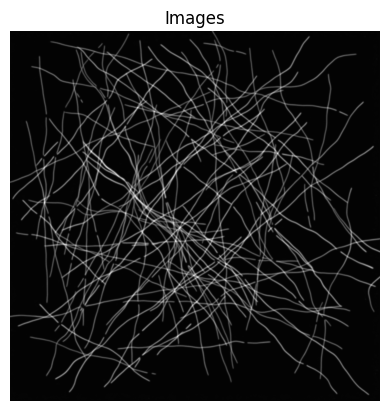

In [7]:
images_path = sn2nunet.images_path
tif_files = [f for f in os.listdir(images_path) if f.endswith('.tif')]
images_last = tifffile.imread(os.path.join(images_path, tif_files[-1]))

plt.imshow(np.squeeze(images_last), cmap='gray')
plt.title('Images')
plt.axis('off') 
plt.show()

## Display the loss curve during training.

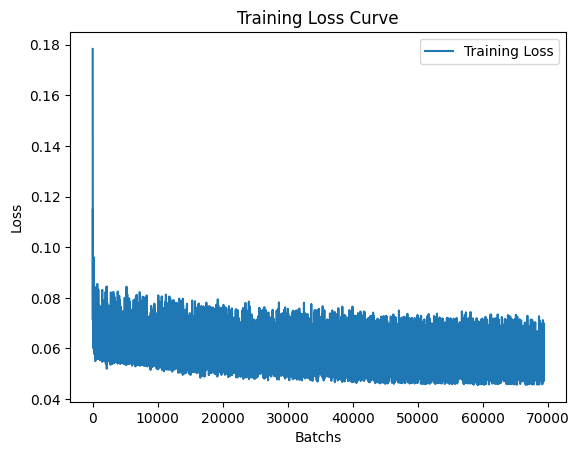

In [8]:
def plot_loss_curve(loss_history):
    plt.plot(loss_history, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Batchs')
    plt.ylabel('Loss')
#     plt.axis('off') 
    plt.legend()
    plt.show()

parent_path = sn2nunet.parent_dir
tif_files = [f for f in os.listdir(parent_path) if f.endswith('loss.txt')]
file_path = os.path.join(parent_path, tif_files[0])
with open(file_path, 'r') as f:
    loss_history = [float(line.strip()) for line in f if line.strip()]
plot_loss_curve(loss_history)